
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [2]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_2886/638584088.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


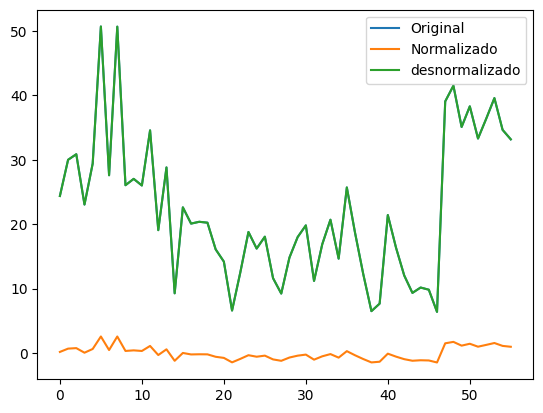

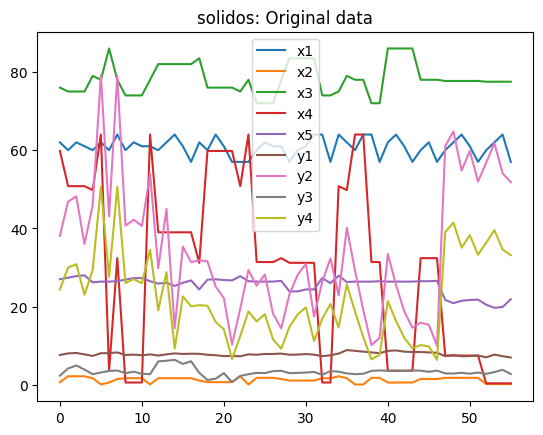

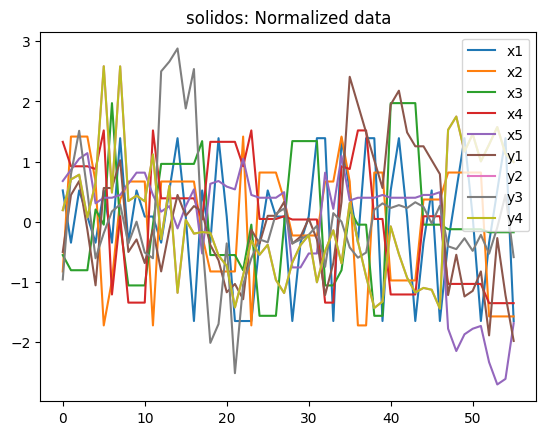

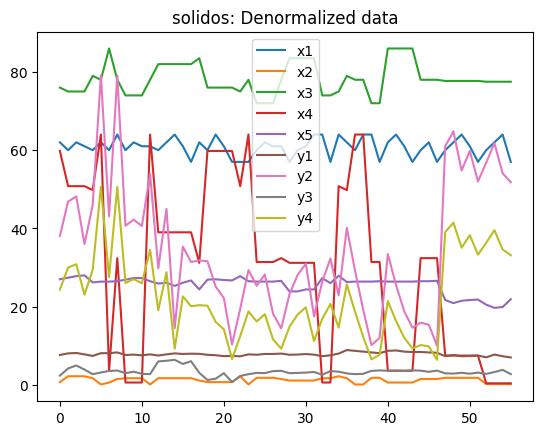

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y4"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y4")
test_out_scaler()
show_norm(label="solidos")


In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-05 16:57:53.736215: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 16:57:55.785979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 16:57:55.786067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 16:57:56.094338: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 16:57:56.757997: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 16:57:56.762740: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [6]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [7]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [8]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [9]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[15,10], [15,5], [15,7],[20,15], [20,5], [20, 7], [20, 10], [25,15], [25,5], [25, 7], [25, 10], [30,15], [30,5], [30, 7], [30, 10]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[15, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  1.1607906119998006
Stopped at epoch:  15
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++


Elapsed time:  0.21552879299997585
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.16455281000025934
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.1617025159998775
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.2628217870001208
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.1960486929997387
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Elapsed time:  0.22409405700000207
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Elapsed time:  0.261372269000276
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_1_3_0   0.803905  0.691996  0.733608  0.716539  23.649072  26.837669   
model_1_3_1   0.824787  0.656512  0.734336  0.699645  21.130732  29.929624   
model_1_3_2   0.840403  0.617445  0.735090  0.681022  19.247440  33.333637   
model_1_3_3   0.851971  0.576866  0.736019  0.661752  17.852370  36.869515   
model_1_3_4   0.860456  0.536676  0.737056  0.642725  16.829055  40.371441   
model_1_3_5   0.866608  0.498281  0.738077  0.624563  16.087084  43.716918   
model_1_3_6   0.870999  0.462462  0.738989  0.607598  15.557599  46.838017   
model_1_3_22  0.872456  0.180996  0.739150  0.470782  15.381805  71.363318   
model_1_3_21  0.873085  0.188534  0.739437  0.474592  15.305988  70.706480   
model_1_3_20  0.873741  0.196874  0.739727  0.478794  15.226857  69.979774   
model_1_3_7   0.874057  0.429508  0.739747  0.591951  15.188719  49.709385   
model_1_3_19  0.874418  0.206099  0.740015  0.483425  15.145189  69.175962   
model_1_3_18  0.875107  0.216299  0.740295  0.488527  15.062118  68.287232   
model_1_3_17  0.875795  0.227572  0.740561  0.494143  14.979216  67.304966   
model_1_3_8   0.876108  0.399422  0.740341  0.577616  14.941380  52.330932   
model_1_3_16  0.876463  0.240028  0.740801  0.500322  14.898628  66.219659   
model_1_3_15  0.877088  0.253786  0.741008  0.507117  14.823167  65.020856   
model_1_3_9   0.877396  0.372058  0.740777  0.564526  14.786031  54.715301   
model_1_3_14  0.877641  0.268978  0.741170  0.514587  14.756569  63.697052   
model_1_3_13  0.878079  0.285750  0.741272  0.522796  14.703710  62.235677   
model_1_3_10  0.878109  0.347216  0.741071  0.552591  14.700084  56.879859   
model_1_3_12  0.878351  0.304260  0.741301  0.531813  14.670885  60.622824   
model_1_3_11  0.878390  0.324685  0.741240  0.541717  14.666187  58.843082   

                mse_val     mse_vt  
model_1_3_0   26.937737  26.884763  
model_1_3_1   26.864144  28.487049  
model_1_3_2   26.787863  30.253270  
model_1_3_3   26.693935  32.081009  
model_1_3_4   26.589045  33.885611  
model_1_3_5   26.485808  35.608163  
model_1_3_6   26.393626  37.217129  
model_1_3_22  26.377343  50.193451  
model_1_3_21  26.348290  49.832038  
model_1_3_20  26.318949  49.433504  
model_1_3_7   26.316958  38.701182  
model_1_3_19  26.289847  48.994258  
model_1_3_18  26.261512  48.510419  
model_1_3_17  26.234706  47.977775  
model_1_3_8   26.256910  40.060803  
model_1_3_16  26.210346  47.391752  
model_1_3_15  26.189422  46.747235  
model_1_3_9   26.212793  41.302360  
model_1_3_14  26.173093  46.038712  
model_1_3_13  26.162742  45.260177  
model_1_3_10  26.183069  42.434308  
model_1_3_12  26.159834  44.404945  
model_1_3_11  26.166013  43.465639

DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Elapsed time:  0.16759652999962782
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Elapsed time:  0.17181326800027819
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Elapsed time:  0.2199102229997152
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Elapsed time:  0.31082922199993845
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Elapsed time:  0.16836775999991005
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Elapsed time:  0.377978369000175
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Elapsed time:  0.313597559

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_1_4_24  0.863908  0.886295 -0.057137  0.656865  16.412684  21.158979   
model_1_4_23  0.864945  0.888178 -0.050863  0.659659  16.287684  20.808460   
model_1_4_22  0.866078  0.890262 -0.043966  0.662738  16.151021  20.420764   
model_1_4_21  0.867314  0.892565 -0.036394  0.666129  16.001928  19.992215   
model_1_4_20  0.868660  0.895108 -0.028091  0.669858  15.839646  19.518974   
model_1_4_19  0.870120  0.897913 -0.019000  0.673954  15.663531  18.996914   
model_1_4_18  0.871700  0.901005 -0.009063  0.678447  15.472993  18.421630   
model_1_4_17  0.873403  0.904406  0.001779  0.683367  15.267680  17.788681   
model_1_4_16  0.875229  0.908142  0.013584  0.688744  15.047412  17.093459   
model_1_4_15  0.877178  0.912236  0.026410  0.694608  14.812425  16.331678   
model_1_4_14  0.879243  0.916709  0.040310  0.700986  14.563389  15.499271   
model_1_4_13  0.881413  0.921579  0.055332  0.707901  14.301631  14.592989   
model_1_4_0   0.883146  0.988944  0.324349  0.819301  14.092686   2.057456   
model_1_4_12  0.883671  0.926856  0.071521  0.715371  14.029329  13.610977   
model_1_4_11  0.885988  0.932538  0.088911  0.723404  13.749839  12.553755   
model_1_4_10  0.888325  0.938602  0.107528  0.731992  13.468090  11.425316   
model_1_4_1   0.890268  0.988285  0.313156  0.816009  13.233723   2.180065   
model_1_4_9   0.890622  0.944996  0.127390  0.741107  13.191037  10.235392   
model_1_4_8   0.892800  0.951628  0.148504  0.750693  12.928375   9.001423   
model_1_4_2   0.894556  0.985630  0.293966  0.809411  12.716561   2.673968   
model_1_4_7   0.894749  0.958346  0.170863  0.760653  12.693248   7.751190   
model_1_4_6   0.896328  0.964946  0.194428  0.770849  12.502916   6.523100   
model_1_4_3   0.896798  0.981685  0.270040  0.800785  12.446219   3.408169   
model_1_4_5   0.897352  0.971181  0.219082  0.781097  12.379319   5.362797   
model_1_4_4   0.897601  0.976818  0.244524  0.791173  12.349335   4.313856   

                mse_val     mse_vt  
model_1_4_24  90.835222  53.947804  
model_1_4_23  90.296069  53.508519  
model_1_4_22  89.703446  53.024370  
model_1_4_21  89.052831  52.491329  
model_1_4_20  88.339376  51.905036  
model_1_4_19  87.558250  51.261080  
model_1_4_18  86.704381  50.554694  
model_1_4_17  85.772805  49.781223  
model_1_4_16  84.758413  48.935797  
model_1_4_15  83.656377  48.013876  
model_1_4_14  82.462004  47.011143  
model_1_4_13  81.171217  45.923916  
model_1_4_0   58.055760  28.409605  
model_1_4_12  79.780195  44.749434  
model_1_4_11  78.285935  43.486536  
model_1_4_10  76.686251  42.136351  
model_1_4_1   59.017500  28.927105  
model_1_4_9   74.979558  40.703232  
model_1_4_8   73.165330  39.196181  
model_1_4_2   60.666398  29.964526  
model_1_4_7   71.244113  37.630218  
model_1_4_6   69.219275  36.027177  
model_1_4_3   62.722282  31.320698  
model_1_4_5   67.100861  34.416009  
model_1_4_4   64.914731  32.831922

DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Elapsed time:  0.22367317699990963
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Elapsed time:  0.16205231200001435
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Elapsed time:  0.16197526799987827
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Elapsed time:  0.16050936200008437
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Elapsed time:  0.18742247399995904
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Elapsed time:  0.1810499940002046
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Elapsed time:  0.1640114

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_1_5_24  0.894772  0.287503  0.911223  0.525234  12.690583  73.911814   
model_1_5_0   0.895011  0.616009  0.995272  0.758211  12.661699  39.833860   
model_1_5_23  0.895630  0.293602  0.912500  0.529467  12.587040  73.279146   
model_1_5_22  0.896571  0.300358  0.913903  0.534152  12.473603  72.578289   
model_1_5_21  0.897599  0.307838  0.915443  0.539335  12.349592  71.802352   
model_1_5_20  0.898720  0.316110  0.917131  0.545061  12.214400  70.944261   
model_1_5_19  0.899938  0.325247  0.918979  0.551382  12.067469  69.996402   
model_1_5_18  0.901257  0.335325  0.921000  0.558346  11.908411  68.951013   
model_1_5_17  0.902678  0.346416  0.923206  0.566006  11.737054  67.800436   
model_1_5_16  0.904199  0.358592  0.925610  0.574409  11.553569  66.537342   
model_1_5_1   0.904465  0.615425  0.990964  0.756439  11.521491  39.894449   
model_1_5_15  0.905816  0.371915  0.928228  0.583600  11.358586  65.155218   
model_1_5_14  0.907518  0.386436  0.931074  0.593614  11.153379  63.648940   
model_1_5_13  0.909286  0.402180  0.934162  0.604473  10.940102  62.015695   
model_1_5_2   0.910987  0.607695  0.985874  0.749940  10.734992  40.696279   
model_1_5_12  0.911094  0.419144  0.937509  0.616179  10.722082  60.255951   
model_1_5_11  0.912901  0.437279  0.941132  0.628709  10.504144  58.374624   
model_1_5_10  0.914652  0.456483  0.945045  0.642002  10.293047  56.382450   
model_1_5_3   0.915243  0.594818  0.980372  0.740087  10.221732  42.032082   
model_1_5_9   0.916270  0.476586  0.949262  0.655956  10.097877  54.297047   
model_1_5_8   0.917657  0.497339  0.953791  0.670419   9.930595  52.144268   
model_1_5_4   0.917765  0.578370  0.974738  0.727957   9.917590  43.738373   
model_1_5_7   0.918685  0.518401  0.958632  0.685177   9.806620  49.959307   
model_1_5_5   0.918971  0.559563  0.969162  0.714369   9.772080  45.689313   
model_1_5_6   0.919192  0.539333  0.963769  0.699951   9.745512  47.787963   

               mse_val     mse_vt  
model_1_5_24  5.407525  41.674498  
model_1_5_0   0.287974  21.224023  
model_1_5_23  5.329736  41.302959  
model_1_5_22  5.244258  40.891678  
model_1_5_21  5.150448  40.436745  
model_1_5_20  5.047626  39.934081  
model_1_5_19  4.935049  39.379296  
model_1_5_18  4.811998  38.767951  
model_1_5_17  4.677621  38.095588  
model_1_5_16  4.531152  37.357959  
model_1_5_1   0.550393  21.379596  
model_1_5_15  4.371711  36.551213  
model_1_5_14  4.198382  35.672207  
model_1_5_13  4.010258  34.719016  
model_1_5_2   0.860459  21.950007  
model_1_5_12  3.806368  33.691436  
model_1_5_11  3.585697  32.591594  
model_1_5_10  3.347356  31.424756  
model_1_5_3   1.195532  22.814879  
model_1_5_9   3.090499  30.199852  
model_1_5_8   2.814635  28.930321  
model_1_5_4   1.538727  23.879715  
model_1_5_7   2.519781  27.634823  
model_1_5_5   1.878362  25.072391  
model_1_5_6   2.206897  26.338049

DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Elapsed time:  0.1743781520003722
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Elapsed time:  0.19357459399998334
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Elapsed time:  0.16515036400005556
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Elapsed time:  0.18309950000002573
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Elapsed time:  0.16656561799982228
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Elapsed time:  0.16276222200031043
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Elapsed time:  0.1952146

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_1_6_0   0.904976  0.777837  0.987911  0.870358  11.459936  33.946425   
model_1_6_1   0.912866  0.773535  0.985515  0.867001  10.508358  34.603760   
model_1_6_2   0.918859  0.768528  0.982965  0.863186   9.785652  35.368921   
model_1_6_3   0.923322  0.762881  0.980407  0.859010   9.247356  36.231784   
model_1_6_4   0.926576  0.756797  0.977920  0.854615   8.854974  37.161424   
model_1_6_24  0.926894  0.677413  0.949892  0.799003   8.816570  49.291247   
model_1_6_23  0.927226  0.679009  0.950454  0.800120   8.776537  49.047426   
model_1_6_22  0.927583  0.680770  0.951074  0.801354   8.733490  48.778242   
model_1_6_21  0.927965  0.682712  0.951757  0.802713   8.687475  48.481552   
model_1_6_20  0.928370  0.684851  0.952509  0.804210   8.638565  48.154720   
model_1_6_19  0.928798  0.687204  0.953336  0.805857   8.586966  47.795179   
model_1_6_5   0.928884  0.750503  0.975529  0.850139   8.576567  38.123098   
model_1_6_18  0.929245  0.689789  0.954245  0.807667   8.533040  47.400171   
model_1_6_17  0.929707  0.692625  0.955241  0.809651   8.477336  46.966852   
model_1_6_16  0.930177  0.695731  0.956330  0.811824   8.420654  46.492347   
model_1_6_6   0.930460  0.744190  0.973238  0.845692   8.386496  39.087804   
model_1_6_15  0.930646  0.699124  0.957519  0.814197   8.364135  45.973852   
model_1_6_14  0.931100  0.702823  0.958813  0.816784   8.309340  45.408626   
model_1_6_7   0.931473  0.737996  0.971048  0.841352   8.264389  40.034137   
model_1_6_13  0.931523  0.706844  0.960217  0.819595   8.258360  44.794269   
model_1_6_12  0.931891  0.711199  0.961735  0.822638   8.213995  44.128778   
model_1_6_8   0.932056  0.732019  0.968962  0.837175   8.194122  40.947449   
model_1_6_11  0.932173  0.715897  0.963368  0.825919   8.179901  43.410885   
model_1_6_9   0.932314  0.726321  0.966985  0.833196   8.162945  41.818102   
model_1_6_10  0.932332  0.720940  0.965119  0.829440   8.160831  42.640298   

               mse_val     mse_vt  
model_1_6_0   1.447848  18.652981  
model_1_6_1   1.734808  19.136022  
model_1_6_2   2.040255  19.684839  
model_1_6_3   2.346590  20.285794  
model_1_6_4   2.644500  20.918153  
model_1_6_24  6.001415  28.919562  
model_1_6_23  5.934124  28.758803  
model_1_6_22  5.859893  28.581357  
model_1_6_21  5.778061  28.385785  
model_1_6_20  5.687964  28.170372  
model_1_6_19  5.588887  27.933393  
model_1_6_5   2.930896  21.562061  
model_1_6_18  5.480069  27.673069  
model_1_6_17  5.360792  27.387537  
model_1_6_16  5.230334  27.074921  
model_1_6_6   3.205271  22.201902  
model_1_6_15  5.087916  26.733401  
model_1_6_14  4.932931  26.361240  
model_1_6_7   3.467515  22.826328  
model_1_6_13  4.764784  25.956859  
model_1_6_12  4.583014  25.519016  
model_1_6_8   3.717356  23.427416  
model_1_6_11  4.387341  25.046886  
model_1_6_9   3.954243  23.999817  
model_1_6_10  4.177706  24.540258

DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Elapsed time:  0.16827504899993073
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Elapsed time:  0.18089351700018597
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Elapsed time:  0.17722170299975915
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Elapsed time:  0.1614225329999499
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Elapsed time:  0.16365633800023716
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Elapsed time:  0.19488042400007544
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Elapsed time:  0.1597919

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_1_7_0   0.939316  0.977742  0.988143  0.982985  7.318475   2.670993   
model_1_7_1   0.948860  0.974399  0.986030  0.980266  6.167542   3.072235   
model_1_7_2   0.956052  0.968938  0.983324  0.976191  5.300090   3.727526   
model_1_7_3   0.961355  0.961902  0.980233  0.971133  4.660606   4.571894   
model_1_7_24  0.964578  0.841964  0.936779  0.889432  4.271951  18.964737   
model_1_7_23  0.964968  0.844181  0.937536  0.890920  4.224894  18.698749   
model_1_7_4   0.965163  0.953827  0.976929  0.965447  4.201391   5.540956   
model_1_7_22  0.965388  0.846629  0.938373  0.892563  4.174187  18.404939   
model_1_7_21  0.965839  0.849331  0.939298  0.894378  4.119793  18.080693   
model_1_7_20  0.966320  0.852311  0.940320  0.896379  4.061769  17.723116   
model_1_7_19  0.966830  0.855593  0.941448  0.898585  4.000292  17.329232   
model_1_7_18  0.967366  0.859205  0.942693  0.901015  3.935683  16.895773   
model_1_7_5   0.967807  0.945179  0.973547  0.959435  3.882451   6.578660   
model_1_7_17  0.967923  0.863174  0.944064  0.903685  3.868497  16.419476   
model_1_7_16  0.968495  0.867530  0.945572  0.906618  3.799532  15.896804   
model_1_7_15  0.969071  0.872300  0.947229  0.909833  3.729987  15.324403   
model_1_7_6   0.969560  0.936330  0.970189  0.953333  3.671114   7.640564   
model_1_7_14  0.969639  0.877512  0.949046  0.913348  3.661517  14.698900   
model_1_7_13  0.970179  0.883193  0.951035  0.917184  3.596404  14.017195   
model_1_7_7   0.970636  0.927552  0.966928  0.947314  3.541302   8.693943   
model_1_7_12  0.970666  0.889364  0.953204  0.921355  3.537719  13.276682   
model_1_7_11  0.971065  0.896039  0.955564  0.925873  3.489600  12.475658   
model_1_7_8   0.971207  0.919035  0.963812  0.941497  3.472467   9.716087   
model_1_7_10  0.971331  0.903222  0.958119  0.930743  3.457495  11.613628   
model_1_7_9   0.971404  0.910900  0.960870  0.935959  3.448631  10.692248   

               mse_val     mse_vt  
model_1_7_0   1.551920   2.144371  
model_1_7_1   1.828529   2.486960  
model_1_7_2   2.182637   3.000522  
model_1_7_3   2.587222   3.637936  
model_1_7_24  8.274914  13.934235  
model_1_7_23  8.175827  13.746788  
model_1_7_4   3.019731   4.354496  
model_1_7_22  8.066279  13.539689  
model_1_7_21  7.945144  13.311024  
model_1_7_20  7.811371  13.058763  
model_1_7_19  7.663704  12.780733  
model_1_7_18  7.500806  12.474612  
model_1_7_5   3.462398   5.112184  
model_1_7_17  7.321396  12.138025  
model_1_7_16  7.123996  11.768421  
model_1_7_15  6.907092  11.363312  
model_1_7_6   3.901864   5.881172  
model_1_7_14  6.669249  10.920235  
model_1_7_13  6.408995  10.436868  
model_1_7_7   4.328724   6.639728  
model_1_7_12  6.125033   9.911194  
model_1_7_11  5.816179   9.341786  
model_1_7_8   4.736609   7.372810  
model_1_7_10  5.481779   8.728052  
model_1_7_9   5.121652   8.070785

DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Elapsed time:  0.26450438000028953
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Elapsed time:  0.1610815519998141
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Elapsed time:  0.16589420499985863
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Elapsed time:  0.2033910069999365
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Elapsed time:  0.17833204199996544
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Elapsed time:  0.164873126999737
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Elapsed time:  0.1612759589

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_1_8_0   0.970781  0.988819  0.989351  0.989079  3.523802  1.801609   
model_1_8_1   0.975619  0.988591  0.990063  0.989230  2.940409  1.838334   
model_1_8_2   0.979357  0.987812  0.990258  0.988845  2.489547  1.963938   
model_1_8_3   0.982215  0.986624  0.990046  0.988055  2.144853  2.155358   
model_1_8_4   0.984371  0.985146  0.989526  0.986968  1.884814  2.393554   
model_1_8_5   0.985971  0.983473  0.988779  0.985674  1.691946  2.663076   
model_1_8_24  0.986995  0.958333  0.973203  0.964483  1.568364  6.713981   
model_1_8_6   0.987130  0.981682  0.987873  0.984247  1.552073  2.951603   
model_1_8_23  0.987154  0.958966  0.973625  0.965028  1.549183  6.612031   
model_1_8_22  0.987324  0.959660  0.974087  0.965626  1.528765  6.500118   
model_1_8_21  0.987503  0.960421  0.974594  0.966282  1.507187  6.377479   
model_1_8_20  0.987690  0.961254  0.975147  0.966999  1.484578  6.243302   
model_1_8_19  0.987884  0.962163  0.975749  0.967781  1.461144  6.096808   
model_1_8_7   0.987946  0.979834  0.986864  0.982743  1.453746  3.249423   
model_1_8_18  0.988083  0.963154  0.976404  0.968632  1.437188  5.937220   
model_1_8_17  0.988283  0.964230  0.977114  0.969557  1.413131  5.763786   
model_1_8_16  0.988478  0.965396  0.977880  0.970557  1.389564  5.575888   
model_1_8_8   0.988493  0.977975  0.985796  0.981210  1.387753  3.549033   
model_1_8_15  0.988663  0.966655  0.978703  0.971636  1.367275  5.372978   
model_1_8_14  0.988828  0.968010  0.979584  0.972795  1.347304  5.154721   
model_1_8_9   0.988833  0.976140  0.984703  0.979681  1.346718  3.844757   
model_1_8_13  0.988963  0.969460  0.980521  0.974032  1.331022  4.921039   
model_1_8_10  0.989015  0.974355  0.983612  0.978182  1.324744  4.132355   
model_1_8_12  0.989053  0.971005  0.981509  0.975347  1.320208  4.672178   
model_1_8_11  0.989078  0.972639  0.982543  0.976733  1.317143  4.408850   

               mse_val    mse_vt  
model_1_8_0   1.306617  1.568675  
model_1_8_1   1.219191  1.546974  
model_1_8_2   1.195345  1.602249  
model_1_8_3   1.221300  1.715799  
model_1_8_4   1.285153  1.871949  
model_1_8_5   1.376835  2.057787  
model_1_8_24  3.287969  5.101739  
model_1_8_6   1.487979  2.262839  
model_1_8_23  3.236191  5.023403  
model_1_8_22  3.179429  4.937442  
model_1_8_21  3.117314  4.843285  
model_1_8_20  3.049455  4.740318  
model_1_8_19  2.975530  4.627966  
model_1_8_7   1.611776  2.478765  
model_1_8_18  2.895159  4.505662  
model_1_8_17  2.808088  4.372867  
model_1_8_16  2.714091  4.229156  
model_1_8_8   1.742824  2.699052  
model_1_8_15  2.613049  4.074187  
model_1_8_14  2.504964  3.907778  
model_1_8_9   1.876895  2.918701  
model_1_8_13  2.390072  3.729991  
model_1_8_10  2.010747  3.133955  
model_1_8_12  2.268799  3.541177  
model_1_8_11  2.141959  3.342079

DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Elapsed time:  0.16910863799967046
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Elapsed time:  0.15982792200020413
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Elapsed time:  0.1612401630000022
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Elapsed time:  0.19416341899977851
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Elapsed time:  0.19903007499988234
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Elapsed time:  0.2750025000000278
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Elapsed time:  0.37540490

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_1_9_24  0.983548  0.981707  0.793845  0.922692  1.984161  1.918461   
model_1_9_23  0.983725  0.981947  0.796133  0.923574  1.962752  1.893324   
model_1_9_22  0.983919  0.982211  0.798651  0.924545  1.939347  1.865618   
model_1_9_21  0.984131  0.982502  0.801419  0.925613  1.913803  1.835116   
model_1_9_20  0.984362  0.982822  0.804457  0.926785  1.885998  1.801555   
model_1_9_19  0.984612  0.983173  0.807788  0.928071  1.855809  1.764716   
model_1_9_18  0.984883  0.983558  0.811432  0.929479  1.823148  1.724302   
model_1_9_17  0.985175  0.983980  0.815415  0.931017  1.787929  1.680074   
model_1_9_16  0.985488  0.984441  0.819754  0.932694  1.750129  1.631755   
model_1_9_15  0.985823  0.984943  0.824472  0.934518  1.709770  1.579100   
model_1_9_14  0.986178  0.985489  0.829587  0.936497  1.666942  1.521874   
model_1_9_13  0.986552  0.986080  0.835115  0.938636  1.621839  1.459899   
model_1_9_12  0.986942  0.986717  0.841067  0.940940  1.574783  1.393030   
model_1_9_11  0.987344  0.987402  0.847446  0.943410  1.526268  1.321228   
model_1_9_10  0.987753  0.988133  0.854248  0.946045  1.476987  1.244570   
model_1_9_9   0.988160  0.988908  0.861457  0.948837  1.427926  1.163304   
model_1_9_0   0.988214  0.995552  0.930757  0.975150  1.421353  0.466501   
model_1_9_8   0.988554  0.989722  0.869043  0.951775  1.380406  1.077906   
model_1_9_7   0.988921  0.990568  0.876955  0.954837  1.336179  0.989151   
model_1_9_1   0.988999  0.995222  0.924745  0.973030  1.326679  0.501079   
model_1_9_6   0.989241  0.991435  0.885122  0.957993  1.297555  0.898235   
model_1_9_2   0.989448  0.994666  0.917681  0.970428  1.272582  0.559390   
model_1_9_5   0.989490  0.992306  0.893438  0.961199  1.267518  0.806892   
model_1_9_4   0.989636  0.993158  0.901766  0.964397  1.249896  0.717547   
model_1_9_3   0.989639  0.993959  0.909925  0.967507  1.249543  0.633549   

                mse_val    mse_vt  
model_1_9_24  11.695767  6.519544  
model_1_9_23  11.565976  6.445158  
model_1_9_22  11.423139  6.363273  
model_1_9_21  11.266106  6.273229  
model_1_9_20  11.093721  6.174337  
model_1_9_19  10.904731  6.065905  
model_1_9_18  10.697993  5.947215  
model_1_9_17  10.472076  5.817487  
model_1_9_16  10.225884  5.676053  
model_1_9_15   9.958213  5.522211  
model_1_9_14   9.668026  5.355354  
model_1_9_13   9.354386  5.174952  
model_1_9_12   9.016745  4.980659  
model_1_9_11   8.654858  4.772351  
model_1_9_10   8.268952  4.550158  
model_1_9_9    7.859948  4.314663  
model_1_9_0    3.928364  2.095609  
model_1_9_8    7.429582  4.066930  
model_1_9_7    6.980678  3.808694  
model_1_9_1    4.269446  2.274428  
model_1_9_6    6.517393  3.542545  
model_1_9_2    4.670186  2.493883  
model_1_9_5    6.045572  3.272153  
model_1_9_4    5.573091  3.002510  
model_1_9_3    5.110245  2.740230

DataFrame salvo em ../results/metrics_1_9
Testando combinação 2: Hidden Size=[15, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Elapsed time:  0.3870236030002161
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Elapsed time:  0.16341088000035597
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Elapsed time:  0.16084304099967994
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Elapsed time:  0.22093389700012267
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Elapsed time:  0.24746367399984592
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Elapsed time:  0.3175670050000008
Stopped at epoch:  6
1/1 [==============================] -

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_2_2_0   0.818269  0.602132  0.383650  0.606989  21.916830  31.793495   
model_2_2_1   0.840880  0.610236  0.455040  0.634784  19.189929  31.145966   
model_2_2_2   0.856436  0.598521  0.492672  0.641975  17.313852  32.082053   
model_2_2_3   0.866980  0.575323  0.511675  0.637540  16.042219  33.935820   
model_2_2_14  0.869902  0.180703  0.506487  0.451620  15.689893  65.469774   
model_2_2_13  0.872222  0.210304  0.510862  0.466906  15.410064  63.104385   
model_2_2_4   0.873935  0.544749  0.521294  0.626506  15.203497  36.378960   
model_2_2_12  0.874501  0.242238  0.515026  0.483211  15.135268  60.552555   
model_2_2_11  0.876659  0.276457  0.518860  0.500471  14.874972  57.818113   
model_2_2_5   0.878240  0.509278  0.526003  0.611535  14.684321  39.213489   
model_2_2_10  0.878592  0.312808  0.522236  0.518572  14.641894  54.913305   
model_2_2_9   0.880159  0.351002  0.525014  0.537332  14.452831  51.861249   
model_2_2_6   0.880566  0.470790  0.527931  0.594221  14.403817  42.289004   
model_2_2_8   0.881179  0.390567  0.527034  0.556477  14.329807  48.699645   
model_2_2_7   0.881416  0.430812  0.528102  0.575619  14.301287  45.483688   

                mse_val     mse_vt  
model_2_2_0   39.933829  35.624243  
model_2_2_1   35.308407  33.104762  
model_2_2_2   32.870244  32.452963  
model_2_2_3   31.638998  32.854960  
model_2_2_14  31.975112  49.707578  
model_2_2_13  31.691653  48.321927  
model_2_2_4   31.015740  33.855091  
model_2_2_12  31.421888  46.844018  
model_2_2_11  31.173491  45.279466  
model_2_2_5   30.710698  35.212179  
model_2_2_10  30.954731  43.638686  
model_2_2_9   30.774764  41.938198  
model_2_2_6   30.585750  36.781589  
model_2_2_8   30.643867  40.202810  
model_2_2_7   30.574669  38.467689

DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Elapsed time:  0.18832477599971753
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Elapsed time:  0.1644461770001726
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Elapsed time:  0.16774667900017448
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Elapsed time:  0.19856038699981582
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Elapsed time:  0.1545676240002649
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Elapsed time:  0.17091887300011877
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Elapsed time:  0.16746122

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_2_3_0   0.894531  0.893958  0.207037  0.781352  12.719564  16.850858   
model_2_3_1   0.902856  0.891728  0.238506  0.785757  11.715579  17.205084   
model_2_3_2   0.909333  0.889066  0.263423  0.788649  10.934468  17.628104   
model_2_3_3   0.914402  0.886223  0.283610  0.790536  10.323134  18.079988   
model_2_3_4   0.918386  0.883347  0.300267  0.791742   9.842705  18.536870   
model_2_3_5   0.921522  0.880527  0.314192  0.792473   9.464476  18.985120   
model_2_3_6   0.923990  0.877808  0.325932  0.792864   9.166773  19.417108   
model_2_3_7   0.925930  0.875220  0.335893  0.793009   8.932837  19.828437   
model_2_3_8   0.927450  0.872776  0.344388  0.792975   8.749519  20.216815   
model_2_3_9   0.928637  0.870483  0.351662  0.792813   8.606420  20.581087   
model_2_3_10  0.929559  0.868345  0.357915  0.792563   8.495261  20.920906   
model_2_3_11  0.930270  0.866358  0.363309  0.792253   8.409453  21.236651   
model_2_3_12  0.930815  0.864519  0.367977  0.791905   8.343727  21.528846   
model_2_3_13  0.931229  0.862822  0.372032  0.791538   8.293842  21.798434   
model_2_3_14  0.931539  0.861261  0.375562  0.791161   8.256468  22.046528   
model_2_3_15  0.931767  0.859828  0.378646  0.790787   8.228913  22.274269   
model_2_3_16  0.931932  0.858515  0.381345  0.790420   8.209039  22.482906   
model_2_3_17  0.932047  0.857315  0.383713  0.790066   8.195134  22.673666   
model_2_3_18  0.932124  0.856219  0.385797  0.789728   8.185839  22.847799   
model_2_3_24  0.932170  0.851432  0.394090  0.788102   8.180270  23.608468   
model_2_3_19  0.932172  0.855220  0.387633  0.789409   8.180086  23.006549   
model_2_3_23  0.932189  0.852050  0.393087  0.788324   8.177988  23.510256   
model_2_3_20  0.932197  0.854310  0.389255  0.789108   8.177029  23.151070   
model_2_3_22  0.932202  0.852732  0.391959  0.788566   8.176451  23.401865   
model_2_3_21  0.932206  0.853483  0.390690  0.788827   8.175992  23.282503   

                mse_val     mse_vt  
model_2_3_0   39.934922  27.713929  
model_2_3_1   38.350102  27.155687  
model_2_3_2   37.095221  26.789095  
model_2_3_3   36.078576  26.549923  
model_2_3_4   35.239702  26.397027  
model_2_3_5   34.538440  26.304336  
model_2_3_6   33.947186  26.254787  
model_2_3_7   33.445512  26.236485  
model_2_3_8   33.017727  26.240764  
model_2_3_9   32.651389  26.261224  
model_2_3_10  32.336473  26.292939  
model_2_3_11  32.064826  26.332251  
model_2_3_12  31.829720  26.376327  
model_2_3_13  31.625513  26.422946  
model_2_3_14  31.447710  26.470606  
model_2_3_15  31.292424  26.518109  
model_2_3_16  31.156492  26.564599  
model_2_3_17  31.037232  26.609463  
model_2_3_18  30.932281  26.652267  
model_2_3_24  30.514652  26.858440  
model_2_3_19  30.839799  26.692779  
model_2_3_23  30.565150  26.830201  
model_2_3_20  30.758141  26.730863  
model_2_3_22  30.621942  26.799552  
model_2_3_21  30.685880  26.766453

DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Elapsed time:  0.44039237700008016
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Elapsed time:  0.4135991949997333
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Elapsed time:  0.18471547099989039
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Elapsed time:  0.18939315099987653
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Elapsed time:  0.20484625700009929
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Elapsed time:  0.27281217100016875
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Elapsed time:  0.1589278

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_4_0   0.942406  0.998013  0.883615  0.927295  6.945828  0.123288   
model_2_4_1   0.950118  0.996650  0.882160  0.925876  6.015766  0.207855   
model_2_4_2   0.955872  0.993574  0.878727  0.922579  5.321842  0.398764   
model_2_4_3   0.960112  0.989293  0.874047  0.918052  4.810541  0.664394   
model_2_4_24  0.962405  0.900882  0.782464  0.827688  4.533921  6.150652   
model_2_4_23  0.962772  0.902771  0.784505  0.829671  4.489649  6.033427   
model_2_4_22  0.963166  0.904846  0.786740  0.831845  4.442159  5.904671   
model_2_4_4   0.963180  0.984199  0.868620  0.912753  4.440456  0.980523   
model_2_4_21  0.963587  0.907122  0.789183  0.834224  4.391478  5.763445   
model_2_4_20  0.964032  0.909615  0.791848  0.836823  4.337728  5.608755   
model_2_4_19  0.964501  0.912341  0.794751  0.839658  4.281132  5.439594   
model_2_4_18  0.964991  0.915315  0.797904  0.842743  4.222097  5.255037   
model_2_4_5   0.965344  0.978595  0.862780  0.907004  4.179581  1.328247   
model_2_4_17  0.965496  0.918553  0.801321  0.846091  4.161216  5.054103   
model_2_4_16  0.966009  0.922070  0.805013  0.849716  4.099344  4.835856   
model_2_4_15  0.966520  0.925878  0.808989  0.853627  4.037646  4.599554   
model_2_4_6   0.966807  0.972720  0.856751  0.901033  4.003026  1.692864   
model_2_4_14  0.967017  0.929988  0.813256  0.857834  3.977719  4.344531   
model_2_4_13  0.967482  0.934405  0.817816  0.862339  3.921670  4.070433   
model_2_4_7   0.967733  0.966752  0.850686  0.895006  3.891380  2.063166   
model_2_4_12  0.967892  0.939131  0.822668  0.867142  3.872257  3.777169   
model_2_4_11  0.968217  0.944159  0.827803  0.872236  3.833062  3.465151   
model_2_4_8   0.968248  0.960828  0.844692  0.889039  3.829356  2.430767   
model_2_4_10  0.968419  0.949474  0.833204  0.877604  3.808666  3.135342   
model_2_4_9   0.968450  0.955046  0.838847  0.883219  3.804944  2.789589   

                mse_val     mse_vt  
model_2_4_0   13.157538   6.257053  
model_2_4_1   13.322010   6.379230  
model_2_4_2   13.710139   6.662939  
model_2_4_3   14.239205   7.052541  
model_2_4_24  24.592897  14.829353  
model_2_4_23  24.362159  14.658701  
model_2_4_22  24.109484  14.471646  
model_2_4_4   14.852702   7.508606  
model_2_4_21  23.833309  14.266905  
model_2_4_20  23.531963  14.043213  
model_2_4_19  23.203819  13.799231  
model_2_4_18  22.847317  13.533754  
model_2_4_5   15.512931   8.003389  
model_2_4_17  22.461019  13.245585  
model_2_4_16  22.043681  12.933654  
model_2_4_15  21.594142  12.597009  
model_2_4_6   16.194563   8.517188  
model_2_4_14  21.111761  12.234999  
model_2_4_13  20.596196  11.847264  
model_2_4_7   16.880265   9.035927  
model_2_4_12  20.047715  11.433890  
model_2_4_11  19.467234  10.995550  
model_2_4_8   17.557864   9.549401  
model_2_4_10  18.856617  10.533578  
model_2_4_9   18.218701  10.050341

DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Elapsed time:  0.2699748780000846
Stopped at epoch:  10
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Elapsed time:  0.1793346270001166
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Elapsed time:  0.19142924499965375
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Elapsed time:  0.4060567239998818
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Elapsed time:  0.36378569799990146
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Elapsed time:  0.23010997700021107
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Elapsed time:  0.25695805

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_5_0   0.975312  0.979847  0.909348  0.947343  2.977369  2.282200   
model_2_5_1   0.976371  0.977458  0.909455  0.946295  2.849657  2.552767   
model_2_5_2   0.977163  0.975098  0.909516  0.945239  2.754202  2.820020   
model_2_5_3   0.977747  0.972828  0.909538  0.944205  2.683746  3.077065   
model_2_5_4   0.978171  0.970684  0.909530  0.943215  2.632635  3.319851   
model_2_5_24  0.978266  0.951841  0.908162  0.933891  2.621078  5.453684   
model_2_5_23  0.978307  0.952143  0.908204  0.934050  2.616130  5.419530   
model_2_5_22  0.978351  0.952478  0.908250  0.934227  2.610819  5.381598   
model_2_5_21  0.978398  0.952850  0.908300  0.934422  2.605150  5.339476   
model_2_5_20  0.978448  0.953263  0.908354  0.934638  2.599125  5.292687   
model_2_5_5   0.978471  0.968685  0.909496  0.942279  2.596446  3.546244   
model_2_5_19  0.978501  0.953722  0.908413  0.934877  2.592782  5.240730   
model_2_5_18  0.978556  0.954231  0.908476  0.935142  2.586161  5.183063   
model_2_5_17  0.978612  0.954796  0.908544  0.935434  2.579341  5.119035   
model_2_5_16  0.978670  0.955424  0.908616  0.935757  2.572417  5.047985   
model_2_5_6   0.978676  0.966838  0.909443  0.941404  2.571725  3.755439   
model_2_5_15  0.978727  0.956120  0.908693  0.936114  2.565533  4.969145   
model_2_5_14  0.978782  0.956892  0.908774  0.936508  2.558888  4.881743   
model_2_5_7   0.978808  0.965142  0.909375  0.940591  2.555754  3.947454   
model_2_5_13  0.978833  0.957747  0.908859  0.936942  2.552753  4.784869   
model_2_5_12  0.978877  0.958695  0.908946  0.937420  2.547463  4.677523   
model_2_5_8   0.978885  0.963593  0.909298  0.939841  2.546430  4.122865   
model_2_5_11  0.978910  0.959744  0.909035  0.937945  2.543496  4.558745   
model_2_5_9   0.978921  0.962183  0.909213  0.939153  2.542081  4.282513   
model_2_5_10  0.978927  0.960903  0.909125  0.938522  2.541444  4.427448   

                mse_val    mse_vt  
model_2_5_0   12.014833  6.862267  
model_2_5_1   12.000653  6.998834  
model_2_5_2   11.992589  7.136525  
model_2_5_3   11.989587  7.271197  
model_2_5_4   11.990715  7.400261  
model_2_5_24  12.172073  8.615286  
model_2_5_23  12.166488  8.594564  
model_2_5_22  12.160369  8.571612  
model_2_5_21  12.153750  8.546197  
model_2_5_20  12.146528  8.518032  
model_2_5_5   11.995193  7.522218  
model_2_5_19  12.138767  8.486866  
model_2_5_18  12.130357  8.452378  
model_2_5_17  12.121400  8.414261  
model_2_5_16  12.111782  8.372131  
model_2_5_6   12.002256  7.636297  
model_2_5_15  12.101606  8.325601  
model_2_5_14  12.090870  8.274270  
model_2_5_7   12.011216  7.742162  
model_2_5_13  12.079676  8.217718  
model_2_5_12  12.068079  8.155435  
model_2_5_8   12.021518  7.839889  
model_2_5_11  12.056284  8.086993  
model_2_5_9   12.032689  7.929652  
model_2_5_10  12.044385  8.011893

DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Elapsed time:  0.21664077600007658
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Elapsed time:  0.20180795000032958
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Elapsed time:  0.17538678999972035
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Elapsed time:  0.19041176799964887
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Elapsed time:  0.1589701459997741
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Elapsed time:  0.16759954400004062
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Elapsed time:  0.2067622

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_6_0   0.980995  0.939477  0.969631  0.969159  2.291952  2.064008   
model_2_6_1   0.983093  0.940387  0.966921  0.967780  2.038977  2.032977   
model_2_6_2   0.984691  0.940387  0.964169  0.966178  1.846311  2.032990   
model_2_6_3   0.985893  0.939720  0.961435  0.964442  1.701293  2.055733   
model_2_6_4   0.986785  0.938578  0.958766  0.962640  1.593790  2.094685   
model_2_6_24  0.987420  0.911127  0.930419  0.940170  1.517190  3.030849   
model_2_6_5   0.987432  0.937109  0.956194  0.960823  1.515695  2.144764   
model_2_6_23  0.987497  0.911802  0.930957  0.940630  1.507867  3.007827   
model_2_6_22  0.987580  0.912543  0.931550  0.941136  1.497896  2.982564   
model_2_6_21  0.987668  0.913354  0.932205  0.941694  1.487302  2.954890   
model_2_6_20  0.987760  0.914241  0.932927  0.942307  1.476118  2.924637   
model_2_6_19  0.987857  0.915209  0.933722  0.942980  1.464425  2.891632   
model_2_6_6   0.987889  0.935429  0.953739  0.959029  1.460562  2.202082   
model_2_6_18  0.987957  0.916263  0.934596  0.943718  1.452331  2.855691   
model_2_6_17  0.988060  0.917407  0.935556  0.944526  1.440007  2.816692   
model_2_6_16  0.988162  0.918644  0.936609  0.945408  1.427680  2.774486   
model_2_6_7   0.988199  0.933624  0.951415  0.957284  1.423231  2.263622   
model_2_6_15  0.988261  0.919978  0.937762  0.946369  1.415678  2.728998   
model_2_6_14  0.988355  0.921410  0.939024  0.947415  1.404419  2.680152   
model_2_6_8   0.988395  0.931762  0.949230  0.955607  1.399611  2.327128   
model_2_6_13  0.988437  0.922939  0.940400  0.948548  1.394482  2.628013   
model_2_6_12  0.988502  0.924561  0.941898  0.949773  1.386605  2.572691   
model_2_6_9   0.988504  0.929893  0.947188  0.954012  1.386447  2.390858   
model_2_6_11  0.988543  0.926270  0.943525  0.951092  1.381753  2.514410   
model_2_6_10  0.988548  0.928054  0.945287  0.952505  1.381168  2.453589   

               mse_val    mse_vt  
model_2_6_0   3.117564  2.559799  
model_2_6_1   3.395742  2.674274  
model_2_6_2   3.678304  2.807257  
model_2_6_3   3.958895  2.951336  
model_2_6_4   4.232879  3.100899  
model_2_6_24  7.142956  4.965955  
model_2_6_5   4.496984  3.251692  
model_2_6_23  7.087732  4.927778  
model_2_6_22  7.026775  4.885712  
model_2_6_21  6.959530  4.839434  
model_2_6_20  6.885435  4.788546  
model_2_6_19  6.803869  4.732684  
model_2_6_6   4.749004  3.400638  
model_2_6_18  6.714150  4.671438  
model_2_6_17  6.615619  4.604417  
model_2_6_16  6.507494  4.531188  
model_2_6_7   4.987554  3.545473  
model_2_6_15  6.389071  4.451388  
model_2_6_14  6.259600  4.364599  
model_2_6_8   5.211836  3.684635  
model_2_6_13  6.118324  4.270517  
model_2_6_12  5.964508  4.168841  
model_2_6_9   5.421520  3.817057  
model_2_6_11  5.797467  4.059381  
model_2_6_10  5.616618  3.942077

DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Elapsed time:  0.33876364400020975
Stopped at epoch:  8
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Elapsed time:  0.23581636300013997
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Elapsed time:  0.17377175899991926
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Elapsed time:  0.1882779229999869
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Elapsed time:  0.2086618130001625
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Elapsed time:  0.2615970660003768
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Elapsed time:  0.196799685

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_7_0   0.991461  0.989631  0.991480  0.991183  1.029800  1.503123   
model_2_7_24  0.991833  0.975303  0.977114  0.977967  0.984989  3.580218   
model_2_7_23  0.991895  0.975503  0.977331  0.978158  0.977420  3.551108   
model_2_7_22  0.991964  0.975725  0.977570  0.978369  0.969201  3.518989   
model_2_7_21  0.992037  0.975969  0.977833  0.978602  0.960294  3.483579   
model_2_7_20  0.992117  0.976238  0.978123  0.978858  0.950682  3.444554   
model_2_7_1   0.992168  0.988685  0.990701  0.990378  0.944583  1.640242   
model_2_7_19  0.992203  0.976535  0.978441  0.979140  0.940350  3.401596   
model_2_7_18  0.992294  0.976861  0.978791  0.979449  0.929297  3.354365   
model_2_7_17  0.992392  0.977218  0.979174  0.979789  0.917549  3.302506   
model_2_7_16  0.992495  0.977611  0.979593  0.980161  0.905146  3.245641   
model_2_7_15  0.992602  0.978040  0.980050  0.980568  0.892172  3.183394   
model_2_7_2   0.992666  0.987711  0.989837  0.989524  0.884535  1.781452   
model_2_7_14  0.992714  0.978509  0.980549  0.981012  0.878745  3.115359   
model_2_7_13  0.992827  0.979021  0.981091  0.981495  0.865055  3.041212   
model_2_7_12  0.992941  0.979577  0.981678  0.982020  0.851350  2.960552   
model_2_7_3   0.993002  0.986734  0.988928  0.988651  0.843992  1.923134   
model_2_7_11  0.993052  0.980181  0.982312  0.982588  0.837985  2.873084   
model_2_7_10  0.993156  0.980833  0.982995  0.983201  0.825424  2.778537   
model_2_7_4   0.993213  0.985771  0.988004  0.987779  0.818455  2.062609   
model_2_7_9   0.993248  0.981535  0.983725  0.983860  0.814294  2.676722   
model_2_7_8   0.993322  0.982288  0.984503  0.984563  0.805406  2.567555   
model_2_7_5   0.993330  0.984838  0.987086  0.986925  0.804359  2.197930   
model_2_7_7   0.993368  0.983091  0.985326  0.985311  0.799812  2.451131   
model_2_7_6   0.993376  0.983943  0.986189  0.986100  0.798885  2.327739   

               mse_val    mse_vt  
model_2_7_0   1.056822  1.293099  
model_2_7_24  2.838751  3.231291  
model_2_7_23  2.811857  3.203224  
model_2_7_22  2.782206  3.172273  
model_2_7_21  2.749552  3.138153  
model_2_7_20  2.713628  3.100585  
model_2_7_1   1.153466  1.411171  
model_2_7_19  2.674136  3.059265  
model_2_7_18  2.630787  3.013861  
model_2_7_17  2.583296  2.964055  
model_2_7_16  2.531317  2.909487  
model_2_7_15  2.474566  2.849826  
model_2_7_2   1.260631  1.536357  
model_2_7_14  2.412718  2.784703  
model_2_7_13  2.345505  2.713819  
model_2_7_12  2.272650  2.636833  
model_2_7_3   1.373373  1.664421  
model_2_7_11  2.193986  2.553510  
model_2_7_10  2.109335  2.463616  
model_2_7_4   1.488027  1.792218  
model_2_7_9   2.018702  2.367064  
model_2_7_8   1.922203  2.263861  
model_2_7_5   1.601903  1.917445  
model_2_7_7   1.820118  2.154182  
model_2_7_6   1.713054  2.038476

DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Elapsed time:  0.2208074029999807
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Elapsed time:  0.16986702100030016
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Elapsed time:  0.16943894799987902
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Elapsed time:  0.18344192799986558
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Elapsed time:  0.17766468900026666
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Elapsed time:  0.29776285799971447
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Elapsed time:  0.1893874

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_8_0   0.992943  0.995725  0.990166  0.994497  0.851019  0.647597   
model_2_8_1   0.993808  0.995583  0.989645  0.994252  0.746770  0.669069   
model_2_8_2   0.994475  0.995407  0.989056  0.993966  0.666275  0.695795   
model_2_8_3   0.994986  0.995206  0.988425  0.993653  0.604709  0.726137   
model_2_8_4   0.995372  0.994991  0.987773  0.993325  0.558182  0.758778   
model_2_8_5   0.995659  0.994767  0.987115  0.992991  0.523555  0.792639   
model_2_8_6   0.995868  0.994541  0.986466  0.992659  0.498298  0.826898   
model_2_8_24  0.995901  0.991938  0.979533  0.989004  0.494317  1.221194   
model_2_8_23  0.995928  0.992006  0.979705  0.989096  0.491110  1.210973   
model_2_8_22  0.995956  0.992080  0.979894  0.989197  0.487706  1.199755   
model_2_8_21  0.995986  0.992161  0.980101  0.989308  0.484116  1.187434   
model_2_8_7   0.996017  0.994317  0.985833  0.992332  0.480385  0.860887   
model_2_8_20  0.996017  0.992250  0.980329  0.989431  0.480366  1.173946   
model_2_8_19  0.996049  0.992348  0.980580  0.989564  0.476495  1.159189   
model_2_8_18  0.996082  0.992454  0.980854  0.989711  0.472553  1.143073   
model_2_8_17  0.996114  0.992570  0.981153  0.989870  0.468622  1.125521   
model_2_8_8   0.996118  0.994097  0.985223  0.992016  0.468186  0.894118   
model_2_8_16  0.996146  0.992696  0.981480  0.990045  0.464804  1.106439   
model_2_8_15  0.996175  0.992832  0.981835  0.990234  0.461238  1.085763   
model_2_8_9   0.996182  0.993885  0.984642  0.991713  0.460402  0.926227   
model_2_8_14  0.996201  0.992980  0.982221  0.990439  0.458113  1.063423   
model_2_8_10  0.996219  0.993683  0.984091  0.991425  0.455998  0.956946   
model_2_8_13  0.996222  0.993139  0.982639  0.990660  0.455666  1.039380   
model_2_8_12  0.996234  0.993309  0.983090  0.990898  0.454214  1.013605   
model_2_8_11  0.996234  0.993490  0.983574  0.991153  0.454154  0.986107   

               mse_val    mse_vt  
model_2_8_0   0.989522  0.808501  
model_2_8_1   1.041927  0.844530  
model_2_8_2   1.101216  0.886581  
model_2_8_3   1.164728  0.932534  
model_2_8_4   1.230369  0.980701  
model_2_8_5   1.296501  1.029753  
model_2_8_6   1.361872  1.078651  
model_2_8_24  2.059446  1.615668  
model_2_8_23  2.042186  1.602133  
model_2_8_22  2.023179  1.587250  
model_2_8_21  2.002285  1.570893  
model_2_8_7   1.425567  1.126620  
model_2_8_20  1.979326  1.552948  
model_2_8_19  1.954149  1.533289  
model_2_8_18  1.926579  1.511782  
model_2_8_17  1.896447  1.488307  
model_2_8_8   1.486898  1.173072  
model_2_8_16  1.863571  1.462734  
model_2_8_15  1.827780  1.434947  
model_2_8_9   1.545399  1.217603  
model_2_8_14  1.788946  1.404845  
model_2_8_10  1.600772  1.259923  
model_2_8_13  1.746897  1.372330  
model_2_8_12  1.701567  1.337351  
model_2_8_11  1.652864  1.299875

DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Elapsed time:  0.1772947130002649
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Elapsed time:  0.17501648600000408
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Elapsed time:  0.16850880399988455
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Elapsed time:  0.16296855300015523
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Elapsed time:  0.2184794819995659
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Elapsed time:  0.17737323000028482
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Elapsed time:  0.19996063

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_2_9_0   0.996152  0.986332  0.996400  0.992218  0.464025  1.551720   
model_2_9_1   0.996350  0.986216  0.996465  0.992206  0.440236  1.564784   
model_2_9_2   0.996504  0.986105  0.996504  0.992180  0.421627  1.577433   
model_2_9_3   0.996624  0.985999  0.996524  0.992147  0.407133  1.589507   
model_2_9_4   0.996717  0.985898  0.996530  0.992108  0.395910  1.600938   
model_2_9_5   0.996789  0.985804  0.996526  0.992065  0.387277  1.611661   
model_2_9_6   0.996843  0.985715  0.996514  0.992022  0.380695  1.621673   
model_2_9_7   0.996884  0.985633  0.996498  0.991978  0.375731  1.630967   
model_2_9_8   0.996915  0.985558  0.996478  0.991935  0.372034  1.639543   
model_2_9_9   0.996938  0.985488  0.996456  0.991893  0.369336  1.647446   
model_2_9_10  0.996953  0.985424  0.996433  0.991853  0.367414  1.654709   
model_2_9_24  0.996955  0.984948  0.996190  0.991516  0.367239  1.708830   
model_2_9_23  0.996958  0.984964  0.996200  0.991529  0.366878  1.706942   
model_2_9_22  0.996961  0.984983  0.996211  0.991543  0.366508  1.704862   
model_2_9_21  0.996964  0.985003  0.996224  0.991558  0.366134  1.702552   
model_2_9_11  0.996964  0.985366  0.996409  0.991815  0.366094  1.661364   
model_2_9_20  0.996967  0.985025  0.996237  0.991575  0.365761  1.699998   
model_2_9_19  0.996970  0.985050  0.996251  0.991594  0.365400  1.697173   
model_2_9_12  0.996972  0.985312  0.996386  0.991780  0.365236  1.667448   
model_2_9_18  0.996973  0.985078  0.996267  0.991614  0.365069  1.694064   
model_2_9_17  0.996975  0.985108  0.996284  0.991636  0.364784  1.690631   
model_2_9_13  0.996976  0.985263  0.996364  0.991747  0.364733  1.672994   
model_2_9_16  0.996977  0.985141  0.996302  0.991661  0.364571  1.686835   
model_2_9_14  0.996978  0.985219  0.996342  0.991716  0.364498  1.678053   
model_2_9_15  0.996978  0.985178  0.996322  0.991687  0.364462  1.682657   

               mse_val    mse_vt  
model_2_9_0   0.607150  1.107215  
model_2_9_1   0.596186  1.108975  
model_2_9_2   0.589553  1.112549  
model_2_9_3   0.586153  1.117341  
model_2_9_4   0.585139  1.122914  
model_2_9_5   0.585858  1.128930  
model_2_9_6   0.587814  1.135151  
model_2_9_7   0.590629  1.141397  
model_2_9_8   0.594002  1.147525  
model_2_9_9   0.597719  1.153458  
model_2_9_10  0.601605  1.159131  
model_2_9_24  0.642549  1.207051  
model_2_9_23  0.640818  1.205235  
model_2_9_22  0.638923  1.203242  
model_2_9_21  0.636859  1.201051  
model_2_9_11  0.605542  1.164508  
model_2_9_20  0.634603  1.198640  
model_2_9_19  0.632161  1.195992  
model_2_9_12  0.609439  1.169559  
model_2_9_18  0.629518  1.193101  
model_2_9_17  0.626660  1.189938  
model_2_9_13  0.613230  1.174280  
model_2_9_16  0.623599  1.186490  
model_2_9_14  0.616869  1.178675  
model_2_9_15  0.620334  1.182741

DataFrame salvo em ../results/metrics_2_9
Testando combinação 3: Hidden Size=[15, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++
Elapsed time:  0.5480009849998169
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Elapsed time:  0.3254316289999224
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Elapsed time:  0.17404289699970832
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Elapsed time:  0.303715110000212
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Elapsed time:  0.24264928200000213
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Elapsed time:  0.1503650640001979
Stopped at epoch:  6
1/1 [==============================] - 0s

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_3_3_21  0.814740  0.304746  0.518109  0.441516  22.342425  62.374492   
model_3_3_20  0.817570  0.319148  0.525304  0.451317  22.001086  61.082416   
model_3_3_19  0.820620  0.334864  0.533238  0.462065  21.633298  59.672438   
model_3_3_0   0.821069  0.868956  0.879474  0.875900  21.579174  11.756567   
model_3_3_18  0.823887  0.351954  0.541969  0.473818  21.239280  58.139235   
model_3_3_17  0.827362  0.370460  0.551558  0.486629  20.820139  56.479002   
model_3_3_16  0.831027  0.390400  0.562057  0.500540  20.378174  54.690095   
model_3_3_15  0.834850  0.411764  0.573518  0.515579  19.917085  52.773377   
model_3_3_1   0.837142  0.832287  0.851458  0.844795  19.640741  15.046277   
model_3_3_14  0.838787  0.434513  0.585985  0.531759  19.442343  50.732474   
model_3_3_13  0.842775  0.458578  0.599493  0.549079  18.961371  48.573476   
model_3_3_12  0.846736  0.483873  0.614075  0.567526  18.483710  46.304145   
model_3_3_2   0.848301  0.795748  0.824074  0.814139  18.294957  18.324436   
model_3_3_11  0.850571  0.510310  0.629757  0.587087  18.021144  43.932385   
model_3_3_10  0.854164  0.537817  0.646567  0.607752  17.587834  41.464600   
model_3_3_3   0.855687  0.759858  0.797695  0.784356  17.404154  21.544309   
model_3_3_9   0.857374  0.566352  0.664532  0.629524  17.200709  38.904619   
model_3_3_8   0.860033  0.595909  0.683681  0.652419  16.880117  36.252863   
model_3_3_4   0.860154  0.724893  0.772464  0.755638  16.865424  24.681172   
model_3_3_7   0.861932  0.626512  0.704040  0.676461  16.651036  33.507393   
model_3_3_5   0.862359  0.690988  0.748433  0.728066  16.599606  27.722964   
model_3_3_6   0.862815  0.658195  0.725623  0.701672  16.544518  30.664968   

                mse_val     mse_vt  
model_3_3_21  84.814899  72.934678  
model_3_3_20  83.548471  71.654675  
model_3_3_19  82.152110  70.251115  
model_3_3_0   21.213045  16.206672  
model_3_3_18  80.615319  68.716212  
model_3_3_17  78.927704  67.043102  
model_3_3_16  77.079797  65.226431  
model_3_3_15  75.062605  63.262422  
model_3_3_1   26.144079  20.268770  
model_3_3_14  72.868433  61.149393  
model_3_3_13  70.490929  58.887570  
model_3_3_12  67.924501  56.478421  
model_3_3_2   30.963770  24.272358  
model_3_3_11  65.164365  53.923904  
model_3_3_10  62.205759  51.225161  
model_3_3_3   35.606565  28.161848  
model_3_3_9   59.043774  48.381872  
model_3_3_8   55.673389  45.391924  
model_3_3_4   40.047205  31.912253  
model_3_3_7   52.090273  42.252270  
model_3_3_5   44.276798  35.512998  
model_3_3_6   48.291584  38.959845

DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.17288133499960168
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.16334188800010452
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.16639689299972815
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.17582536000008986
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.22275033500000063
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.16572730399957436
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.165423

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_3_4_7  0.807910  0.631724 -1.340071  0.396324  23.166115  61.677001   
model_3_4_6  0.819474  0.652742 -1.020314  0.455692  21.771431  58.157082   
model_3_4_0  0.833779  0.724097  0.884320  0.766837  20.046329  46.206891   
model_3_4_5  0.834043  0.672429 -0.573293  0.531038  20.014463  54.859946   
model_3_4_1  0.846429  0.704524  0.837067  0.745072  18.520746  49.484901   
model_3_4_4  0.848273  0.679530 -0.015791  0.611237  18.298302  53.670658   
model_3_4_2  0.854578  0.688442  0.717874  0.716435  17.537948  52.178164   
model_3_4_3  0.855897  0.681814  0.443306  0.674467  17.378879  53.288268   

               mse_val     mse_vt  
model_3_4_7  74.770393  67.838595  
model_3_4_6  64.553446  61.167139  
model_3_4_0   3.696223  26.201870  
model_3_4_5  50.270156  52.700048  
model_3_4_1   5.206074  28.647805  
model_3_4_4  32.456746  43.687648  
model_3_4_2   9.014535  31.865864  
model_3_4_3  17.787590  36.582065

DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.457017955000083
Stopped at epoch:  17
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.1688673620001282
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.18395592200022293
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.16348005800000465
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.1670394650000162
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.16122151800027495
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.205614130

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_3_5_0   0.888155  0.924832  0.567286  0.724238  13.488556   8.640678   
model_3_5_1   0.890183  0.923512  0.567328  0.723704  13.243923   8.792514   
model_3_5_2   0.891758  0.922149  0.567261  0.723092  13.054032   8.949128   
model_3_5_3   0.892973  0.920788  0.567113  0.722435  12.907546   9.105584   
model_3_5_4   0.893903  0.919458  0.566907  0.721758  12.795386   9.258515   
model_3_5_5   0.894608  0.918178  0.566661  0.721080  12.710335   9.405621   
model_3_5_6   0.895136  0.916961  0.566390  0.720414  12.646632   9.545474   
model_3_5_7   0.895525  0.915815  0.566104  0.719769  12.599695   9.677285   
model_3_5_8   0.895806  0.914742  0.565812  0.719152  12.565868   9.800553   
model_3_5_24  0.895841  0.905761  0.562577  0.713541  12.561581  10.832969   
model_3_5_23  0.895884  0.906011  0.562685  0.713708  12.556382  10.804187   
model_3_5_22  0.895930  0.906288  0.562802  0.713891  12.550932  10.772372   
model_3_5_21  0.895976  0.906594  0.562931  0.714092  12.545275  10.737210   
model_3_5_9   0.896002  0.913745  0.565521  0.718568  12.542223   9.915221   
model_3_5_20  0.896024  0.906932  0.563071  0.714314  12.539496  10.698380   
model_3_5_19  0.896073  0.907304  0.563225  0.714557  12.533659  10.655559   
model_3_5_18  0.896120  0.907715  0.563391  0.714824  12.527935  10.608350   
model_3_5_10  0.896132  0.912821  0.565234  0.718016  12.526480  10.021394   
model_3_5_17  0.896165  0.908167  0.563571  0.715116  12.522511  10.556388   
model_3_5_16  0.896206  0.908665  0.563765  0.715436  12.517629  10.499205   
model_3_5_11  0.896213  0.911969  0.564957  0.717501  12.516758  10.119302   
model_3_5_15  0.896239  0.909211  0.563975  0.715784  12.513600  10.436340   
model_3_5_12  0.896255  0.911186  0.564691  0.717021  12.511655  10.209354   
model_3_5_14  0.896262  0.909811  0.564199  0.716164  12.510876  10.367402   
model_3_5_13  0.896269  0.910468  0.564438  0.716575  12.509992  10.291908   

                mse_val     mse_vt  
model_3_5_0   74.867059  39.806035  
model_3_5_1   74.859865  39.883031  
model_3_5_2   74.871478  39.971411  
model_3_5_3   74.897070  40.066312  
model_3_5_4   74.932742  40.164032  
model_3_5_5   74.975256  40.261910  
model_3_5_6   75.022072  40.358020  
model_3_5_7   75.071581  40.451066  
model_3_5_8   75.122130  40.540120  
model_3_5_24  75.681833  41.350073  
model_3_5_23  75.663227  41.326082  
model_3_5_22  75.642832  41.299657  
model_3_5_21  75.620626  41.270562  
model_3_5_9   75.172526  40.624535  
model_3_5_20  75.596378  41.238609  
model_3_5_19  75.569776  41.203435  
model_3_5_18  75.541025  41.164890  
model_3_5_10  75.222100  40.704091  
model_3_5_17  75.509834  41.122715  
model_3_5_16  75.476203  41.076616  
model_3_5_11  75.270063  40.778470  
model_3_5_15  75.439956  41.026279  
model_3_5_12  75.316122  40.847833  
model_3_5_14  75.401176  40.971547  
model_3_5_13  75.359891  40.912132

DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.2154701849999583
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.16882605899991177
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.16823489199987307
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.2504538540001704
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.16211909300000116
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.16875162299993463
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.16819817

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_3_6_0   0.916341  0.764552  0.973278  0.838859  10.089310  49.412329   
model_3_6_1   0.920179  0.768007  0.971873  0.840876   9.626385  48.687203   
model_3_6_2   0.923046  0.770347  0.969384  0.841943   9.280679  48.196124   
model_3_6_24  0.924743  0.761677  0.896015  0.821981   9.075982  50.015604   
model_3_6_23  0.925008  0.762253  0.897560  0.822662   9.044039  49.894685   
model_3_6_3   0.925160  0.771880  0.966100  0.842322   9.025720  47.874393   
model_3_6_22  0.925293  0.762877  0.899257  0.823404   9.009648  49.763907   
model_3_6_21  0.925599  0.763547  0.901119  0.824209   8.972821  49.623119   
model_3_6_20  0.925924  0.764266  0.903158  0.825081   8.933602  49.472209   
model_3_6_19  0.926267  0.765031  0.905387  0.826019   8.892173  49.311671   
model_3_6_18  0.926627  0.765840  0.907819  0.827026   8.848774  49.141968   
model_3_6_4   0.926693  0.772833  0.962255  0.842209   8.840867  47.674388   
model_3_6_17  0.927000  0.766686  0.910467  0.828100   8.803849  48.964417   
model_3_6_16  0.927380  0.767561  0.913341  0.829237   8.758013  48.780779   
model_3_6_15  0.927760  0.768453  0.916449  0.830430   8.712126  48.593509   
model_3_6_5   0.927776  0.773368  0.958038  0.841746   8.710205  47.562109   
model_3_6_14  0.928131  0.769346  0.919799  0.831670   8.667385  48.406239   
model_3_6_13  0.928480  0.770218  0.923391  0.832944   8.625300  48.223170   
model_3_6_6   0.928510  0.773594  0.953593  0.841034   8.621662  47.514704   
model_3_6_12  0.928791  0.771045  0.927220  0.834234   8.587807  48.049567   
model_3_6_7   0.928971  0.773580  0.949035  0.840141   8.566161  47.517685   
model_3_6_11  0.929045  0.771801  0.931271  0.835520   8.557224  47.891011   
model_3_6_8   0.929214  0.773368  0.944457  0.839114   8.536806  47.562006   
model_3_6_10  0.929218  0.772456  0.935520  0.836778   8.536336  47.753427   
model_3_6_9   0.929284  0.772986  0.939932  0.837984   8.528312  47.642186   

               mse_val     mse_vt  
model_3_6_0   1.845849  27.028102  
model_3_6_1   1.942899  26.689884  
model_3_6_2   2.114839  26.510813  
model_3_6_24  7.182936  29.859056  
model_3_6_23  7.076233  29.744831  
model_3_6_3   2.341695  26.447243  
model_3_6_22  6.958986  29.620422  
model_3_6_21  6.830389  29.485365  
model_3_6_20  6.689544  29.339190  
model_3_6_19  6.535544  29.181727  
model_3_6_18  6.367540  29.012825  
model_3_6_4   2.607261  26.466330  
model_3_6_17  6.184639  28.832765  
model_3_6_16  5.986135  28.642121  
model_3_6_15  5.771384  28.441922  
model_3_6_5   2.898622  26.543999  
model_3_6_14  5.539977  28.233884  
model_3_6_13  5.291860  28.020199  
model_3_6_6   3.205663  26.663391  
model_3_6_12  5.027412  27.803847  
model_3_6_7   3.520457  26.813108  
model_3_6_11  4.747558  27.588209  
model_3_6_8   3.836714  26.985391  
model_3_6_10  4.454035  27.377241  
model_3_6_9   4.149290  27.174942

DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.20048998099991877
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.1731394610001189
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.16032676900022125
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.16720746999999392
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.16427670000030048
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.17054080100024294
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.1743620

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_3_7_24  0.914112  0.607503  0.845388  0.687260  10.358166  53.732147   
model_3_7_23  0.914484  0.608813  0.847179  0.688730  10.313276  53.552779   
model_3_7_22  0.914892  0.610267  0.849152  0.690356  10.264066  53.353688   
model_3_7_21  0.915338  0.611882  0.851324  0.692155  10.210208  53.132658   
model_3_7_20  0.915826  0.613674  0.853712  0.694145  10.151376  52.887280   
model_3_7_19  0.916358  0.615664  0.856334  0.696344  10.087256  52.614948   
model_3_7_18  0.916936  0.617872  0.859208  0.698772  10.017559  52.312665   
model_3_7_17  0.917562  0.620322  0.862353  0.701452   9.942039  51.977246   
model_3_7_16  0.918238  0.623041  0.865786  0.704407   9.860477  51.605019   
model_3_7_15  0.918966  0.626058  0.869526  0.707663   9.772765  51.191962   
model_3_7_14  0.919744  0.629405  0.873587  0.711245   9.678917  50.733760   
model_3_7_13  0.920572  0.633118  0.877983  0.715183   9.579086  50.225414   
model_3_7_12  0.921446  0.637237  0.882723  0.719506   9.473667  49.661636   
model_3_7_11  0.922361  0.641803  0.887811  0.724242   9.363340  49.036471   
model_3_7_10  0.923307  0.646866  0.893241  0.729423   9.249164  48.343418   
model_3_7_9   0.924273  0.652476  0.898998  0.735077   9.132717  47.575449   
model_3_7_8   0.925239  0.658687  0.905055  0.741231   9.016254  46.725133   
model_3_7_7   0.926179  0.665560  0.911366  0.747910   8.902832  45.784268   
model_3_7_0   0.926972  0.735632  0.952974  0.808418   8.807226  36.191518   
model_3_7_6   0.927059  0.673151  0.917864  0.755130   8.796709  44.744974   
model_3_7_5   0.927831  0.681520  0.924455  0.762898   8.703553  43.599367   
model_3_7_1   0.928224  0.723338  0.948643  0.798794   8.656255  37.874496   
model_3_7_4   0.928433  0.690714  0.931014  0.771204   8.630966  42.340745   
model_3_7_2   0.928760  0.711660  0.943341  0.789254   8.591530  39.473262   
model_3_7_3   0.928780  0.700762  0.937379  0.780014   8.589109  40.965101   

                mse_val     mse_vt  
model_3_7_24  11.947924  34.068985  
model_3_7_23  11.809565  33.908914  
model_3_7_22  11.657069  33.731750  
model_3_7_21  11.489223  33.535747  
model_3_7_20  11.304694  33.319006  
model_3_7_19  11.102057  33.079469  
model_3_7_18  10.879953  32.814917  
model_3_7_17  10.636969  32.522997  
model_3_7_16  10.371637  32.201072  
model_3_7_15  10.082646  31.846402  
model_3_7_14   9.768788  31.456127  
model_3_7_13   9.429076  31.027138  
model_3_7_12   9.062776  30.556287  
model_3_7_11   8.669650  30.040317  
model_3_7_10   8.250045  29.475949  
model_3_7_9    7.805115  28.859995  
model_3_7_8    7.337052  28.189565  
model_3_7_7    6.849372  27.461962  
model_3_7_0    3.634064  20.870363  
model_3_7_6    6.347245  26.675455  
model_3_7_5    5.837912  25.829270  
model_3_7_1    3.968742  21.918848  
model_3_7_4    5.331009  24.924399  
model_3_7_2    4.378468  22.958065  
model_3_7_3    4.839185  23.964670

DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.1759006209999825
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.16545430799988026
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.19909216799987917
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.2393706849998125
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.27469517800000176
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.3161617619998651
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.165278230

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_3_8_0   0.930121  0.992310  0.997907  0.994156  8.427474  1.162583   
model_3_8_1   0.942785  0.991977  0.994142  0.993012  6.900164  1.212922   
model_3_8_2   0.952744  0.991285  0.988459  0.991154  5.699086  1.317531   
model_3_8_3   0.960527  0.990327  0.981153  0.988717  4.760439  1.462368   
model_3_8_4   0.966565  0.989178  0.972589  0.985843  4.032296  1.636120   
model_3_8_5   0.971202  0.987893  0.963096  0.982649  3.473021  1.830386   
model_3_8_6   0.974717  0.986515  0.952941  0.979230  3.049155  2.038809   
model_3_8_7   0.977332  0.985075  0.942348  0.975662  2.733708  2.256429   
model_3_8_24  0.978418  0.965124  0.799497  0.927173  2.602785  5.272746   
model_3_8_23  0.978792  0.965827  0.804253  0.928813  2.557672  5.166585   
model_3_8_22  0.979185  0.966588  0.809439  0.930599  2.510343  5.051470   
model_3_8_8   0.979230  0.983601  0.931502  0.972008  2.504813  2.479274   
model_3_8_21  0.979592  0.967411  0.815082  0.932539  2.461205  4.926999   
model_3_8_20  0.980010  0.968299  0.821204  0.934640  2.410839  4.792832   
model_3_8_19  0.980431  0.969252  0.827827  0.936907  2.360053  4.648704   
model_3_8_9   0.980558  0.982114  0.920565  0.968324  2.344694  2.704073   
model_3_8_18  0.980846  0.970273  0.834964  0.939347  2.309955  4.494417   
model_3_8_17  0.981244  0.971360  0.842627  0.941960  2.262026  4.329938   
model_3_8_10  0.981436  0.980632  0.909677  0.964655  2.238872  2.928135   
model_3_8_16  0.981607  0.972515  0.850818  0.944748  2.218195  4.155394   
model_3_8_15  0.981916  0.973734  0.859528  0.947706  2.180978  3.971083   
model_3_8_11  0.981961  0.979170  0.898958  0.961041  2.175558  3.149197   
model_3_8_14  0.982143  0.975015  0.868738  0.950828  2.153546  3.777476   
model_3_8_12  0.982213  0.977740  0.888510  0.957514  2.145167  3.365408   
model_3_8_13  0.982256  0.976352  0.878415  0.954103  2.139921  3.575243   

                mse_val    mse_vt  
model_3_8_0    0.124452  0.674050  
model_3_8_1    0.348232  0.806009  
model_3_8_2    0.686098  1.020386  
model_3_8_3    1.120423  1.301452  
model_3_8_4    1.629492  1.633002  
model_3_8_5    2.193845  2.001429  
model_3_8_6    2.797485  2.395829  
model_3_8_7    3.427250  2.807401  
model_3_8_24  11.919291  8.400530  
model_3_8_23  11.636590  8.211296  
model_3_8_22  11.328249  8.005246  
model_3_8_8    4.071991  3.228787  
model_3_8_21  10.992799  7.781492  
model_3_8_20  10.628850  7.539195  
model_3_8_19  10.235170  7.277634  
model_3_8_9    4.722163  3.653763  
model_3_8_18   9.810866  6.996274  
model_3_8_17   9.355319  6.694825  
model_3_8_10   5.369423  4.076976  
model_3_8_16   8.868393  6.373274  
model_3_8_15   8.350633  6.032048  
model_3_8_11   6.006624  4.493873  
model_3_8_14   7.803130  5.671902  
model_3_8_12   6.627766  4.900634  
model_3_8_13   7.227880  5.294132

DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.17447009300030913
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.16593264399989494
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.17312985199987452
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.16162076299997352
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.17939995400001862
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.20437820200004353
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.163310

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_3_9_0   0.979940  0.948844  0.956146  0.952424  2.419232  8.536704   
model_3_9_1   0.981153  0.949539  0.955038  0.952712  2.272971  8.420630   
model_3_9_2   0.982117  0.950094  0.953876  0.952884  2.156686  8.327995   
model_3_9_3   0.982882  0.950536  0.952694  0.952966  2.064477  8.254297   
model_3_9_4   0.983486  0.950885  0.951519  0.952981  1.991620  8.196000   
model_3_9_5   0.983961  0.951160  0.950370  0.952944  1.934296  8.150212   
model_3_9_6   0.984333  0.951373  0.949258  0.952870  1.889430  8.114613   
model_3_9_7   0.984622  0.951537  0.948194  0.952769  1.854541  8.087246   
model_3_9_8   0.984846  0.951661  0.947184  0.952649  1.827618  8.066552   
model_3_9_9   0.985016  0.951753  0.946231  0.952518  1.807036  8.051189   
model_3_9_10  0.985145  0.951819  0.945336  0.952379  1.791505  8.040167   
model_3_9_11  0.985241  0.951865  0.944502  0.952237  1.779963  8.032569   
model_3_9_12  0.985311  0.951894  0.943726  0.952096  1.771557  8.027659   
model_3_9_13  0.985360  0.951911  0.943006  0.951957  1.765615  8.024825   
model_3_9_24  0.985376  0.951794  0.938103  0.950837  1.763703  8.044343   
model_3_9_23  0.985387  0.951810  0.938373  0.950906  1.762330  8.041729   
model_3_9_14  0.985393  0.951918  0.942342  0.951822  1.761596  8.023667   
model_3_9_22  0.985398  0.951826  0.938669  0.950980  1.760996  8.039029   
model_3_9_21  0.985409  0.951842  0.938995  0.951061  1.759735  8.036252   
model_3_9_15  0.985414  0.951918  0.941729  0.951693  1.759053  8.023717   
model_3_9_20  0.985418  0.951859  0.939354  0.951149  1.758627  8.033564   
model_3_9_19  0.985425  0.951874  0.939747  0.951244  1.757736  8.030913   
model_3_9_16  0.985426  0.951912  0.941167  0.951570  1.757646  8.024707   
model_3_9_18  0.985430  0.951889  0.940179  0.951345  1.757183  8.028474   
model_3_9_17  0.985430  0.951902  0.940651  0.951454  1.757093  8.026356   

               mse_val    mse_vt  
model_3_9_0   2.312451  5.607643  
model_3_9_1   2.370852  5.573675  
model_3_9_2   2.432160  5.553484  
model_3_9_3   2.494457  5.543784  
model_3_9_4   2.556416  5.542080  
model_3_9_5   2.617043  5.546369  
model_3_9_6   2.675642  5.555096  
model_3_9_7   2.731748  5.567013  
model_3_9_8   2.785024  5.581127  
model_3_9_9   2.835270  5.596639  
model_3_9_10  2.882443  5.613002  
model_3_9_11  2.926457  5.629696  
model_3_9_12  2.967374  5.646349  
model_3_9_13  3.005320  5.662707  
model_3_9_24  3.263862  5.794705  
model_3_9_23  3.249651  5.786633  
model_3_9_14  3.040368  5.678586  
model_3_9_22  3.234034  5.777856  
model_3_9_21  3.216837  5.768293  
model_3_9_15  3.072646  5.693802  
model_3_9_20  3.197926  5.757969  
model_3_9_19  3.177167  5.746795  
model_3_9_16  3.102315  5.708287  
model_3_9_18  3.154423  5.734802  
model_3_9_17  3.129505  5.721955

DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[15, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.4008078619999651
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.21301469400032147
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.23708747699993182
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.2439486269995541
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.1743848859996433
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.2815213990002121
Stopped at epoch:  6
1/1 [==============================] - 0s

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_4_4_0   0.876576  0.695580  0.645166  0.675400  14.885010  28.639502   
model_4_4_1   0.888157  0.703407  0.647626  0.681052  13.488273  27.903124   
model_4_4_2   0.897005  0.707448  0.646670  0.683070  12.421270  27.522982   
model_4_4_3   0.903706  0.708659  0.643383  0.682461  11.613050  27.409046   
model_4_4_4   0.908723  0.707772  0.638546  0.679978  11.007980  27.492532   
model_4_4_5   0.912419  0.705347  0.632730  0.676183  10.562238  27.720675   
model_4_4_24  0.914158  0.627048  0.545489  0.594322  10.352558  35.086928   
model_4_4_23  0.914550  0.629463  0.547521  0.596580  10.305344  34.859747   
model_4_4_22  0.914966  0.632093  0.549766  0.599052  10.255068  34.612296   
model_4_4_6   0.915082  0.701819  0.626349  0.671504  10.241187  28.052576   
model_4_4_21  0.915408  0.634953  0.552242  0.601755  10.201867  34.343264   
model_4_4_20  0.915870  0.638052  0.554970  0.604702  10.146072  34.051700   
model_4_4_19  0.916351  0.641402  0.557972  0.607909  10.088124  33.736503   
model_4_4_18  0.916843  0.645010  0.561268  0.611389  10.028763  33.397045   
model_4_4_7   0.916938  0.697526  0.619703  0.666262  10.017313  28.456479   
model_4_4_17  0.917339  0.648881  0.564878  0.615151   9.968974  33.032902   
model_4_4_16  0.917827  0.653015  0.568822  0.619206   9.910120  32.643983   
model_4_4_8   0.918169  0.692729  0.613008  0.660701   9.868812  28.907723   
model_4_4_15  0.918292  0.657407  0.573115  0.623555   9.854059  32.230772   
model_4_4_14  0.918713  0.662044  0.577773  0.628197   9.803243  31.794557   
model_4_4_9   0.918919  0.687633  0.606419  0.655005   9.778337  29.387160   
model_4_4_13  0.919064  0.666903  0.582801  0.633121   9.760879  31.337408   
model_4_4_10  0.919303  0.682396  0.600044  0.649311   9.732124  29.879874   
model_4_4_12  0.919311  0.671951  0.588199  0.638308   9.731096  30.862490   
model_4_4_11  0.919409  0.677138  0.593955  0.643721   9.719244  30.374502   

                mse_val     mse_vt  
model_4_4_0   25.521540  27.172233  
model_4_4_1   25.344622  26.699124  
model_4_4_2   25.413392  26.530227  
model_4_4_3   25.649836  26.581182  
model_4_4_4   25.997681  26.789079  
model_4_4_5   26.415998  27.106708  
model_4_4_24  32.690837  33.959345  
model_4_4_23  32.544700  33.770307  
model_4_4_22  32.383276  33.563347  
model_4_4_6   26.875014  27.498438  
model_4_4_21  32.205136  33.337095  
model_4_4_20  32.008912  33.090391  
model_4_4_19  31.793002  32.821906  
model_4_4_18  31.555991  32.530662  
model_4_4_7   27.353034  27.937210  
model_4_4_17  31.296320  32.215695  
model_4_4_16  31.012669  31.876302  
model_4_4_8   27.834568  28.402710  
model_4_4_15  30.703849  31.512218  
model_4_4_14  30.368852  31.123640  
model_4_4_9   28.308436  28.879522  
model_4_4_13  30.007219  30.711440  
model_4_4_10  28.766954  29.356159  
model_4_4_12  29.618907  30.277281  
model_4_4_11  29.204904  29.824091

DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.1815860070000781
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.22294597099971725
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.22960329600027762
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.33737179399986417
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.3075998869999239
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.1760049539998363
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.167209931

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_4_5_0   0.928699  0.973872  0.954627  0.966264  8.598946   3.288835   
model_4_5_7   0.931362  0.778022  0.896317  0.836084  8.277782  27.941727   
model_4_5_8   0.933680  0.805230  0.855350  0.832804  7.998152  24.516849   
model_4_5_1   0.939166  0.967098  0.955635  0.963078  7.336577   4.141626   
model_4_5_9   0.939388  0.833983  0.842713  0.842685  7.309809  20.897605   
model_4_5_10  0.943582  0.855034  0.832048  0.849305  6.804086  18.247799   
model_4_5_11  0.946679  0.870612  0.823001  0.853701  6.430523  16.286789   
model_4_5_2   0.946765  0.959393  0.953701  0.958113  6.420213   5.111394   
model_4_5_24  0.948647  0.880663  0.774065  0.837770  6.193162  15.021690   
model_4_5_12  0.948926  0.881946  0.815301  0.856412  6.159562  14.860116   
model_4_5_23  0.949170  0.883168  0.775659  0.839805  6.130109  14.706326   
model_4_5_22  0.949706  0.885759  0.777438  0.841966  6.065506  14.380146   
model_4_5_21  0.950244  0.888389  0.779428  0.844239  6.000634  14.049144   
model_4_5_13  0.950479  0.889792  0.808718  0.857744  5.972236  13.872515   
model_4_5_20  0.950768  0.890984  0.781660  0.846599  5.937404  13.722538   
model_4_5_19  0.951256  0.893431  0.784174  0.849004  5.878549  13.414471   
model_4_5_14  0.951456  0.894706  0.803062  0.857910  5.854445  13.253961   
model_4_5_18  0.951675  0.895567  0.787019  0.851385  5.828009  13.145554   
model_4_5_15  0.951961  0.897209  0.798179  0.857123  5.793480  12.938874   
model_4_5_17  0.951978  0.897152  0.790251  0.853641  5.791418  12.946059   
model_4_5_16  0.952102  0.897849  0.793943  0.855621  5.776507  12.858420   
model_4_5_3   0.952252  0.951767  0.949577  0.952237  5.758373   6.071340   
model_4_5_4   0.956124  0.944933  0.943417  0.945898  5.291447   6.931606   
model_4_5_6   0.957682  0.924253  0.921320  0.925212  5.103585   9.534753   
model_4_5_5   0.958533  0.938812  0.934699  0.938827  5.000966   7.702110   

                mse_val     mse_vt  
model_4_5_0    5.228884   4.201803  
model_4_5_7   11.948692  20.415581  
model_4_5_8   16.669809  20.824121  
model_4_5_1    5.112772   4.598641  
model_4_5_9   18.126193  19.593411  
model_4_5_10  19.355217  18.768940  
model_4_5_11  20.397832  18.221406  
model_4_5_2    5.335640   5.216925  
model_4_5_24  26.037325  20.205515  
model_4_5_12  21.285248  17.883702  
model_4_5_23  25.853650  19.952127  
model_4_5_22  25.648661  19.682983  
model_4_5_21  25.419313  19.399811  
model_4_5_13  22.043886  17.717864  
model_4_5_20  25.162122  19.105872  
model_4_5_19  24.872341  18.806408  
model_4_5_14  22.695616  17.697090  
model_4_5_18  24.544541  18.509781  
model_4_5_15  23.258408  17.795129  
model_4_5_17  24.172063  18.228889  
model_4_5_16  23.746609  17.982277  
model_4_5_3    5.810901   5.948782  
model_4_5_4    6.520797   6.738289  
model_4_5_6    9.067340   9.314800  
model_4_5_5    7.525510   7.619002

DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.2186523010000201
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.23579479099998935
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.18165608399976918
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.16074334499990073
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.16859209799986274
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.1667723389996354
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.19035553

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_4_6_0   0.955045  0.933001  0.634772  0.887909  5.421608  7.131654   
model_4_6_1   0.960146  0.938309  0.647213  0.893656  4.806368  6.566693   
model_4_6_2   0.964208  0.942167  0.657247  0.898022  4.316502  6.155981   
model_4_6_3   0.967437  0.944900  0.665346  0.901303  3.927062  5.865080   
model_4_6_4   0.970000  0.946765  0.671890  0.903735  3.618016  5.666526   
model_4_6_5   0.972030  0.947968  0.677181  0.905507  3.373251  5.538535   
model_4_6_6   0.973633  0.948669  0.681462  0.906767  3.179860  5.463896   
model_4_6_7   0.974896  0.948994  0.684924  0.907632  3.027505  5.429269   
model_4_6_8   0.975888  0.949042  0.687729  0.908195  2.907877  5.424222   
model_4_6_9   0.976664  0.948887  0.690002  0.908528  2.814332  5.440625   
model_4_6_10  0.977268  0.948591  0.691843  0.908689  2.741536  5.472214   
model_4_6_11  0.977734  0.948196  0.693334  0.908721  2.685240  5.514188   
model_4_6_12  0.978093  0.947739  0.694543  0.908659  2.642016  5.562895   
model_4_6_13  0.978366  0.947245  0.695524  0.908530  2.609124  5.615490   
model_4_6_14  0.978571  0.946733  0.696319  0.908355  2.584391  5.669922   
model_4_6_15  0.978723  0.946219  0.696965  0.908150  2.566060  5.724617   
model_4_6_16  0.978833  0.945714  0.697489  0.907927  2.552749  5.778475   
model_4_6_17  0.978911  0.945223  0.697915  0.907695  2.543342  5.830669   
model_4_6_18  0.978964  0.944754  0.698260  0.907462  2.536961  5.880655   
model_4_6_19  0.978998  0.944308  0.698540  0.907231  2.532904  5.928069   
model_4_6_24  0.979007  0.942480  0.699327  0.906215  2.531713  6.122613   
model_4_6_20  0.979017  0.943889  0.698768  0.907007  2.530615  5.972678   
model_4_6_23  0.979018  0.942793  0.699227  0.906395  2.530446  6.089328   
model_4_6_22  0.979024  0.943131  0.699105  0.906588  2.529695  6.053329   
model_4_6_21  0.979024  0.943497  0.698953  0.906792  2.529659  6.014438   

                mse_val    mse_vt  
model_4_6_0   13.030786  9.907714  
model_4_6_1   12.586898  9.399732  
model_4_6_2   12.228918  9.013838  
model_4_6_3   11.939939  8.723837  
model_4_6_4   11.706465  8.508848  
model_4_6_5   11.517686  8.352253  
model_4_6_6   11.364968  8.240871  
model_4_6_7   11.241440  8.164409  
model_4_6_8   11.141354  8.114637  
model_4_6_9   11.060261  8.085164  
model_4_6_10  10.994567  8.070975  
model_4_6_11  10.941386  8.068164  
model_4_6_12  10.898238  8.073644  
model_4_6_13  10.863229  8.085018  
model_4_6_14  10.834862  8.100485  
model_4_6_15  10.811818  8.118592  
model_4_6_16  10.793127  8.138310  
model_4_6_17  10.777936  8.158796  
model_4_6_18  10.765629  8.179462  
model_4_6_19  10.755624  8.199857  
model_4_6_24  10.727540  8.289632  
model_4_6_20  10.747508  8.219659  
model_4_6_23  10.731119  8.273698  
model_4_6_22  10.735479  8.256699  
model_4_6_21  10.740892  8.238647

DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.20978530399997908
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.16334322800003065
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.2335485100002188
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.17734458199993242
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.1609449150000728
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.16182037099997615
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.17092497

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_4_7_0   0.981981  0.964387  0.976969  0.981369  2.173053  1.284229   
model_4_7_1   0.984251  0.958505  0.975810  0.979508  1.899360  1.496314   
model_4_7_2   0.985966  0.951737  0.974582  0.977416  1.692511  1.740369   
model_4_7_3   0.987248  0.944534  0.973328  0.975213  1.537902  2.000137   
model_4_7_4   0.988193  0.937212  0.972082  0.972988  1.423940  2.264155   
model_4_7_5   0.988876  0.929991  0.970865  0.970799  1.341511  2.524548   
model_4_7_24  0.989014  0.857889  0.958475  0.948827  1.324905  5.124573   
model_4_7_23  0.989087  0.859322  0.958732  0.949269  1.316089  5.072885   
model_4_7_22  0.989165  0.860909  0.959018  0.949758  1.306656  5.015650   
model_4_7_21  0.989249  0.862666  0.959332  0.950299  1.296626  4.952302   
model_4_7_20  0.989336  0.864608  0.959679  0.950897  1.286042  4.882262   
model_4_7_6   0.989358  0.923016  0.969696  0.968686  1.283421  2.776080   
model_4_7_19  0.989428  0.866755  0.960060  0.951557  1.274982  4.804854   
model_4_7_18  0.989523  0.869126  0.960481  0.952286  1.263546  4.719344   
model_4_7_17  0.989619  0.871743  0.960943  0.953089  1.251896  4.624975   
model_4_7_7   0.989685  0.916377  0.968583  0.966676  1.244030  3.015470   
model_4_7_16  0.989716  0.874629  0.961449  0.953973  1.240269  4.520931   
model_4_7_15  0.989809  0.877804  0.962005  0.954945  1.228981  4.406411   
model_4_7_8   0.989893  0.910129  0.967533  0.964783  1.218900  3.240766   
model_4_7_14  0.989897  0.881296  0.962613  0.956013  1.218449  4.280503   
model_4_7_13  0.989973  0.885128  0.963276  0.957183  1.209249  4.142332   
model_4_7_9   0.990012  0.904298  0.966549  0.963015  1.204575  3.451042   
model_4_7_12  0.990032  0.889323  0.963999  0.958462  1.202124  3.991034   
model_4_7_10  0.990064  0.898892  0.965633  0.961373  1.198333  3.645991   
model_4_7_11  0.990066  0.893905  0.964784  0.959857  1.198063  3.825811   

               mse_val    mse_vt  
model_4_7_0   1.904303  1.576029  
model_4_7_1   2.000191  1.733433  
model_4_7_2   2.101728  1.910419  
model_4_7_3   2.205374  2.096719  
model_4_7_4   2.308440  2.284992  
model_4_7_5   2.408995  2.470168  
model_4_7_24  3.433516  4.328778  
model_4_7_23  3.412205  4.291387  
model_4_7_22  3.388636  4.250000  
model_4_7_21  3.362657  4.204235  
model_4_7_20  3.333969  4.153651  
model_4_7_6   2.505725  2.648854  
model_4_7_19  3.302408  4.097821  
model_4_7_18  3.267655  4.036198  
model_4_7_17  3.229451  3.968256  
model_4_7_7   2.597748  2.818895  
model_4_7_16  3.187554  3.893459  
model_4_7_15  3.141637  3.811219  
model_4_7_8   2.684533  2.979009  
model_4_7_14  3.091353  3.720905  
model_4_7_13  3.036501  3.621941  
model_4_7_9   2.765860  3.128606  
model_4_7_12  2.976739  3.513717  
model_4_7_10  2.841628  3.267464  
model_4_7_11  2.911847  3.395712

DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.22335818499959714
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.16305955699999686
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.16146857900002942
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.24734421499988457
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.16526265099992088
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.17169302399997832
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.184182

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_4_8_0   0.992914  0.985760  0.998029  0.991224  0.854613  2.248580   
model_4_8_1   0.993708  0.986162  0.998004  0.991436  0.758773  2.185089   
model_4_8_2   0.994332  0.986509  0.997838  0.991555  0.683577  2.130393   
model_4_8_3   0.994819  0.986808  0.997573  0.991603  0.624843  2.083116   
model_4_8_4   0.995197  0.987068  0.997242  0.991600  0.579211  2.042140   
model_4_8_5   0.995489  0.987293  0.996868  0.991560  0.543990  2.006496   
model_4_8_6   0.995713  0.987490  0.996471  0.991493  0.517024  1.975427   
model_4_8_7   0.995882  0.987662  0.996064  0.991408  0.496582  1.948271   
model_4_8_8   0.996009  0.987813  0.995659  0.991312  0.481282  1.924472   
model_4_8_9   0.996103  0.987945  0.995262  0.991209  0.470021  1.903588   
model_4_8_10  0.996170  0.988062  0.994878  0.991104  0.461915  1.885187   
model_4_8_24  0.996197  0.988801  0.991540  0.990034  0.458632  1.768440   
model_4_8_23  0.996208  0.988779  0.991669  0.990079  0.457262  1.771969   
model_4_8_11  0.996217  0.988164  0.994512  0.990999  0.456267  1.868981   
model_4_8_22  0.996220  0.988753  0.991810  0.990128  0.455863  1.775944   
model_4_8_21  0.996232  0.988725  0.991966  0.990181  0.454453  1.780382   
model_4_8_20  0.996243  0.988694  0.992136  0.990239  0.453066  1.785351   
model_4_8_12  0.996248  0.988255  0.994165  0.990895  0.452514  1.854664   
model_4_8_19  0.996254  0.988659  0.992323  0.990302  0.451748  1.790918   
model_4_8_18  0.996264  0.988619  0.992527  0.990371  0.450553  1.797137   
model_4_8_13  0.996267  0.988335  0.993840  0.990795  0.450214  1.842010   
model_4_8_17  0.996272  0.988575  0.992749  0.990445  0.449570  1.804150   
model_4_8_14  0.996277  0.988406  0.993536  0.990700  0.449017  1.830789   
model_4_8_16  0.996278  0.988525  0.992991  0.990524  0.448890  1.812015   
model_4_8_15  0.996280  0.988469  0.993253  0.990609  0.448650  1.820852   

               mse_val    mse_vt  
model_4_8_0   0.279782  1.322087  
model_4_8_1   0.283320  1.290139  
model_4_8_2   0.306848  1.272255  
model_4_8_3   0.344433  1.264914  
model_4_8_4   0.391489  1.265363  
model_4_8_5   0.444519  1.271448  
model_4_8_6   0.500879  1.281522  
model_4_8_7   0.558569  1.294294  
model_4_8_8   0.616137  1.308786  
model_4_8_9   0.672496  1.324251  
model_4_8_10  0.726907  1.340113  
model_4_8_24  1.200744  1.501289  
model_4_8_23  1.182449  1.494549  
model_4_8_11  0.778884  1.355994  
model_4_8_22  1.162340  1.487189  
model_4_8_21  1.140265  1.479150  
model_4_8_20  1.116059  1.470390  
model_4_8_12  0.828073  1.371563  
model_4_8_19  1.089571  1.460872  
model_4_8_18  1.060626  1.450542  
model_4_8_13  0.874281  1.386609  
model_4_8_17  1.029090  1.439417  
model_4_8_14  0.917468  1.400991  
model_4_8_16  0.994797  1.427440  
model_4_8_15  0.957624  1.414627

DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.2184160689998862
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.16989618999969025
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.15989274300000034
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.1597277959999701
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.1570857500000784
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.15579738099995666
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.164682594

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_4_9_24  0.997347  0.988485  0.988957  0.988879  0.319917  0.970095   
model_4_9_23  0.997374  0.988609  0.989080  0.989001  0.316716  0.959669   
model_4_9_22  0.997403  0.988745  0.989216  0.989135  0.313225  0.948201   
model_4_9_21  0.997434  0.988895  0.989366  0.989283  0.309432  0.935588   
model_4_9_20  0.997468  0.989059  0.989531  0.989445  0.305322  0.921749   
model_4_9_19  0.997505  0.989239  0.989712  0.989624  0.300881  0.906599   
model_4_9_18  0.997545  0.989436  0.989912  0.989819  0.296111  0.890030   
model_4_9_0   0.997552  0.995203  0.997492  0.996443  0.295260  0.404170   
model_4_9_17  0.997587  0.989650  0.990130  0.990033  0.291006  0.871947   
model_4_9_16  0.997632  0.989884  0.990370  0.990267  0.285570  0.852246   
model_4_9_15  0.997680  0.990138  0.990632  0.990521  0.279835  0.830868   
model_4_9_14  0.997729  0.990412  0.990918  0.990798  0.273826  0.807727   
model_4_9_1   0.997776  0.995069  0.996964  0.996108  0.268159  0.415432   
model_4_9_13  0.997781  0.990709  0.991229  0.991098  0.267603  0.782766   
model_4_9_12  0.997834  0.991027  0.991567  0.991422  0.261251  0.755981   
model_4_9_11  0.997887  0.991366  0.991933  0.991771  0.254882  0.727382   
model_4_9_2   0.997928  0.994825  0.996408  0.995707  0.249917  0.435992   
model_4_9_10  0.997938  0.991727  0.992328  0.992144  0.248654  0.697011   
model_4_9_9   0.997987  0.992106  0.992752  0.992542  0.242783  0.665035   
model_4_9_3   0.998022  0.994505  0.995842  0.995265  0.238497  0.462950   
model_4_9_8   0.998030  0.992502  0.993205  0.992962  0.237550  0.631675   
model_4_9_7   0.998065  0.992910  0.993687  0.993403  0.233329  0.597279   
model_4_9_4   0.998074  0.994135  0.995279  0.994801  0.232284  0.494069   
model_4_9_6   0.998088  0.993325  0.994195  0.993860  0.230603  0.562371   
model_4_9_5   0.998093  0.993737  0.994728  0.994329  0.229987  0.527642   

               mse_val    mse_vt  
model_4_9_24  1.139433  1.049784  
model_4_9_23  1.126729  1.038287  
model_4_9_22  1.112703  1.025612  
model_4_9_21  1.097250  1.011664  
model_4_9_20  1.080237  0.996334  
model_4_9_19  1.061513  0.979496  
model_4_9_18  1.040955  0.961051  
model_4_9_0   0.258798  0.335760  
model_4_9_17  1.018394  0.940861  
model_4_9_16  0.993665  0.918796  
model_4_9_15  0.966648  0.894764  
model_4_9_14  0.937149  0.868629  
model_4_9_1   0.313301  0.367368  
model_4_9_13  0.905032  0.840301  
model_4_9_12  0.870161  0.809712  
model_4_9_11  0.832392  0.776802  
model_4_9_2   0.370629  0.405233  
model_4_9_10  0.791669  0.741556  
model_4_9_9   0.747914  0.704037  
model_4_9_3   0.429015  0.446981  
model_4_9_8   0.701131  0.664357  
model_4_9_7   0.651408  0.622752  
model_4_9_4   0.487146  0.490811  
model_4_9_6   0.598936  0.579576  
model_4_9_5   0.544008  0.535345

DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[15, 7], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.5985869670003012
Stopped at epoch:  9
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.42326015499975256
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.517593456999748
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.3682690150003509
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.18593244100020456
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.18915867399982744
Stopped at epoch:  6
1/1 [==============================] - 0

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_6_4_5  0.804918 -0.330494  0.611900  0.483994  23.526893  61.088217   
model_6_4_0  0.807078  0.424502  0.782076  0.745961  23.266432  26.423365   
model_6_4_4  0.812380 -0.162594  0.648195  0.541296  22.626984  53.379264   
model_6_4_1  0.816041  0.292697  0.753764  0.701088  22.185564  32.475074   
model_6_4_3  0.817832  0.000896  0.686176  0.598720  21.969553  45.872811   
model_6_4_2  0.819373  0.152448  0.721782  0.652197  21.783691  38.914440   

               mse_val     mse_vt  
model_6_4_5  59.365109  60.277342  
model_6_4_0  33.334377  29.675611  
model_6_4_4  53.813282  53.583504  
model_6_4_1  37.665076  34.917428  
model_6_4_3  48.003590  46.875533  
model_6_4_2  42.557145  40.628663

DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.2554541469999094
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.16371263300015926
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.16879898900015178
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.1619064609999441
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.1657303239999237
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.21454071900006966
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.167210498

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_6_5_0   0.882865  0.855267  0.973757  0.893697  14.126492  31.580965   
model_6_5_1   0.898382  0.863878  0.968450  0.897948  12.255188  29.701999   
model_6_5_2   0.910148  0.869061  0.962212  0.899588  10.836131  28.571131   
model_6_5_3   0.918935  0.871674  0.955106  0.899220   9.776520  28.000909   
model_6_5_24  0.921542  0.827783  0.783694  0.817646   9.462109  37.577984   
model_6_5_23  0.922360  0.829027  0.788050  0.819806   9.363449  37.306583   
model_6_5_22  0.923241  0.830392  0.792817  0.822173   9.257107  37.008602   
model_6_5_21  0.924187  0.831889  0.798023  0.824762   9.143031  36.682001   
model_6_5_20  0.925197  0.833527  0.803696  0.827588   9.021321  36.324591   
model_6_5_4   0.925347  0.872376  0.947176  0.897304   9.003135  27.847701   
model_6_5_19  0.926266  0.835315  0.809860  0.830664   8.892354  35.934468   
model_6_5_18  0.927390  0.837262  0.816537  0.834002   8.756811  35.509656   
model_6_5_17  0.928559  0.839375  0.823743  0.837614   8.615804  35.048511   
model_6_5_16  0.929759  0.841661  0.831486  0.841505   8.471049  34.549836   
model_6_5_5   0.929874  0.871682  0.938480  0.894207   8.457229  27.999140   
model_6_5_15  0.930971  0.844121  0.839766  0.845676   8.324957  34.013012   
model_6_5_14  0.932165  0.846754  0.848566  0.850123   8.180914  33.438380   
model_6_5_6   0.932910  0.869997  0.929116  0.890235   8.091087  28.366792   
model_6_5_13  0.933304  0.849552  0.857857  0.854829   8.043528  32.827826   
model_6_5_12  0.934337  0.852498  0.867585  0.859768   7.918921  32.185049   
model_6_5_7   0.934779  0.867639  0.919220  0.885645   7.865669  28.881400   
model_6_5_11  0.935198  0.855561  0.877675  0.864895   7.815189  31.516753   
model_6_5_8   0.935746  0.864852  0.908957  0.880653   7.749027  29.489427   
model_6_5_10  0.935798  0.858693  0.888023  0.870148   7.742786  30.833349   
model_6_5_9   0.936028  0.861824  0.898502  0.875439   7.715099  30.150206   

                mse_val     mse_vt  
model_6_5_0    2.860543  18.065472  
model_6_5_1    3.439056  17.342972  
model_6_5_2    4.119080  17.064278  
model_6_5_3    4.893581  17.126874  
model_6_5_24  23.578271  30.989874  
model_6_5_23  23.103451  30.622768  
model_6_5_22  22.583793  30.220472  
model_6_5_21  22.016286  29.780484  
model_6_5_20  21.397916  29.300284  
model_6_5_4    5.758002  17.452559  
model_6_5_19  20.726025  28.777559  
model_6_5_18  19.998243  28.210175  
model_6_5_17  19.212737  27.596393  
model_6_5_16  18.368742  26.935198  
model_6_5_5    6.705925  17.978806  
model_6_5_15  17.466226  26.226293  
model_6_5_14  16.506892  25.470629  
model_6_5_6    7.726692  18.653797  
model_6_5_13  15.494196  24.670822  
model_6_5_12  14.433767  23.831501  
model_6_5_7    8.805364  19.433846  
model_6_5_11  13.333960  22.960142  
model_6_5_8    9.924052  20.282201  
model_6_5_10  12.205924  22.067494  
model_6_5_9   11.063754  21.168346

DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.5562031020003815
Stopped at epoch:  10
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.16965243000004193
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.19317656800012628
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.17130171400003746
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.1709975899998426
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.21073498300029314
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.1629213

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_6_6_0   0.952596  0.931901  0.849904  0.910861  5.716883   9.634530   
model_6_6_24  0.954673  0.891220  0.783150  0.865381  5.466500  15.390024   
model_6_6_23  0.954854  0.891773  0.784055  0.865999  5.444667  15.311841   
model_6_6_1   0.954905  0.929079  0.845766  0.907873  5.438529  10.033766   
model_6_6_22  0.955050  0.892383  0.785056  0.866681  5.420955  15.225480   
model_6_6_21  0.955263  0.893057  0.786162  0.867434  5.395294  15.130225   
model_6_6_20  0.955492  0.893799  0.787382  0.868264  5.367620  15.025224   
model_6_6_19  0.955739  0.894616  0.788727  0.869180  5.337913  14.909596   
model_6_6_18  0.956002  0.895515  0.790211  0.870188  5.306171  14.782355   
model_6_6_17  0.956281  0.896504  0.791844  0.871296  5.272481  14.642549   
model_6_6_2   0.956536  0.926201  0.841298  0.904742  5.241816  10.440946   
model_6_6_16  0.956576  0.897588  0.793640  0.872514  5.236992  14.489123   
model_6_6_15  0.956883  0.898776  0.795612  0.873850  5.199945  14.321024   
model_6_6_14  0.957200  0.900076  0.797776  0.875314  5.161744  14.137159   
model_6_6_13  0.957521  0.901495  0.800143  0.876913  5.122938  13.936347   
model_6_6_3   0.957647  0.923342  0.836704  0.901578  5.107814  10.845533   
model_6_6_12  0.957842  0.903041  0.802730  0.878659  5.084324  13.717589   
model_6_6_11  0.958151  0.904722  0.805548  0.880558  5.046970  13.479854   
model_6_6_4   0.958361  0.920552  0.832127  0.898459  5.021702  11.240231   
model_6_6_10  0.958439  0.906543  0.808609  0.882618  5.012327  13.222203   
model_6_6_9   0.958687  0.908510  0.811921  0.884846  4.982319  12.943913   
model_6_6_5   0.958774  0.917867  0.827663  0.895438  4.971913  11.620059   
model_6_6_8   0.958877  0.910627  0.815490  0.887245  4.959471  12.644419   
model_6_6_6   0.958960  0.915310  0.823378  0.892549  4.949390  11.981847   
model_6_6_7   0.958980  0.912894  0.819312  0.889814  4.947077  12.323657   

                mse_val     mse_vt  
model_6_6_0   14.436365  11.894218  
model_6_6_24  20.856870  17.962658  
model_6_6_23  20.769764  17.880280  
model_6_6_1   14.834411  12.292894  
model_6_6_22  20.673501  17.789262  
model_6_6_21  20.567187  17.688801  
model_6_6_20  20.449824  17.577978  
model_6_6_19  20.320405  17.455859  
model_6_6_18  20.177726  17.321352  
model_6_6_17  20.020652  17.173427  
model_6_6_2   15.264132  12.710680  
model_6_6_16  19.847937  17.010928  
model_6_6_15  19.658197  16.832635  
model_6_6_14  19.450142  16.637383  
model_6_6_13  19.222407  16.423905  
model_6_6_3   15.705964  13.132793  
model_6_6_12  18.973651  16.191039  
model_6_6_11  18.702615  15.937625  
model_6_6_4   16.146232  13.548937  
model_6_6_10  18.408194  15.662673  
model_6_6_9   18.089583  15.365392  
model_6_6_5   16.575568  13.952072  
model_6_6_8   17.746360  15.045333  
model_6_6_6   16.987701  14.337545  
model_6_6_7   17.378721  14.702506

DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.38090508799996314
Stopped at epoch:  15
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.21805852699981187
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.19712380600003598
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.22142781599995942
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.3401146759997573
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.19494632999976602
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.162202

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_6_7_0   0.970693  0.912228  0.912551  0.914332  3.534469  12.955732   
model_6_7_1   0.971031  0.911466  0.914208  0.914485  3.493726  13.068179   
model_6_7_2   0.971292  0.910765  0.915585  0.914571  3.462232  13.171741   
model_6_7_3   0.971492  0.910121  0.916732  0.914606  3.438058  13.266829   
model_6_7_4   0.971645  0.909531  0.917692  0.914604  3.419656  13.353918   
model_6_7_5   0.971759  0.908991  0.918498  0.914576  3.405814  13.433574   
model_6_7_6   0.971845  0.908499  0.919176  0.914529  3.395540  13.506274   
model_6_7_7   0.971907  0.908050  0.919749  0.914470  3.388051  13.572479   
model_6_7_24  0.971934  0.904520  0.922942  0.913514  3.384805  14.093529   
model_6_7_23  0.971941  0.904602  0.922891  0.913545  3.383864  14.081461   
model_6_7_22  0.971950  0.904692  0.922834  0.913578  3.382881  14.068106   
model_6_7_8   0.971951  0.907642  0.920235  0.914402  3.382745  13.632729   
model_6_7_21  0.971958  0.904793  0.922770  0.913615  3.381858  14.053273   
model_6_7_20  0.971967  0.904904  0.922696  0.913656  3.380793  14.036820   
model_6_7_19  0.971976  0.905028  0.922613  0.913699  3.379715  14.018596   
model_6_7_9   0.971981  0.907271  0.920647  0.914330  3.379122  13.687497   
model_6_7_18  0.971985  0.905164  0.922517  0.913747  3.378640  13.998451   
model_6_7_17  0.971993  0.905316  0.922408  0.913798  3.377598  13.976081   
model_6_7_10  0.972000  0.906934  0.920999  0.914257  3.376792  13.737211   
model_6_7_16  0.972001  0.905483  0.922283  0.913853  3.376633  13.951343   
model_6_7_15  0.972008  0.905669  0.922138  0.913912  3.375794  13.923941   
model_6_7_11  0.972011  0.906629  0.921300  0.914183  3.375449  13.782290   
model_6_7_14  0.972014  0.905874  0.921973  0.913975  3.375152  13.893667   
model_6_7_12  0.972016  0.906352  0.921559  0.914111  3.374843  13.823150   
model_6_7_13  0.972017  0.906101  0.921781  0.914041  3.374801  13.860193   

               mse_val     mse_vt  
model_6_7_0   8.886167  11.040638  
model_6_7_1   8.717775  11.020931  
model_6_7_2   8.577866  11.009917  
model_6_7_3   8.461255  11.005377  
model_6_7_4   8.363689  11.005576  
model_6_7_5   8.281826  11.009231  
model_6_7_6   8.212912  11.015280  
model_6_7_7   8.154683  11.022923  
model_6_7_24  7.830277  11.146117  
model_6_7_23  7.835389  11.142117  
model_6_7_22  7.841169  11.137772  
model_6_7_8   8.105355  11.031611  
model_6_7_21  7.847737  11.133030  
model_6_7_20  7.855220  11.127832  
model_6_7_19  7.863720  11.122193  
model_6_7_9   8.063419  11.040871  
model_6_7_18  7.873418  11.116078  
model_6_7_17  7.884519  11.109464  
model_6_7_10  8.027665  11.050365  
model_6_7_16  7.897248  11.102357  
model_6_7_15  7.911904  11.094747  
model_6_7_11  7.997079  11.059847  
model_6_7_14  7.928746  11.086645  
model_6_7_12  7.970822  11.069115  
model_6_7_13  7.948250  11.078099

DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.16593257099975744
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.1723406419996536
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.1776821079997717
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.1614880830002221
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.19841477499994653
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.17330895499981125
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.167044512

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_6_8_24  0.961367  0.970312  0.863533  0.915173  4.659196  4.354505   
model_6_8_23  0.961588  0.970686  0.864196  0.915684  4.632545  4.299583   
model_6_8_22  0.961831  0.971099  0.864930  0.916249  4.603205  4.238974   
model_6_8_21  0.962098  0.971555  0.865744  0.916875  4.570957  4.172163   
model_6_8_20  0.962392  0.972057  0.866647  0.917567  4.535557  4.098571   
model_6_8_19  0.962714  0.972608  0.867647  0.918332  4.496756  4.017641   
model_6_8_18  0.963066  0.973214  0.868754  0.919177  4.454307  3.928753   
model_6_8_17  0.963450  0.973879  0.869979  0.920110  4.407974  3.831334   
model_6_8_16  0.963868  0.974605  0.871335  0.921138  4.357515  3.724741   
model_6_8_15  0.964322  0.975398  0.872833  0.922270  4.302761  3.608422   
model_6_8_14  0.964813  0.976261  0.874489  0.923515  4.243519  3.481868   
model_6_8_13  0.965342  0.977197  0.876317  0.924882  4.179740  3.344680   
model_6_8_12  0.965909  0.978206  0.878332  0.926380  4.111387  3.196580   
model_6_8_11  0.966512  0.979291  0.880550  0.928018  4.038612  3.037521   
model_6_8_10  0.967150  0.980448  0.882990  0.929804  3.961712  2.867801   
model_6_8_9   0.967817  0.981673  0.885668  0.931745  3.881257  2.688062   
model_6_8_8   0.968507  0.982958  0.888601  0.933846  3.798087  2.499550   
model_6_8_7   0.969208  0.984291  0.891806  0.936111  3.713479  2.304153   
model_6_8_6   0.969907  0.985651  0.895296  0.938539  3.629218  2.104653   
model_6_8_5   0.970582  0.987013  0.899084  0.941125  3.547761  1.904842   
model_6_8_4   0.971208  0.988344  0.903177  0.943858  3.472380  1.709695   
model_6_8_3   0.971747  0.989599  0.907578  0.946722  3.407348  1.525491   
model_6_8_2   0.972154  0.990728  0.912281  0.949690  3.358190  1.359904   
model_6_8_0   0.972329  0.992354  0.922527  0.955800  3.337155  1.121465   
model_6_8_1   0.972372  0.991670  0.917273  0.952731  3.331890  1.221863   

                mse_val     mse_vt  
model_6_8_24  27.674908  15.328799  
model_6_8_23  27.540571  15.236519  
model_6_8_22  27.391641  15.134327  
model_6_8_21  27.226531  15.021256  
model_6_8_20  27.043538  14.896199  
model_6_8_19  26.840800  14.757956  
model_6_8_18  26.616262  14.605255  
model_6_8_17  26.367795  14.436734  
model_6_8_16  26.092853  14.250904  
model_6_8_15  25.788924  14.046319  
model_6_8_14  25.453116  13.821278  
model_6_8_13  25.082541  13.574281  
model_6_8_12  24.673914  13.303568  
model_6_8_11  24.223957  13.007607  
model_6_8_10  23.729104  12.684884  
model_6_8_9   23.186078  12.334176  
model_6_8_8   22.591242  11.954445  
model_6_8_7   21.941330  11.545186  
model_6_8_6   21.233498  11.106469  
model_6_8_5   20.465340  10.639193  
model_6_8_4   19.635273  10.145266  
model_6_8_3   18.742811   9.627761  
model_6_8_2   17.789052   9.091263  
model_6_8_0   15.711193   7.987219  
model_6_8_1   16.776829   8.541863

DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.1681126859998585
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.1659661439998672
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.16522507799982122
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.21187734499972066
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.2533242090003114
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.16032389900010457
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.161727139

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_6_9_0   0.967866  0.998346  0.985204  0.991206  3.875429  0.170715   
model_6_9_1   0.972965  0.997609  0.983673  0.990074  3.260449  0.246785   
model_6_9_2   0.976943  0.996341  0.982109  0.988716  2.780691  0.377715   
model_6_9_3   0.980023  0.994684  0.980541  0.987203  2.409228  0.548785   
model_6_9_4   0.982385  0.992747  0.978990  0.985590  2.124379  0.748691   
model_6_9_5   0.984174  0.990618  0.977474  0.983921  1.908674  0.968490   
model_6_9_6   0.985506  0.988365  0.976008  0.982231  1.747985  1.201013   
model_6_9_24  0.986434  0.957508  0.961015  0.961881  1.636059  4.386325   
model_6_9_7   0.986477  0.986046  0.974601  0.980547  1.630902  1.440426   
model_6_9_23  0.986584  0.958404  0.961382  0.962434  1.617943  4.293826   
model_6_9_22  0.986743  0.959384  0.961787  0.963041  1.598826  4.192720   
model_6_9_21  0.986909  0.960452  0.962232  0.963705  1.578833  4.082460   
model_6_9_20  0.987080  0.961614  0.962720  0.964429  1.558153  3.962471   
model_6_9_8   0.987163  0.983706  0.973261  0.978892  1.548197  1.682013   
model_6_9_19  0.987255  0.962876  0.963256  0.965219  1.537059  3.832213   
model_6_9_18  0.987430  0.964242  0.963843  0.966077  1.515929  3.691189   
model_6_9_17  0.987601  0.965717  0.964485  0.967009  1.495281  3.538980   
model_6_9_9   0.987625  0.981381  0.971993  0.977283  1.492416  1.921955   
model_6_9_16  0.987763  0.967302  0.965185  0.968016  1.475808  3.375277   
model_6_9_15  0.987907  0.969001  0.965947  0.969101  1.458422  3.199907   
model_6_9_10  0.987914  0.979102  0.970800  0.975732  1.457562  2.157236   
model_6_9_14  0.988024  0.970813  0.966774  0.970267  1.444294  3.012857   
model_6_9_11  0.988070  0.976891  0.969682  0.974250  1.438808  2.385481   
model_6_9_13  0.988102  0.972736  0.967671  0.971514  1.434943  2.814366   
model_6_9_12  0.988124  0.974765  0.968639  0.972843  1.432302  2.604959   

               mse_val    mse_vt  
model_6_9_0   2.413354  1.226076  
model_6_9_1   2.663057  1.383853  
model_6_9_2   2.918137  1.573211  
model_6_9_3   3.174021  1.784186  
model_6_9_4   3.426982  2.009061  
model_6_9_5   3.674179  2.241751  
model_6_9_6   3.913327  2.477396  
model_6_9_24  6.358935  5.314613  
model_6_9_7   4.142797  2.712127  
model_6_9_23  6.298959  5.237424  
model_6_9_22  6.232985  5.152843  
model_6_9_21  6.160397  5.060315  
model_6_9_20  6.080701  4.959286  
model_6_9_8   4.361347  2.942876  
model_6_9_19  5.993310  4.849201  
model_6_9_18  5.897581  4.729497  
model_6_9_17  5.792953  4.599675  
model_6_9_9   4.568184  3.167234  
model_6_9_16  5.678780  4.459281  
model_6_9_15  5.554490  4.307943  
model_6_9_10  4.762861  3.383410  
model_6_9_14  5.419476  4.145385  
model_6_9_11  4.945185  3.590045  
model_6_9_13  5.273211  3.971469  
model_6_9_12  5.115243  3.786267

DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[20, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.4590726970000105
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.21393049600010272
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.259001346000332
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.3169146840000394
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.20062117699990267
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.1882313639998756
Stopped at epoch:  6
1/1 [==============================] - 0

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_7_2_0   0.811097  0.916013  0.810058  0.886670  22.781773   6.465589   
model_7_2_1   0.838332  0.879096  0.776193  0.853223  19.497218   9.307534   
model_7_2_22  0.844574  0.011130  0.066083  0.095216  18.744395  76.126220   
model_7_2_21  0.846900  0.027693  0.084036  0.111133  18.463877  74.851140   
model_7_2_20  0.849398  0.045914  0.103602  0.128581  18.162691  73.448462   
model_7_2_19  0.852066  0.065937  0.124873  0.147681  17.840924  71.906964   
model_7_2_18  0.854899  0.087919  0.147938  0.168553  17.499195  70.214775   
model_7_2_2   0.856637  0.821484  0.737100  0.805561  17.289603  13.742724   
model_7_2_17  0.857887  0.112020  0.172867  0.191320  17.138855  68.359408   
model_7_2_16  0.861011  0.138408  0.199719  0.216101  16.762163  66.327931   
model_7_2_15  0.864241  0.167260  0.228530  0.243015  16.372565  64.106856   
model_7_2_14  0.867538  0.198756  0.259309  0.272173  15.974962  61.682225   
model_7_2_3   0.868875  0.756762  0.695501  0.752782  15.813754  18.725184   
model_7_2_13  0.870845  0.233078  0.292036  0.303679  15.576157  59.040015   
model_7_2_12  0.874086  0.270407  0.326655  0.337625  15.185265  56.166285   
model_7_2_4   0.876799  0.691031  0.652714  0.699003  14.858028  23.785397   
model_7_2_11  0.877162  0.310918  0.363077  0.374085  14.814337  53.047613   
model_7_2_10  0.879942  0.354772  0.401168  0.413114  14.479062  49.671588   
model_7_2_5   0.881556  0.626909  0.609484  0.646049  14.284407  28.721642   
model_7_2_9   0.882258  0.402104  0.440763  0.454736  14.199715  46.027878   
model_7_2_8   0.883895  0.453008  0.481653  0.498942  14.002286  42.109120   
model_7_2_6   0.883949  0.565560  0.566315  0.594788  13.995770  33.444510   
model_7_2_7   0.884577  0.507516  0.523597  0.545671  13.920076  37.912903   

                mse_val     mse_vt  
model_7_2_0    8.990152   7.653616  
model_7_2_1   10.592994   9.912455  
model_7_2_22  44.203154  61.103592  
model_7_2_21  43.353439  60.028691  
model_7_2_20  42.427376  58.850309  
model_7_2_19  41.420573  57.560429  
model_7_2_18  40.328912  56.150832  
model_7_2_2   12.443322  13.131244  
model_7_2_17  39.148981  54.613330  
model_7_2_16  37.878061  52.939743  
model_7_2_15  36.514392  51.122168  
model_7_2_14  35.057619  49.152981  
model_7_2_3   14.412245  16.695566  
model_7_2_13  33.508607  47.025249  
model_7_2_12  31.870045  44.732751  
model_7_2_4   16.437391  20.327514  
model_7_2_11  30.146182  42.270470  
model_7_2_10  28.343259  39.634718  
model_7_2_5   18.483511  23.903695  
model_7_2_9   26.469230  36.823811  
model_7_2_8   24.533841  33.838397  
model_7_2_6   20.526707  27.365534  
model_7_2_7   22.548605  30.682639

DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Elapsed time:  0.18811659399989367
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Elapsed time:  0.2155179340002178
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Elapsed time:  0.22193910000032702
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Elapsed time:  0.3288889389996257
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Elapsed time:  0.33965308200004074
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Elapsed time:  0.3871305170000596
Stopped at epoch:  6
1/1 [==============================] - 0s 57ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Elapsed time:  0.382335871

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_7_3_0   0.880714  0.970959 -0.650505  0.866262  14.385867   6.431655   
model_7_3_1   0.891384  0.964216 -0.666098  0.859976  13.099068   7.924871   
model_7_3_2   0.898786  0.956250 -0.698248  0.851623  12.206474   9.689077   
model_7_3_24  0.901032  0.855109 -1.178476  0.740727  11.935512  32.088635   
model_7_3_23  0.901517  0.856651 -1.173349  0.742270  11.877126  31.747128   
model_7_3_22  0.902041  0.858355 -1.167600  0.743980  11.813932  31.369694   
model_7_3_21  0.902606  0.860238 -1.161147  0.745877  11.745759  30.952690   
model_7_3_20  0.903213  0.862316 -1.153899  0.747979  11.672594  30.492496   
model_7_3_3   0.903811  0.947858 -0.739359  0.842336  11.600412  11.547819   
model_7_3_19  0.903861  0.864607 -1.145742  0.750308  11.594431  29.984972   
model_7_3_18  0.904549  0.867132 -1.136553  0.752888  11.511473  29.425788   
model_7_3_17  0.905273  0.869911 -1.126190  0.755745  11.424103  28.810344   
model_7_3_16  0.906029  0.872966 -1.114483  0.758905  11.332958  28.133858   
model_7_3_15  0.906808  0.876319 -1.101245  0.762401  11.239017  27.391210   
model_7_3_4   0.907126  0.939518 -0.783888  0.832860  11.200654  13.394759   
model_7_3_14  0.907598  0.879995 -1.086256  0.766265  11.143699  26.577193   
model_7_3_13  0.908383  0.884017 -1.069266  0.770534  11.048984  25.686324   
model_7_3_12  0.909141  0.888411 -1.050010  0.775243  10.957654  24.713200   
model_7_3_5   0.909213  0.931492 -0.828209  0.823642  10.948921  15.172158   
model_7_3_11  0.909839  0.893202 -1.028178  0.780434  10.873399  23.652280   
model_7_3_6   0.910417  0.923904 -0.870264  0.814916  10.803686  16.852688   
model_7_3_10  0.910438  0.898413 -1.003460  0.786147  10.801222  22.498110   
model_7_3_9   0.910881  0.904070 -0.975534  0.792421  10.747749  21.245411   
model_7_3_7   0.910986  0.916801 -0.909030  0.806788  10.735174  18.425730   
model_7_3_8   0.911096  0.910193 -0.944121  0.799292  10.721805  19.889308   

                mse_val     mse_vt  
model_7_3_0   35.670311  20.191019  
model_7_3_1   36.007307  21.140139  
model_7_3_2   36.702124  22.401098  
model_7_3_24  47.080679  39.143717  
model_7_3_23  46.969883  38.910773  
model_7_3_22  46.845645  38.652500  
model_7_3_21  46.706175  38.366094  
model_7_3_20  46.549540  38.048762  
model_7_3_3   37.590597  23.803249  
model_7_3_19  46.373240  37.697106  
model_7_3_18  46.174651  37.307610  
model_7_3_17  45.950691  36.876387  
model_7_3_16  45.697692  36.399194  
model_7_3_15  45.411596  35.871391  
model_7_3_4   38.552940  25.233901  
model_7_3_14  45.087644  35.287996  
model_7_3_13  44.720472  34.643567  
model_7_3_12  44.304313  33.932548  
model_7_3_5   39.510801  26.625632  
model_7_3_11  43.832482  33.148844  
model_7_3_6   40.419684  27.943043  
model_7_3_10  43.298280  32.286425  
model_7_3_9   42.694758  31.339222  
model_7_3_7   41.257483  29.170087  
model_7_3_8   42.015865  30.301800

DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.18429343899970263
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.17620206499987034
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.16340910600001735
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.16995595499975025
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.1705643020000025
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.16330493399982515
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.2639482

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_7_4_0   0.909028  0.368020  0.984734  0.836994  10.971305  48.788985   
model_7_4_1   0.915229  0.395406  0.982636  0.842044  10.223429  46.674791   
model_7_4_2   0.920013  0.417489  0.980223  0.845590   9.646489  44.969941   
model_7_4_3   0.923676  0.435397  0.977598  0.847978   9.204659  43.587459   
model_7_4_4   0.926455  0.449982  0.974846  0.849474   8.869589  42.461501   
model_7_4_5   0.928535  0.461900  0.972040  0.850291   8.618740  41.541415   
model_7_4_6   0.930065  0.471663  0.969240  0.850594   8.434172  40.787699   
model_7_4_24  0.930825  0.515883  0.938433  0.838738   8.342484  37.373903   
model_7_4_23  0.931002  0.515561  0.939207  0.839226   8.321139  37.398809   
model_7_4_7   0.931165  0.479676  0.966490  0.850512   8.301581  40.169138   
model_7_4_22  0.931190  0.515175  0.940058  0.839754   8.298552  37.428618   
model_7_4_21  0.931386  0.514712  0.940994  0.840326   8.274830  37.464312   
model_7_4_20  0.931591  0.514156  0.942022  0.840942   8.250183  37.507225   
model_7_4_19  0.931800  0.513489  0.943148  0.841603   8.224886  37.558731   
model_7_4_8   0.931928  0.486262  0.963824  0.850149   8.209519  39.660660   
model_7_4_18  0.932012  0.512685  0.944380  0.842309   8.199360  37.620814   
model_7_4_17  0.932221  0.511716  0.945725  0.843058   8.174161  37.695611   
model_7_4_16  0.932421  0.510546  0.947192  0.843847   8.150071  37.785918   
model_7_4_9   0.932431  0.491681  0.961267  0.849585   8.148889  39.242323   
model_7_4_15  0.932603  0.509134  0.948785  0.844671   8.128085  37.894982   
model_7_4_10  0.932733  0.496144  0.958836  0.848884   8.112432  38.897800   
model_7_4_14  0.932757  0.507426  0.950513  0.845521   8.109533  38.026832   
model_7_4_13  0.932868  0.505358  0.952380  0.846387   8.096147  38.186448   
model_7_4_11  0.932883  0.499821  0.956541  0.848093   8.094376  38.613891   
model_7_4_12  0.932918  0.502855  0.954389  0.847251   8.090156  38.379697   

                mse_val     mse_vt  
model_7_4_0    4.026391  27.724241  
model_7_4_1    4.579706  26.865343  
model_7_4_2    5.216023  26.262209  
model_7_4_3    5.908568  25.856212  
model_7_4_4    6.634353  25.601676  
model_7_4_5    7.374219  25.462743  
model_7_4_6    8.112811  25.411282  
model_7_4_24  16.238036  27.427612  
model_7_4_23  16.033961  27.344752  
model_7_4_7    8.838206  25.425166  
model_7_4_22  15.809365  27.254853  
model_7_4_21  15.562529  27.157594  
model_7_4_20  15.291581  27.052803  
model_7_4_19  14.994615  26.940332  
model_7_4_8    9.541368  25.486885  
model_7_4_18  14.669651  26.820269  
model_7_4_17  14.314784  26.692866  
model_7_4_16  13.928040  26.558694  
model_7_4_9   10.215765  25.582756  
model_7_4_15  13.507699  26.418616  
model_7_4_10  10.856929  25.702104  
model_7_4_14  13.051998  26.273979  
model_7_4_13  12.559727  26.126788  
model_7_4_11  11.462110  25.836571  
model_7_4_12  12.029857  25.979779

DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.17933343100003185
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.20596508100015853
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.20518769000000248
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.16775595600029192
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.16382125599966457
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.15729575000023033
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.160807

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_7_5_0   0.941482  0.969439  0.907388  0.956673  7.057307   5.839620   
model_7_5_1   0.949430  0.972508  0.896870  0.956304  6.098741   5.253261   
model_7_5_2   0.955288  0.973821  0.885053  0.954404  5.392314   5.002338   
model_7_5_3   0.959531  0.973869  0.872639  0.951481  4.880625   4.993153   
model_7_5_24  0.959553  0.938152  0.719628  0.890182  4.877906  11.817967   
model_7_5_23  0.959952  0.939047  0.722331  0.891448  4.829761  11.647038   
model_7_5_22  0.960383  0.940028  0.725315  0.892842  4.777822  11.459535   
model_7_5_21  0.960846  0.941103  0.728606  0.894374  4.722009  11.254110   
model_7_5_20  0.961340  0.942278  0.732232  0.896055  4.662367  11.029552   
model_7_5_19  0.961866  0.943561  0.736222  0.897898  4.599010  10.784534   
model_7_5_18  0.962419  0.944956  0.740610  0.899914  4.532220  10.517929   
model_7_5_4   0.962528  0.973017  0.860104  0.947903  4.519146   5.155959   
model_7_5_17  0.962998  0.946470  0.745428  0.902115  4.462459  10.228645   
model_7_5_16  0.963595  0.948107  0.750711  0.904513  4.390447   9.915842   
model_7_5_15  0.964202  0.949870  0.756493  0.907117  4.317225   9.578975   
model_7_5_5   0.964568  0.971539  0.847766  0.943936  4.273153   5.438378   
model_7_5_14  0.964807  0.951759  0.762811  0.909936  4.244259   9.217981   
model_7_5_13  0.965393  0.953772  0.769699  0.912978  4.173562   8.833394   
model_7_5_6   0.965875  0.969642  0.835833  0.939774  4.115513   5.800893   
model_7_5_12  0.965938  0.955900  0.777189  0.916243  4.107839   8.426622   
model_7_5_11  0.966413  0.958132  0.785312  0.919731  4.050658   8.000189   
model_7_5_7   0.966626  0.967481  0.824438  0.935556  4.024954   6.213739   
model_7_5_10  0.966777  0.960445  0.794089  0.923431  4.006731   7.558207   
model_7_5_8   0.966958  0.965174  0.813659  0.931384  3.984845   6.654536   
model_7_5_9   0.966981  0.962808  0.803538  0.927326  3.982160   7.106746   

                mse_val     mse_vt  
model_7_5_0    6.810944   6.296710  
model_7_5_1    7.584467   6.350303  
model_7_5_2    8.453506   6.626419  
model_7_5_3    9.366474   7.051187  
model_7_5_24  20.619398  15.959823  
model_7_5_23  20.420575  15.775762  
model_7_5_22  20.201142  15.573235  
model_7_5_21  19.959107  15.350579  
model_7_5_20  19.692465  15.106217  
model_7_5_19  19.398967  14.838386  
model_7_5_18  19.076267  14.545383  
model_7_5_4   10.288386   7.571220  
model_7_5_17  18.721965  14.225499  
model_7_5_16  18.333464  13.877080  
model_7_5_15  17.908203  13.498614  
model_7_5_5   11.195766   8.147732  
model_7_5_14  17.443576  13.088851  
model_7_5_13  16.936995  12.646856  
model_7_5_6   12.073320   8.752627  
model_7_5_12  16.386167  12.172288  
model_7_5_11  15.788814  11.665423  
model_7_5_7   12.911329   9.365537  
model_7_5_10  15.143286  11.127656  
model_7_5_8   13.704047   9.971957  
model_7_5_9   14.448406  10.561643

DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.21934026999997513
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.21662388000004285
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.17222515599996768
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.1668690740002603
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.20085763799988854
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.16510147500002859
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.1723985

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_6_0   0.970961  0.985878  0.973762  0.982648  3.502075  2.062745   
model_7_6_1   0.974717  0.984129  0.973930  0.981959  3.049131  2.318231   
model_7_6_2   0.977522  0.982113  0.973462  0.980882  2.710840  2.612736   
model_7_6_24  0.979482  0.944136  0.950204  0.954420  2.474512  8.159974   
model_7_6_3   0.979574  0.979875  0.972566  0.979525  2.463393  2.939650   
model_7_6_23  0.979676  0.944816  0.950690  0.954923  2.451138  8.060605   
model_7_6_22  0.979885  0.945568  0.951224  0.955478  2.425873  7.950833   
model_7_6_21  0.980111  0.946398  0.951810  0.956090  2.398669  7.829644   
model_7_6_20  0.980352  0.947313  0.952452  0.956762  2.369522  7.695984   
model_7_6_19  0.980610  0.948320  0.953154  0.957501  2.338483  7.548775   
model_7_6_18  0.980882  0.949429  0.953921  0.958311  2.305664  7.386840   
model_7_6_4   0.981032  0.977473  0.971389  0.977977  2.287510  3.290418   
model_7_6_17  0.981167  0.950646  0.954756  0.959197  2.271272  7.209016   
model_7_6_16  0.981462  0.951980  0.955662  0.960165  2.235641  7.014168   
model_7_6_15  0.981764  0.953439  0.956644  0.961219  2.199256  6.801174   
model_7_6_5   0.982027  0.974971  0.970039  0.976311  2.167574  3.655907   
model_7_6_14  0.982066  0.955028  0.957703  0.962363  2.162839  6.569073   
model_7_6_13  0.982360  0.956753  0.958841  0.963600  2.127345  6.317014   
model_7_6_12  0.982636  0.958619  0.960057  0.964931  2.094118  6.044531   
model_7_6_6   0.982662  0.972429  0.968589  0.974585  2.090937  4.027310   
model_7_6_11  0.982878  0.960625  0.961348  0.966356  2.064926  5.751477   
model_7_6_7   0.983023  0.969899  0.967096  0.972847  2.047407  4.396880   
model_7_6_10  0.983067  0.962768  0.962710  0.967870  2.042125  5.438408   
model_7_6_8   0.983177  0.967425  0.965601  0.971131  2.028836  4.758229   
model_7_6_9   0.983178  0.965040  0.964132  0.969466  2.028774  5.106575   

               mse_val    mse_vt  
model_7_6_0   4.230480  3.082858  
model_7_6_1   4.203274  3.205308  
model_7_6_2   4.278766  3.396748  
model_7_6_24  8.028751  8.098220  
model_7_6_3   4.423286  3.637829  
model_7_6_23  7.950429  8.008759  
model_7_6_22  7.864355  7.910142  
model_7_6_21  7.769882  7.801524  
model_7_6_20  7.666370  7.682043  
model_7_6_19  7.553114  7.550814  
model_7_6_18  7.429502  7.406919  
model_7_6_4   4.612964  3.912791  
model_7_6_17  7.294905  7.249431  
model_7_6_16  7.148689  7.077475  
model_7_6_15  6.990373  6.890204  
model_7_6_5   4.830781  4.208791  
model_7_6_14  6.819607  6.686973  
model_7_6_13  6.636152  6.467201  
model_7_6_12  6.440133  6.230694  
model_7_6_6   5.064500  4.515403  
model_7_6_11  6.231929  5.977576  
model_7_6_7   5.305144  4.824293  
model_7_6_10  6.012438  5.708544  
model_7_6_8   5.546238  5.129056  
model_7_6_9   5.783118  5.424947

DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.16940027700002247
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.16541358099993886
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.20101849599996058
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.18035907399962525
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.17025614799968025
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.1629849840001043
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.1719460

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_7_0   0.980921  0.695501  0.949294  0.951437  2.300877  3.083273   
model_7_7_1   0.982041  0.701565  0.948657  0.951324  2.165813  3.021867   
model_7_7_2   0.982907  0.706201  0.947927  0.951078  2.061454  2.974928   
model_7_7_3   0.983570  0.709687  0.947143  0.950740  1.981461  2.939633   
model_7_7_4   0.984073  0.712255  0.946336  0.950340  1.920764  2.913623   
model_7_7_5   0.984450  0.714095  0.945528  0.949902  1.875290  2.894994   
model_7_7_6   0.984728  0.715363  0.944735  0.949446  1.841776  2.882158   
model_7_7_24  0.984928  0.712389  0.936626  0.943979  1.817668  2.912275   
model_7_7_7   0.984929  0.716184  0.943967  0.948984  1.817624  2.873843   
model_7_7_23  0.984957  0.712669  0.936819  0.944119  1.814192  2.909440   
model_7_7_22  0.984987  0.712968  0.937032  0.944275  1.810515  2.906403   
model_7_7_21  0.985019  0.713290  0.937267  0.944445  1.806661  2.903151   
model_7_7_20  0.985053  0.713630  0.937526  0.944632  1.802659  2.899707   
model_7_7_8   0.985068  0.716662  0.943233  0.948527  1.800748  2.869003   
model_7_7_19  0.985087  0.713987  0.937810  0.944836  1.798565  2.896086   
model_7_7_18  0.985121  0.714360  0.938123  0.945059  1.794445  2.892313   
model_7_7_17  0.985154  0.714744  0.938465  0.945303  1.790397  2.888424   
model_7_7_9   0.985162  0.716878  0.942539  0.948082  1.789494  2.866816   
model_7_7_16  0.985186  0.715136  0.938840  0.945569  1.786553  2.884459   
model_7_7_15  0.985215  0.715522  0.939250  0.945857  1.783091  2.880542   
model_7_7_10  0.985219  0.716897  0.941885  0.947654  1.782562  2.866626   
model_7_7_14  0.985238  0.715898  0.939696  0.946168  1.780246  2.876744   
model_7_7_11  0.985250  0.716771  0.941275  0.947248  1.778902  2.867895   
model_7_7_13  0.985254  0.716243  0.940181  0.946504  1.778318  2.873243   
model_7_7_12  0.985260  0.716544  0.940707  0.946864  1.777703  2.870202   

               mse_val    mse_vt  
model_7_7_0   7.533007  5.177267  
model_7_7_1   7.627594  5.189268  
model_7_7_2   7.736074  5.215472  
model_7_7_3   7.852462  5.251550  
model_7_7_4   7.972333  5.294192  
model_7_7_5   8.092410  5.340836  
model_7_7_6   8.210277  5.389510  
model_7_7_24  9.414984  5.972371  
model_7_7_7   8.324297  5.438769  
model_7_7_23  9.386243  5.957346  
model_7_7_22  9.354539  5.940820  
model_7_7_21  9.319635  5.922675  
model_7_7_20  9.281190  5.902762  
model_7_7_8   8.433301  5.487496  
model_7_7_19  9.238953  5.880968  
model_7_7_18  9.192563  5.857137  
model_7_7_17  9.141690  5.831137  
model_7_7_9   8.536510  5.534905  
model_7_7_16  9.085995  5.802838  
model_7_7_15  9.025155  5.772127  
model_7_7_10  8.633589  5.580489  
model_7_7_14  8.958857  5.738918  
model_7_7_11  8.724282  5.623844  
model_7_7_13  8.886764  5.703132  
model_7_7_12  8.808656  5.664767

DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.2018721539998296
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.255716210999708
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.27686278299961486
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.16550167100012914
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.1627129009998498
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.1651308830000744
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.16265683799

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_8_0   0.987487  0.998384  0.986398  0.994677  1.509115  0.201086   
model_7_8_24  0.987488  0.988938  0.876363  0.953846  1.509000  1.376131   
model_7_8_23  0.987677  0.989115  0.878418  0.954608  1.486214  1.354178   
model_7_8_22  0.987882  0.989308  0.880677  0.955447  1.461435  1.330072   
model_7_8_21  0.988105  0.989521  0.883159  0.956367  1.434560  1.303637   
model_7_8_20  0.988346  0.989754  0.885880  0.957376  1.405514  1.274689   
model_7_8_19  0.988605  0.990008  0.888860  0.958481  1.374250  1.243051   
model_7_8_18  0.988883  0.990285  0.892115  0.959688  1.340754  1.208547   
model_7_8_17  0.989179  0.990587  0.895665  0.961003  1.305069  1.170998   
model_7_8_1   0.989338  0.998103  0.984014  0.993745  1.285818  0.235967   
model_7_8_16  0.989492  0.990915  0.899527  0.962434  1.267305  1.130248   
model_7_8_15  0.989820  0.991269  0.903716  0.963985  1.227671  1.086144   
model_7_8_14  0.990162  0.991652  0.908243  0.965661  1.186496  1.038578   
model_7_8_13  0.990512  0.992062  0.913118  0.967466  1.144283  0.987486   
model_7_8_2   0.990633  0.997716  0.979999  0.992229  1.129679  0.284183   
model_7_8_12  0.990865  0.992501  0.918344  0.969399  1.101726  0.932852   
model_7_8_11  0.991212  0.992968  0.923915  0.971459  1.059797  0.874750   
model_7_8_3   0.991492  0.997252  0.974828  0.990298  1.026019  0.341866   
model_7_8_10  0.991544  0.993462  0.929814  0.973640  1.019803  0.813339   
model_7_8_9   0.991845  0.993980  0.936013  0.975932  0.983466  0.748928   
model_7_8_4   0.992015  0.996737  0.968882  0.988089  0.962986  0.405870   
model_7_8_8   0.992097  0.994518  0.942463  0.978316  0.953058  0.681967   
model_7_8_7   0.992276  0.995072  0.949094  0.980767  0.931504  0.613111   
model_7_8_5   0.992280  0.996192  0.962462  0.985711  0.931041  0.473677   
model_7_8_6   0.992350  0.995633  0.955806  0.983248  0.922567  0.543283   

               mse_val    mse_vt  
model_7_8_0   0.985192  0.570075  
model_7_8_24  8.955103  4.942702  
model_7_8_23  8.806271  4.861046  
model_7_8_22  8.642640  4.771280  
model_7_8_21  8.462894  4.672703  
model_7_8_20  8.265791  4.564621  
model_7_8_19  8.049999  4.446318  
model_7_8_18  7.814172  4.317076  
model_7_8_17  7.557036  4.176192  
model_7_8_1   1.157891  0.669814  
model_7_8_16  7.277324  4.022992  
model_7_8_15  6.973964  3.856884  
model_7_8_14  6.646004  3.677369  
model_7_8_13  6.292901  3.484150  
model_7_8_2   1.448675  0.832179  
model_7_8_12  5.914399  3.277106  
model_7_8_11  5.510923  3.056475  
model_7_8_3   1.823224  1.038975  
model_7_8_10  5.083621  2.822882  
model_7_8_9   4.634619  2.577489  
model_7_8_4   2.253932  1.275545  
model_7_8_8   4.167426  2.322182  
model_7_8_7   3.687139  2.059709  
model_7_8_5   2.718879  1.530244  
model_7_8_6   3.200985  1.793965

DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.1797806770000534
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.21151669600021705
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.17904523500010328
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.1761304819997349
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.20644109799968646
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.2980390810002973
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.370039599

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_7_9_0   0.989636  0.992590  0.991119  0.992091  1.249895  0.608312   
model_7_9_1   0.991346  0.992985  0.990972  0.992244  1.043620  0.575851   
model_7_9_2   0.992706  0.993310  0.990597  0.992259  0.879634  0.549242   
model_7_9_3   0.993785  0.993565  0.990068  0.992169  0.749538  0.528307   
model_7_9_4   0.994638  0.993754  0.989443  0.992002  0.646621  0.512742   
model_7_9_5   0.995311  0.993883  0.988766  0.991779  0.565487  0.502128   
model_7_9_6   0.995839  0.993958  0.988068  0.991518  0.501802  0.495991   
model_7_9_7   0.996251  0.993985  0.987372  0.991231  0.452076  0.493781   
model_7_9_8   0.996571  0.993971  0.986693  0.990929  0.413501  0.494932   
model_7_9_9   0.996817  0.993923  0.986043  0.990621  0.383812  0.498885   
model_7_9_10  0.997005  0.993847  0.985428  0.990313  0.361190  0.505104   
model_7_9_11  0.997146  0.993750  0.984851  0.990009  0.344172  0.513095   
model_7_9_12  0.997251  0.993636  0.984314  0.989714  0.331574  0.522406   
model_7_9_13  0.997326  0.993512  0.983817  0.989431  0.322456  0.532655   
model_7_9_14  0.997379  0.993379  0.983360  0.989160  0.316054  0.543503   
model_7_9_24  0.997400  0.992161  0.980510  0.987257  0.313540  0.643517   
model_7_9_23  0.997413  0.992258  0.980686  0.987387  0.311992  0.635593   
model_7_9_15  0.997415  0.993244  0.982941  0.988904  0.311766  0.554666   
model_7_9_22  0.997425  0.992361  0.980882  0.987528  0.310527  0.627115   
model_7_9_21  0.997436  0.992471  0.981097  0.987682  0.309211  0.618076   
model_7_9_16  0.997437  0.993107  0.982557  0.988663  0.309107  0.565903   
model_7_9_20  0.997445  0.992588  0.981336  0.987849  0.308137  0.608507   
model_7_9_17  0.997449  0.992971  0.982207  0.988437  0.307688  0.577038   
model_7_9_19  0.997451  0.992710  0.981599  0.988030  0.307419  0.598435   
model_7_9_18  0.997453  0.992839  0.981888  0.988226  0.307206  0.587914   

               mse_val    mse_vt  
model_7_9_0   0.648894  0.627408  
model_7_9_1   0.659582  0.615252  
model_7_9_2   0.687028  0.614083  
model_7_9_3   0.725680  0.621186  
model_7_9_4   0.771313  0.634422  
model_7_9_5   0.820793  0.652088  
model_7_9_6   0.871790  0.672838  
model_7_9_7   0.922648  0.695601  
model_7_9_8   0.972214  0.719536  
model_7_9_9   1.019724  0.743984  
model_7_9_10  1.064685  0.768436  
model_7_9_11  1.106854  0.792509  
model_7_9_12  1.146067  0.815894  
model_7_9_13  1.182360  0.838398  
model_7_9_14  1.215767  0.859861  
model_7_9_24  1.424031  1.010817  
model_7_9_23  1.411125  1.000549  
model_7_9_15  1.246411  0.880191  
model_7_9_22  1.396849  0.989343  
model_7_9_21  1.381070  0.977134  
model_7_9_16  1.274448  0.899336  
model_7_9_20  1.363669  0.963873  
model_7_9_17  1.300014  0.917261  
model_7_9_19  1.344458  0.949504  
model_7_9_18  1.323296  0.933978

DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[20, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.4428159270000833
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.2571925550000742
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.16150262600012866
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.1590682249998281
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.17581826300011016
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.1886182429998371
Stopped at epoch:  6
1/1 [==============================] - 0

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_8_3_0   0.824713  0.801872  0.977128  0.914702  21.139610  11.733906   
model_8_3_22  0.840802 -0.268451  0.585144  0.285078  19.199292  75.122713   
model_8_3_21  0.843033 -0.249746  0.593207  0.296845  18.930232  74.014922   
model_8_3_20  0.845458 -0.228985  0.602110  0.309875  18.637866  72.785400   
model_8_3_1   0.847804  0.741599  0.960300  0.882546  18.354859  15.303547   
model_8_3_19  0.848083 -0.205958  0.611931  0.324294  18.321267  71.421599   
model_8_3_18  0.850913 -0.180444  0.622755  0.340234  17.979932  69.910566   
model_8_3_17  0.853948 -0.152210  0.634669  0.357832  17.613867  68.238469   
model_8_3_16  0.857182 -0.121023  0.647763  0.377230  17.223888  66.391445   
model_8_3_15  0.860598 -0.086650  0.662125  0.398566  16.811870  64.355732   
model_8_3_2   0.863997  0.675049  0.941139  0.846676  16.402023  19.244869   
model_8_3_14  0.864169 -0.048877  0.677840  0.421969  16.381266  62.118649   
model_8_3_13  0.867849 -0.007511  0.694977  0.447553  15.937475  59.668786   
model_8_3_12  0.871571  0.037597  0.713580  0.475398  15.488600  56.997351   
model_8_3_3   0.874836  0.604437  0.920215  0.808242  15.094832  23.426799   
model_8_3_11  0.875240  0.086550  0.733652  0.505543  15.046105  54.098152   
model_8_3_10  0.878726  0.139407  0.755125  0.537967  14.625642  50.967723   
model_8_3_4   0.881580  0.532000  0.897857  0.768254  14.281432  27.716841   
model_8_3_9   0.881857  0.196185  0.777837  0.572574  14.248055  47.605107   
model_8_3_8   0.884407  0.256849  0.801517  0.609180  13.940576  44.012368   
model_8_3_5   0.885215  0.459705  0.874404  0.727627  13.843137  31.998415   
model_8_3_7   0.886084  0.321264  0.825795  0.647505  13.738363  40.197442   
model_8_3_6   0.886513  0.389101  0.850240  0.687160  13.686616  36.179879   

                mse_val     mse_vt  
model_8_3_0    2.678065   7.472330  
model_8_3_22  48.574180  62.629283  
model_8_3_21  47.630079  61.598517  
model_8_3_20  46.587688  60.457067  
model_8_3_1    4.648390  10.289348  
model_8_3_19  45.437735  59.193903  
model_8_3_18  44.170377  57.797534  
model_8_3_17  42.775386  56.255849  
model_8_3_16  41.242336  54.556567  
model_8_3_15  39.560645  52.687462  
model_8_3_2    6.891853  13.431687  
model_8_3_14  37.720717  50.637263  
model_8_3_13  35.714209  48.396051  
model_8_3_12  33.535974  45.956696  
model_8_3_3    9.341797  16.798558  
model_8_3_11  31.185819  43.315891  
model_8_3_10  28.671653  40.475456  
model_8_3_4   11.959555  20.301643  
model_8_3_9   26.012376  37.443830  
model_8_3_8   23.239759  34.237019  
model_8_3_5   14.705672  23.860661  
model_8_3_7   20.397047  30.879607  
model_8_3_6   17.534891  27.405768

DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.30988143400008994
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.19062973400014016
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.16628872599994793
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.15728206299991143
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.16427207000015187
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.19393076100004691
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.16062

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_8_4_0   0.926630  0.913504  0.831011  0.910000  8.848399  16.857277   
model_8_4_1   0.934003  0.911915  0.778283  0.904498  7.959293  17.166906   
model_8_4_2   0.939611  0.910115  0.726041  0.898845  7.282877  17.517786   
model_8_4_3   0.943836  0.908190  0.675364  0.893204  6.773453  17.892778   
model_8_4_4   0.946975  0.906213  0.626893  0.887687  6.394863  18.278193   
model_8_4_5   0.949266  0.904236  0.581000  0.882370  6.118481  18.663492   
model_8_4_24  0.950008  0.882726  0.151111  0.829905  6.029021  22.855579   
model_8_4_23  0.950253  0.883190  0.159684  0.830983  5.999508  22.765165   
model_8_4_22  0.950514  0.883702  0.169165  0.832173  5.967998  22.665406   
model_8_4_21  0.950791  0.884265  0.179639  0.833487  5.934590  22.555527   
model_8_4_6   0.950899  0.902299  0.537879  0.877304  5.921603  19.040933   
model_8_4_20  0.951083  0.884886  0.191204  0.834936  5.899428  22.434527   
model_8_4_19  0.951387  0.885569  0.203967  0.836533  5.862785  22.301454   
model_8_4_18  0.951699  0.886319  0.218038  0.838291  5.825063  22.155302   
model_8_4_17  0.952016  0.887141  0.233540  0.840224  5.786841  21.995017   
model_8_4_7   0.952021  0.900430  0.497605  0.872519  5.786291  19.405191   
model_8_4_16  0.952331  0.888042  0.250598  0.842348  5.748936  21.819511   
model_8_4_15  0.952633  0.889026  0.269350  0.844677  5.712436  21.627694   
model_8_4_8   0.952750  0.898647  0.460173  0.868031  5.698336  19.752622   
model_8_4_14  0.952912  0.890100  0.289933  0.847228  5.678821  21.418455   
model_8_4_13  0.953151  0.891268  0.312499  0.850016  5.650032  21.190842   
model_8_4_9   0.953180  0.896962  0.425526  0.863845  5.646521  20.081058   
model_8_4_12  0.953328  0.892535  0.337193  0.853059  5.628601  20.943838   
model_8_4_10  0.953383  0.895381  0.393564  0.859960  5.622008  20.389253   
model_8_4_11  0.953418  0.893905  0.364166  0.856368  5.617850  20.676835   

                mse_val     mse_vt  
model_8_4_0    3.232613  10.445670  
model_8_4_1    4.241254  11.084248  
model_8_4_2    5.240608  11.740295  
model_8_4_3    6.210019  12.395014  
model_8_4_4    7.137230  13.035385  
model_8_4_5    8.015123  13.652497  
model_8_4_24  16.238530  19.741676  
model_8_4_23  16.074540  19.616629  
model_8_4_22  15.893173  19.478477  
model_8_4_21  15.692824  19.326020  
model_8_4_6    8.839991  14.240491  
model_8_4_20  15.471588  19.157843  
model_8_4_19  15.227433  18.972506  
model_8_4_18  14.958273  18.768460  
model_8_4_17  14.661729  18.544055  
model_8_4_7    9.610400  14.795876  
model_8_4_16  14.335436  18.297586  
model_8_4_15  13.976716  18.027230  
model_8_4_8   10.326433  15.316760  
model_8_4_14  13.582976  17.731170  
model_8_4_13  13.151317  17.407541  
model_8_4_9   10.989213  15.802539  
model_8_4_12  12.678943  17.054464  
model_8_4_10  11.600606  16.253421  
model_8_4_11  12.162971  16.670309

DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.20620374400004948
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.2039480610001192
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.3378303429999505
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.31200382899987744
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.2047066420000192
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.2074974540000767
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.1608595930

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_8_5_0   0.954902  0.788916  0.990852  0.940457  5.438806  12.705398   
model_8_5_1   0.958580  0.771212  0.990943  0.935915  4.995206  13.771009   
model_8_5_2   0.961304  0.754198  0.990779  0.931416  4.666791  14.795089   
model_8_5_24  0.962489  0.576357  0.979312  0.879277  4.523866  25.499518   
model_8_5_23  0.962705  0.579015  0.979577  0.880105  4.497767  25.339552   
model_8_5_22  0.962939  0.581951  0.979868  0.881019  4.469606  25.162816   
model_8_5_21  0.963190  0.585191  0.980185  0.882026  4.439353  24.967770   
model_8_5_3   0.963278  0.738032  0.990424  0.927038  4.428628  15.768128   
model_8_5_20  0.963458  0.588766  0.980532  0.883135  4.407013  24.752608   
model_8_5_19  0.963743  0.592707  0.980909  0.884355  4.372639  24.515417   
model_8_5_18  0.964043  0.597047  0.981319  0.885696  4.336369  24.254138   
model_8_5_17  0.964358  0.601822  0.981764  0.887168  4.298451  23.966733   
model_8_5_4   0.964669  0.722791  0.989929  0.922826  4.260898  16.685479   
model_8_5_16  0.964683  0.607072  0.982243  0.888781  4.259226  23.650777   
model_8_5_15  0.965015  0.612834  0.982759  0.890546  4.219236  23.303904   
model_8_5_14  0.965347  0.619154  0.983312  0.892475  4.179201  22.923523   
model_8_5_5   0.965607  0.708504  0.989337  0.918810  4.147843  17.545469   
model_8_5_13  0.965671  0.626074  0.983900  0.894579  4.140132  22.507010   
model_8_5_12  0.965975  0.633639  0.984523  0.896868  4.103377  22.051629   
model_8_5_6   0.966195  0.695172  0.988680  0.915008  4.076921  18.347900   
model_8_5_11  0.966246  0.641898  0.985177  0.899353  4.070697  21.554528   
model_8_5_10  0.966464  0.650896  0.985858  0.902044  4.044408  21.012941   
model_8_5_7   0.966516  0.682778  0.987985  0.911429  4.038193  19.093934   
model_8_5_9   0.966605  0.660680  0.986560  0.904950  4.027491  20.424059   
model_8_5_8   0.966635  0.671293  0.987273  0.908076  4.023790  19.785234   

               mse_val     mse_vt  
model_8_5_0   1.254471   7.316720  
model_8_5_1   1.241901   7.874961  
model_8_5_2   1.264396   8.427709  
model_8_5_24  2.836784  14.834695  
model_8_5_23  2.800452  14.732911  
model_8_5_22  2.760654  14.620625  
model_8_5_21  2.717111  14.496874  
model_8_5_3   1.313106   8.965761  
model_8_5_20  2.669592  14.360608  
model_8_5_19  2.617817  14.210668  
model_8_5_18  2.561583  14.045885  
model_8_5_17  2.500661  13.865056  
model_8_5_4   1.380925   9.483346  
model_8_5_16  2.434879  13.666826  
model_8_5_15  2.364137  13.449900  
model_8_5_14  2.288389  13.212872  
model_8_5_5   1.462156   9.976849  
model_8_5_13  2.207721  12.954393  
model_8_5_12  2.122334  12.673133  
model_8_5_6   1.552231  10.444065  
model_8_5_11  2.032618  12.367748  
model_8_5_10  1.939196  12.037065  
model_8_5_7   1.647536  10.883858  
model_8_5_9   1.842966  11.680012  
model_8_5_8   1.745182  11.295801

DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.17357606900031897
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.16979343800039715
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.16171804299983705
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.16833933099997012
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.18218952600000193
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.18762704500022664
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.176367

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_8_6_24  0.958062  0.940598  0.757742  0.830507  5.057706  4.208911   
model_8_6_23  0.958515  0.941591  0.760301  0.832437  5.003151  4.138545   
model_8_6_22  0.959007  0.942682  0.763103  0.834552  4.943764  4.061229   
model_8_6_21  0.959542  0.943879  0.766168  0.836867  4.879282  3.976444   
model_8_6_20  0.960120  0.945189  0.769513  0.839395  4.809487  3.883567   
model_8_6_19  0.960745  0.946623  0.773158  0.842151  4.734175  3.782009   
model_8_6_18  0.961416  0.948188  0.777118  0.845149  4.653247  3.671141   
model_8_6_17  0.962134  0.949892  0.781411  0.848402  4.566680  3.550383   
model_8_6_16  0.962897  0.951744  0.786052  0.851922  4.474576  3.419159   
model_8_6_15  0.963705  0.953751  0.791051  0.855719  4.377206  3.276943   
model_8_6_14  0.964552  0.955920  0.796418  0.859800  4.275033  3.123240   
model_8_6_13  0.965433  0.958257  0.802156  0.864170  4.168813  2.957699   
model_8_6_12  0.966338  0.960763  0.808261  0.868828  4.059627  2.780085   
model_8_6_0   0.966348  0.997724  0.885642  0.929847  4.058384  0.161251   
model_8_6_11  0.967256  0.963442  0.814723  0.873767  3.948986  2.590323   
model_8_6_10  0.968168  0.966289  0.821519  0.878974  3.838945  2.388568   
model_8_6_1   0.968905  0.995453  0.883151  0.927469  3.750057  0.322179   
model_8_6_9   0.969053  0.969299  0.828616  0.884425  3.732220  2.175316   
model_8_6_8   0.969881  0.972459  0.835962  0.890084  3.632389  1.951419   
model_8_6_2   0.970489  0.992614  0.878599  0.923625  3.559054  0.523324   
model_8_6_7   0.970613  0.975749  0.843484  0.895900  3.544083  1.718260   
model_8_6_6   0.971200  0.979142  0.851083  0.901801  3.473305  1.477879   
model_8_6_3   0.971346  0.989428  0.872684  0.918823  3.455683  0.749082   
model_8_6_5   0.971577  0.982595  0.858619  0.907688  3.427804  1.233211   
model_8_6_4   0.971662  0.986051  0.865906  0.913424  3.417591  0.988366   

                mse_val     mse_vt  
model_8_6_24  30.582397  16.619964  
model_8_6_23  30.259379  16.430702  
model_8_6_22  29.905601  16.223286  
model_8_6_21  29.518684  15.996322  
model_8_6_20  29.096425  15.748441  
model_8_6_19  28.636357  15.478173  
model_8_6_18  28.136393  15.184203  
model_8_6_17  27.594426  14.865228  
model_8_6_16  27.008624  14.520085  
model_8_6_15  26.377497  14.147792  
model_8_6_14  25.699965  13.747581  
model_8_6_13  24.975653  13.319089  
model_8_6_12  24.204932  12.862364  
model_8_6_0   14.436404   6.878971  
model_8_6_11  23.389204  12.378031  
model_8_6_10  22.531235  11.867471  
model_8_6_1   14.750865   7.112149  
model_8_6_9   21.635328  11.332968  
model_8_6_8   20.707987  10.778038  
model_8_6_2   15.325595   7.489099  
model_8_6_7   19.758373  10.207726  
model_8_6_6   18.799153   9.629068  
model_8_6_3   16.072199   7.959960  
model_8_6_5   17.847767   9.051824  
model_8_6_4   16.927906   8.489327

DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.16747889299995222
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.17131843200013464
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.17052889699971274
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.15967127899966727
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.17016451999961646
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.1620618930001001
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.1631728

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_8_7_0   0.965399  0.993403  0.995795  0.994808  4.172843  0.479695   
model_8_7_1   0.970941  0.990175  0.990953  0.990933  3.504559  0.714441   
model_8_7_2   0.975057  0.986517  0.984078  0.985876  3.008184  0.980488   
model_8_7_24  0.977950  0.927607  0.846477  0.891547  2.659203  5.264372   
model_8_7_3   0.978051  0.982616  0.975832  0.980045  2.647019  1.264150   
model_8_7_23  0.978240  0.928752  0.848859  0.893240  2.624263  5.181094   
model_8_7_22  0.978552  0.930007  0.851490  0.895105  2.586580  5.089878   
model_8_7_21  0.978888  0.931379  0.854395  0.897159  2.546113  4.990114   
model_8_7_20  0.979246  0.932876  0.857600  0.899416  2.502882  4.881192   
model_8_7_19  0.979627  0.934509  0.861133  0.901896  2.456979  4.762505   
model_8_7_18  0.980028  0.936284  0.865021  0.904614  2.408614  4.633425   
model_8_7_4   0.980172  0.978620  0.966760  0.973772  2.391214  1.554715   
model_8_7_17  0.980447  0.938210  0.869295  0.907591  2.358116  4.493358   
model_8_7_16  0.980879  0.940294  0.873984  0.910842  2.306023  4.341767   
model_8_7_15  0.981318  0.942545  0.879119  0.914388  2.253081  4.178119   
model_8_7_5   0.981618  0.974632  0.957288  0.967311  2.216860  1.844753   
model_8_7_14  0.981755  0.944967  0.884728  0.918243  2.200354  4.001979   
model_8_7_13  0.982178  0.947566  0.890836  0.922422  2.149283  3.812966   
model_8_7_6   0.982545  0.970718  0.947733  0.960845  2.105022  2.129391   
model_8_7_12  0.982572  0.950346  0.897464  0.926938  2.101818  3.610839   
model_8_7_11  0.982914  0.953307  0.904624  0.931796  2.060520  3.395489   
model_8_7_7   0.983078  0.966920  0.938324  0.954506  2.040803  2.405581   
model_8_7_10  0.983178  0.956450  0.912317  0.936998  2.028753  3.166926   
model_8_7_8   0.983313  0.963265  0.929220  0.948382  2.012486  2.671330   
model_8_7_9   0.983326  0.959772  0.920528  0.942533  2.010868  2.925381   

                mse_val    mse_vt  
model_8_7_0    0.342616  0.415187  
model_8_7_1    0.737100  0.725103  
model_8_7_2    1.297249  1.129552  
model_8_7_24  12.508111  8.673192  
model_8_7_3    1.969077  1.595879  
model_8_7_23  12.314109  8.537806  
model_8_7_22  12.099740  8.388634  
model_8_7_21  11.863022  8.224426  
model_8_7_20  11.601890  8.043877  
model_8_7_19  11.314067  7.845592  
model_8_7_18  10.997289  7.628184  
model_8_7_4    2.708177  2.097523  
model_8_7_17  10.649061  7.390156  
model_8_7_16  10.267000  7.130109  
model_8_7_15   9.848644  6.846599  
model_8_7_5    3.479892  2.614227  
model_8_7_14   9.391670  6.538302  
model_8_7_13   8.894010  6.204042  
model_8_7_6    4.258371  3.131266  
model_8_7_12   8.354021  5.842927  
model_8_7_11   7.770653  5.454392  
model_8_7_7    5.024998  3.638249  
model_8_7_10   7.143883  5.038436  
model_8_7_8    5.766764  4.128012  
model_8_7_9    6.474881  4.595732

DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.164953283000159
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.17041388600000573
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.17688352699997267
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.1692108779998307
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.1634276259997023
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.21004288899985113
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.1662733019

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_8_8_0   0.980275  0.875672  0.999828  0.963914  2.378834  7.930821   
model_8_8_1   0.982132  0.877484  0.999693  0.964346  2.154895  7.815267   
model_8_8_2   0.983611  0.878876  0.999485  0.964606  1.976564  7.726468   
model_8_8_3   0.984784  0.879933  0.999223  0.964733  1.835029  7.659059   
model_8_8_4   0.985712  0.880721  0.998923  0.964755  1.723149  7.608787   
model_8_8_5   0.986442  0.881296  0.998598  0.964700  1.635106  7.572072   
model_8_8_6   0.987013  0.881704  0.998260  0.964586  1.566184  7.546045   
model_8_8_7   0.987458  0.881981  0.997917  0.964432  1.512559  7.528372   
model_8_8_8   0.987801  0.882156  0.997576  0.964249  1.471147  7.517197   
model_8_8_9   0.988064  0.882254  0.997242  0.964049  1.439445  7.510983   
model_8_8_10  0.988263  0.882292  0.996920  0.963840  1.415439  7.508521   
model_8_8_11  0.988412  0.882287  0.996611  0.963627  1.397514  7.508863   
model_8_8_12  0.988521  0.882249  0.996318  0.963416  1.384375  7.511282   
model_8_8_13  0.988599  0.882189  0.996042  0.963209  1.374974  7.515131   
model_8_8_14  0.988653  0.882113  0.995784  0.963011  1.368486  7.519984   
model_8_8_24  0.988655  0.881251  0.994070  0.961589  1.368172  7.574956   
model_8_8_23  0.988670  0.881322  0.994182  0.961686  1.366384  7.570426   
model_8_8_22  0.988684  0.881398  0.994304  0.961792  1.364662  7.565560   
model_8_8_15  0.988688  0.882027  0.995543  0.962821  1.364246  7.525484   
model_8_8_21  0.988698  0.881479  0.994439  0.961907  1.363082  7.560383   
model_8_8_20  0.988709  0.881565  0.994586  0.962032  1.361737  7.554941   
model_8_8_16  0.988709  0.881935  0.995319  0.962641  1.361728  7.531344   
model_8_8_19  0.988717  0.881654  0.994747  0.962168  1.360745  7.549231   
model_8_8_17  0.988719  0.881841  0.995112  0.962472  1.360514  7.537351   
model_8_8_18  0.988721  0.881747  0.994922  0.962315  1.360272  7.543346   

               mse_val    mse_vt  
model_8_8_0   0.029245  4.212432  
model_8_8_1   0.052056  4.161992  
model_8_8_2   0.087354  4.131590  
model_8_8_3   0.131847  4.116841  
model_8_8_4   0.182780  4.114195  
model_8_8_5   0.237876  4.120686  
model_8_8_6   0.295272  4.133917  
model_8_8_7   0.353487  4.151955  
model_8_8_8   0.411350  4.173272  
model_8_8_9   0.467977  4.196629  
model_8_8_10  0.522710  4.221080  
model_8_8_11  0.575075  4.245905  
model_8_8_12  0.624764  4.270566  
model_8_8_13  0.671582  4.294637  
model_8_8_14  0.715449  4.317849  
model_8_8_24  1.006253  4.483803  
model_8_8_23  0.987312  4.472492  
model_8_8_22  0.966514  4.460127  
model_8_8_15  0.756330  4.339998  
model_8_8_21  0.943710  4.446656  
model_8_8_20  0.918743  4.432026  
model_8_8_16  0.794278  4.360960  
model_8_8_19  0.891464  4.416164  
model_8_8_17  0.829380  4.380659  
model_8_8_18  0.861727  4.399055

DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.24212071000010837
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.17064795900023455
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.1656964170001629
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.15845771200019954
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.1757164929999817
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.1687735089999478
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.164322225

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_8_9_0   0.990592  0.996396  0.997117  0.996792  1.134652  0.509102   
model_8_9_24  0.991151  0.960896  0.991084  0.975303  1.067224  5.523986   
model_8_9_23  0.991275  0.961528  0.991192  0.975685  1.052276  5.434786   
model_8_9_22  0.991410  0.962223  0.991310  0.976106  1.036016  5.336566   
model_8_9_21  0.991556  0.962988  0.991440  0.976569  1.018373  5.228518   
model_8_9_20  0.991714  0.963828  0.991583  0.977078  0.999297  5.109832   
model_8_9_19  0.991884  0.964749  0.991741  0.977636  0.978754  4.979670   
model_8_9_1   0.991989  0.995545  0.997011  0.996294  0.966125  0.629306   
model_8_9_18  0.992067  0.965758  0.991913  0.978247  0.956736  4.837137   
model_8_9_17  0.992261  0.966861  0.992102  0.978915  0.933268  4.681344   
model_8_9_16  0.992467  0.968064  0.992307  0.979644  0.908424  4.511445   
model_8_9_15  0.992684  0.969372  0.992532  0.980437  0.882351  4.326657   
model_8_9_14  0.992908  0.970791  0.992775  0.981297  0.855268  4.126256   
model_8_9_2   0.992966  0.994150  0.996793  0.995459  0.848280  0.826364   
model_8_9_13  0.993138  0.972324  0.993039  0.982226  0.827513  3.909683   
model_8_9_12  0.993370  0.973973  0.993323  0.983226  0.799575  3.676640   
model_8_9_11  0.993598  0.975740  0.993628  0.984298  0.772117  3.427074   
model_8_9_3   0.993618  0.992383  0.996500  0.994392  0.769649  1.076027   
model_8_9_10  0.993814  0.977620  0.993953  0.985438  0.746054  3.161472   
model_8_9_9   0.994008  0.979607  0.994297  0.986644  0.722603  2.880813   
model_8_9_4   0.994021  0.990377  0.996159  0.993178  0.721079  1.359371   
model_8_9_8   0.994168  0.981687  0.994657  0.987906  0.703371  2.586936   
model_8_9_5   0.994235  0.988236  0.995791  0.991880  0.695305  1.661821   
model_8_9_7   0.994275  0.983841  0.995031  0.989213  0.690460  2.282697   
model_8_9_6   0.994307  0.986038  0.995411  0.990547  0.686600  1.972334   

               mse_val    mse_vt  
model_8_9_0   0.391933  0.453965  
model_8_9_24  1.212054  3.494848  
model_8_9_23  1.197454  3.440748  
model_8_9_22  1.181376  3.381179  
model_8_9_21  1.163668  3.315649  
model_8_9_20  1.144204  3.243661  
model_8_9_19  1.122829  3.164687  
model_8_9_1   0.406401  0.524411  
model_8_9_18  1.099402  3.078203  
model_8_9_17  1.073762  2.983660  
model_8_9_16  1.045772  2.880537  
model_8_9_15  1.015289  2.768364  
model_8_9_14  0.982173  2.646687  
model_8_9_2   0.435954  0.642642  
model_8_9_13  0.946333  2.515164  
model_8_9_12  0.907704  2.373608  
model_8_9_11  0.866272  2.221995  
model_8_9_3   0.475764  0.793550  
model_8_9_10  0.822096  2.060586  
model_8_9_9   0.775358  1.890009  
model_8_9_4   0.522105  0.965361  
model_8_9_8   0.726349  1.711368  
model_8_9_5   0.572153  1.149033  
model_8_9_7   0.675581  1.526409  
model_8_9_6   0.623819  1.337740

DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[20, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.5910479430003761
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.20808360399996673
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.16255150300003152
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.16035833399973853
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.16713616400011233
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.20573108700000375
Stopped at epoch:  6
1/1 [==============================] 

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_10_6_0   0.820079 -0.105398  0.801096  0.692724  21.698511  36.653646   
model_10_6_1   0.835983 -0.193896  0.785266  0.668164  19.780513  39.588123   
model_10_6_2   0.848041 -0.285453  0.773411  0.644687  18.326270  42.624050   
model_10_6_3   0.857138 -0.375803  0.764286  0.622619  17.229169  45.619927   
model_10_6_4   0.863951 -0.461937  0.756939  0.602159  16.407501  48.476039   
model_10_6_5   0.868994 -0.542176  0.750692  0.583355  15.799311  51.136662   
model_10_6_6   0.872658 -0.615841  0.745093  0.566149  15.357424  53.579308   
model_10_6_19  0.875060 -1.112696  0.685962  0.440970  15.067792  70.054401   
model_10_6_7   0.875247 -0.682860  0.739858  0.550435  15.045281  55.801561   
model_10_6_18  0.875719 -1.094510  0.689637  0.446198  14.988372  69.451365   
model_10_6_17  0.876375 -1.074205  0.693517  0.451938  14.909164  68.778081   
model_10_6_8   0.876996 -0.743493  0.734818  0.536089  14.834269  57.812083   
model_10_6_16  0.877014 -1.051523  0.697589  0.458239  14.832118  68.025982   
model_10_6_15  0.877614 -1.026181  0.701841  0.465152  14.759829  67.185661   
model_10_6_9   0.878096 -0.798142  0.729884  0.522992  14.701628  59.624161   
model_10_6_14  0.878145 -0.997861  0.706251  0.472732  14.695725  66.246618   
model_10_6_13  0.878573 -0.966210  0.710799  0.481040  14.644189  65.197100   
model_10_6_10  0.878696 -0.847266  0.725015  0.511033  14.629298  61.253063   
model_10_6_12  0.878849 -0.930844  0.715457  0.490142  14.610841  64.024418   
model_10_6_11  0.878915 -0.891346  0.720203  0.500112  14.602853  62.714714   

                 mse_val     mse_vt  
model_10_6_0   15.767031  26.824646  
model_10_6_1   17.021805  28.968678  
model_10_6_2   17.961602  31.018189  
model_10_6_3   18.684915  32.944627  
model_10_6_4   19.267282  34.730742  
model_10_6_5   19.762500  36.372353  
model_10_6_6   20.206348  37.874379  
model_10_6_19  24.893612  48.802271  
model_10_6_7   20.621327  39.246153  
model_10_6_18  24.602309  48.345904  
model_10_6_17  24.294767  47.844755  
model_10_6_8   21.020801  40.498554  
model_10_6_16  23.971947  47.294678  
model_10_6_15  23.634916  46.691192  
model_10_6_9   21.411919  41.641928  
model_10_6_14  23.285281  46.029510  
model_10_6_13  22.924812  45.304274  
model_10_6_10  21.797916  42.685941  
model_10_6_12  22.555577  44.509660  
model_10_6_11  22.179360  43.639249

DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.22173888600036662
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.27763640800003486
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.2845459989998744
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.2363686990001952
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.15707635599983405
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.15737540899999658
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_10_7_24  0.884738  0.470032  0.727095  0.637987  13.900641  52.349403   
model_10_7_23  0.885735  0.475591  0.729289  0.641437  13.780416  51.800247   
model_10_7_22  0.886825  0.481778  0.731687  0.645252  13.648976  51.189192   
model_10_7_21  0.888014  0.488663  0.734299  0.649469  13.505561  50.509087   
model_10_7_20  0.889308  0.496325  0.737139  0.654128  13.349482  49.752196   
model_10_7_19  0.890712  0.504852  0.740217  0.659268  13.180161  48.909980   
model_10_7_18  0.892230  0.514338  0.743544  0.664937  12.997076  47.972907   
model_10_7_17  0.893864  0.524887  0.747125  0.671179  12.800003  46.930874   
model_10_7_16  0.895615  0.536615  0.750965  0.678045  12.588889  45.772436   
model_10_7_15  0.897478  0.549638  0.755065  0.685583  12.364190  44.486037   
model_10_7_14  0.899447  0.564085  0.759420  0.693846  12.126773  43.059024   
model_10_7_0   0.901168  0.906615  0.868404  0.892724  11.919195   9.224398   
model_10_7_13  0.901507  0.580079  0.764027  0.702881  11.878311  41.479113   
model_10_7_12  0.903638  0.597743  0.768879  0.712737  11.621344  39.734343   
model_10_7_11  0.905808  0.617176  0.773977  0.723455  11.359623  37.814752   
model_10_7_10  0.907974  0.638448  0.779338  0.735073  11.098314  35.713512   
model_10_7_1   0.908288  0.881342  0.857789  0.876710  11.060459  11.720830   
model_10_7_9   0.910080  0.661570  0.785008  0.747620  10.844399  33.429618   
model_10_7_8   0.912049  0.686463  0.791088  0.761115  10.606962  30.970711   
model_10_7_2   0.912723  0.854549  0.846102  0.859507  10.525576  14.367375   
model_10_7_7   0.913784  0.712939  0.797749  0.775569  10.397655  28.355409   
model_10_7_3   0.915155  0.826659  0.834432  0.841857  10.232371  17.122363   
model_10_7_6   0.915161  0.740676  0.805224  0.790971  10.231585  25.615602   
model_10_7_5   0.916013  0.769227  0.813763  0.807264  10.128807  22.795438   
model_10_7_4   0.916114  0.798063  0.823522  0.824311  10.116645  19.946988   

                 mse_val     mse_vt  
model_10_7_24  38.060907  45.625391  
model_10_7_23  37.754811  45.190619  
model_10_7_22  37.420470  44.709799  
model_10_7_21  37.056115  44.178292  
model_10_7_20  36.660031  43.591172  
model_10_7_19  36.230734  42.943278  
model_10_7_18  35.766752  42.228837  
model_10_7_17  35.267300  41.442141  
model_10_7_16  34.731747  40.576806  
model_10_7_15  34.160056  39.626756  
model_10_7_14  33.552569  38.585398  
model_10_7_0   18.353122  13.520271  
model_10_7_13  32.910095  37.446634  
model_10_7_12  32.233358  36.204473  
model_10_7_11  31.522374  34.853630  
model_10_7_10  30.774764  33.389388  
model_10_7_1   19.833513  15.538561  
model_10_7_9   29.984009  31.808149  
model_10_7_8   29.135970  30.107295  
model_10_7_2   21.463448  17.706706  
model_10_7_7   28.207054  28.285600  
model_10_7_3   23.091010  19.931142  
model_10_7_6   27.164547  26.344506  
model_10_7_5   25.973645  24.291077  
model_10_7_4   24.612603  22.142567

DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.23708871799999542
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.16698753800028499
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.15982406900002388
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.16001246400037417
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.16532164399995963
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.1605427609997605
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_10_8_0   0.918886  0.982238  0.541478  0.768306  9.782343  1.745663   
model_10_8_1   0.922902  0.976615  0.547015  0.768138  9.298007  2.298317   
model_10_8_24  0.925516  0.898965  0.511856  0.711617  8.982796  9.929732   
model_10_8_23  0.925794  0.900147  0.513092  0.712818  8.949305  9.813540   
model_10_8_2   0.925839  0.970815  0.550266  0.766771  8.943875  2.868274   
model_10_8_22  0.926094  0.901449  0.514440  0.714134  8.913144  9.685623   
model_10_8_21  0.926416  0.902881  0.515908  0.715574  8.874228  9.544890   
model_10_8_20  0.926762  0.904455  0.517499  0.717146  8.832579  9.390227   
model_10_8_19  0.927130  0.906182  0.519223  0.718862  8.788194  9.220420   
model_10_8_18  0.927519  0.908076  0.521082  0.720726  8.741258  9.034272   
model_10_8_17  0.927927  0.910151  0.523077  0.722749  8.691992  8.830425   
model_10_8_3   0.927934  0.965024  0.551777  0.764563  8.691135  3.437434   
model_10_8_16  0.928352  0.912418  0.525210  0.724937  8.640790  8.607576   
model_10_8_15  0.928788  0.914894  0.527477  0.727295  8.588243  8.364286   
model_10_8_14  0.929228  0.917591  0.529868  0.729827  8.535171  8.099157   
model_10_8_4   0.929378  0.959365  0.551981  0.761786  8.517052  3.993661   
model_10_8_13  0.929663  0.920525  0.532372  0.732533  8.482696  7.810809   
model_10_8_12  0.930080  0.923710  0.534966  0.735411  8.432318  7.497808   
model_10_8_5   0.930317  0.953915  0.551212  0.758645  8.403753  4.529204   
model_10_8_11  0.930464  0.927159  0.537620  0.738452  8.386030  7.158807   
model_10_8_10  0.930793  0.930886  0.540294  0.741644  8.346398  6.792577   
model_10_8_6   0.930870  0.948724  0.549737  0.755292  8.337100  5.039395   
model_10_8_9   0.931038  0.934899  0.542929  0.744962  8.316799  6.398112   
model_10_8_7   0.931128  0.943818  0.547763  0.751840  8.305947  5.521576   
model_10_8_8   0.931165  0.939209  0.545451  0.748376  8.301501  5.974559   

                 mse_val     mse_vt  
model_10_8_0   48.462986  23.730276  
model_10_8_1   47.877693  23.747436  
model_10_8_24  51.593849  29.536372  
model_10_8_23  51.463213  29.413380  
model_10_8_2   47.534140  23.887501  
model_10_8_22  51.320733  29.278614  
model_10_8_21  51.165594  29.131102  
model_10_8_20  50.997367  28.970057  
model_10_8_19  50.815121  28.794401  
model_10_8_18  50.618727  28.603431  
model_10_8_17  50.407805  28.396254  
model_10_8_3   47.374393  24.113642  
model_10_8_16  50.182344  28.172169  
model_10_8_15  49.942784  27.930646  
model_10_8_14  49.690026  27.671334  
model_10_8_4   47.352877  24.397999  
model_10_8_13  49.425437  27.394158  
model_10_8_12  49.151223  27.099417  
model_10_8_5   47.434090  24.719747  
model_10_8_11  48.870672  26.787920  
model_10_8_10  48.588065  26.461041  
model_10_8_6   47.589983  25.063198  
model_10_8_9   48.309567  26.121144  
model_10_8_7   47.798650  25.416673  
model_10_8_8   48.043023  25.771482

DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.18870838500015452
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.1855015729997831
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.15706955499990727
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.161653177000062
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.17042330000003858
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.16131352799993692
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_10_9_0   0.931830  0.606772  0.916091  0.787493  8.221299  31.644050   
model_10_9_24  0.932178  0.512747  0.895565  0.736413  8.179358  39.210550   
model_10_9_23  0.932343  0.513725  0.896107  0.737134  8.159448  39.131773   
model_10_9_22  0.932523  0.514813  0.896703  0.737932  8.137747  39.044272   
model_10_9_21  0.932718  0.516019  0.897357  0.738812  8.114172  38.947204   
model_10_9_20  0.932931  0.517360  0.898073  0.739785  8.088599  38.839262   
model_10_9_19  0.933159  0.518848  0.898857  0.740858  8.061005  38.719529   
model_10_9_18  0.933405  0.520499  0.899713  0.742041  8.031347  38.586709   
model_10_9_17  0.933668  0.522332  0.900644  0.743343  7.999614  38.439197   
model_10_9_1   0.933709  0.597789  0.917879  0.784775  7.994751  32.366968   
model_10_9_16  0.933948  0.524365  0.901656  0.744775  7.965899  38.275614   
model_10_9_15  0.934243  0.526621  0.902750  0.746348  7.930330  38.094077   
model_10_9_14  0.934551  0.529120  0.903927  0.748070  7.893189  37.892904   
model_10_9_13  0.934869  0.531892  0.905188  0.749954  7.854857  37.669866   
model_10_9_2   0.934993  0.589348  0.918569  0.781651  7.839824  33.046241   
model_10_9_12  0.935192  0.534962  0.906530  0.752010  7.815922  37.422790   
model_10_9_11  0.935512  0.538361  0.907946  0.754245  7.777230  37.149265   
model_10_9_10  0.935822  0.542121  0.909424  0.756667  7.739924  36.846706   
model_10_9_3   0.935826  0.581493  0.918465  0.778313  7.739353  33.678348   
model_10_9_9   0.936107  0.546276  0.910947  0.759280  7.705572  36.512371   
model_10_9_4   0.936319  0.574236  0.917800  0.774901  7.679928  34.262321   
model_10_9_8   0.936350  0.550862  0.912488  0.762083  7.676259  36.143265   
model_10_9_7   0.936528  0.555916  0.914009  0.765069  7.654779  35.736579   
model_10_9_5   0.936558  0.567571  0.916752  0.771515  7.651091  34.798695   
model_10_9_6   0.936610  0.561474  0.915455  0.768222  7.644804  35.289352   

                 mse_val     mse_vt  
model_10_9_0   10.501914  21.694815  
model_10_9_24  13.070896  26.909539  
model_10_9_23  13.003101  26.835922  
model_10_9_22  12.928538  26.754520  
model_10_9_21  12.846701  26.664622  
model_10_9_20  12.757013  26.565271  
model_10_9_19  12.658912  26.455715  
model_10_9_18  12.551806  26.334988  
model_10_9_17  12.435230  26.202018  
model_10_9_1   10.278146  21.972239  
model_10_9_16  12.308591  26.055844  
model_10_9_15  12.171720  25.895330  
model_10_9_14  12.024336  25.719460  
model_10_9_13  11.866500  25.527109  
model_10_9_2   10.191782  22.291196  
model_10_9_12  11.698580  25.317271  
model_10_9_11  11.521369  25.089084  
model_10_9_10  11.336345  24.841820  
model_10_9_3   10.204795  22.631974  
model_10_9_9   11.145684  24.575099  
model_10_9_4   10.288025  22.980299  
model_10_9_8   10.952833  24.288938  
model_10_9_7   10.762520  23.984078  
model_10_9_5   10.419175  23.325982  
model_10_9_6   10.581564  23.662161

DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[20, 7], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.4828306539998266
Stopped at epoch:  10
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.17014561499991032
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.15699098799996136
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.15958649599997443
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.17134048500020072
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.16740304299992204
Stopped at epoch:  6
1/1 [=======================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_11_4_24  0.870686 -0.097743  0.814157  0.667896  15.595304  63.482966   
model_11_4_23  0.871124 -0.091550  0.814215  0.669159  15.542528  63.124823   
model_11_4_22  0.871602 -0.084681  0.814278  0.670560  15.484822  62.727584   
model_11_4_21  0.872124 -0.077060  0.814348  0.672114  15.421826  62.286884   
model_11_4_20  0.872693 -0.068612  0.814424  0.673836  15.353245  61.798289   
model_11_4_19  0.873311 -0.059244  0.814506  0.675744  15.278786  61.256564   
model_11_4_18  0.873979 -0.048859  0.814597  0.677859  15.198166  60.655963   
model_11_4_17  0.874700 -0.037352  0.814695  0.680201  15.111235  59.990548   
model_11_4_16  0.875474 -0.024607  0.814801  0.682793  15.017927  59.253470   
model_11_4_15  0.876300 -0.010494  0.814916  0.685662  14.918277  58.437307   
model_11_4_14  0.877176  0.005126  0.815039  0.688835  14.812555  57.534019   
model_11_4_13  0.878099  0.022403  0.815170  0.692341  14.701275  56.534893   
model_11_4_12  0.879061  0.041507  0.815310  0.696215  14.585237  55.430088   
model_11_4_11  0.880052  0.062613  0.815457  0.700491  14.465749  54.209503   
model_11_4_0   0.880520  0.485869  0.816694  0.785172  14.409267  29.732441   
model_11_4_10  0.881056  0.085913  0.815612  0.705206  14.344675  52.862074   
model_11_4_9   0.882052  0.111611  0.815772  0.710399  14.224623  51.375900   
model_11_4_8   0.883009  0.139928  0.815935  0.716114  14.109121  49.738325   
model_11_4_1   0.883053  0.429601  0.816752  0.774051  14.103848  32.986401   
model_11_4_7   0.883889  0.171082  0.816100  0.722392  14.003028  47.936682   
model_11_4_2   0.884552  0.377145  0.816733  0.763639  13.923041  36.019972   
model_11_4_6   0.884637  0.205304  0.816260  0.729277  13.912762  45.957615   
model_11_4_5   0.885185  0.242823  0.816413  0.736809  13.846745  43.787903   
model_11_4_3   0.885280  0.328579  0.816659  0.753964  13.835279  38.828568   
model_11_4_4   0.885439  0.283851  0.816549  0.745028  13.816107  41.415226   

                 mse_val     mse_vt  
model_11_4_24  37.556294  51.282167  
model_11_4_23  37.544562  51.087057  
model_11_4_22  37.531767  50.870727  
model_11_4_21  37.517746  50.630818  
model_11_4_20  37.502353  50.364903  
model_11_4_19  37.485654  50.070249  
model_11_4_18  37.467434  49.743715  
model_11_4_17  37.447598  49.382087  
model_11_4_16  37.426135  48.981798  
model_11_4_15  37.402987  48.538805  
model_11_4_14  37.378130  48.048894  
model_11_4_13  37.351542  47.507437  
model_11_4_12  37.323308  46.909249  
model_11_4_11  37.293461  46.249016  
model_11_4_0   37.043499  33.172936  
model_11_4_10  37.262202  45.520955  
model_11_4_9   37.229920  44.718955  
model_11_4_8   37.196864  43.836465  
model_11_4_1   37.031903  34.890159  
model_11_4_7   37.163699  42.867030  
model_11_4_2   37.035691  36.497959  
model_11_4_6   37.131227  41.804015  
model_11_4_5   37.100440  40.640872  
model_11_4_3   37.050557  37.991854  
model_11_4_4   37.072946  39.371800

DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.18048737499975687
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.15990152499989563
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.17363818400008313
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.16780542700007572
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.16093126599980678
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.16678725499969005
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_11_5_24  0.889434 -1.650880  0.948294  0.180497  13.334290  78.887849   
model_11_5_23  0.890966 -1.610021  0.948847  0.192958  13.149495  77.671913   
model_11_5_0   0.891572  0.680068  0.981446  0.892502  13.076473   9.520901   
model_11_5_22  0.892638 -1.564953  0.949458  0.206703  12.947874  76.330732   
model_11_5_21  0.894458 -1.515273  0.950131  0.221855  12.728382  74.852305   
model_11_5_20  0.896433 -1.460589  0.950873  0.238534  12.490218  73.224958   
model_11_5_19  0.898568 -1.400479  0.951688  0.256867  12.232722  71.436125   
model_11_5_18  0.900867 -1.334499  0.952584  0.276991  11.955450  69.472617   
model_11_5_17  0.903330 -1.262219  0.953565  0.299037  11.658432  67.321616   
model_11_5_16  0.905952 -1.183209  0.954638  0.323136  11.342225  64.970369   
model_11_5_1   0.906830  0.616158  0.980313  0.872823  11.236310  11.422797   
model_11_5_15  0.908722 -1.097079  0.955808  0.349406  11.008188  62.407225   
model_11_5_14  0.911620 -1.003480  0.957080  0.377956  10.658655  59.621788   
model_11_5_13  0.914616 -0.902145  0.958458  0.408865  10.297332  56.606157   
model_11_5_2   0.917532  0.524467  0.978767  0.844647   9.945640  14.151440   
model_11_5_12  0.917664 -0.792933  0.959945  0.442178   9.929715  53.356095   
model_11_5_11  0.920699 -0.675896  0.961540  0.477879   9.563701  49.873183   
model_11_5_10  0.923631 -0.551322  0.963242  0.515882   9.210131  46.165973   
model_11_5_3   0.924602  0.411430  0.976961  0.809980   9.093030  17.515328   
model_11_5_9   0.926338 -0.419833  0.965044  0.555999   8.883703  42.252974   
model_11_5_8   0.928657 -0.282479  0.966937  0.597913   8.603961  38.165423   
model_11_5_4   0.928824  0.283233  0.975005  0.770729   8.583876  21.330346   
model_11_5_7   0.930377 -0.140855  0.968906  0.641142   8.396508  33.950832   
model_11_5_5   0.930852  0.145440  0.972975  0.728591   8.339241  25.430938   
model_11_5_6   0.931225  0.002790  0.970929  0.685005   8.294293  29.676078   

                mse_val     mse_vt  
model_11_5_24  4.087920  43.687878  
model_11_5_23  4.044161  43.023560  
model_11_5_0   1.466856   5.730763  
model_11_5_22  3.995867  42.290792  
model_11_5_21  3.942635  41.483050  
model_11_5_20  3.883996  40.593915  
model_11_5_19  3.819538  39.616552  
model_11_5_18  3.748739  38.543727  
model_11_5_17  3.671157  37.368458  
model_11_5_16  3.586318  36.083753  
model_11_5_1   1.556443   6.779809  
model_11_5_15  3.493821  34.683271  
model_11_5_14  3.393234  33.161296  
model_11_5_13  3.284296  31.513513  
model_11_5_2   1.678708   8.281916  
model_11_5_12  3.166769  29.737590  
model_11_5_11  3.040668  27.834355  
model_11_5_10  2.906124  25.808404  
model_11_5_3   1.821483  10.129988  
model_11_5_9   2.763623  23.669752  
model_11_5_8   2.613931  21.435307  
model_11_5_4   1.976142  12.222487  
model_11_5_7   2.458281  19.130805  
model_11_5_5   2.136576  14.468885  
model_11_5_6   2.298364  16.792450

DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.1772681239999656
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.1937394309998126
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.16134811799975068
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.16017390000024534
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.17019068199988396
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.16592898799990508
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_11_6_24  0.854045 -1.634761  0.860377  0.338953  17.602261  96.455391   
model_11_6_23  0.854677 -1.625305  0.861980  0.341945  17.525979  96.109201   
model_11_6_22  0.855374 -1.614819  0.863750  0.345258  17.441927  95.725334   
model_11_6_21  0.856142 -1.603184  0.865703  0.348927  17.349348  95.299407   
model_11_6_20  0.856985 -1.590295  0.867855  0.352987  17.247592  94.827544   
model_11_6_19  0.857912 -1.576009  0.870225  0.357476  17.135836  94.304547   
model_11_6_18  0.858928 -1.560184  0.872830  0.362439  17.013310  93.725211   
model_11_6_17  0.860040 -1.542668  0.875691  0.367919  16.879243  93.083967   
model_11_6_16  0.861254 -1.523290  0.878828  0.373966  16.732860  92.374566   
model_11_6_15  0.862576 -1.501865  0.882260  0.380631  16.573417  91.590241   
model_11_6_14  0.864011 -1.478205  0.886008  0.387968  16.400304  90.724070   
model_11_6_13  0.865564 -1.452099  0.890089  0.396033  16.213004  89.768340   
model_11_6_12  0.867237 -1.423336  0.894521  0.404882  16.011241  88.715360   
model_11_6_11  0.869030 -1.391682  0.899315  0.414574  15.794967  87.556578   
model_11_6_10  0.870941 -1.356914  0.904478  0.425162  15.564608  86.283742   
model_11_6_9   0.872960 -1.318797  0.910009  0.436698  15.321114  84.888332   
model_11_6_8   0.875073 -1.277106  0.915896  0.449223  15.066198  83.362077   
model_11_6_7   0.877260 -1.231624  0.922108  0.462770  14.802528  81.697051   
model_11_6_6   0.879486 -1.182150  0.928596  0.477354  14.534047  79.885845   
model_11_6_5   0.881706 -1.128502  0.935275  0.492968  14.266322  77.921860   
model_11_6_4   0.883856 -1.070528  0.942023  0.509578  14.006991  75.799507   
model_11_6_3   0.885851 -1.008118  0.948657  0.527104  13.766402  73.514765   
model_11_6_2   0.887578 -0.941168  0.954921  0.545427  13.558105  71.063796   
model_11_6_1   0.888889 -0.869632  0.960453  0.564353  13.400011  68.444956   
model_11_6_0   0.889591 -0.793489  0.964752  0.583605  13.315343  65.657441   

                 mse_val     mse_vt  
model_11_6_24  14.604520  57.937337  
model_11_6_23  14.436807  57.675132  
model_11_6_22  14.251632  57.384768  
model_11_6_21  14.047355  57.063150  
model_11_6_20  13.822229  56.707393  
model_11_6_19  13.574375  56.313880  
model_11_6_18  13.301877  55.878932  
model_11_6_17  13.002599  55.398618  
model_11_6_16  12.674515  54.868663  
model_11_6_15  12.315496  54.284483  
model_11_6_14  11.923484  53.641443  
model_11_6_13  11.496609  52.934584  
model_11_6_12  11.033069  52.158996  
model_11_6_11  10.531633  51.309549  
model_11_6_10   9.991572  50.381544  
model_11_6_9    9.412960  49.370514  
model_11_6_8    8.797238  48.272746  
model_11_6_7    8.147404  47.085447  
model_11_6_6    7.468831  45.807250  
model_11_6_5    6.770183  44.438718  
model_11_6_4    6.064408  42.982993  
model_11_6_3    5.370472  41.446861  
model_11_6_2    4.715274  39.840962  
model_11_6_1    4.136619  38.182208  
model_11_6_0    3.686923  36.494844

DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.16546169899993401
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.17302457400001003
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.22040352400017582
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.15988038299974505
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.1586349210001572
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.1553637339998204
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_11_7_0   0.879663  0.947481  0.986672  0.961929  14.512669   6.654024   
model_11_7_1   0.899723  0.945812  0.979946  0.958399  12.093472   6.865462   
model_11_7_2   0.915370  0.942659  0.971890  0.953441  10.206404   7.264993   
model_11_7_3   0.927513  0.938446  0.963011  0.947511   8.741999   7.798714   
model_11_7_4   0.936873  0.933513  0.953693  0.940965   7.613159   8.423714   
model_11_7_5   0.944028  0.928130  0.944228  0.934081   6.750259   9.105674   
model_11_7_6   0.949439  0.922511  0.934832  0.927073   6.097650   9.817661   
model_11_7_7   0.953476  0.916818  0.925663  0.920102   5.610814  10.538907   
model_11_7_8   0.956434  0.911178  0.916835  0.913290   5.254061  11.253496   
model_11_7_9   0.958550  0.905682  0.908423  0.906722   4.998910  11.949775   
model_11_7_24  0.958637  0.855074  0.835522  0.847922   4.988393  18.361676   
model_11_7_23  0.959001  0.856799  0.837932  0.849898   4.944468  18.143195   
model_11_7_22  0.959381  0.858697  0.840588  0.852075   4.898716  17.902647   
model_11_7_21  0.959771  0.860785  0.843513  0.854470   4.851652  17.638169   
model_11_7_10  0.960011  0.900396  0.900473  0.900457   4.822685  12.619464   
model_11_7_20  0.960166  0.863077  0.846731  0.857103   4.804019  17.347712   
model_11_7_19  0.960557  0.865591  0.850267  0.859992   4.756863  17.029271   
model_11_7_18  0.960932  0.868341  0.854144  0.863156   4.711593  16.680786   
model_11_7_11  0.960968  0.895366  0.893013  0.894533   4.707308  13.256860   
model_11_7_17  0.961276  0.871345  0.858392  0.866617   4.670104  16.300197   
model_11_7_12  0.961539  0.890617  0.886052  0.888972   4.638453  13.858474   
model_11_7_16  0.961568  0.874617  0.863035  0.870393   4.634899  15.885630   
model_11_7_15  0.961781  0.878171  0.868100  0.874502   4.609242  15.435367   
model_11_7_13  0.961818  0.886166  0.879589  0.883781   4.604785  14.422369   
model_11_7_14  0.961879  0.882019  0.873610  0.878961   4.597388  14.947895   

                 mse_val     mse_vt  
model_11_7_0    1.107768   4.044020  
model_11_7_1    1.666819   4.419041  
model_11_7_2    2.336443   4.945676  
model_11_7_3    3.074477   5.575544  
model_11_7_4    3.848959   6.270888  
model_11_7_5    4.635669   7.002143  
model_11_7_6    5.416624   7.746585  
model_11_7_7    6.178699   8.487045  
model_11_7_8    6.912482   9.210661  
model_11_7_9    7.611700   9.908328  
model_11_7_24  13.671002  16.154298  
model_11_7_23  13.470694  15.944374  
model_11_7_22  13.249952  15.713139  
model_11_7_21  13.006792  15.458695  
model_11_7_10   8.272446  10.573807  
model_11_7_20  12.739327  15.179060  
model_11_7_19  12.445498  14.872201  
model_11_7_18  12.123169  14.536024  
model_11_7_11   8.892490  11.203039  
model_11_7_17  11.770148  14.168411  
model_11_7_12   9.471064  11.793810  
model_11_7_16  11.384242  13.767332  
model_11_7_15  10.963228  13.330831  
model_11_7_13  10.008306  12.345166  
model_11_7_14  10.505246  12.857236

DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.16969976800010045
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.17437569499998062
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.22386986299989076
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.16039785900011339
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.16157193400022152
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.15746156000022893
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_11_8_0   0.964245  0.992940  0.942500  0.974920  4.312007  1.562900   
model_11_8_1   0.968585  0.993119  0.941011  0.974498  3.788715  1.523134   
model_11_8_2   0.971914  0.992922  0.939265  0.973747  3.387237  1.566838   
model_11_8_3   0.974442  0.992457  0.937366  0.972773  3.082259  1.669711   
model_11_8_4   0.976340  0.991811  0.935394  0.971659  2.853373  1.812798   
model_11_8_5   0.977743  0.991048  0.933407  0.970467  2.684254  1.981649   
model_11_8_6   0.978758  0.990218  0.931447  0.969242  2.561829  2.165346   
model_11_8_24  0.978842  0.979657  0.911093  0.955304  2.551710  4.503175   
model_11_8_23  0.978970  0.979933  0.911585  0.955653  2.536219  4.442136   
model_11_8_22  0.979107  0.980236  0.912126  0.956038  2.519750  4.375026   
model_11_8_21  0.979251  0.980569  0.912723  0.956461  2.502356  4.301326   
model_11_8_20  0.979402  0.980934  0.913379  0.956926  2.484150  4.220471   
model_11_8_7   0.979472  0.989358  0.929544  0.968019  2.475714  2.355829   
model_11_8_19  0.979558  0.981334  0.914100  0.957436  2.465303  4.131936   
model_11_8_18  0.979718  0.981771  0.914891  0.957994  2.446070  4.035216   
model_11_8_17  0.979877  0.982248  0.915757  0.958605  2.426806  3.929699   
model_11_8_8   0.979953  0.988493  0.927720  0.966821  2.417655  2.547286   
model_11_8_16  0.980033  0.982766  0.916704  0.959270  2.408014  3.814994   
model_11_8_15  0.980180  0.983328  0.917737  0.959994  2.390340  3.690575   
model_11_8_9   0.980256  0.987643  0.925988  0.965665  2.381123  2.735523   
model_11_8_14  0.980310  0.983936  0.918861  0.960779  2.374674  3.556125   
model_11_8_13  0.980413  0.984589  0.920082  0.961628  2.362162  3.411438   
model_11_8_10  0.980423  0.986820  0.924356  0.964562  2.360959  2.917633   
model_11_8_12  0.980478  0.985289  0.921403  0.962541  2.354320  3.256553   
model_11_8_11  0.980489  0.986033  0.922827  0.963520  2.353088  3.091731   

                 mse_val    mse_vt  
model_11_8_0    8.192145  4.682546  
model_11_8_1    8.404340  4.761353  
model_11_8_2    8.653057  4.901535  
model_11_8_3    8.923553  5.083281  
model_11_8_4    9.204533  5.291259  
model_11_8_5    9.487690  5.513903  
model_11_8_6    9.766932  5.742566  
model_11_8_24  12.666783  8.344874  
model_11_8_23  12.596711  8.279585  
model_11_8_22  12.519543  8.207741  
model_11_8_21  12.434543  8.128721  
model_11_8_20  12.341049  8.041924  
model_11_8_7   10.037960  5.970955  
model_11_8_19  12.238371  7.946727  
model_11_8_18  12.125692  7.842499  
model_11_8_17  12.002299  7.728571  
model_11_8_8   10.297830  6.194596  
model_11_8_16  11.867395  7.604361  
model_11_8_15  11.720192  7.469220  
model_11_8_9   10.544584  6.410376  
model_11_8_14  11.559995  7.322648  
model_11_8_13  11.386046  7.164199  
model_11_8_10  10.777179  6.616243  
model_11_8_12  11.197871  6.993641  
model_11_8_11  10.994969  6.810901

DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.16771061999997983
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.16710385700025654
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.20473481199996968
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.24759696699993583
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.3188382719999936
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.2243413490000421
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_11_9_24  0.979094  0.910519  0.951238  0.930127  2.521222  10.530629   
model_11_9_23  0.979321  0.911435  0.951979  0.930955  2.493847  10.422870   
model_11_9_22  0.979569  0.912445  0.952796  0.931868  2.463963  10.303949   
model_11_9_21  0.979839  0.913559  0.953695  0.932874  2.431419  10.172840   
model_11_9_20  0.980132  0.914786  0.954685  0.933983  2.396071  10.028448   
model_11_9_19  0.980449  0.916136  0.955773  0.935201  2.357811   9.869619   
model_11_9_18  0.980792  0.917618  0.956967  0.936539  2.316541   9.695114   
model_11_9_17  0.981159  0.919245  0.958276  0.938007  2.272229   9.503680   
model_11_9_16  0.981551  0.921027  0.959708  0.939613  2.224897   9.293993   
model_11_9_0   0.981624  0.969109  0.997894  0.982758  2.216168   3.635476   
model_11_9_15  0.981968  0.922975  0.961271  0.941369  2.174660   9.064782   
model_11_9_14  0.982407  0.925098  0.962974  0.943282  2.121770   8.814848   
model_11_9_13  0.982864  0.927408  0.964823  0.945362  2.066618   8.543007   
model_11_9_12  0.983335  0.929913  0.966826  0.947615  2.009803   8.248237   
model_11_9_1   0.983515  0.966761  0.996055  0.980663  1.988044   3.911805   
model_11_9_11  0.983812  0.932618  0.968986  0.950048  1.952221   7.929840   
model_11_9_10  0.984286  0.935528  0.971305  0.952663  1.895124   7.587475   
model_11_9_2   0.984739  0.963707  0.993645  0.977930  1.840494   4.271172   
model_11_9_9   0.984741  0.938639  0.973782  0.955458  1.840205   7.221311   
model_11_9_8   0.985160  0.941944  0.976409  0.958425  1.789762   6.832303   
model_11_9_3   0.985463  0.960234  0.990899  0.974819  1.753223   4.679919   
model_11_9_7   0.985515  0.945427  0.979173  0.961549  1.746877   6.422502   
model_11_9_6   0.985775  0.949056  0.982051  0.964803  1.715591   5.995417   
model_11_9_4   0.985815  0.956545  0.987981  0.971515  1.710746   5.114012   
model_11_9_5   0.985894  0.952785  0.985005  0.968146  1.701226   5.556500   

                mse_val    mse_vt  
model_11_9_24  5.730601  8.271786  
model_11_9_23  5.643533  8.173773  
model_11_9_22  5.547574  8.065655  
model_11_9_21  5.441880  7.946500  
model_11_9_20  5.325523  7.815308  
model_11_9_19  5.197690  7.671063  
model_11_9_18  5.057339  7.512632  
model_11_9_17  4.903526  7.338898  
model_11_9_16  4.735256  7.148706  
model_11_9_0   0.247475  2.041118  
model_11_9_15  4.551523  6.940894  
model_11_9_14  4.351426  6.714418  
model_11_9_13  4.134096  6.468229  
model_11_9_12  3.898755  6.201424  
model_11_9_1   0.463662  2.289155  
model_11_9_11  3.644908  5.913400  
model_11_9_10  3.372354  5.603884  
model_11_9_2   0.746916  2.612699  
model_11_9_9   3.081265  5.273052  
model_11_9_8   2.772454  4.921782  
model_11_9_3   1.069619  2.980955  
model_11_9_7   2.447595  4.551958  
model_11_9_6   2.109438  4.166716  
model_11_9_4   1.412564  3.372151  
model_11_9_5   1.762267  3.770978

DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[20, 7], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.38897416099962356
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.2217664730001161
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.1632377070000075
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.1729318399998192
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.1638457910003126
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.16503317200022138
Stopped at epoch:  6
1/1 [============================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_12_2_0  0.801786  0.850060  0.716396  0.795860  23.904720  26.037135   
model_12_2_6  0.803968  0.620006  0.574359  0.607722  23.641524  65.986204   
model_12_2_5  0.809602  0.655444  0.602413  0.639338  22.962093  59.832306   
model_12_2_1  0.811560  0.814012  0.698997  0.768453  22.725953  32.296946   
model_12_2_4  0.813984  0.693332  0.630038  0.672129  22.433609  53.253013   
model_12_2_2  0.816010  0.774183  0.679206  0.737929  22.189193  39.213176   
model_12_2_3  0.816428  0.733266  0.656040  0.705362  22.138838  46.318437   

                mse_val     mse_vt  
model_12_2_0  42.651048  33.855447  
model_12_2_6  64.011997  65.057171  
model_12_2_5  59.793010  59.813818  
model_12_2_1  45.267719  38.400842  
model_12_2_4  55.638457  54.375575  
model_12_2_2  48.244038  43.462992  
model_12_2_3  51.728005  48.864110

DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Elapsed time:  0.167807835000076
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Elapsed time:  0.16392636000000493
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Elapsed time:  0.16764662500008853
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Elapsed time:  0.16041570600009436
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Elapsed time:  0.16129547799982902
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Elapsed time:  0.20785051799975918
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_12_3_0   0.821487  0.975008  0.931309  0.963707  21.528775   2.961975   
model_12_3_1   0.848092  0.957136  0.886954  0.939197  18.320156   5.080095   
model_12_3_2   0.867718  0.938092  0.840342  0.913277  15.953265   7.337180   
model_12_3_3   0.882155  0.918772  0.794097  0.887297  14.212138   9.626958   
model_12_3_4   0.892680  0.899716  0.749697  0.862040  12.942776  11.885424   
model_12_3_5   0.900234  0.881268  0.707903  0.837948  12.031766  14.071836   
model_12_3_23  0.900429  0.708278  0.324189  0.614522  12.008313  34.574234   
model_12_3_22  0.901444  0.711972  0.333855  0.619738  11.885927  34.136501   
model_12_3_21  0.902519  0.716068  0.344434  0.625481  11.756227  33.651016   
model_12_3_20  0.903650  0.720611  0.355991  0.631797  11.619837  33.112595   
model_12_3_19  0.904828  0.725649  0.368590  0.638735  11.477772  32.515496   
model_12_3_6   0.905523  0.863648  0.669026  0.815254  11.393955  16.160101   
model_12_3_18  0.906040  0.731236  0.382295  0.646348  11.331547  31.853323   
model_12_3_17  0.907270  0.737432  0.397172  0.654694  11.183242  31.118994   
model_12_3_16  0.908493  0.744301  0.413292  0.663833  11.035715  30.304915   
model_12_3_7   0.909083  0.846997  0.633108  0.794055  10.964576  18.133616   
model_12_3_15  0.909679  0.751912  0.430732  0.673832  10.892762  29.402903   
model_12_3_14  0.910785  0.760335  0.449586  0.684763  10.759358  28.404582   
model_12_3_8   0.911327  0.831396  0.600034  0.774369  10.693940  19.982633   
model_12_3_13  0.911758  0.769641  0.469957  0.696700  10.642050  27.301686   
model_12_3_12  0.912527  0.779896  0.491975  0.709724  10.549268  26.086234   
model_12_3_9   0.912573  0.816886  0.569608  0.756162  10.543686  21.702247   
model_12_3_11  0.913002  0.791160  0.515797  0.723920  10.491931  24.751315   
model_12_3_10  0.913068  0.803479  0.541605  0.739371  10.484058  23.291276   

                 mse_val     mse_vt  
model_12_3_0    4.475141   3.674049  
model_12_3_1    7.364869   6.155281  
model_12_3_2   10.401602   8.779258  
model_12_3_3   13.414390  11.409280  
model_12_3_4   16.306990  13.966167  
model_12_3_5   19.029875  16.405032  
model_12_3_23  44.028456  39.023281  
model_12_3_22  43.398746  38.495204  
model_12_3_21  42.709521  37.913837  
model_12_3_20  41.956590  37.274492  
model_12_3_19  41.135777  36.572097  
model_12_3_6   21.562658  18.702484  
model_12_3_18  40.242949  35.801373  
model_12_3_17  39.273725  34.956515  
model_12_3_16  38.223533  34.031322  
model_12_3_7   23.902705  20.848488  
model_12_3_15  37.087278  33.019084  
model_12_3_14  35.858984  31.912553  
model_12_3_8   26.057440  22.841369  
model_12_3_13  34.531842  30.704101  
model_12_3_12  33.097353  29.385585  
model_12_3_9   28.039658  24.684562  
model_12_3_11  31.545410  27.948542  
model_12_3_10  29.864023  26.384332

DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.22297503799973128
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.16774473299983583
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.17168289399978676
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.16492669499984913
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.16381349599987516
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.30495323500008453
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_12_4_24  0.911140 -0.743897  0.877773  0.558718  10.716512  51.793965   
model_12_4_0   0.911358  0.025216  0.982785  0.794046  10.690279  28.951206   
model_12_4_23  0.911805 -0.731613  0.879327  0.562378  10.636375  51.429136   
model_12_4_22  0.912529 -0.718070  0.881047  0.566419  10.549022  51.026909   
model_12_4_21  0.913317 -0.703149  0.882949  0.570877  10.454036  50.583754   
model_12_4_20  0.914170 -0.686726  0.885050  0.575790  10.351065  50.095980   
model_12_4_19  0.915093 -0.668668  0.887371  0.581200  10.239808  49.559665   
model_12_4_18  0.916086 -0.648837  0.889932  0.587151  10.120078  48.970671   
model_12_4_17  0.917149 -0.627085  0.892757  0.593690   9.991826  48.324628   
model_12_4_16  0.918282 -0.603260  0.895867  0.600867   9.855213  47.617024   
model_12_4_1   0.918963  0.003027  0.979674  0.787192   9.773112  29.610230   
model_12_4_15  0.919480 -0.577213  0.899289  0.608729   9.710719  46.843421   
model_12_4_14  0.920737 -0.548788  0.903047  0.617329   9.559164  45.999195   
model_12_4_13  0.922041 -0.517834  0.907169  0.626716   9.401868  45.079871   
model_12_4_12  0.923376 -0.484222  0.911677  0.636936   9.240873  44.081596   
model_12_4_2   0.924044 -0.032250  0.974701  0.776273   9.160257  30.657961   
model_12_4_11  0.924718 -0.447836  0.916595  0.648029   9.079078  43.000913   
model_12_4_10  0.926031 -0.408607  0.921939  0.660022   8.920633  41.835798   
model_12_4_3   0.927228 -0.075851  0.968530  0.762759   8.776361  31.952910   
model_12_4_9   0.927270 -0.366525  0.927716  0.672924   8.771266  40.585972   
model_12_4_8   0.928367 -0.321694  0.933920  0.686706   8.638905  39.254473   
model_12_4_4   0.929001 -0.124170  0.961683  0.747775   8.562511  33.387989   
model_12_4_7   0.929234 -0.274364  0.940516  0.701294   8.534366  37.848783   
model_12_4_5   0.929744 -0.174535  0.954556  0.732166   8.472907  34.883840   
model_12_4_6   0.929748 -0.225034  0.947435  0.716535   8.472400  36.383655   

                 mse_val     mse_vt  
model_12_4_24  16.495010  35.182694  
model_12_4_0    2.323241  16.420398  
model_12_4_23  16.285233  34.890832  
model_12_4_22  16.053105  34.568650  
model_12_4_21  15.796451  34.213255  
model_12_4_20  15.512840  33.821563  
model_12_4_19  15.199623  33.390235  
model_12_4_18  14.853986  32.915760  
model_12_4_17  14.472848  32.394378  
model_12_4_16  14.053067  31.822220  
model_12_4_1    2.743043  16.966854  
model_12_4_15  13.591317  31.195369  
model_12_4_14  13.084079  30.509729  
model_12_4_13  12.527908  29.761302  
model_12_4_12  11.919514  28.946501  
model_12_4_2    3.414214  17.837372  
model_12_4_11  11.255802  28.062035  
model_12_4_10  10.534630  27.105841  
model_12_4_3    4.247022  18.914844  
model_12_4_9    9.754926  26.077244  
model_12_4_8    8.917768  24.978377  
model_12_4_4    5.171060  20.109436  
model_12_4_7    8.027586  23.815283  
model_12_4_5    6.132850  21.353962  
model_12_4_6    7.093768  22.600183

DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  3.4421319310004037
Stopped at epoch:  110
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.3049282580000181
Stopped at epoch:  12
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.2675248720001946
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.1941104020002058
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.18051131799984432
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.3134499100001449
Stopped at epoch:  12
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_12_5_1   0.97719  0.978627  0.838308  0.938953  2.750843  3.432003   
model_12_5_0   0.97719  0.978628  0.838308  0.938953  2.750842  3.431976   
model_12_5_2   0.97719  0.978627  0.838308  0.938953  2.750841  3.432009   
model_12_5_3   0.97719  0.978627  0.838308  0.938953  2.750840  3.432013   
model_12_5_13  0.97719  0.978627  0.838309  0.938953  2.750839  3.432035   
model_12_5_12  0.97719  0.978627  0.838309  0.938953  2.750839  3.432035   
model_12_5_14  0.97719  0.978627  0.838309  0.938953  2.750839  3.432035   
model_12_5_8   0.97719  0.978627  0.838309  0.938953  2.750839  3.432036   
model_12_5_15  0.97719  0.978627  0.838309  0.938953  2.750839  3.432035   
model_12_5_22  0.97719  0.978627  0.838309  0.938953  2.750839  3.432035   
model_12_5_21  0.97719  0.978627  0.838309  0.938953  2.750839  3.432035   
model_12_5_20  0.97719  0.978627  0.838309  0.938953  2.750839  3.432035   
model_12_5_19  0.97719  0.978627  0.838309  0.938953  2.750839  3.432035   
model_12_5_18  0.97719  0.978627  0.838309  0.938953  2.750839  3.432035   
model_12_5_17  0.97719  0.978627  0.838309  0.938953  2.750839  3.432035   
model_12_5_16  0.97719  0.978627  0.838309  0.938953  2.750839  3.432035   
model_12_5_24  0.97719  0.978627  0.838309  0.938953  2.750839  3.432035   
model_12_5_23  0.97719  0.978627  0.838309  0.938953  2.750839  3.432035   
model_12_5_10  0.97719  0.978627  0.838309  0.938953  2.750838  3.432033   
model_12_5_9   0.97719  0.978627  0.838309  0.938953  2.750838  3.432034   
model_12_5_11  0.97719  0.978627  0.838309  0.938953  2.750838  3.432034   
model_12_5_7   0.97719  0.978627  0.838309  0.938953  2.750838  3.432035   
model_12_5_4   0.97719  0.978627  0.838309  0.938953  2.750837  3.432011   
model_12_5_6   0.97719  0.978627  0.838309  0.938953  2.750836  3.432030   
model_12_5_5   0.97719  0.978627  0.838309  0.938953  2.750835  3.432026   

                 mse_val    mse_vt  
model_12_5_1   15.394895  9.061600  
model_12_5_0   15.394917  9.061596  
model_12_5_2   15.394882  9.061593  
model_12_5_3   15.394873  9.061591  
model_12_5_13  15.394827  9.061587  
model_12_5_12  15.394827  9.061587  
model_12_5_14  15.394827  9.061587  
model_12_5_8   15.394839  9.061586  
model_12_5_15  15.394830  9.061585  
model_12_5_22  15.394830  9.061585  
model_12_5_21  15.394830  9.061585  
model_12_5_20  15.394830  9.061585  
model_12_5_19  15.394830  9.061585  
model_12_5_18  15.394830  9.061585  
model_12_5_17  15.394830  9.061585  
model_12_5_16  15.394830  9.061585  
model_12_5_24  15.394830  9.061585  
model_12_5_23  15.394830  9.061585  
model_12_5_10  15.394834  9.061584  
model_12_5_9   15.394834  9.061585  
model_12_5_11  15.394828  9.061584  
model_12_5_7   15.394839  9.061582  
model_12_5_4   15.394846  9.061582  
model_12_5_6   15.394833  9.061579  
model_12_5_5   15.394830  9.061575

DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.03380792100006147
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.027234985000177403
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.0344680260000132
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.03358380899999247
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.03466749199969854
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.041699323000102595
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time: 

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_12_6_0   0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_22  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_21  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_20  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_19  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_18  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_17  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_16  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_15  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_14  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_13  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_23  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_12  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_10  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_9   0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_8   0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_7   0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_6   0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_5   0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_4   0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_3   0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_2   0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_1   0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_11  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   
model_12_6_24  0.97719  0.999679  0.997833  0.999147  2.750839  0.040618   

                mse_val   mse_vt  
model_12_6_0   0.155586  0.09472  
model_12_6_22  0.155586  0.09472  
model_12_6_21  0.155586  0.09472  
model_12_6_20  0.155586  0.09472  
model_12_6_19  0.155586  0.09472  
model_12_6_18  0.155586  0.09472  
model_12_6_17  0.155586  0.09472  
model_12_6_16  0.155586  0.09472  
model_12_6_15  0.155586  0.09472  
model_12_6_14  0.155586  0.09472  
model_12_6_13  0.155586  0.09472  
model_12_6_23  0.155586  0.09472  
model_12_6_12  0.155586  0.09472  
model_12_6_10  0.155586  0.09472  
model_12_6_9   0.155586  0.09472  
model_12_6_8   0.155586  0.09472  
model_12_6_7   0.155586  0.09472  
model_12_6_6   0.155586  0.09472  
model_12_6_5   0.155586  0.09472  
model_12_6_4   0.155586  0.09472  
model_12_6_3   0.155586  0.09472  
model_12_6_2   0.155586  0.09472  
model_12_6_1   0.155586  0.09472  
model_12_6_11  0.155586  0.09472  
model_12_6_24  0.155586  0.09472

DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.03555355199978294
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.02731155299989041
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.0316260209997381
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.028597796999747516
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.027504003000103694
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.029724851999617385
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_12_7_0   0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_22  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_21  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_20  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_19  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_18  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_17  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_16  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_15  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_14  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_13  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_23  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_12  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_10  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_9   0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_8   0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_7   0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_6   0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_5   0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_4   0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_3   0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_2   0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_1   0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_11  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   
model_12_7_24  0.97719  0.951961  0.975945  0.962611  2.750839  5.424267   

                mse_val    mse_vt  
model_12_7_0   2.229596  3.920892  
model_12_7_22  2.229596  3.920892  
model_12_7_21  2.229596  3.920892  
model_12_7_20  2.229596  3.920892  
model_12_7_19  2.229596  3.920892  
model_12_7_18  2.229596  3.920892  
model_12_7_17  2.229596  3.920892  
model_12_7_16  2.229596  3.920892  
model_12_7_15  2.229596  3.920892  
model_12_7_14  2.229596  3.920892  
model_12_7_13  2.229596  3.920892  
model_12_7_23  2.229596  3.920892  
model_12_7_12  2.229596  3.920892  
model_12_7_10  2.229596  3.920892  
model_12_7_9   2.229596  3.920892  
model_12_7_8   2.229596  3.920892  
model_12_7_7   2.229596  3.920892  
model_12_7_6   2.229596  3.920892  
model_12_7_5   2.229596  3.920892  
model_12_7_4   2.229596  3.920892  
model_12_7_3   2.229596  3.920892  
model_12_7_2   2.229596  3.920892  
model_12_7_1   2.229596  3.920892  
model_12_7_11  2.229596  3.920892  
model_12_7_24  2.229596  3.920892

DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.03350724099982472
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.028720413999963057
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.028869031999875006
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.02931208300014987
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.029709819999879983
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.02565421199960838
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_12_8_0   0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_22  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_21  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_20  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_19  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_18  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_17  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_16  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_15  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_14  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_13  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_23  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_12  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_10  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_9   0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_8   0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_7   0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_6   0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_5   0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_4   0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_3   0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_2   0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_1   0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_11  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   
model_12_8_24  0.97719  0.925395  0.985333  0.978983  2.750839  2.417566   

                mse_val    mse_vt  
model_12_8_0   0.846642  1.678308  
model_12_8_22  0.846642  1.678308  
model_12_8_21  0.846642  1.678308  
model_12_8_20  0.846642  1.678308  
model_12_8_19  0.846642  1.678308  
model_12_8_18  0.846642  1.678308  
model_12_8_17  0.846642  1.678308  
model_12_8_16  0.846642  1.678308  
model_12_8_15  0.846642  1.678308  
model_12_8_14  0.846642  1.678308  
model_12_8_13  0.846642  1.678308  
model_12_8_23  0.846642  1.678308  
model_12_8_12  0.846642  1.678308  
model_12_8_10  0.846642  1.678308  
model_12_8_9   0.846642  1.678308  
model_12_8_8   0.846642  1.678308  
model_12_8_7   0.846642  1.678308  
model_12_8_6   0.846642  1.678308  
model_12_8_5   0.846642  1.678308  
model_12_8_4   0.846642  1.678308  
model_12_8_3   0.846642  1.678308  
model_12_8_2   0.846642  1.678308  
model_12_8_1   0.846642  1.678308  
model_12_8_11  0.846642  1.678308  
model_12_8_24  0.846642  1.678308

DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.6565265310000541
Stopped at epoch:  28
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.17622756499940806
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.17987203800021234
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.17797291400074755
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.16182437799943727
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.16077696600041236
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_12_9_24  0.989901  0.974711  0.972869  0.974128  1.217996  3.181381   
model_12_9_23  0.989919  0.974803  0.972892  0.974180  1.215750  3.169792   
model_12_9_22  0.989940  0.974905  0.972917  0.974238  1.213288  3.156953   
model_12_9_21  0.989962  0.975018  0.972944  0.974301  1.210593  3.142739   
model_12_9_20  0.989986  0.975144  0.972975  0.974372  1.207650  3.126979   
model_12_9_19  0.990013  0.975282  0.973009  0.974450  1.204443  3.109531   
model_12_9_18  0.990042  0.975436  0.973046  0.974537  1.200958  3.090221   
model_12_9_17  0.990073  0.975606  0.973087  0.974632  1.197180  3.068847   
model_12_9_16  0.990107  0.975794  0.973132  0.974738  1.193103  3.045215   
model_12_9_15  0.990143  0.976001  0.973181  0.974855  1.188713  3.019082   
model_12_9_14  0.990182  0.976231  0.973235  0.974983  1.184021  2.990232   
model_12_9_13  0.990224  0.976484  0.973295  0.975125  1.179027  2.958382   
model_12_9_12  0.990267  0.976763  0.973360  0.975281  1.173753  2.923236   
model_12_9_11  0.990313  0.977071  0.973431  0.975453  1.168236  2.884520   
model_12_9_10  0.990361  0.977410  0.973508  0.975641  1.162521  2.841888   
model_12_9_9   0.990409  0.977782  0.973592  0.975848  1.156695  2.795027   
model_12_9_8   0.990457  0.978192  0.973684  0.976074  1.150858  2.743555   
model_12_9_7   0.990505  0.978640  0.973782  0.976321  1.145160  2.687104   
model_12_9_6   0.990549  0.979131  0.973888  0.976591  1.139809  2.625317   
model_12_9_0   0.990569  0.983122  0.974655  0.978730  1.137325  2.123275   
model_12_9_5   0.990588  0.979668  0.974001  0.976884  1.135072  2.557829   
model_12_9_4   0.990619  0.980253  0.974121  0.977201  1.131304  2.484244   
model_12_9_1   0.990621  0.982322  0.974516  0.978309  1.131098  2.223936   
model_12_9_3   0.990639  0.980889  0.974247  0.977545  1.128959  2.404255   
model_12_9_2   0.990642  0.981578  0.974379  0.977914  1.128637  2.317558   

                mse_val    mse_vt  
model_12_9_24  4.940849  4.009366  
model_12_9_23  4.936741  4.001298  
model_12_9_22  4.932194  3.992362  
model_12_9_21  4.927149  3.982462  
model_12_9_20  4.921603  3.971506  
model_12_9_19  4.915474  3.959386  
model_12_9_18  4.908715  3.945984  
model_12_9_17  4.901273  3.931166  
model_12_9_16  4.893088  3.914806  
model_12_9_15  4.884075  3.896729  
model_12_9_14  4.874193  3.876803  
model_12_9_13  4.863361  3.854838  
model_12_9_12  4.851509  3.830656  
model_12_9_11  4.838572  3.804074  
model_12_9_10  4.824470  3.774867  
model_12_9_9   4.809159  3.742855  
model_12_9_8   4.792560  3.707796  
model_12_9_7   4.774639  3.669476  
model_12_9_6   4.755407  3.627710  
model_12_9_0   4.615692  3.296176  
model_12_9_5   4.734813  3.582292  
model_12_9_4   4.712972  3.533060  
model_12_9_1   4.640977  3.361368  
model_12_9_3   4.689915  3.479862  
model_12_9_2   4.665846  3.422632

DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[20, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.38680704699982016
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.2348783600000388
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.16820410400032415
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.16183440199984034
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.19993268400048692
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.20015827899987926
Stopped at epoch:  6
1/1 [=======================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_13_2_0   0.802101  0.244964  0.781402  0.555458  23.866630  64.462870   
model_13_2_11  0.804065 -0.070085  0.551676  0.292873  23.629800  91.360848   
model_13_2_10  0.808170 -0.040557  0.569079  0.315187  23.134794  88.839788   
model_13_2_9   0.812182 -0.009738  0.587775  0.338771  22.650953  86.208559   
model_13_2_1   0.813535  0.237774  0.761489  0.541300  22.487704  65.076662   
model_13_2_8   0.815963  0.022121  0.607705  0.363488  22.194951  83.488565   
model_13_2_7   0.819329  0.054682  0.628734  0.389116  21.788940  80.708604   
model_13_2_2   0.819924  0.213925  0.740112  0.519203  21.717206  67.112829   
model_13_2_6   0.822047  0.087550  0.650623  0.415354  21.461207  77.902365   
model_13_2_3   0.823208  0.184203  0.718038  0.494208  21.321133  69.650455   
model_13_2_5   0.823829  0.120325  0.673043  0.441848  21.246327  75.104198   
model_13_2_4   0.824342  0.152656  0.695617  0.468238  21.184447  72.343831   

                 mse_val     mse_vt  
model_13_2_0   27.327637  46.987453  
model_13_2_11  56.046435  74.742301  
model_13_2_10  53.870759  72.383771  
model_13_2_9   51.533543  69.890896  
model_13_2_1   29.816987  48.483872  
model_13_2_8   49.042002  67.278412  
model_13_2_7   46.413195  64.569586  
model_13_2_2   32.489476  50.819482  
model_13_2_6   43.676716  61.796176  
model_13_2_3   35.248978  53.461516  
model_13_2_5   40.873963  58.995845  
model_13_2_4   38.051842  56.206427

DataFrame salvo em ../results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Elapsed time:  0.1663102339998659
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Elapsed time:  0.16217493700060004
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Elapsed time:  0.1622525239999959
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Elapsed time:  0.16060647099948255
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Elapsed time:  0.20703218400012702
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_3] | 6 ++++++++++++++++++
Elapsed time:  0.17639212099948054
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_3] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt        mse    mse_test  \
model_13_3_16  0.801087 -0.218851  0.724352  0.291216  23.988937  132.170888   
model_13_3_15  0.803608 -0.201792  0.733807  0.302610  23.684968  130.321018   
model_13_3_0   0.804198  0.239377  0.926937  0.583732  23.613769   82.481214   
model_13_3_14  0.806227 -0.183379  0.743988  0.314900  23.369091  128.324373   
model_13_3_13  0.808913 -0.163589  0.754899  0.328103  23.045098  126.178346   
model_13_3_1   0.811035  0.185241  0.915735  0.552525  22.789208   88.351627   
model_13_3_12  0.811623 -0.142420  0.766537  0.342217  22.718287  123.882811   
model_13_3_11  0.814297 -0.119896  0.778877  0.357222  22.395863  121.440380   
model_13_3_2   0.816450  0.142031  0.903924  0.526861  22.136224   93.037288   
model_13_3_10  0.816856 -0.096071  0.791876  0.373080  22.087220  118.856770   
model_13_3_9   0.819202 -0.071015  0.805463  0.389736  21.804290  116.139726   
model_13_3_3   0.820269  0.104990  0.891121  0.504156  21.675573   97.053969   
model_13_3_8   0.821213 -0.044808  0.819539  0.407121  21.561776  113.297881   
model_13_3_4   0.822598  0.071581  0.877439  0.483116  21.394686  100.676741   
model_13_3_7   0.822741 -0.017514  0.833969  0.425166  21.377441  110.338190   
model_13_3_6   0.823616  0.010864  0.848582  0.443826  21.272006  107.260920   
model_13_3_5   0.823640  0.040447  0.863160  0.463105  21.269119  104.052963   

                 mse_val     mse_vt  
model_13_3_16  16.958277  77.953196  
model_13_3_15  16.376545  76.700091  
model_13_3_0    4.494963  45.781808  
model_13_3_14  15.750240  75.348315  
model_13_3_13  15.078969  73.896296  
model_13_3_1    5.184130  49.213977  
model_13_3_12  14.362968  72.344054  
model_13_3_11  13.603793  70.693750  
model_13_3_2    5.910718  52.036536  
model_13_3_10  12.804073  68.949613  
model_13_3_9   11.968188  67.117821  
model_13_3_3    6.698360  54.533672  
model_13_3_8   11.102227  65.205795  
model_13_3_4    7.540132  56.847763  
model_13_3_7   10.214434  63.221140  
model_13_3_6    9.315453  61.168933  
model_13_3_5    8.418605  59.048557

DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.18744761499965534
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.1665092410003126
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.1597086420006235
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.16174502899957588
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.1664832269998442
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.17749749999984488
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_13_4_0   0.813209  0.001703  0.987147  0.711666  22.527009  61.361989   
model_13_4_1   0.832805  0.014587  0.983851  0.712899  20.163803  60.570081   
model_13_4_2   0.848494  0.028764  0.978749  0.713195  18.271673  59.698630   
model_13_4_3   0.861030  0.043698  0.972324  0.712752  16.759877  58.780686   
model_13_4_4   0.871019  0.058903  0.964997  0.711736  15.555185  57.846078   
model_13_4_5   0.878952  0.073978  0.957121  0.710288  14.598462  56.919483   
model_13_4_6   0.885226  0.088610  0.948979  0.708526  13.841756  56.020098   
model_13_4_7   0.890164  0.102575  0.940793  0.706546  13.246195  55.161739   
model_13_4_8   0.894027  0.115718  0.932731  0.704425  12.780327  54.353842   
model_13_4_9   0.897027  0.127953  0.924914  0.702226  12.418610  53.601846   
model_13_4_10  0.899334  0.139237  0.917425  0.699997  12.140315  52.908219   
model_13_4_11  0.901089  0.149565  0.910321  0.697778  11.928714  52.273407   
model_13_4_12  0.902403  0.158959  0.903634  0.695597  11.770217  51.695961   
model_13_4_13  0.903368  0.167462  0.897379  0.693478  11.653820  51.173328   
model_13_4_14  0.904058  0.175125  0.891559  0.691436  11.570651  50.702331   
model_13_4_15  0.904532  0.182009  0.886167  0.689485  11.513528  50.279191   
model_13_4_24  0.904542  0.218719  0.853846  0.676515  11.512250  48.022733   
model_13_4_23  0.904690  0.216258  0.856261  0.677562  11.494400  48.173988   
model_13_4_22  0.904828  0.213497  0.858918  0.678700  11.477823  48.343723   
model_13_4_16  0.904837  0.188175  0.881191  0.687632  11.476698  49.900157   
model_13_4_21  0.904947  0.210395  0.861839  0.679933  11.463425  48.534412   
model_13_4_17  0.905013  0.193690  0.876611  0.685882  11.455499  49.561158   
model_13_4_20  0.905039  0.206912  0.865046  0.681264  11.452320  48.748497   
model_13_4_18  0.905089  0.198613  0.872409  0.684237  11.446250  49.258611   
model_13_4_19  0.905092  0.203002  0.868562  0.682698  11.445971  48.988832   

                 mse_val     mse_vt  
model_13_4_0    2.285356  33.561221  
model_13_4_1    2.871420  33.417770  
model_13_4_2    3.778483  33.383269  
model_13_4_3    4.920821  33.434868  
model_13_4_4    6.223560  33.553129  
model_13_4_5    7.624082  33.721648  
model_13_4_6    9.071723  33.926745  
model_13_4_7   10.527146  34.157223  
model_13_4_8   11.960627  34.404097  
model_13_4_9   13.350612  34.660087  
model_13_4_10  14.682029  34.919428  
model_13_4_11  15.945158  35.177766  
model_13_4_12  17.134219  35.431609  
model_13_4_13  18.246396  35.678298  
model_13_4_14  19.281186  35.915916  
model_13_4_15  20.239870  36.143036  
model_13_4_24  25.986568  37.652772  
model_13_4_23  25.557316  37.530850  
model_13_4_22  25.084862  37.398380  
model_13_4_16  21.124691  36.358763  
model_13_4_21  24.565505  37.254924  
model_13_4_17  21.938876  36.562439  
model_13_4_20  23.995284  37.099923  
model_13_4_18  22.686066  36.753889  
model_13_4_19  23.370180  36.932991

DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.1661156039999696
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.16598474299917143
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.17146158199921047
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.16468913499920745
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.17014012099934916
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.17184946900033538
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt        mse  mse_test  \
model_13_5_0   0.914026  0.997005  0.739513  0.794038  10.368547  0.091052   
model_13_5_1   0.921616  0.992163  0.739008  0.792727   9.453178  0.238265   
model_13_5_2   0.927640  0.985156  0.738534  0.791031   8.726689  0.451320   
model_13_5_3   0.932370  0.976256  0.737981  0.788915   8.156201  0.721932   
model_13_5_4   0.936035  0.965714  0.737293  0.786383   7.714243  1.042431   
model_13_5_5   0.938824  0.953788  0.736448  0.783467   7.377824  1.405035   
model_13_5_24  0.940149  0.728401  0.713122  0.722549   7.218014  8.257797   
model_13_5_23  0.940481  0.735010  0.713874  0.724389   7.178013  8.056852   
model_13_5_22  0.940835  0.742234  0.714698  0.726401   7.135325  7.837223   
model_13_5_6   0.940898  0.940743  0.735446  0.780216   7.127686  1.801687   
model_13_5_21  0.941210  0.750108  0.715597  0.728596   7.090125  7.597814   
model_13_5_20  0.941603  0.758670  0.716576  0.730983   7.042666  7.337497   
model_13_5_19  0.942012  0.767949  0.717638  0.733571   6.993381  7.055358   
model_13_5_7   0.942391  0.926844  0.734297  0.776687   6.947719  2.224255   
model_13_5_18  0.942430  0.777969  0.718783  0.736365   6.942936  6.750723   
model_13_5_17  0.942850  0.788740  0.720011  0.739365   6.892261  6.423217   
model_13_5_16  0.943262  0.800265  0.721317  0.742570   6.842624  6.072818   
model_13_5_8   0.943413  0.912358  0.733018  0.772945   6.824412  2.664709   
model_13_5_15  0.943651  0.812524  0.722696  0.745970   6.795716  5.700093   
model_13_5_14  0.943999  0.825479  0.724138  0.749551   6.753763  5.306191   
model_13_5_9   0.944060  0.897532  0.731636  0.769058   6.746417  3.115477   
model_13_5_13  0.944282  0.839068  0.725627  0.753289   6.719626  4.893032   
model_13_5_10  0.944409  0.882597  0.730177  0.765090   6.704235  3.569570   
model_13_5_12  0.944471  0.853202  0.727146  0.757154   6.696848  4.463296   
model_13_5_11  0.944528  0.867761  0.728671  0.761103   6.689900  4.020642   

                 mse_val     mse_vt  
model_13_5_0   37.235644  17.570848  
model_13_5_1   37.307788  17.682735  
model_13_5_2   37.375578  17.827430  
model_13_5_3   37.454707  18.007942  
model_13_5_4   37.553014  18.223893  
model_13_5_5   37.673739  18.472667  
model_13_5_24  41.008124  23.669684  
model_13_5_23  40.900625  23.512751  
model_13_5_22  40.782910  23.341070  
model_13_5_6   37.816987  18.750064  
model_13_5_21  40.654362  23.153820  
model_13_5_20  40.514384  22.950152  
model_13_5_19  40.362623  22.729361  
model_13_5_7   37.981345  19.051119  
model_13_5_18  40.198931  22.491059  
model_13_5_17  40.023459  22.235108  
model_13_5_16  39.836683  21.961710  
model_13_5_8   38.164105  19.370301  
model_13_5_15  39.639551  21.671594  
model_13_5_14  39.433454  21.366075  
model_13_5_9   38.361667  19.701944  
model_13_5_13  39.220574  21.047200  
model_13_5_10  38.570225  20.040473  
model_13_5_12  39.003486  20.717505  
model_13_5_11  38.785454  20.380554

DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.16871032899962302
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.172719653999593
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.16042844000003242
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.15968629800045164
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.16612517199973809
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.15960462000020925
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_13_6_0   0.951315  0.965382  0.995734  0.984435  5.871457   2.617338   
model_13_6_1   0.959738  0.968435  0.993921  0.984434  4.855650   2.386456   
model_13_6_24  0.962954  0.771790  0.918961  0.864185  4.467782  17.253914   
model_13_6_23  0.963665  0.776869  0.920537  0.867065  4.381966  16.869901   
model_13_6_22  0.964436  0.782426  0.922270  0.870221  4.289069  16.449743   
model_13_6_21  0.965266  0.788492  0.924170  0.873672  4.188922  15.991114   
model_13_6_2   0.965995  0.967399  0.991274  0.982387  4.101007   2.464825   
model_13_6_20  0.966157  0.795099  0.926251  0.877437  4.081451  15.491662   
model_13_6_19  0.967108  0.802271  0.928523  0.881533  3.966771  14.949396   
model_13_6_18  0.968116  0.810032  0.930998  0.885976  3.845219  14.362616   
model_13_6_17  0.969175  0.818397  0.933687  0.890777  3.717447  13.730182   
model_13_6_16  0.970278  0.827372  0.936596  0.895944  3.584493  13.051637   
model_13_6_3   0.970535  0.963201  0.988019  0.978781  3.553516   2.782222   
model_13_6_15  0.971410  0.836949  0.939731  0.901477  3.447914  12.327546   
model_13_6_14  0.972555  0.847107  0.943094  0.907369  3.309889  11.559554   
model_13_6_13  0.973687  0.857802  0.946679  0.913601  3.173402  10.750953   
model_13_6_4   0.973709  0.956570  0.984317  0.973990  3.170701   3.283521   
model_13_6_12  0.974773  0.868968  0.950478  0.920141  3.042392   9.906693   
model_13_6_11  0.975772  0.880514  0.954471  0.926945  2.921956   9.033819   
model_13_6_5   0.975799  0.948092  0.980297  0.968311  2.918659   3.924506   
model_13_6_10  0.976629  0.892312  0.958633  0.933949  2.818590   8.141793   
model_13_6_6   0.977031  0.938247  0.976062  0.961988  2.770019   4.668891   
model_13_6_9   0.977277  0.904204  0.962925  0.941070  2.740447   7.242699   
model_13_6_7   0.977592  0.927434  0.971703  0.955227  2.702443   5.486412   
model_13_6_8   0.977632  0.915990  0.967301  0.948205  2.697612   6.351575   

                 mse_val     mse_vt  
model_13_6_0    0.611609   1.673465  
model_13_6_1    0.871511   1.673541  
model_13_6_24  11.618944  14.602164  
model_13_6_23  11.392855  14.292468  
model_13_6_22  11.144434  13.953130  
model_13_6_21  10.871977  13.582108  
model_13_6_2    1.251066   1.893644  
model_13_6_20  10.573709  13.177333  
model_13_6_19  10.247938  12.736943  
model_13_6_18   9.893025  12.259282  
model_13_6_17   9.507594  11.743084  
model_13_6_16   9.090472  11.187561  
model_13_6_3    1.717799   2.281316  
model_13_6_15   8.640941  10.592674  
model_13_6_14   8.158871   9.959229  
model_13_6_13   7.644787   9.289227  
model_13_6_4    2.248463   2.796435  
model_13_6_12   7.100203   8.585990  
model_13_6_11   6.527661   7.854453  
model_13_6_5    2.824942   3.407064  
model_13_6_10   5.931012   7.101426  
model_13_6_6    3.432138   4.086887  
model_13_6_9    5.315584   6.335823  
model_13_6_7    4.057010   4.813753  
model_13_6_8    4.688122   5.568775

DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.1892418520001229
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.15875806699932582
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.21950924000066152
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.2403693390006083
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.3698943090003013
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.3541917749998902
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.23

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_13_7_0   0.972664  0.995304  0.925218  0.969814  3.296689  0.402420   
model_13_7_1   0.975817  0.992041  0.924160  0.968033  2.916527  0.682131   
model_13_7_24  0.976633  0.919100  0.862303  0.913825  2.818074  6.933151   
model_13_7_23  0.976901  0.920391  0.863776  0.914927  2.785716  6.822533   
model_13_7_22  0.977191  0.921811  0.865381  0.916134  2.750774  6.700859   
model_13_7_21  0.977503  0.923371  0.867127  0.917452  2.713181  6.567167   
model_13_7_20  0.977836  0.925082  0.869021  0.918891  2.672926  6.420479   
model_13_7_2   0.978136  0.988165  0.922347  0.965708  2.636855  1.014274   
model_13_7_19  0.978192  0.926958  0.871070  0.920458  2.630056  6.259777   
model_13_7_18  0.978568  0.929008  0.873279  0.922159  2.584689  6.084042   
model_13_7_17  0.978963  0.931246  0.875654  0.924003  2.537049  5.892213   
model_13_7_16  0.979374  0.933684  0.878197  0.925993  2.487497  5.683315   
model_13_7_3   0.979794  0.983888  0.919961  0.962998  2.436898  1.380778   
model_13_7_15  0.979796  0.936332  0.880907  0.928136  2.436556  5.456382   
model_13_7_14  0.980224  0.939200  0.883781  0.930434  2.384970  5.210589   
model_13_7_13  0.980649  0.942296  0.886812  0.932888  2.333741  4.945263   
model_13_7_4   0.980930  0.979379  0.917149  0.960029  2.299877  1.767253   
model_13_7_12  0.981060  0.945625  0.889989  0.935496  2.284200  4.659960   
model_13_7_11  0.981442  0.949189  0.893294  0.938251  2.238108  4.354524   
model_13_7_5   0.981657  0.974767  0.914031  0.956900  2.212223  2.162442   
model_13_7_10  0.981777  0.952985  0.896706  0.941145  2.197698  4.029219   
model_13_7_9   0.982041  0.957003  0.900194  0.944161  2.165863  3.684889   
model_13_7_6   0.982065  0.970156  0.910702  0.953693  2.162998  2.557605   
model_13_7_8   0.982204  0.961225  0.903722  0.947279  2.146229  3.323050   
model_13_7_7   0.982227  0.965623  0.907243  0.950469  2.143375  2.946121   

                 mse_val    mse_vt  
model_13_7_0    6.420791  3.234595  
model_13_7_1    6.511623  3.425425  
model_13_7_24  11.822739  9.234126  
model_13_7_23  11.696271  9.116058  
model_13_7_22  11.558460  8.986790  
model_13_7_21  11.408560  8.845470  
model_13_7_20  11.245934  8.691282  
model_13_7_2    6.667352  3.674544  
model_13_7_19  11.070012  8.523422  
model_13_7_18  10.880278  8.341092  
model_13_7_17  10.676361  8.143577  
model_13_7_16  10.458053  7.930250  
model_13_7_3    6.872180  3.964965  
model_13_7_15  10.225381  7.700614  
model_13_7_14   9.978616  7.454374  
model_13_7_13   9.718382  7.191442  
model_13_7_4    7.113585  4.283173  
model_13_7_12   9.445608  6.912030  
model_13_7_11   9.161818  6.616779  
model_13_7_5    7.381342  4.618399  
model_13_7_10   8.868851  6.306688  
model_13_7_9    8.569338  5.983452  
model_13_7_6    7.667172  4.962105  
model_13_7_8    8.266436  5.649353  
model_13_7_7    7.964148  5.307543

DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.2296564229991418
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.1598615709999649
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.16373533499972837
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.1597550369997407
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.16023298399977648
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.16178349799974967
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_13_8_0   0.988202  0.988835  0.951173  0.985865  1.422826  1.940581   
model_13_8_1   0.989629  0.988736  0.952433  0.985944  1.250772  1.957835   
model_13_8_2   0.990703  0.988595  0.951702  0.985752  1.121214  1.982345   
model_13_8_3   0.991501  0.988427  0.949561  0.985370  1.024932  2.011500   
model_13_8_4   0.992084  0.988244  0.946451  0.984859  0.954616  2.043382   
model_13_8_24  0.992281  0.985754  0.884633  0.975557  0.930933  2.476122   
model_13_8_23  0.992336  0.985806  0.886056  0.975767  0.924295  2.467090   
model_13_8_22  0.992395  0.985863  0.887621  0.975998  0.917169  2.457131   
model_13_8_21  0.992458  0.985926  0.889339  0.976252  0.909563  2.446179   
model_13_8_5   0.992500  0.988053  0.942709  0.984266  0.904473  2.076557   
model_13_8_20  0.992525  0.985996  0.891224  0.976531  0.901496  2.434140   
model_13_8_19  0.992595  0.986072  0.893287  0.976836  0.893010  2.420926   
model_13_8_18  0.992669  0.986155  0.895540  0.977170  0.884167  2.406455   
model_13_8_17  0.992744  0.986246  0.897995  0.977533  0.875068  2.390603   
model_13_8_6   0.992787  0.987861  0.938590  0.983627  0.869920  2.110009   
model_13_8_16  0.992820  0.986346  0.900664  0.977929  0.865859  2.373326   
model_13_8_15  0.992896  0.986454  0.903556  0.978358  0.856732  2.354472   
model_13_8_14  0.992969  0.986572  0.906677  0.978822  0.847974  2.334006   
model_13_8_7   0.992974  0.987671  0.934281  0.982966  0.847343  2.143006   
model_13_8_13  0.993035  0.986699  0.910032  0.979321  0.839943  2.311850   
model_13_8_8   0.993086  0.987486  0.929924  0.982304  0.833890  2.175018   
model_13_8_12  0.993092  0.986837  0.913617  0.979856  0.833119  2.287941   
model_13_8_11  0.993133  0.986984  0.917424  0.980424  0.828150  2.262273   
model_13_8_9   0.993140  0.987310  0.925618  0.981654  0.827313  2.205706   
model_13_8_10  0.993152  0.987142  0.921435  0.981025  0.825857  2.234827   

                mse_val    mse_vt  
model_13_8_0   1.562370  1.762599  
model_13_8_1   1.522071  1.752767  
model_13_8_2   1.545439  1.776742  
model_13_8_3   1.613959  1.824422  
model_13_8_4   1.713477  1.888133  
model_13_8_24  3.691538  3.048086  
model_13_8_23  3.646002  3.021873  
model_13_8_22  3.595931  2.993035  
model_13_8_21  3.540940  2.961360  
model_13_8_5   1.833201  1.962038  
model_13_8_20  3.480642  2.926608  
model_13_8_19  3.414637  2.888557  
model_13_8_18  3.342528  2.846961  
model_13_8_17  3.263962  2.801598  
model_13_8_6   1.965021  2.041782  
model_13_8_16  3.178563  2.752259  
model_13_8_15  3.086028  2.698727  
model_13_8_14  2.986156  2.640902  
model_13_8_7   2.102876  2.124124  
model_13_8_13  2.878825  2.578666  
model_13_8_8   2.242320  2.206693  
model_13_8_12  2.764092  2.512015  
model_13_8_11  2.642272  2.441091  
model_13_8_9   2.380094  2.287770  
model_13_8_10  2.513934  2.366171

DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.17791113200019026
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.16429151600004843
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.16706848800004082
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.15947687900006713
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.17003337000005558
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.19827373900079692
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_13_9_0   0.993540  0.998239  0.995734  0.997353  0.779089  0.243777   
model_13_9_24  0.994068  0.985313  0.968501  0.979373  0.715453  2.033025   
model_13_9_23  0.994147  0.985517  0.968995  0.979679  0.705922  2.004785   
model_13_9_22  0.994232  0.985742  0.969537  0.980016  0.695564  1.973629   
model_13_9_21  0.994326  0.985990  0.970133  0.980387  0.684339  1.939279   
model_13_9_20  0.994426  0.986264  0.970786  0.980795  0.672211  1.901434   
model_13_9_1   0.994454  0.997733  0.994988  0.996763  0.668846  0.313784   
model_13_9_19  0.994534  0.986564  0.971502  0.981242  0.659171  1.859785   
model_13_9_18  0.994650  0.986895  0.972284  0.981732  0.645214  1.814032   
model_13_9_17  0.994773  0.987258  0.973137  0.982269  0.630364  1.763816   
model_13_9_16  0.994903  0.987655  0.974066  0.982854  0.614678  1.708818   
model_13_9_15  0.995039  0.988089  0.975074  0.983491  0.598256  1.648701   
model_13_9_2   0.995099  0.997078  0.993880  0.995948  0.591113  0.404534   
model_13_9_14  0.995180  0.988563  0.976165  0.984182  0.581251  1.583137   
model_13_9_13  0.995324  0.989078  0.977340  0.984931  0.563894  1.511840   
model_13_9_12  0.995468  0.989636  0.978601  0.985738  0.546512  1.434571   
model_13_9_3   0.995534  0.996328  0.992521  0.994983  0.538613  0.508329   
model_13_9_11  0.995609  0.990239  0.979948  0.986603  0.529542  1.351139   
model_13_9_10  0.995741  0.990887  0.981377  0.987527  0.513587  1.261496   
model_13_9_4   0.995808  0.995526  0.991001  0.993927  0.505526  0.619313   
model_13_9_9   0.995859  0.991578  0.982883  0.988507  0.499446  1.165748   
model_13_9_8   0.995952  0.992312  0.984456  0.989537  0.488167  1.064203   
model_13_9_5   0.995960  0.994704  0.989387  0.992826  0.487221  0.733128   
model_13_9_7   0.996011  0.993083  0.986080  0.990609  0.481111  0.957478   
model_13_9_6   0.996020  0.993884  0.987733  0.991711  0.480044  0.846603   

                mse_val    mse_vt  
model_13_9_0   0.364377  0.300531  
model_13_9_24  2.690415  2.342385  
model_13_9_23  2.648289  2.307610  
model_13_9_22  2.601964  2.269317  
model_13_9_21  2.551093  2.227190  
model_13_9_20  2.495269  2.180882  
model_13_9_1   0.428092  0.367577  
model_13_9_19  2.434147  2.130074  
model_13_9_18  2.367329  2.074407  
model_13_9_17  2.294441  2.013522  
model_13_9_16  2.215103  1.947072  
model_13_9_15  2.129012  1.874732  
model_13_9_2   0.522754  0.460167  
model_13_9_14  2.035874  1.796192  
model_13_9_13  1.935490  1.711203  
model_13_9_12  1.827759  1.619598  
model_13_9_3   0.638790  0.569722  
model_13_9_11  1.712728  1.521298  
model_13_9_10  1.590642  1.416387  
model_13_9_4   0.768668  0.689598  
model_13_9_9   1.462016  1.305168  
model_13_9_8   1.327709  1.188203  
model_13_9_5   0.906494  0.814709  
model_13_9_7   1.189002  1.066430  
model_13_9_6   1.047752  0.941260

DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[20, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.4692445430000589
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.18456589600009465
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.16186817800007702
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.15975687399986782
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.17398162599965872
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.16656079099993804
Stopped at epoch:  6
1/1 [========================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_14_3_0   0.813307  0.737539  0.683523  0.756503  22.515179  23.225447   
model_14_3_1   0.829148  0.733690  0.653365  0.741147  20.604842  23.566105   
model_14_3_2   0.841034  0.725650  0.626103  0.725575  19.171347  24.277540   
model_14_3_3   0.849746  0.714840  0.601170  0.710051  18.120627  25.234164   
model_14_3_17  0.852516  0.525786  0.397227  0.545750  17.786673  41.963759   
model_14_3_16  0.854144  0.535987  0.404975  0.553112  17.590325  41.061079   
model_14_3_15  0.855808  0.546936  0.413507  0.561112  17.389608  40.092186   
model_14_3_4   0.855912  0.702123  0.578121  0.694690  17.377114  26.359509   
model_14_3_14  0.857480  0.558637  0.422889  0.569785  17.187973  39.056731   
model_14_3_13  0.859120  0.571081  0.433192  0.579158  16.990142  37.955516   
model_14_3_5   0.860053  0.688109  0.556686  0.679593  16.877684  27.599629   
model_14_3_12  0.860677  0.584241  0.444486  0.589255  16.802439  36.790948   
model_14_3_11  0.862080  0.598070  0.456841  0.600089  16.633201  35.567282   
model_14_3_6   0.862608  0.673274  0.536722  0.664871  16.569554  28.912344   
model_14_3_10  0.863240  0.612490  0.470325  0.611664  16.493239  34.291200   
model_14_3_7   0.863938  0.658010  0.518152  0.650634  16.409133  30.263111   
model_14_3_9   0.864042  0.627394  0.485001  0.623969  16.396545  32.972374   
model_14_3_8   0.864337  0.642632  0.500927  0.636976  16.360964  31.623894   

                 mse_val     mse_vt  
model_14_3_0   39.236229  30.759941  
model_14_3_1   42.975082  32.699738  
model_14_3_2   46.354960  34.666922  
model_14_3_3   49.446208  36.628059  
model_14_3_17  74.730584  57.383450  
model_14_3_16  73.769999  56.453511  
model_14_3_15  72.712311  55.442836  
model_14_3_4   52.303794  38.568571  
model_14_3_14  71.549096  54.347266  
model_14_3_13  70.271774  53.163165  
model_14_3_5   54.961247  40.475688  
model_14_3_12  68.871558  51.887693  
model_14_3_11  67.339816  50.519063  
model_14_3_6   57.436318  42.335383  
model_14_3_10  65.668131  49.056812  
model_14_3_7   59.738589  44.133906  
model_14_3_9   63.848560  47.502350  
model_14_3_8   61.874105  45.859287

DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.6815974920000372
Stopped at epoch:  12
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.2106683609999891
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.1681068919997415
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.18130391399972723
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.20394677499916725
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.17096925300029397
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_14_4_0   0.909847  0.766813  0.848445  0.799635  10.872492  38.457921   
model_14_4_1   0.912399  0.765116  0.846525  0.797852  10.564657  38.737817   
model_14_4_2   0.914316  0.763500  0.844313  0.796001  10.333551  39.004318   
model_14_4_3   0.915734  0.761972  0.841943  0.794140  10.162497  39.256267   
model_14_4_4   0.916764  0.760537  0.839514  0.792311  10.038269  39.492993   
model_14_4_24  0.916909  0.747176  0.811773  0.773245  10.020766  41.696453   
model_14_4_23  0.917012  0.747408  0.812299  0.773594  10.008395  41.658271   
model_14_4_22  0.917122  0.747665  0.812881  0.773980   9.995092  41.615939   
model_14_4_21  0.917240  0.747948  0.813523  0.774406   9.980889  41.569198   
model_14_4_20  0.917365  0.748262  0.814232  0.774877   9.965780  41.517372   
model_14_4_5   0.917493  0.759196  0.837099  0.790545   9.950333  39.714097   
model_14_4_19  0.917497  0.748610  0.815013  0.775396   9.949849  41.460091   
model_14_4_18  0.917635  0.748993  0.815874  0.775969   9.933223  41.396876   
model_14_4_17  0.917778  0.749417  0.816820  0.776600   9.916044  41.326967   
model_14_4_16  0.917922  0.749884  0.817859  0.777295   9.898572  41.249856   
model_14_4_6   0.917990  0.757949  0.834746  0.788859   9.890410  39.919773   
model_14_4_15  0.918067  0.750399  0.818999  0.778057   9.881182  41.164984   
model_14_4_14  0.918206  0.750966  0.820247  0.778895   9.864326  41.071413   
model_14_4_7   0.918309  0.756795  0.832487  0.787267   9.851937  40.110135   
model_14_4_13  0.918336  0.751590  0.821610  0.779812   9.848662  40.968476   
model_14_4_12  0.918449  0.752276  0.823095  0.780814   9.835070  40.855456   
model_14_4_8   0.918493  0.755730  0.830346  0.785775   9.829751  40.285819   
model_14_4_11  0.918535  0.753027  0.824708  0.781908   9.824661  40.731474   
model_14_4_9   0.918576  0.754749  0.828332  0.784385   9.819808  40.447481   
model_14_4_10  0.918583  0.753850  0.826452  0.783097   9.818939  40.595744   

                 mse_val     mse_vt  
model_14_4_0   18.637230  29.130549  
model_14_4_1   18.873301  29.389803  
model_14_4_2   19.145366  29.658935  
model_14_4_3   19.436787  29.929463  
model_14_4_4   19.735439  30.195321  
model_14_4_24  23.146959  32.967278  
model_14_4_23  23.082228  32.916598  
model_14_4_22  23.010650  32.860523  
model_14_4_21  22.931683  32.798602  
model_14_4_20  22.844509  32.730147  
model_14_4_5   20.032476  30.452165  
model_14_4_19  22.748436  32.654598  
model_14_4_18  22.642626  32.571349  
model_14_4_17  22.526262  32.479586  
model_14_4_16  22.398445  32.378603  
model_14_4_6   20.321853  30.697220  
model_14_4_15  22.258277  32.267693  
model_14_4_14  22.104803  32.145952  
model_14_4_7   20.599578  30.928697  
model_14_4_13  21.937215  32.012585  
model_14_4_12  21.754650  31.866840  
model_14_4_8   20.862956  31.145653  
model_14_4_11  21.556287  31.707868  
model_14_4_9   21.110538  31.347746  
model_14_4_10  21.341740  31.535034

DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.17217897999944398
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.16532413999993878
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.17206601799989585
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.2081303149998348
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.16989277800075797
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.38742948599974625
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_14_5_24  0.922141  0.861835  0.502253  0.796040  9.389846  22.977410   
model_14_5_23  0.922999  0.863751  0.507632  0.798490  9.286294  22.658846   
model_14_5_22  0.923936  0.865850  0.513582  0.801189  9.173382  22.309692   
model_14_5_21  0.924954  0.868148  0.520162  0.804160  9.050566  21.927593   
model_14_5_20  0.926058  0.870657  0.527433  0.807426  8.917381  21.510242   
model_14_5_19  0.927252  0.873392  0.535463  0.811011  8.773439  21.055428   
model_14_5_0   0.927558  0.950816  0.867955  0.938588  8.736566   8.179582   
model_14_5_18  0.928537  0.876366  0.544323  0.814941  8.618490  20.560921   
model_14_5_17  0.929913  0.879589  0.554089  0.819242  8.452506  20.024919   
model_14_5_16  0.931379  0.883071  0.564839  0.823937  8.275725  19.445749   
model_14_5_15  0.932929  0.886820  0.576657  0.829053  8.088746  18.822321   
model_14_5_14  0.934555  0.890837  0.589627  0.834611  7.892698  18.154287   
model_14_5_1   0.935231  0.949632  0.853308  0.934266  7.811183   8.376357   
model_14_5_13  0.936241  0.895120  0.603827  0.840628  7.689375  17.442057   
model_14_5_12  0.937965  0.899658  0.619334  0.847119  7.481410  16.687294   
model_14_5_11  0.939696  0.904433  0.636208  0.854086  7.272659  15.893185   
model_14_5_2   0.940478  0.947264  0.834357  0.928187  7.178430   8.770216   
model_14_5_10  0.941390  0.909414  0.654489  0.861523  7.068402  15.064797   
model_14_5_9   0.942986  0.914558  0.674184  0.869404  6.875856  14.209432   
model_14_5_3   0.943803  0.943930  0.812507  0.920825  6.777317   9.324752   
model_14_5_8   0.944406  0.919802  0.695246  0.877684  6.704698  13.337215   
model_14_5_7   0.945541  0.925068  0.717556  0.886286  6.567734  12.461467   
model_14_5_4   0.945646  0.939851  0.789015  0.912622  6.555104  10.003089   
model_14_5_6   0.946255  0.930254  0.740891  0.895095  6.481698  11.599080   
model_14_5_5   0.946366  0.935232  0.764890  0.903948  6.468245  10.771165   

                 mse_val     mse_vt  
model_14_5_24  39.617159  30.807873  
model_14_5_23  39.189085  30.437790  
model_14_5_22  38.715469  30.030070  
model_14_5_21  38.191741  29.581313  
model_14_5_20  37.613033  29.088024  
model_14_5_19  36.973921  28.546478  
model_14_5_0   10.509890   9.276197  
model_14_5_18  36.268734  27.952831  
model_14_5_17  35.491408  27.303270  
model_14_5_16  34.635752  26.593988  
model_14_5_15  33.695106  25.821272  
model_14_5_14  32.662824  24.981831  
model_14_5_1   11.675672   9.928971  
model_14_5_13  31.532611  24.072905  
model_14_5_12  30.298345  23.092495  
model_14_5_11  28.955321  22.040075  
model_14_5_2   13.184048  10.847313  
model_14_5_10  27.500257  20.916786  
model_14_5_9   25.932708  19.726269  
model_14_5_3   14.923099  11.959271  
model_14_5_8   24.256279  18.475593  
model_14_5_7   22.480530  17.176315  
model_14_5_4   16.792949  13.198315  
model_14_5_6   20.623260  15.845760  
model_14_5_5   18.713101  14.508548

DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.1847313150001355
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.15766411100048572
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.16504408299988427
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.169503146000352
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.16109480999966763
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.16322341399973084
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_14_6_0   0.934940  0.908228  0.991719  0.968307  7.846234   5.148775   
model_14_6_1   0.944218  0.902405  0.985596  0.962396  6.727275   5.475457   
model_14_6_24  0.949946  0.661481  0.867742  0.812234  6.036479  18.992189   
model_14_6_23  0.950475  0.665461  0.869451  0.814549  5.972678  18.768908   
model_14_6_2   0.950809  0.892278  0.977950  0.954209  5.932462   6.043622   
model_14_6_22  0.951049  0.669859  0.871340  0.817108  5.903467  18.522170   
model_14_6_21  0.951670  0.674716  0.873429  0.819935  5.828625  18.249665   
model_14_6_20  0.952338  0.680074  0.875735  0.823055  5.748026  17.949052   
model_14_6_19  0.953055  0.685981  0.878280  0.826497  5.661636  17.617632   
model_14_6_18  0.953818  0.692485  0.881086  0.830289  5.569562  17.252729   
model_14_6_17  0.954626  0.699637  0.884177  0.834463  5.472110  16.851475   
model_14_6_3   0.955362  0.879182  0.969570  0.944672  5.383369   6.778331   
model_14_6_16  0.955474  0.707490  0.887577  0.839050  5.369861  16.410941   
model_14_6_15  0.956354  0.716095  0.891315  0.844085  5.263696  15.928150   
model_14_6_14  0.957256  0.725505  0.895417  0.849601  5.154988  15.400187   
model_14_6_13  0.958162  0.735767  0.899911  0.855631  5.045710  14.824445   
model_14_6_4   0.958381  0.864242  0.960969  0.934459  5.019285   7.616534   
model_14_6_12  0.959050  0.746922  0.904826  0.862205  4.938606  14.198612   
model_14_6_11  0.959889  0.758998  0.910187  0.869351  4.837418  13.521119   
model_14_6_5   0.960253  0.848346  0.952469  0.924047  4.793535   8.508369   
model_14_6_10  0.960637  0.772003  0.916018  0.877088  4.747239  12.791471   
model_14_6_9   0.961237  0.785918  0.922339  0.885422  4.674860  12.010789   
model_14_6_6   0.961274  0.832161  0.944268  0.913762  4.670391   9.416423   
model_14_6_8   0.961614  0.800680  0.929160  0.894344  4.629310  11.182608   
model_14_6_7   0.961670  0.816163  0.936478  0.903816  4.622566  10.313925   

                 mse_val     mse_vt  
model_14_6_0    1.288992   3.332408  
model_14_6_1    2.242224   3.953934  
model_14_6_24  20.587975  19.743159  
model_14_6_23  20.321920  19.499734  
model_14_6_2    3.432427   4.814827  
model_14_6_22  20.027770  19.230690  
model_14_6_21  19.702700  18.933456  
model_14_6_20  19.343707  18.605365  
model_14_6_19  18.947594  18.243496  
model_14_6_18  18.510791  17.844764  
model_14_6_17  18.029637  17.405903  
model_14_6_3    4.736855   5.817635  
model_14_6_16  17.500244  16.923567  
model_14_6_15  16.918385  16.394153  
model_14_6_14  16.279873  15.814148  
model_14_6_13  15.580270  15.180116  
model_14_6_4    6.075772   6.891467  
model_14_6_12  14.815304  14.488819  
model_14_6_11  13.980802  13.737451  
model_14_6_5    7.398864   7.986243  
model_14_6_10  13.073044  12.923979  
model_14_6_9   12.089092  12.047642  
model_14_6_6    8.675523   9.067764  
model_14_6_8   11.027255  11.109496  
model_14_6_7    9.888081  10.113534

DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.27303998399929696
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.16139019799993548
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.16307129100005113
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.15862120000019786
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.20008342300025106
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.16338597800040588
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_14_7_0   0.969595  0.954718  0.950070  0.954974  3.666869  4.269064   
model_14_7_1   0.973543  0.952382  0.953269  0.954673  3.190715  4.489350   
model_14_7_2   0.976619  0.949859  0.955281  0.953844  2.819801  4.727206   
model_14_7_3   0.979002  0.947237  0.956430  0.952652  2.532405  4.974425   
model_14_7_4   0.980836  0.944583  0.956955  0.951222  2.311199  5.224616   
model_14_7_5   0.982236  0.941951  0.957032  0.949648  2.142371  5.472766   
model_14_7_6   0.983293  0.939380  0.956791  0.948000  2.014891  5.715159   
model_14_7_7   0.984080  0.936899  0.956332  0.946331  1.919941  5.949027   
model_14_7_8   0.984656  0.934529  0.955728  0.944678  1.850513  6.172487   
model_14_7_24  0.985033  0.912994  0.946091  0.928207  1.805048  8.202723   
model_14_7_9   0.985066  0.932283  0.955032  0.943069  1.800994  6.384228   
model_14_7_23  0.985107  0.913632  0.946442  0.928718  1.796133  8.142603   
model_14_7_22  0.985184  0.914334  0.946826  0.929279  1.786841  8.076380   
model_14_7_21  0.985263  0.915108  0.947245  0.929896  1.777273  8.003467   
model_14_7_20  0.985344  0.915958  0.947700  0.930573  1.767575  7.923275   
model_14_7_10  0.985349  0.930169  0.954285  0.941521  1.766936  6.583550   
model_14_7_19  0.985423  0.916892  0.948194  0.931314  1.757956  7.835218   
model_14_7_18  0.985500  0.917917  0.948728  0.932124  1.748689  7.738618   
model_14_7_11  0.985532  0.928190  0.953517  0.940049  1.744789  6.770087   
model_14_7_17  0.985571  0.919039  0.949303  0.933008  1.740147  7.632859   
model_14_7_16  0.985632  0.920265  0.949919  0.933969  1.732828  7.517255   
model_14_7_12  0.985641  0.926347  0.952749  0.938659  1.731755  6.943839   
model_14_7_15  0.985677  0.921603  0.950575  0.935013  1.727370  7.391155   
model_14_7_13  0.985691  0.924638  0.951996  0.937356  1.725610  7.104988   
model_14_7_14  0.985700  0.923058  0.951269  0.936141  1.724603  7.253908   

                mse_val    mse_vt  
model_14_7_0   3.050507  3.695627  
model_14_7_1   2.855075  3.720281  
model_14_7_2   2.732109  3.788339  
model_14_7_3   2.661906  3.886179  
model_14_7_4   2.629844  4.003547  
model_14_7_5   2.625177  4.132724  
model_14_7_6   2.639863  4.267963  
model_14_7_7   2.667896  4.404964  
model_14_7_8   2.704836  4.540650  
model_14_7_24  3.293581  5.892537  
model_14_7_9   2.747333  4.672749  
model_14_7_23  3.272136  5.850619  
model_14_7_22  3.248686  5.804525  
model_14_7_21  3.223108  5.753886  
model_14_7_20  3.195276  5.698334  
model_14_7_10  2.792985  4.799753  
model_14_7_19  3.165107  5.637518  
model_14_7_18  3.132481  5.571026  
model_14_7_11  2.839911  4.920592  
model_14_7_17  3.097345  5.498497  
model_14_7_16  3.059703  5.419584  
model_14_7_12  2.886850  5.034662  
model_14_7_15  3.019627  5.333965  
model_14_7_13  2.932844  5.141623  
model_14_7_14  2.977244  5.241363

DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.16717579099986324
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.17342915200060816
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.19260592499995255
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.25182594699981564
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.2005680089996531
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.16341023899985885
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_14_8_0   0.986324  0.998783  0.925621  0.977930  1.649380  0.233519   
model_14_8_1   0.987311  0.998392  0.925776  0.977701  1.530253  0.308432   
model_14_8_2   0.988060  0.997887  0.925880  0.977376  1.439984  0.405410   
model_14_8_3   0.988620  0.997307  0.925944  0.976988  1.372446  0.516623   
model_14_8_4   0.989032  0.996684  0.925977  0.976562  1.322746  0.636094   
model_14_8_24  0.989223  0.988358  0.925405  0.970566  1.299670  2.233180   
model_14_8_23  0.989262  0.988532  0.925426  0.970694  1.295040  2.199730   
model_14_8_22  0.989303  0.988724  0.925448  0.970835  1.290083  2.162893   
model_14_8_5   0.989328  0.996041  0.925988  0.976115  1.286994  0.759351   
model_14_8_21  0.989347  0.988936  0.925473  0.970990  1.284795  2.122367   
model_14_8_20  0.989393  0.989168  0.925499  0.971160  1.279206  2.077858   
model_14_8_19  0.989442  0.989422  0.925528  0.971347  1.273333  2.028993   
model_14_8_18  0.989492  0.989701  0.925559  0.971551  1.267236  1.975488   
model_14_8_6   0.989535  0.995397  0.925981  0.975661  1.262089  0.883037   
model_14_8_17  0.989544  0.990006  0.925591  0.971774  1.260989  1.916982   
model_14_8_16  0.989596  0.990339  0.925626  0.972017  1.254694  1.853124   
model_14_8_15  0.989648  0.990702  0.925663  0.972282  1.248497  1.783611   
model_14_8_7   0.989672  0.994762  0.925963  0.975211  1.245555  1.004714   
model_14_8_14  0.989697  0.991095  0.925702  0.972568  1.242597  1.708143   
model_14_8_13  0.989741  0.991521  0.925741  0.972878  1.237260  1.626456   
model_14_8_8   0.989756  0.994147  0.925935  0.974773  1.235449  1.122632   
model_14_8_12  0.989778  0.991980  0.925782  0.973211  1.232835  1.538379   
model_14_8_9   0.989799  0.993559  0.925901  0.974351  1.230219  1.235594   
model_14_8_11  0.989803  0.992473  0.925823  0.973568  1.229770  1.443820   
model_14_8_10  0.989812  0.993000  0.925863  0.973948  1.228646  1.342826   

                mse_val    mse_vt  
model_14_8_0   6.536376  3.199571  
model_14_8_1   6.522725  3.232803  
model_14_8_2   6.513617  3.279861  
model_14_8_3   6.507976  3.336090  
model_14_8_4   6.505028  3.397942  
model_14_8_24  6.555318  4.267131  
model_14_8_23  6.553498  4.248561  
model_14_8_22  6.551519  4.228136  
model_14_8_5   6.504098  3.462757  
model_14_8_21  6.549366  4.205662  
model_14_8_20  6.547054  4.181009  
model_14_8_19  6.544537  4.153956  
model_14_8_18  6.541835  4.124355  
model_14_8_6   6.504680  3.528517  
model_14_8_17  6.538952  4.092028  
model_14_8_16  6.535913  4.056786  
model_14_8_15  6.532667  4.018457  
model_14_8_7   6.506334  3.593710  
model_14_8_14  6.529276  3.976906  
model_14_8_13  6.525765  3.932011  
model_14_8_8   6.508796  3.657295  
model_14_8_12  6.522215  3.883711  
model_14_8_9   6.511783  3.718506  
model_14_8_11  6.518614  3.831967  
model_14_8_10  6.515119  3.776838

DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.1738344049999796
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.158907033000105
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.16339125400008925
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.16146798000045237
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.16184231599982013
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.20227059799981362
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_14_9_24  0.987889  0.948484  0.976612  0.964095  1.460530  5.828581   
model_14_9_23  0.988103  0.949388  0.977102  0.964769  1.434729  5.726310   
model_14_9_22  0.988337  0.950383  0.977639  0.965509  1.406565  5.613755   
model_14_9_21  0.988591  0.951477  0.978228  0.966322  1.375889  5.489949   
model_14_9_20  0.988868  0.952679  0.978872  0.967214  1.342565  5.353981   
model_14_9_19  0.989167  0.953997  0.979575  0.968189  1.306490  5.204908   
model_14_9_18  0.989490  0.955439  0.980340  0.969255  1.267563  5.041703   
model_14_9_17  0.989836  0.957015  0.981171  0.970416  1.225761  4.863429   
model_14_9_16  0.990206  0.958732  0.982069  0.971678  1.181100  4.669141   
model_14_9_15  0.990600  0.960598  0.983038  0.973045  1.133684  4.458002   
model_14_9_14  0.991014  0.962620  0.984078  0.974520  1.083730  4.229262   
model_14_9_0   0.991267  0.996782  0.999589  0.998331  1.053229  0.364053   
model_14_9_13  0.991446  0.964801  0.985189  0.976107  1.031604  3.982444   
model_14_9_12  0.991892  0.967145  0.986368  0.977803  0.977865  3.717313   
model_14_9_11  0.992344  0.969648  0.987610  0.979605  0.923317  3.434113   
model_14_9_1   0.992679  0.996151  0.999297  0.997888  0.882936  0.435476   
model_14_9_10  0.992794  0.972304  0.988906  0.981506  0.869086  3.133617   
model_14_9_9   0.993228  0.975098  0.990246  0.983492  0.816696  2.817410   
model_14_9_2   0.993597  0.994618  0.998699  0.996873  0.772195  0.608946   
model_14_9_8   0.993630  0.978009  0.991613  0.985546  0.768169  2.488064   
model_14_9_7   0.993979  0.981001  0.992984  0.987638  0.726172  2.149532   
model_14_9_3   0.994132  0.992450  0.997851  0.995437  0.707677  0.854179   
model_14_9_6   0.994244  0.984025  0.994331  0.989731  0.694133  1.807487   
model_14_9_4   0.994373  0.989859  0.996808  0.993704  0.678642  1.147337   
model_14_9_5   0.994391  0.987009  0.995619  0.991774  0.676441  1.469851   

                mse_val    mse_vt  
model_14_9_24  3.622431  4.790395  
model_14_9_23  3.546539  4.700535  
model_14_9_22  3.463256  4.601752  
model_14_9_21  3.372037  4.493283  
model_14_9_20  3.272287  4.374359  
model_14_9_19  3.163453  4.244223  
model_14_9_18  3.044948  4.102053  
model_14_9_17  2.916315  3.947143  
model_14_9_16  2.777130  3.778783  
model_14_9_15  2.627055  3.596381  
model_14_9_14  2.465975  3.399484  
model_14_9_0   0.063611  0.222669  
model_14_9_13  2.293963  3.187866  
model_14_9_12  2.111409  2.961596  
model_14_9_11  1.919068  2.721149  
model_14_9_1   0.108949  0.281816  
model_14_9_10  1.718201  2.467540  
model_14_9_9   1.510651  2.202469  
model_14_9_2   0.201564  0.417236  
model_14_9_8   1.299000  1.928505  
model_14_9_7   1.086703  1.649376  
model_14_9_3   0.332784  0.608818  
model_14_9_6   0.878080  1.370120  
model_14_9_4   0.494377  0.840062  
model_14_9_5   0.678530  1.097464

DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[25, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.4396981230001984
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.2286388149996128
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.29634155799976725
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.34095827599958284
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.201911907000067
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.17734130799999548
Stopped at epoch:  6
1/1 [==========================

r2   r2_test    r2_val     r2_vt        mse    mse_test  \
model_15_4_0   0.801766  0.413852  0.800720  0.495415  23.907110   91.347858   
model_15_4_1   0.813235  0.403056  0.778134  0.485107  22.523870   93.030272   
model_15_4_2   0.821891  0.392428  0.742208  0.474222  21.479955   94.686566   
model_15_4_3   0.828326  0.382080  0.696981  0.463075  20.703951   96.299234   
model_15_4_24  0.829965  0.259010 -0.183809  0.312085  20.506222  115.479004   
model_15_4_23  0.830587  0.261334 -0.164840  0.315061  20.431262  115.116877   
model_15_4_22  0.831256  0.263891 -0.143990  0.318336  20.350596  114.718299   
model_15_4_21  0.831972  0.266703 -0.121100  0.321934  20.264231  114.280192   
model_15_4_20  0.832734  0.269789 -0.096014  0.325881  20.172286  113.799195   
model_15_4_4   0.833004  0.372069  0.645462  0.451873  20.139736   97.859513   
model_15_4_19  0.833541  0.273173 -0.068574  0.330206  20.075057  113.271842   
model_15_4_18  0.834386  0.276877 -0.038623  0.334935  19.973134  112.694567   
model_15_4_17  0.835262  0.280923 -0.006012  0.340095  19.867432  112.064025   
model_15_4_16  0.836159  0.285335  0.029389  0.345714  19.759230  111.376372   
model_15_4_5   0.836298  0.362428  0.589952  0.440770  19.742536   99.361907   
model_15_4_15  0.837061  0.290135  0.067696  0.351815  19.650442  110.628359   
model_15_4_14  0.837947  0.295344  0.108980  0.358420  19.543603  109.816633   
model_15_4_6   0.838504  0.353185  0.532248  0.429884  19.476484  100.802367   
model_15_4_13  0.838789  0.300979  0.153275  0.365547  19.442135  108.938387   
model_15_4_12  0.839548  0.307058  0.200552  0.373207  19.350549  107.991056   
model_15_4_7   0.839863  0.344364  0.473761  0.419311  19.312563  102.177118   
model_15_4_11  0.840177  0.313592  0.250693  0.381405  19.274711  106.972675   
model_15_4_8   0.840569  0.335982  0.415600  0.409125  19.227465  103.483319   
model_15_4_10  0.840613  0.320591  0.303499  0.390137  19.222115  105.882022   
model_15_4_9   0.840777  0.328055  0.358626  0.399387  19.202348  104.718718   

                 mse_val     mse_vt  
model_15_4_0    2.226420  49.408394  
model_15_4_1    2.478765  50.417783  
model_15_4_2    2.880141  51.483577  
model_15_4_3    3.385431  52.575097  
model_15_4_24  13.225919  67.359900  
model_15_4_23  13.013995  67.068464  
model_15_4_22  12.781051  66.747813  
model_15_4_21  12.525311  66.395536  
model_15_4_20  12.245039  66.009019  
model_15_4_4    3.961022  53.672001  
model_15_4_19  11.938470  65.585546  
model_15_4_18  11.603853  65.122474  
model_15_4_17  11.239508  64.617199  
model_15_4_16  10.843996  64.066996  
model_15_4_5    4.581191  54.759200  
model_15_4_15  10.416022  63.469608  
model_15_4_14   9.954776  62.822844  
model_15_4_6    5.225880  55.825202  
model_15_4_13   9.459896  62.124993  
model_15_4_12   8.931706  61.374882  
model_15_4_7    5.879321  56.860494  
model_15_4_11   8.371509  60.572124  
model_15_4_8    6.529116  57.857818  
model_15_4_10   7.781547  59.717104  
model_15_4_9    7.165652  58.811408

DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.17091239599994879
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.1748739900003784
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.1607647419996283
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.203414817000521
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.1687947880000138
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.19818694700006745
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.165

r2   r2_test    r2_val     r2_vt        mse  mse_test  \
model_15_5_0   0.862432  0.997652  0.988153  0.993779  16.590753  0.245834   
model_15_5_1   0.888379  0.997944  0.985457  0.992851  13.461481  0.215263   
model_15_5_2   0.909090  0.997477  0.981799  0.991083  10.963775  0.264080   
model_15_5_3   0.925570  0.996580  0.977289  0.988713   8.976257  0.357966   
model_15_5_4   0.938642  0.995411  0.972070  0.985893   7.399739  0.480332   
model_15_5_5   0.948980  0.994066  0.966304  0.982745   6.153084  0.621155   
model_15_5_6   0.957128  0.992612  0.960149  0.979375   5.170425  0.773331   
model_15_5_7   0.963527  0.991102  0.953748  0.975871   4.398709  0.931455   
model_15_5_8   0.968529  0.989575  0.947221  0.972306   3.795394  1.091295   
model_15_5_9   0.972418  0.988063  0.940675  0.968741   3.326415  1.249561   
model_15_5_10  0.975419  0.986589  0.934193  0.965226   2.964515  1.403862   
model_15_5_11  0.977713  0.985169  0.927848  0.961798   2.687817  1.552470   
model_15_5_12  0.979446  0.983814  0.921698  0.958488   2.478760  1.694289   
model_15_5_13  0.980736  0.982531  0.915788  0.955319   2.323218  1.828614   
model_15_5_14  0.981676  0.981323  0.910150  0.952304   2.209838  1.955086   
model_15_5_15  0.982342  0.980191  0.904808  0.949456   2.129501  2.073551   
model_15_5_16  0.982795  0.979136  0.899776  0.946779   2.074890  2.184059   
model_15_5_24  0.982904  0.973140  0.870420  0.931259   2.061775  2.811721   
model_15_5_23  0.983039  0.973683  0.873125  0.932683   2.045520  2.754884   
model_15_5_17  0.983083  0.978155  0.895060  0.944275   2.040152  2.286720   
model_15_5_22  0.983157  0.974277  0.876078  0.934239   2.031217  2.692644   
model_15_5_18  0.983245  0.977247  0.890660  0.941944   2.020625  2.381785   
model_15_5_21  0.983251  0.974927  0.879294  0.935935   2.019960  2.624608   
model_15_5_20  0.983307  0.975636  0.882787  0.937780   2.013152  2.550370   
model_15_5_19  0.983312  0.976408  0.886572  0.939780   2.012604  2.469560   

                 mse_val    mse_vt  
model_15_5_0    0.963912  0.583752  
model_15_5_1    1.183259  0.670791  
model_15_5_2    1.480826  0.836665  
model_15_5_3    1.847770  1.059048  
model_15_5_4    2.272408  1.323660  
model_15_5_5    2.741547  1.618987  
model_15_5_6    3.242314  1.935205  
model_15_5_7    3.763152  2.264021  
model_15_5_8    4.294132  2.598511  
model_15_5_9    4.826799  2.932962  
model_15_5_10   5.354138  3.262815  
model_15_5_11   5.870343  3.584411  
model_15_5_12   6.370732  3.894974  
model_15_5_13   6.851625  4.192383  
model_15_5_14   7.310312  4.475190  
model_15_5_15   7.744958  4.742447  
model_15_5_16   8.154389  4.993625  
model_15_5_24  10.542816  6.449875  
model_15_5_23  10.322685  6.316212  
model_15_5_17   8.538071  5.228537  
model_15_5_22  10.082467  6.170204  
model_15_5_18   8.896025  5.447312  
model_15_5_21   9.820838  6.011069  
model_15_5_20   9.536597  5.838007  
model_15_5_19   9.228633  5.650303

DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.16594442499990691
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.15898223600015626
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.16101453800001764
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.1609863450003104
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.15604611300022952
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.1708094389996404
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_15_6_24  0.982627  0.858351  0.829601  0.944519  2.095164  4.892448   
model_15_6_23  0.982904  0.860738  0.832543  0.945468  2.061763  4.810000   
model_15_6_22  0.983205  0.863365  0.835765  0.946510  2.025438  4.719264   
model_15_6_21  0.983532  0.866250  0.839286  0.947650  1.986053  4.619597   
model_15_6_20  0.983885  0.869417  0.843128  0.948897  1.943482  4.510236   
model_15_6_19  0.984265  0.872885  0.847311  0.950258  1.897648  4.390427   
model_15_6_18  0.984672  0.876679  0.851851  0.951739  1.848521  4.259389   
model_15_6_17  0.985107  0.880820  0.856768  0.953348  1.796141  4.116376   
model_15_6_16  0.985567  0.885330  0.862075  0.955090  1.740637  3.960602   
model_15_6_0   0.985589  0.995298  0.978283  0.994901  1.737993  0.162391   
model_15_6_15  0.986051  0.890229  0.867784  0.956972  1.682263  3.791397   
model_15_6_14  0.986555  0.895536  0.873897  0.958995  1.621435  3.608099   
model_15_6_13  0.987075  0.901265  0.880415  0.961163  1.558768  3.410231   
model_15_6_1   0.987492  0.990769  0.972902  0.993140  1.508492  0.318815   
model_15_6_12  0.987603  0.907425  0.887327  0.963475  1.495120  3.197469   
model_15_6_11  0.988129  0.914018  0.894616  0.965927  1.431673  2.969760   
model_15_6_10  0.988640  0.921036  0.902247  0.968511  1.370005  2.727351   
model_15_6_2   0.988781  0.984573  0.966473  0.990921  1.352971  0.532840   
model_15_6_9   0.989120  0.928458  0.910177  0.971216  1.312168  2.470986   
model_15_6_8   0.989545  0.936246  0.918343  0.974022  1.260821  2.201997   
model_15_6_3   0.989592  0.977280  0.959266  0.988383  1.255267  0.784712   
model_15_6_7   0.989889  0.944338  0.926668  0.976906  1.219334  1.922507   
model_15_6_4   0.990030  0.969325  0.951503  0.985633  1.202441  1.059490   
model_15_6_6   0.990116  0.952643  0.935051  0.979833  1.191987  1.635666   
model_15_6_5   0.990181  0.961032  0.943377  0.982760  1.184125  1.345928   

                mse_val    mse_vt  
model_15_6_24  9.094037  6.869672  
model_15_6_23  8.937033  6.752127  
model_15_6_22  8.765083  6.623183  
model_15_6_21  8.577149  6.481978  
model_15_6_20  8.372095  6.327584  
model_15_6_19  8.148895  6.159122  
model_15_6_18  7.906561  5.975706  
model_15_6_17  7.644146  5.776505  
model_15_6_16  7.360917  5.560749  
model_15_6_0   1.159015  0.631393  
model_15_6_15  7.056268  5.327806  
model_15_6_14  6.729994  5.077228  
model_15_6_13  6.382167  4.808788  
model_15_6_1   1.446221  0.849359  
model_15_6_12  6.013238  4.522535  
model_15_6_11  5.624266  4.218938  
model_15_6_10  5.216975  3.898941  
model_15_6_2   1.789291  1.124111  
model_15_6_9   4.793769  3.564061  
model_15_6_8   4.357950  3.216566  
model_15_6_3   2.173963  1.438477  
model_15_6_7   3.913688  2.859532  
model_15_6_4   2.588246  1.778902  
model_15_6_6   3.466252  2.497117  
model_15_6_5   3.021929  2.134637

DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.3972823009999047
Stopped at epoch:  15
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.15905453999948804
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.16404077500010317
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.15488474199992197
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.1609697280000546
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.16285311299998284
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_15_7_0   0.993465  0.967851  0.992764  0.981547  0.788122  3.146637   
model_15_7_1   0.993672  0.967135  0.992954  0.981292  0.763175  3.216685   
model_15_7_2   0.993826  0.966465  0.993092  0.981035  0.744622  3.282204   
model_15_7_24  0.993937  0.960103  0.993038  0.977995  0.731239  3.904938   
model_15_7_3   0.993938  0.965842  0.993189  0.980783  0.731084  3.343201   
model_15_7_23  0.993948  0.960191  0.993051  0.978042  0.729931  3.896362   
model_15_7_22  0.993959  0.960288  0.993065  0.978095  0.728518  3.886856   
model_15_7_21  0.993972  0.960395  0.993081  0.978152  0.727002  3.876338   
model_15_7_20  0.993985  0.960514  0.993097  0.978216  0.725383  3.864700   
model_15_7_19  0.993999  0.960646  0.993115  0.978286  0.723665  3.851832   
model_15_7_18  0.994015  0.960791  0.993134  0.978364  0.721850  3.837579   
model_15_7_4   0.994018  0.965264  0.993254  0.980538  0.721464  3.399762   
model_15_7_17  0.994030  0.960952  0.993153  0.978449  0.719961  3.821856   
model_15_7_16  0.994046  0.961129  0.993174  0.978542  0.718011  3.804481   
model_15_7_15  0.994063  0.961325  0.993196  0.978645  0.716029  3.785304   
model_15_7_5   0.994072  0.964730  0.993295  0.980303  0.714883  3.452032   
model_15_7_14  0.994079  0.961541  0.993218  0.978757  0.714055  3.764149   
model_15_7_13  0.994095  0.961779  0.993240  0.978879  0.712148  3.740871   
model_15_7_6   0.994107  0.964238  0.993317  0.980079  0.710646  3.500201   
model_15_7_12  0.994110  0.962041  0.993261  0.979013  0.710377  3.715235   
model_15_7_11  0.994122  0.962329  0.993282  0.979159  0.708840  3.687054   
model_15_7_7   0.994128  0.963786  0.993325  0.979869  0.708198  3.544463   
model_15_7_10  0.994132  0.962645  0.993300  0.979317  0.707666  3.656114   
model_15_7_8   0.994137  0.963371  0.993324  0.979671  0.707104  3.585043   
model_15_7_9   0.994138  0.962992  0.993314  0.979487  0.707017  3.622187   

                mse_val    mse_vt  
model_15_7_0   0.745997  2.016921  
model_15_7_1   0.726383  2.044778  
model_15_7_2   0.712188  2.072784  
model_15_7_24  0.717773  2.405095  
model_15_7_3   0.702221  2.100382  
model_15_7_23  0.716424  2.399922  
model_15_7_22  0.714958  2.394199  
model_15_7_21  0.713374  2.387885  
model_15_7_20  0.711678  2.380924  
model_15_7_19  0.709849  2.373253  
model_15_7_18  0.707912  2.364794  
model_15_7_4   0.695503  2.127171  
model_15_7_17  0.705864  2.355506  
model_15_7_16  0.703721  2.345300  
model_15_7_15  0.701495  2.334101  
model_15_7_5   0.691302  2.152864  
model_15_7_14  0.699228  2.321836  
model_15_7_13  0.696950  2.308438  
model_15_7_6   0.688996  2.177280  
model_15_7_12  0.694724  2.293818  
model_15_7_11  0.692631  2.277912  
model_15_7_7   0.688127  2.200303  
model_15_7_10  0.690772  2.260655  
model_15_7_8   0.688313  2.221879  
model_15_7_9   0.689274  2.241990

DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.16732920999947964
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.1686525499999334
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.16670472799978597
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.19771830900026544
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.2564920920003715
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.2921595300003901
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_15_8_24  0.994194  0.987775  0.980755  0.987253  0.700154  2.381401   
model_15_8_23  0.994243  0.987890  0.980927  0.987369  0.694295  2.359149   
model_15_8_22  0.994296  0.988015  0.981116  0.987498  0.687903  2.334627   
model_15_8_21  0.994354  0.988154  0.981324  0.987639  0.680956  2.307659   
model_15_8_20  0.994416  0.988306  0.981553  0.987795  0.673424  2.278032   
model_15_8_19  0.994484  0.988473  0.981805  0.987966  0.665289  2.245518   
model_15_8_0   0.994543  0.994421  0.991875  0.994380  0.658137  1.086748   
model_15_8_18  0.994556  0.988656  0.982082  0.988153  0.656536  2.209906   
model_15_8_17  0.994634  0.988856  0.982385  0.988358  0.647166  2.170968   
model_15_8_16  0.994717  0.989074  0.982716  0.988582  0.637190  2.128475   
model_15_8_15  0.994804  0.989311  0.983079  0.988826  0.626647  2.082223   
model_15_8_14  0.994896  0.989569  0.983473  0.989092  0.615598  2.032008   
model_15_8_1   0.994968  0.994219  0.991330  0.994101  0.606844  1.126183   
model_15_8_13  0.994990  0.989848  0.983902  0.989379  0.604153  1.977704   
model_15_8_12  0.995087  0.990148  0.984367  0.989690  0.592451  1.919181   
model_15_8_11  0.995185  0.990470  0.984868  0.990024  0.580709  1.856404   
model_15_8_2   0.995254  0.993927  0.990699  0.993745  0.572403  1.183101   
model_15_8_10  0.995280  0.990814  0.985407  0.990382  0.569220  1.789437   
model_15_8_9   0.995370  0.991178  0.985982  0.990762  0.558383  1.718482   
model_15_8_3   0.995432  0.993575  0.990018  0.993340  0.550876  1.251584   
model_15_8_8   0.995450  0.991561  0.986594  0.991164  0.548718  1.643923   
model_15_8_7   0.995515  0.991959  0.987239  0.991585  0.540919  1.566347   
model_15_8_4   0.995529  0.993187  0.989315  0.992908  0.539160  1.327136   
model_15_8_6   0.995556  0.992368  0.987913  0.992020  0.535894  1.486719   
model_15_8_5   0.995565  0.992781  0.988608  0.992464  0.534807  1.406359   

                mse_val    mse_vt  
model_15_8_24  2.206387  2.299042  
model_15_8_23  2.186743  2.278018  
model_15_8_22  2.165065  2.254834  
model_15_8_21  2.141191  2.229323  
model_15_8_20  2.114915  2.201271  
model_15_8_19  2.086039  2.170469  
model_15_8_0   0.931498  1.013688  
model_15_8_18  2.054331  2.136694  
model_15_8_17  2.019573  2.099725  
model_15_8_16  1.981554  2.059332  
model_15_8_15  1.940017  2.015300  
model_15_8_14  1.894761  1.967422  
model_15_8_1   0.994039  1.063999  
model_15_8_13  1.845612  1.915546  
model_15_8_12  1.792356  1.859500  
model_15_8_11  1.734887  1.799219  
model_15_8_2   1.066370  1.128167  
model_15_8_10  1.673127  1.734702  
model_15_8_9   1.607123  1.666078  
model_15_8_3   1.144392  1.201139  
model_15_8_8   1.536985  1.593595  
model_15_8_7   1.463026  1.517727  
model_15_8_4   1.225055  1.279098  
model_15_8_6   1.385790  1.439220  
model_15_8_5   1.306072  1.359167

DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.16096772400032933
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.20504033900033392
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.16537935299948003
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.15617467499941995
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.1514182979999532
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.1479639369999859
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_15_9_0   0.995142  0.998276  0.999423  0.998847  0.585907  0.295276   
model_15_9_24  0.995816  0.985252  0.992014  0.989364  0.504558  2.525880   
model_15_9_1   0.995832  0.997767  0.999093  0.998466  0.502715  0.382473   
model_15_9_23  0.995869  0.985464  0.992127  0.989516  0.498165  2.489549   
model_15_9_22  0.995927  0.985698  0.992252  0.989684  0.491220  2.449508   
model_15_9_21  0.995989  0.985955  0.992389  0.989870  0.483703  2.405416   
model_15_9_20  0.996056  0.986238  0.992540  0.990073  0.475595  2.356942   
model_15_9_19  0.996129  0.986549  0.992707  0.990297  0.466889  2.303686   
model_15_9_18  0.996206  0.986890  0.992890  0.990542  0.457591  2.245298   
model_15_9_17  0.996288  0.987264  0.993091  0.990811  0.447718  2.181363   
model_15_9_2   0.996322  0.997115  0.998687  0.997982  0.443627  0.494187   
model_15_9_16  0.996374  0.987672  0.993312  0.991106  0.437320  2.111485   
model_15_9_15  0.996464  0.988116  0.993553  0.991426  0.426473  2.035322   
model_15_9_14  0.996556  0.988600  0.993817  0.991776  0.415287  1.952458   
model_15_9_13  0.996651  0.989125  0.994104  0.992155  0.403940  1.862614   
model_15_9_3   0.996657  0.996372  0.998237  0.997434  0.403147  0.621370   
model_15_9_12  0.996744  0.989691  0.994415  0.992565  0.392667  1.765549   
model_15_9_11  0.996834  0.990301  0.994752  0.993006  0.381787  1.661085   
model_15_9_4   0.996874  0.995579  0.997764  0.996851  0.376942  0.757228   
model_15_9_10  0.996918  0.990954  0.995116  0.993480  0.371739  1.549220   
model_15_9_9   0.996989  0.991650  0.995505  0.993984  0.363099  1.430144   
model_15_9_5   0.997002  0.994764  0.997286  0.996255  0.361592  0.896684   
model_15_9_8   0.997043  0.992384  0.995919  0.994518  0.356627  1.304307   
model_15_9_6   0.997061  0.993951  0.996814  0.995660  0.354415  1.035996   
model_15_9_7   0.997070  0.993154  0.996357  0.995079  0.353306  1.172502   

                mse_val    mse_vt  
model_15_9_0   0.048201  0.179006  
model_15_9_24  0.666669  1.650959  
model_15_9_1   0.075714  0.238115  
model_15_9_23  0.657252  1.627293  
model_15_9_22  0.646852  1.601197  
model_15_9_21  0.635386  1.572459  
model_15_9_20  0.622745  1.540846  
model_15_9_19  0.608833  1.506109  
model_15_9_18  0.593538  1.468001  
model_15_9_17  0.576742  1.426246  
model_15_9_2   0.109578  0.313195  
model_15_9_16  0.558334  1.380593  
model_15_9_15  0.538187  1.330789  
model_15_9_14  0.516184  1.276563  
model_15_9_13  0.492232  1.217727  
model_15_9_3   0.147195  0.398229  
model_15_9_12  0.466222  1.154101  
model_15_9_11  0.438081  1.085553  
model_15_9_4   0.186660  0.488726  
model_15_9_10  0.407767  1.012067  
model_15_9_9   0.375281  0.933738  
model_15_9_5   0.226581  0.581341  
model_15_9_8   0.340694  0.850842  
model_15_9_6   0.265976  0.673635  
model_15_9_7   0.304162  0.763873

DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[25, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.39468208300058905
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.1845298489997731
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.1587956210005359
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.15924859400001878
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.16756015900045895
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.1523251149992575
Stopped at epoch:  6
1/1 [==========================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_16_2_0   0.806280  0.841545  0.712030  0.834491  23.362726  23.387569   
model_16_2_1   0.827770  0.821731  0.689809  0.817011  20.770958  26.312052   
model_16_2_2   0.843607  0.799166  0.669328  0.798231  18.861076  29.642651   
model_16_2_3   0.855143  0.775225  0.651156  0.779136  17.469778  33.176221   
model_16_2_22  0.858949  0.482683  0.487175  0.559353  17.010840  76.354839   
model_16_2_21  0.860183  0.489254  0.490747  0.564264  16.861924  75.384973   
model_16_2_20  0.861502  0.496499  0.494684  0.569678  16.702840  74.315487   
model_16_2_19  0.862903  0.504481  0.499020  0.575642  16.533975  73.137489   
model_16_2_4   0.863371  0.750840  0.635021  0.760240  16.477440  36.775495   
model_16_2_18  0.864377  0.513262  0.503790  0.582204  16.356130  71.841381   
model_16_2_17  0.865915  0.522909  0.509031  0.589413  16.170645  70.417440   
model_16_2_16  0.867500  0.533491  0.514778  0.597320  15.979588  68.855599   
model_16_2_5   0.869045  0.726661  0.620468  0.741842  15.793266  40.344164   
model_16_2_15  0.869106  0.545077  0.521070  0.605977  15.785905  67.145631   
model_16_2_14  0.870699  0.557733  0.527943  0.615434  15.593773  65.277588   
model_16_2_13  0.872232  0.571525  0.535433  0.625739  15.408840  63.241847   
model_16_2_6   0.872748  0.703147  0.607103  0.724133  15.346679  43.814769   
model_16_2_12  0.873643  0.586513  0.543571  0.636938  15.238682  61.029665   
model_16_2_11  0.874849  0.602748  0.552383  0.649068  15.093291  58.633498   
model_16_2_7   0.874941  0.680604  0.594664  0.707243  15.082122  47.142165   
model_16_2_10  0.875741  0.620267  0.561887  0.662156  14.985687  56.047721   
model_16_2_8   0.875990  0.659218  0.583014  0.691255  14.955679  50.298600   
model_16_2_9   0.876181  0.639092  0.572094  0.676218  14.932653  53.269202   

                 mse_val     mse_vt  
model_16_2_0   17.979315  20.842504  
model_16_2_1   19.366692  23.043650  
model_16_2_2   20.645416  25.408646  
model_16_2_3   21.779986  27.813290  
model_16_2_22  32.018056  55.490468  
model_16_2_21  31.795062  54.872067  
model_16_2_20  31.549250  54.190208  
model_16_2_19  31.278518  53.439134  
model_16_2_4   22.787384  30.192856  
model_16_2_18  30.980699  52.612825  
model_16_2_17  30.653511  51.705008  
model_16_2_16  30.294727  50.709302  
model_16_2_5   23.695993  32.509737  
model_16_2_15  29.901869  49.619151  
model_16_2_14  29.472727  48.428238  
model_16_2_13  29.005102  47.130447  
model_16_2_6   24.530402  34.739772  
model_16_2_12  28.497008  45.720177  
model_16_2_11  27.946852  44.192731  
model_16_2_7   25.307006  36.866782  
model_16_2_10  27.353485  42.544557  
model_16_2_8   26.034398  38.880143  
model_16_2_9   26.716175  40.773667

DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.5618433810004717
Stopped at epoch:  11
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.2464376630005063
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.1569600579996404
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.1598638099994787
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.16485645699958695
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.16505911100011872
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_16_3_24  0.923842  0.618252  0.882784  0.780880  9.184705  39.436360   
model_16_3_23  0.924386  0.621081  0.883810  0.782595  9.119075  39.144095   
model_16_3_22  0.924977  0.624200  0.884930  0.784479  9.047804  38.821888   
model_16_3_21  0.925617  0.627635  0.886147  0.786544  8.970657  38.466958   
model_16_3_20  0.926307  0.631416  0.887469  0.788807  8.887448  38.076456   
model_16_3_19  0.927048  0.635572  0.888899  0.791281  8.798026  37.647127   
model_16_3_18  0.927841  0.640134  0.890441  0.793981  8.702435  37.175773   
model_16_3_0   0.928066  0.813388  0.931968  0.886707  8.675313  19.277918   
model_16_3_17  0.928684  0.645138  0.892099  0.796923  8.600776  36.658865   
model_16_3_16  0.929574  0.650617  0.893874  0.800121  8.493399  36.092841   
model_16_3_15  0.930507  0.656607  0.895764  0.803589  8.380888  35.474025   
model_16_3_14  0.931475  0.663144  0.897768  0.807339  8.264159  34.798729   
model_16_3_1   0.931981  0.801586  0.929024  0.880324  8.203121  20.497091   
model_16_3_13  0.932467  0.670263  0.899878  0.811382  8.144514  34.063323   
model_16_3_12  0.933468  0.677998  0.902087  0.815726  8.023785  33.264271   
model_16_3_11  0.934457  0.686379  0.904381  0.820375  7.904452  32.398517   
model_16_3_2   0.934708  0.789098  0.926338  0.873817  7.874250  21.787185   
model_16_3_10  0.935408  0.695431  0.906745  0.825332  7.789756  31.463415   
model_16_3_9   0.936286  0.705169  0.909159  0.830590  7.683936  30.457371   
model_16_3_3   0.936486  0.776254  0.923811  0.867261  7.659759  23.113973   
model_16_3_8   0.937045  0.715597  0.911603  0.836139  7.592410  29.380112   
model_16_3_4   0.937517  0.763366  0.921362  0.860732  7.535516  24.445356   
model_16_3_7   0.937628  0.726697  0.914056  0.841961  7.522062  28.233439   
model_16_3_5   0.937964  0.750691  0.918936  0.854300  7.481561  25.754763   
model_16_3_6   0.937964  0.738423  0.916503  0.848027  7.481523  27.022096   

                 mse_val     mse_vt  
model_16_3_24  19.746578  30.170580  
model_16_3_23  19.573678  29.934484  
model_16_3_22  19.385111  29.675166  
model_16_3_21  19.179982  29.390737  
model_16_3_20  18.957357  29.079242  
model_16_3_19  18.716426  28.738556  
model_16_3_18  18.456578  28.366739  
model_16_3_0   11.460879  15.599316  
model_16_3_17  18.177282  27.961650  
model_16_3_16  17.878356  27.521316  
model_16_3_15  17.559882  27.043836  
model_16_3_14  17.222387  26.527518  
model_16_3_1   11.956855  16.478159  
model_16_3_13  16.866818  25.970848  
model_16_3_12  16.494748  25.372728  
model_16_3_11  16.108262  24.732517  
model_16_3_2   12.409342  17.374082  
model_16_3_10  15.710099  24.050093  
model_16_3_9   15.303409  23.326100  
model_16_3_3   12.834982  18.276804  
model_16_3_8   14.891686  22.562031  
model_16_3_4   13.247570  19.175805  
model_16_3_7   14.478355  21.760463  
model_16_3_5   13.656308  20.061375  
model_16_3_6   14.066169  20.925191

DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.1643678109994653
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.20827798600021197
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.15768461900006514
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.17225771299945336
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.20058092900035263
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.21216126899980736
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_16_4_0   0.935085  0.752796  0.947515  0.893977  7.828779  18.846965   
model_16_4_1   0.943777  0.787609  0.947117  0.903811  6.780540  16.192795   
model_16_4_2   0.950476  0.813480  0.946305  0.910781  5.972622  14.220378   
model_16_4_3   0.955619  0.832763  0.945123  0.915599  5.352420  12.750280   
model_16_4_4   0.959543  0.847186  0.943625  0.918800  4.879118  11.650613   
model_16_4_5   0.962513  0.858010  0.941865  0.920788  4.520949  10.825440   
model_16_4_6   0.964734  0.866146  0.939906  0.921865  4.253040  10.205128   
model_16_4_7   0.966370  0.872264  0.937806  0.922265  4.055810   9.738642   
model_16_4_8   0.967548  0.876858  0.935620  0.922166  3.913778   9.388434   
model_16_4_24  0.967692  0.888267  0.909380  0.908304  3.896330   8.518623   
model_16_4_23  0.967872  0.888394  0.910287  0.908935  3.874702   8.508886   
model_16_4_22  0.968060  0.888515  0.911280  0.909619  3.851995   8.499720   
model_16_4_21  0.968255  0.888620  0.912364  0.910359  3.828410   8.491680   
model_16_4_9   0.968369  0.880294  0.933396  0.921707  3.814662   9.126467   
model_16_4_20  0.968456  0.888703  0.913545  0.911156  3.804234   8.485379   
model_16_4_19  0.968658  0.888751  0.914828  0.912009  3.779882   8.481702   
model_16_4_18  0.968856  0.888750  0.916217  0.912918  3.755927   8.481750   
model_16_4_10  0.968916  0.882849  0.931175  0.920995  3.748701   8.931661   
model_16_4_17  0.969045  0.888681  0.917717  0.913879  3.733154   8.487045   
model_16_4_16  0.969216  0.888518  0.919329  0.914887  3.712599   8.499490   
model_16_4_11  0.969252  0.884733  0.928991  0.920112  3.708168   8.788064   
model_16_4_15  0.969356  0.888228  0.921054  0.915932  3.695633   8.521578   
model_16_4_12  0.969429  0.886104  0.926870  0.919122  3.686924   8.683518   
model_16_4_14  0.969452  0.887769  0.922890  0.917000  3.684044   8.556589   
model_16_4_13  0.969485  0.887085  0.924832  0.918072  3.680149   8.608746   

                 mse_val     mse_vt  
model_16_4_0   10.158844  14.758429  
model_16_4_1   10.235903  13.389555  
model_16_4_2   10.393176  12.419347  
model_16_4_3   10.621835  11.748653  
model_16_4_4   10.911954  11.303000  
model_16_4_5   11.252445  11.026397  
model_16_4_6   11.631687  10.876447  
model_16_4_7   12.038203  10.820782  
model_16_4_8   12.461372  10.834521  
model_16_4_24  17.540374  12.764162  
model_16_4_23  17.364656  12.676308  
model_16_4_22  17.172447  12.581007  
model_16_4_21  16.962627  12.478005  
model_16_4_9   12.891856  10.898423  
model_16_4_20  16.734065  12.367124  
model_16_4_19  16.485804  12.248336  
model_16_4_18  16.216876  12.121815  
model_16_4_10  13.321700  10.997561  
model_16_4_17  15.926625  11.988025  
model_16_4_16  15.614588  11.847766  
model_16_4_11  13.744423  11.120466  
model_16_4_15  15.280676  11.702325  
model_16_4_12  14.154936  11.258293  
model_16_4_14  14.925272  11.553616  
model_16_4_13  14.549429  11.404359

DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.16494695600067644
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.15034717899925454
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.15966722299981484
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.2006923180006197
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.15262288299982174
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.1495329790004689
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_16_5_0   0.971359  0.941962  0.941331  0.952759  3.454062  1.872023   
model_16_5_24  0.972689  0.849538  0.843940  0.875112  3.293757  4.853131   
model_16_5_23  0.972913  0.850696  0.845457  0.876266  3.266759  4.815784   
model_16_5_22  0.973156  0.851977  0.847130  0.877539  3.237399  4.774470   
model_16_5_21  0.973420  0.853393  0.848973  0.878942  3.205569  4.728791   
model_16_5_20  0.973705  0.854958  0.851001  0.880489  3.171169  4.678317   
model_16_5_1   0.973986  0.935411  0.936943  0.948789  3.137272  2.083320   
model_16_5_19  0.974012  0.856685  0.853232  0.882190  3.134156  4.622611   
model_16_5_18  0.974341  0.858591  0.855681  0.884060  3.094508  4.561137   
model_16_5_17  0.974691  0.860693  0.858366  0.886113  3.052282  4.493348   
model_16_5_16  0.975061  0.863008  0.861305  0.888362  3.007635  4.418682   
model_16_5_15  0.975449  0.865556  0.864514  0.890823  2.960817  4.336500   
model_16_5_2   0.975813  0.928526  0.931645  0.944198  2.916954  2.305396   
model_16_5_14  0.975852  0.868357  0.868012  0.893509  2.912251  4.246145   
model_16_5_13  0.976264  0.871433  0.871814  0.896435  2.862552  4.146919   
model_16_5_12  0.976678  0.874808  0.875932  0.899613  2.812601  4.038074   
model_16_5_3   0.977029  0.921633  0.925797  0.939271  2.770345  2.527732   
model_16_5_11  0.977085  0.878502  0.880377  0.903054  2.763613  3.918902   
model_16_5_10  0.977469  0.882541  0.885154  0.906765  2.717236  3.788624   
model_16_5_4   0.977781  0.914934  0.919673  0.934213  2.679673  2.743805   
model_16_5_9   0.977814  0.886947  0.890259  0.910748  2.675681  3.646533   
model_16_5_8   0.978094  0.891739  0.895680  0.915001  2.641859  3.491963   
model_16_5_5   0.978183  0.908548  0.913474  0.929172  2.631097  2.949791   
model_16_5_7   0.978279  0.896933  0.901391  0.919509  2.619586  3.324407   
model_16_5_6   0.978326  0.902538  0.907346  0.924248  2.613844  3.143619   

                 mse_val     mse_vt  
model_16_5_0    6.578259   4.086719  
model_16_5_24  17.498077  10.803694  
model_16_5_23  17.328013  10.703892  
model_16_5_22  17.140475  10.593760  
model_16_5_21  16.933840  10.472346  
model_16_5_20  16.706375  10.338576  
model_16_5_1    7.070232   4.430103  
model_16_5_19  16.456302  10.191406  
model_16_5_18  16.181685  10.029633  
model_16_5_17  15.880602   9.852054  
model_16_5_16  15.551130   9.657476  
model_16_5_15  15.191221   9.444602  
model_16_5_2    7.664301   4.827232  
model_16_5_14  14.799032   9.212210  
model_16_5_13  14.372797   8.959097  
model_16_5_12  13.911033   8.684176  
model_16_5_3    8.319947   5.253478  
model_16_5_11  13.412630   8.386543  
model_16_5_10  12.877049   8.065530  
model_16_5_4    9.006606   5.691006  
model_16_5_9   12.304624   7.720928  
model_16_5_8   11.696764   7.353045  
model_16_5_5    9.701689   6.127158  
model_16_5_7   11.056456   6.963020  
model_16_5_6   10.388791   6.553114

DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.16012351000063063
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.16832103400065535
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.15899715999967157
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.15366301100038982
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.1592976620004265
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.15612462700028118
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_16_6_0   0.974772  0.969231  0.945603  0.955830  3.042547  3.648396   
model_16_6_1   0.976362  0.968213  0.945652  0.955417  2.850691  3.769132   
model_16_6_2   0.977564  0.966908  0.945658  0.954857  2.705733  3.923802   
model_16_6_3   0.978460  0.965414  0.945634  0.954196  2.597742  4.100990   
model_16_6_24  0.979088  0.941032  0.944327  0.942909  2.522053  6.991951   
model_16_6_4   0.979114  0.963803  0.945586  0.953473  2.518832  4.291976   
model_16_6_23  0.979161  0.941538  0.944359  0.943146  2.513219  6.932006   
model_16_6_22  0.979239  0.942093  0.944395  0.943406  2.503744  6.866182   
model_16_6_21  0.979323  0.942702  0.944434  0.943691  2.493626  6.793978   
model_16_6_20  0.979412  0.943369  0.944476  0.944004  2.482907  6.714931   
model_16_6_19  0.979506  0.944097  0.944522  0.944345  2.471620  6.628527   
model_16_6_5   0.979580  0.962132  0.945523  0.952714  2.462680  4.490110   
model_16_6_18  0.979603  0.944893  0.944572  0.944717  2.459846  6.534226   
model_16_6_17  0.979704  0.945758  0.944626  0.945122  2.447718  6.431584   
model_16_6_16  0.979806  0.946698  0.944684  0.945562  2.435408  6.320114   
model_16_6_6   0.979898  0.960444  0.945450  0.951942  2.424264  4.690280   
model_16_6_15  0.979907  0.947717  0.944747  0.946038  2.423164  6.199393   
model_16_6_14  0.980006  0.948816  0.944813  0.946551  2.411323  6.069041   
model_16_6_13  0.980097  0.949999  0.944884  0.947103  2.400319  5.928818   
model_16_6_7   0.980103  0.958771  0.945370  0.951173  2.399574  4.888663   
model_16_6_12  0.980176  0.951266  0.944959  0.947694  2.390741  5.778583   
model_16_6_8   0.980220  0.957136  0.945287  0.950419  2.385421  5.082468   
model_16_6_11  0.980238  0.952616  0.945038  0.948323  2.383345  5.618406   
model_16_6_9   0.980271  0.955558  0.945203  0.949689  2.379271  5.269578   
model_16_6_10  0.980273  0.954049  0.945119  0.948989  2.379102  5.448530   

                mse_val    mse_vt  
model_16_6_0   9.517024  6.410104  
model_16_6_1   9.508475  6.470004  
model_16_6_2   9.507383  6.551366  
model_16_6_3   9.511693  6.647199  
model_16_6_24  9.740333  8.285308  
model_16_6_4   9.519963  6.752208  
model_16_6_23  9.734656  8.250896  
model_16_6_22  9.728442  8.213128  
model_16_6_21  9.721634  8.171698  
model_16_6_20  9.714274  8.126387  
model_16_6_19  9.706228  8.076857  
model_16_6_5   9.530957  6.862274  
model_16_6_18  9.697489  8.022818  
model_16_6_17  9.688024  7.964032  
model_16_6_16  9.677828  7.900217  
model_16_6_6   9.543788  6.974280  
model_16_6_15  9.666881  7.831151  
model_16_6_14  9.655212  7.756651  
model_16_6_13  9.642783  7.676564  
model_16_6_7   9.557748  7.085882  
model_16_6_12  9.629664  7.590855  
model_16_6_8   9.572293  7.195326  
model_16_6_11  9.615910  7.499581  
model_16_6_9   9.587032  7.301322  
model_16_6_10  9.601634  7.402931

DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.16563447600037762
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.15186404700034473
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.15475218600022345
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.16550145099972724
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.15278526300062367
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.2100633520003612
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_16_7_24  0.955746  0.755222  0.947089  0.849519  5.337083  27.448279   
model_16_7_23  0.956338  0.758853  0.947579  0.851607  5.265599  27.041154   
model_16_7_22  0.956991  0.762868  0.948119  0.853916  5.186887  26.590889   
model_16_7_21  0.957709  0.767306  0.948714  0.856466  5.100333  26.093274   
model_16_7_20  0.958497  0.772207  0.949368  0.859280  5.005280  25.543719   
model_16_7_19  0.959361  0.777615  0.950086  0.862384  4.901055  24.937301   
model_16_7_18  0.960307  0.783576  0.950873  0.865804  4.786990  24.268809   
model_16_7_17  0.961340  0.790140  0.951734  0.869567  4.662428  23.532798   
model_16_7_16  0.962465  0.797357  0.952675  0.873701  4.526748  22.723536   
model_16_7_15  0.963687  0.805279  0.953701  0.878235  4.379405  21.835201   
model_16_7_14  0.965009  0.813957  0.954816  0.883199  4.219979  20.862029   
model_16_7_13  0.966433  0.823442  0.956024  0.888618  4.048244  19.798475   
model_16_7_12  0.967958  0.833775  0.957330  0.894517  3.864269  18.639709   
model_16_7_11  0.969581  0.844993  0.958734  0.900915  3.668510  17.381817   
model_16_7_10  0.971293  0.857113  0.960238  0.907820  3.462019  16.022728   
model_16_7_9   0.973079  0.870130  0.961839  0.915230  3.246645  14.563034   
model_16_7_8   0.974914  0.884002  0.963531  0.923120  3.025370  13.007459   
model_16_7_7   0.976761  0.898637  0.965304  0.931437  2.802666  11.366416   
model_16_7_6   0.978565  0.913865  0.967141  0.940088  2.585102   9.658801   
model_16_7_5   0.980249  0.929418  0.969019  0.948923  2.381954   7.914792   
model_16_7_4   0.981708  0.944889  0.970899  0.957719  2.206076   6.179959   
model_16_7_0   0.981756  0.991510  0.977108  0.984490  2.200185   0.951998   
model_16_7_3   0.982796  0.959701  0.972733  0.966157  2.074756   4.518956   
model_16_7_1   0.983073  0.984050  0.975951  0.980126  2.041408   1.788566   
model_16_7_2   0.983329  0.973079  0.974450  0.973806  2.010522   3.018831   

                mse_val     mse_vt  
model_16_7_24  6.407796  17.546875  
model_16_7_23  6.348408  17.303393  
model_16_7_22  6.282975  17.034219  
model_16_7_21  6.210960  16.736888  
model_16_7_20  6.131779  16.408688  
model_16_7_19  6.044843  16.046731  
model_16_7_18  5.949538  15.647977  
model_16_7_17  5.845224  15.209232  
model_16_7_16  5.731271  14.727178  
model_16_7_15  5.607074  14.198432  
model_16_7_14  5.472022  13.619671  
model_16_7_13  5.325649  12.987735  
model_16_7_12  5.167537  12.299865  
model_16_7_11  4.997441  11.553874  
model_16_7_10  4.815316  10.748651  
model_16_7_9   4.621453   9.884642  
model_16_7_8   4.416537   8.964673  
model_16_7_7   4.201820   7.994841  
model_16_7_6   3.979312   6.986101  
model_16_7_5   3.751996   5.955828  
model_16_7_4   3.524213   4.930195  
model_16_7_0   2.772278   1.808601  
model_16_7_3   3.302133   3.946333  
model_16_7_1   2.912385   2.317423  
model_16_7_2   3.094258   3.054326

DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.19575093799994647
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.2476866869992591
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.22700156300015806
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.32291695099956996
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.16631300500012003
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.1633916170003431
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_16_8_24  0.953587  0.969846  0.477712  0.812076  5.597388  2.348016   
model_16_8_23  0.953727  0.970157  0.479162  0.812693  5.580531  2.323772   
model_16_8_22  0.953880  0.970500  0.480767  0.813376  5.562093  2.297102   
model_16_8_21  0.954047  0.970876  0.482544  0.814130  5.541956  2.267795   
model_16_8_20  0.954229  0.971289  0.484508  0.814963  5.520017  2.235652   
model_16_8_19  0.954427  0.971741  0.486683  0.815883  5.496177  2.200447   
model_16_8_18  0.954641  0.972235  0.489085  0.816896  5.470353  2.161966   
model_16_8_17  0.954872  0.972774  0.491737  0.818013  5.442482  2.119989   
model_16_8_16  0.955120  0.973361  0.494665  0.819243  5.412520  2.074305   
model_16_8_15  0.955386  0.973997  0.497891  0.820593  5.380512  2.024752   
model_16_8_14  0.955668  0.974686  0.501446  0.822075  5.346495  1.971142   
model_16_8_13  0.955965  0.975427  0.505354  0.823698  5.310641  1.913418   
model_16_8_12  0.956276  0.976222  0.509648  0.825473  5.273180  1.851494   
model_16_8_11  0.956596  0.977070  0.514355  0.827409  5.234542  1.785474   
model_16_8_10  0.956921  0.977968  0.519505  0.829515  5.195286  1.715530   
model_16_8_0   0.956925  0.986465  0.597942  0.859406  5.194892  1.053957   
model_16_8_9   0.957245  0.978912  0.525128  0.831799  5.156234  1.642017   
model_16_8_8   0.957558  0.979895  0.531248  0.834265  5.118500  1.565511   
model_16_8_1   0.957688  0.986153  0.588309  0.856043  5.102788  1.078211   
model_16_8_7   0.957847  0.980905  0.537886  0.836917  5.083618  1.486891   
model_16_8_6   0.958096  0.981926  0.545056  0.839753  5.053598  1.407365   
model_16_8_2   0.958136  0.985573  0.578845  0.852624  5.048826  1.123350   
model_16_8_5   0.958283  0.982937  0.552761  0.842763  5.031093  1.328619   
model_16_8_3   0.958345  0.984805  0.569705  0.849234  5.023564  1.183219   
model_16_8_4   0.958378  0.983909  0.560989  0.845933  5.019584  1.252919   

                 mse_val     mse_vt  
model_16_8_24  36.495063  18.417212  
model_16_8_23  36.393744  18.356700  
model_16_8_22  36.281590  18.289811  
model_16_8_21  36.157483  18.215882  
model_16_8_20  36.020206  18.134238  
model_16_8_19  35.868261  18.044132  
model_16_8_18  35.700406  17.944776  
model_16_8_17  35.515060  17.835325  
model_16_8_16  35.310516  17.714849  
model_16_8_15  35.085044  17.582527  
model_16_8_14  34.836687  17.437281  
model_16_8_13  34.563594  17.278202  
model_16_8_12  34.263579  17.104225  
model_16_8_11  33.934671  16.914506  
model_16_8_10  33.574759  16.708114  
model_16_8_0   28.093968  13.778652  
model_16_8_9   33.181905  16.484322  
model_16_8_8   32.754262  16.242562  
model_16_8_1   28.767069  14.108254  
model_16_8_7   32.290414  15.982661  
model_16_8_6   31.789415  15.704795  
model_16_8_2   29.428345  14.443341  
model_16_8_5   31.250999  15.409730  
model_16_8_3   30.067060  14.775612  
model_16_8_4   30.676107  15.099111

DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.16156414400029462
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.16548742499981017
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.16707144699921628
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.15699991899964516
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.15395629399972677
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.15868762099944433
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_16_9_0   0.962102  0.996027  0.994457  0.995122  4.570529  0.265087   
model_16_9_1   0.968723  0.995200  0.993180  0.994028  3.772063  0.320209   
model_16_9_24  0.969893  0.959006  0.845100  0.887201  3.630913  2.734934   
model_16_9_23  0.970536  0.959730  0.848846  0.889839  3.553401  2.686638   
model_16_9_22  0.971232  0.960520  0.852951  0.892729  3.469407  2.633933   
model_16_9_21  0.971984  0.961380  0.857442  0.895889  3.378725  2.576520   
model_16_9_20  0.972792  0.962316  0.862346  0.899338  3.281235  2.514105   
model_16_9_19  0.973657  0.963330  0.867686  0.903093  3.176957  2.446440   
model_16_9_2   0.973812  0.993754  0.991120  0.992226  3.158318  0.416687   
model_16_9_18  0.974576  0.964428  0.873485  0.907169  3.066106  2.373223   
model_16_9_17  0.975546  0.965611  0.879760  0.911578  2.949130  2.294269   
model_16_9_16  0.976560  0.966884  0.886524  0.916330  2.826817  2.209351   
model_16_9_15  0.977609  0.968248  0.893780  0.921427  2.700404  2.118333   
model_16_9_3   0.977640  0.991821  0.988156  0.989682  2.696609  0.545653   
model_16_9_14  0.978676  0.969705  0.901519  0.926865  2.571649  2.021117   
model_16_9_13  0.979743  0.971256  0.909718  0.932628  2.443038  1.917649   
model_16_9_4   0.980405  0.989563  0.984052  0.986300  2.363167  0.696326   
model_16_9_12  0.980780  0.972901  0.918332  0.938687  2.317938  1.807917   
model_16_9_11  0.981751  0.974639  0.927289  0.944997  2.200856  1.691980   
model_16_9_5   0.982254  0.987169  0.978574  0.981993  2.140187  0.856014   
model_16_9_10  0.982606  0.976469  0.936482  0.951489  2.097683  1.569846   
model_16_9_9   0.983283  0.978394  0.945762  0.958069  2.016029  1.441435   
model_16_9_6   0.983322  0.984805  0.971698  0.976803  2.011339  1.013734   
model_16_9_8   0.983701  0.980418  0.954922  0.964605  1.965683  1.306419   
model_16_9_7   0.983756  0.982551  0.963685  0.970924  1.959019  1.164108   

                 mse_val     mse_vt  
model_16_9_0    0.792304   0.513190  
model_16_9_1    0.974717   0.628213  
model_16_9_24  22.139241  11.866381  
model_16_9_23  21.603925  11.588906  
model_16_9_22  21.017201  11.284876  
model_16_9_21  20.375244  10.952387  
model_16_9_20  19.674413  10.589542  
model_16_9_19  18.911164  10.194530  
model_16_9_2    1.269122   0.817833  
model_16_9_18  18.082373   9.765770  
model_16_9_17  17.185445   9.301886  
model_16_9_16  16.218666   8.801973  
model_16_9_15  15.181638   8.265771  
model_16_9_3    1.692770   1.085470  
model_16_9_14  14.075457   7.693747  
model_16_9_13  12.903611   7.087513  
model_16_9_4    2.279357   1.441282  
model_16_9_12  11.672481   6.450063  
model_16_9_11  10.392359   5.786274  
model_16_9_5    3.062405   1.894312  
model_16_9_10   9.078410   5.103291  
model_16_9_9    7.752041   4.411129  
model_16_9_6    4.045157   2.440289  
model_16_9_8    6.442801   3.723540  
model_16_9_7    5.190303   3.058785

DataFrame salvo em ../results/metrics_16_9
Testando combinação 17: Hidden Size=[25, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  0.4126735790005114
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.23317110599964508
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.15966501599996263
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.22030264100067143
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.1687926399999924
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.1473832540004878
Stopped at epoch:  6
1/1 [==========================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_17_3_5  0.806392  0.145537  0.797617  0.442201  23.349173  90.453441   
model_17_3_0  0.811176  0.748754  0.892799  0.814399  22.772192  26.596850   
model_17_3_4  0.814981  0.272140  0.816823  0.519970  22.313385  77.051170   
model_17_3_1  0.820622  0.641744  0.874974  0.747946  21.633034  37.924985   
model_17_3_3  0.821013  0.399336  0.836401  0.598230  21.585936  63.586290   
model_17_3_2  0.823356  0.523856  0.855956  0.675018  21.303270  50.404627   

                mse_val     mse_vt  
model_17_3_5  19.994135  57.296193  
model_17_3_0  10.590768  19.064587  
model_17_3_4  18.096705  49.307901  
model_17_3_1  12.351802  25.890550  
model_17_3_3  16.162533  41.269216  
model_17_3_2  14.230650  33.381590

DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Elapsed time:  0.2062196840006436
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Elapsed time:  0.15637848700043833
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Elapsed time:  0.15939329200045904
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Elapsed time:  0.19922092700016947
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Elapsed time:  0.279550633999861
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Elapsed time:  0.20526122000046598
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_17_4_0   0.808387  0.235947  0.970911  0.864278  23.108587  22.003406   
model_17_4_1   0.837060  0.251710  0.958319  0.857968  19.650617  21.549460   
model_17_4_2   0.859484  0.258793  0.946359  0.850780  16.946316  21.345475   
model_17_4_3   0.877142  0.260440  0.935475  0.843512  14.816654  21.298054   
model_17_4_4   0.891100  0.258654  0.925732  0.836513  13.133417  21.349469   
model_17_4_5   0.902133  0.254632  0.917000  0.829874  11.802813  21.465305   
model_17_4_6   0.910829  0.249066  0.909086  0.823566  10.754090  21.625590   
model_17_4_7   0.917640  0.242372  0.901797  0.817520   9.932643  21.818367   
model_17_4_8   0.922925  0.234810  0.894975  0.811664   9.295324  22.036135   
model_17_4_9   0.926970  0.226569  0.888500  0.805945   8.807446  22.273474   
model_17_4_10  0.930009  0.217794  0.882289  0.800328   8.440928  22.526170   
model_17_4_11  0.932233  0.208627  0.876291  0.794798   8.172661  22.790181   
model_17_4_22  0.933459  0.111757  0.823785  0.743876   8.024836  25.579864   
model_17_4_12  0.933801  0.199189  0.870478  0.789355   7.983623  23.061967   
model_17_4_21  0.933990  0.118933  0.827355  0.747428   7.960883  25.373203   
model_17_4_20  0.934497  0.126563  0.831186  0.751228   7.899646  25.153464   
model_17_4_13  0.934842  0.189604  0.864842  0.784012   7.858055  23.337993   
model_17_4_19  0.934962  0.134624  0.835279  0.755274   7.843623  24.921328   
model_17_4_18  0.935357  0.143088  0.839628  0.759559   7.795932  24.677588   
model_17_4_14  0.935465  0.179986  0.859385  0.778788   7.782886  23.614979   
model_17_4_17  0.935651  0.151916  0.844226  0.764071   7.760525  24.423359   
model_17_4_15  0.935761  0.170438  0.854120  0.773707   7.747291  23.889949   
model_17_4_16  0.935802  0.161056  0.849062  0.768793   7.742289  24.160142   

                 mse_val     mse_vt  
model_17_4_0    4.300512  13.672640  
model_17_4_1    6.162143  14.308370  
model_17_4_2    7.930390  15.032495  
model_17_4_3    9.539498  15.764612  
model_17_4_4   10.979903  16.469687  
model_17_4_5   12.270879  17.138518  
model_17_4_6   13.440928  17.773978  
model_17_4_7   14.518433  18.383104  
model_17_4_8   15.527067  18.973049  
model_17_4_9   16.484287  19.549155  
model_17_4_10  17.402537  20.115039  
model_17_4_11  18.289361  20.672147  
model_17_4_22  26.051924  25.802010  
model_17_4_12  19.148724  21.220454  
model_17_4_21  25.524118  25.444216  
model_17_4_20  24.957688  25.061321  
model_17_4_13  19.982016  21.758721  
model_17_4_19  24.352684  24.653725  
model_17_4_18  23.709657  24.222086  
model_17_4_14  20.788726  22.284977  
model_17_4_17  23.029857  23.767589  
model_17_4_15  21.567122  22.796857  
model_17_4_16  22.314931  23.291807

DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.1520489810000072
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.14877113999955327
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.1565291269998852
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.15799017300014384
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.15063540899973304
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.15353331700043782
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_17_5_0   0.944330  0.970863  0.953029  0.965403  6.713826  3.514754   
model_17_5_1   0.952867  0.972553  0.949732  0.965013  5.684201  3.310906   
model_17_5_2   0.959530  0.973454  0.945565  0.963847  4.880678  3.202221   
model_17_5_3   0.964696  0.973729  0.940854  0.962122  4.257711  3.168993   
model_17_5_4   0.968671  0.973528  0.935853  0.960022  3.778269  3.193319   
model_17_5_5   0.971704  0.972975  0.930748  0.957689  3.412518  3.260000   
model_17_5_6   0.973992  0.972172  0.925670  0.955230  3.136595  3.356802   
model_17_5_7   0.975693  0.971201  0.920711  0.952726  2.931401  3.474020   
model_17_5_8   0.976935  0.970122  0.915932  0.950235  2.781695  3.604118   
model_17_5_24  0.977612  0.956100  0.871645  0.924957  2.700051  5.295534   
model_17_5_23  0.977778  0.956592  0.872968  0.925752  2.679990  5.236248   
model_17_5_9   0.977817  0.968985  0.911375  0.947801  2.675301  3.741329   
model_17_5_22  0.977952  0.957129  0.874425  0.926625  2.659051  5.171412   
model_17_5_21  0.978131  0.957716  0.876029  0.927583  2.637450  5.100662   
model_17_5_20  0.978313  0.958354  0.877791  0.928633  2.615515  5.023631   
model_17_5_10  0.978420  0.967824  0.907066  0.945453  2.602543  3.881300   
model_17_5_19  0.978494  0.959048  0.879726  0.929782  2.593678  4.939953   
model_17_5_18  0.978669  0.959799  0.881847  0.931036  2.572542  4.849337   
model_17_5_11  0.978808  0.966668  0.903018  0.943211  2.555704  4.020729   
model_17_5_17  0.978831  0.960609  0.884168  0.932402  2.552932  4.751598   
model_17_5_16  0.978973  0.961480  0.886704  0.933886  2.535908  4.646589   
model_17_5_12  0.979033  0.965537  0.899237  0.941089  2.528661  4.157203   
model_17_5_15  0.979081  0.962411  0.889466  0.935494  2.522874  4.534324   
model_17_5_13  0.979133  0.964444  0.895723  0.939094  2.516585  4.289007   
model_17_5_14  0.979141  0.963400  0.892469  0.937229  2.515653  4.414975   

                 mse_val    mse_vt  
model_17_5_0    4.647281  4.047706  
model_17_5_1    4.973502  4.093300  
model_17_5_2    5.385808  4.229795  
model_17_5_3    5.851908  4.431538  
model_17_5_4    6.346668  4.677250  
model_17_5_5    6.851724  4.950223  
model_17_5_6    7.354138  5.237903  
model_17_5_7    7.844856  5.530877  
model_17_5_8    8.317653  5.822254  
model_17_5_24  12.699359  8.779688  
model_17_5_23  12.568487  8.686720  
model_17_5_9    8.768505  6.107060  
model_17_5_22  12.424329  8.584559  
model_17_5_21  12.265658  8.472427  
model_17_5_20  12.091277  8.349583  
model_17_5_10   9.194884  6.381805  
model_17_5_19  11.899831  8.215193  
model_17_5_18  11.689956  8.068452  
model_17_5_11   9.595361  6.644085  
model_17_5_17  11.460319  7.908644  
model_17_5_16  11.209496  7.735021  
model_17_5_12   9.969397  6.892353  
model_17_5_15  10.936153  7.546949  
model_17_5_13  10.317130  7.125778  
model_17_5_14  10.639094  7.343970

DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  0.16246917599983135
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.15651159400022152
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.15926856900023267
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.1610430519995134
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.15520936000029906
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.15982262800025637
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_17_6_24  0.972481  0.828549  0.901342  0.870777  3.318834  11.862555   
model_17_6_23  0.972803  0.830534  0.902675  0.872379  3.279968  11.725218   
model_17_6_22  0.973156  0.832720  0.904147  0.874146  3.237390  11.573988   
model_17_6_21  0.973542  0.835125  0.905774  0.876093  3.190811  11.407579   
model_17_6_20  0.973964  0.837768  0.907569  0.878238  3.139968  11.224748   
model_17_6_19  0.974423  0.840666  0.909548  0.880595  3.084620  11.024189   
model_17_6_18  0.974921  0.843842  0.911727  0.883184  3.024518  10.804469   
model_17_6_17  0.975461  0.847315  0.914126  0.886023  2.959461  10.564204   
model_17_6_16  0.976042  0.851103  0.916762  0.889132  2.889302  10.302057   
model_17_6_15  0.976667  0.855227  0.919655  0.892529  2.814002  10.016757   
model_17_6_14  0.977333  0.859702  0.922824  0.896232  2.733599   9.707095   
model_17_6_13  0.978040  0.864542  0.926290  0.900257  2.648331   9.372256   
model_17_6_12  0.978784  0.869754  0.930072  0.904621  2.558604   9.011615   
model_17_6_11  0.979559  0.875341  0.934188  0.909332  2.465150   8.625105   
model_17_6_10  0.980356  0.881289  0.938655  0.914395  2.369096   8.213523   
model_17_6_0   0.980777  0.927937  0.996285  0.966650  2.318345   4.985968   
model_17_6_9   0.981160  0.887574  0.943484  0.919806  2.272063   7.778655   
model_17_6_8   0.981954  0.894146  0.948682  0.925545  2.176402   7.323956   
model_17_6_7   0.982708  0.900923  0.954243  0.931575  2.085404   6.855099   
model_17_6_1   0.982787  0.930725  0.991612  0.965265  2.075887   4.793114   
model_17_6_6   0.983386  0.907772  0.960150  0.937829  2.003667   6.381185   
model_17_6_2   0.983881  0.929752  0.985744  0.961585  1.943936   4.860381   
model_17_6_5   0.983934  0.914489  0.966362  0.944195  1.937617   5.916431   
model_17_6_4   0.984277  0.920758  0.972803  0.950493  1.896258   5.482685   
model_17_6_3   0.984309  0.926091  0.979340  0.956439  1.892338   5.113699   

                mse_val     mse_vt  
model_17_6_24  9.821968  10.902273  
model_17_6_23  9.689287  10.767120  
model_17_6_22  9.542663  10.618069  
model_17_6_21  9.380711  10.453770  
model_17_6_20  9.202025  10.272876  
model_17_6_19  9.005060  10.073998  
model_17_6_18  8.788032   9.855565  
model_17_6_17  8.549274   9.616003  
model_17_6_16  8.286831   9.353708  
model_17_6_15  7.998846   9.067151  
model_17_6_14  7.683320   8.754731  
model_17_6_13  7.338299   8.415098  
model_17_6_12  6.961744   8.046966  
model_17_6_11  6.551936   7.649480  
model_17_6_10  6.107215   7.222324  
model_17_6_0   0.369882   2.813693  
model_17_6_9   5.626445   6.765856  
model_17_6_8   5.109036   6.281642  
model_17_6_7   4.555400   5.772880  
model_17_6_1   0.835049   2.930501  
model_17_6_6   3.967321   5.245252  
model_17_6_2   1.419276   3.241036  
model_17_6_5   3.348895   4.708183  
model_17_6_4   2.707648   4.176789  
model_17_6_3   2.056791   3.675158

DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  0.1658579450004254
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.19581071499942482
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.15874820099998033
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.15461217499978375
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.15351098900009674
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.15993594100018527
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_17_7_24  0.972505  0.958690  0.680195  0.893377  3.315926  5.995586   
model_17_7_23  0.972833  0.958975  0.685131  0.894757  3.276333  5.954236   
model_17_7_22  0.973192  0.959289  0.690584  0.896281  3.233035  5.908683   
model_17_7_21  0.973584  0.959634  0.696601  0.897962  3.185800  5.858569   
model_17_7_20  0.974010  0.960013  0.703235  0.899814  3.134398  5.803580   
model_17_7_19  0.974472  0.960429  0.710540  0.901851  3.078626  5.743264   
model_17_7_18  0.974972  0.960883  0.718574  0.904091  3.018331  5.677301   
model_17_7_17  0.975511  0.961380  0.727401  0.906549  2.953397  5.605240   
model_17_7_16  0.976088  0.961920  0.737079  0.909241  2.883833  5.526835   
model_17_7_0   0.976561  0.971150  0.994802  0.977046  2.826695  4.187155   
model_17_7_15  0.976702  0.962506  0.747670  0.912183  2.809746  5.441727   
model_17_7_14  0.977351  0.963140  0.759238  0.915392  2.731422  5.349723   
model_17_7_13  0.978032  0.963822  0.771833  0.918880  2.649384  5.250719   
model_17_7_12  0.978736  0.964552  0.785504  0.922657  2.564469  5.144827   
model_17_7_1   0.979336  0.971763  0.983625  0.974869  2.492111  4.098177   
model_17_7_11  0.979454  0.965327  0.800285  0.926731  2.477892  5.032333   
model_17_7_10  0.980171  0.966143  0.816188  0.931101  2.391435  4.913904   
model_17_7_9   0.980866  0.966992  0.833202  0.935758  2.307550  4.790697   
model_17_7_2   0.981118  0.971863  0.968173  0.971296  2.277206  4.083667   
model_17_7_8   0.981512  0.967862  0.851267  0.940678  2.229638  4.664388   
model_17_7_7   0.982071  0.968736  0.870272  0.945824  2.162230  4.537586   
model_17_7_3   0.982154  0.971596  0.950050  0.966815  2.152293  4.122450   
model_17_7_6   0.982492  0.969588  0.890023  0.951129  2.111422  4.413904   
model_17_7_4   0.982635  0.971074  0.930443  0.961793  2.094278  4.198190   
model_17_7_5   0.982709  0.970384  0.910226  0.956499  2.085249  4.298461   

                 mse_val     mse_vt  
model_17_7_24  16.372046  10.878631  
model_17_7_23  16.119313  10.737792  
model_17_7_22  15.840166  10.582304  
model_17_7_21  15.532120  10.410830  
model_17_7_20  15.192532  10.221907  
model_17_7_19  14.818559  10.013994  
model_17_7_18  14.407237   9.785510  
model_17_7_17  13.955393   9.534736  
model_17_7_16  13.459903   9.260076  
model_17_7_0    0.266088   2.341946  
model_17_7_15  12.917712   8.959838  
model_17_7_14  12.325536   8.632471  
model_17_7_13  11.680753   8.276615  
model_17_7_12  10.980873   7.891209  
model_17_7_1    0.838318   2.564126  
model_17_7_11  10.224168   7.475557  
model_17_7_10   9.410010   7.029709  
model_17_7_9    8.538999   6.554591  
model_17_7_2    1.629328   2.928682  
model_17_7_8    7.614191   6.052537  
model_17_7_7    6.641287   5.527559  
model_17_7_3    2.557153   3.385835  
model_17_7_6    5.630136   4.986246  
model_17_7_4    3.560871   3.898266  
model_17_7_5    4.595860   4.438410

DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  0.33640142000058404
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.18452430900015315
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.1564243599996189
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.15401280900005077
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.17456053500063717
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.1499729170000137
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_17_8_0   0.978584  0.977334  0.955945  0.972176  2.582752  3.917429   
model_17_8_1   0.980575  0.975994  0.956064  0.971291  2.342701  4.149112   
model_17_8_2   0.982057  0.974559  0.955629  0.970187  2.163902  4.397130   
model_17_8_3   0.983141  0.973080  0.954795  0.968942  2.033250  4.652670   
model_17_8_24  0.983149  0.954675  0.932525  0.950119  2.032235  7.833606   
model_17_8_23  0.983254  0.955006  0.933020  0.950484  2.019620  7.776401   
model_17_8_22  0.983366  0.955371  0.933564  0.950886  2.006012  7.713296   
model_17_8_21  0.983488  0.955774  0.934160  0.951328  1.991397  7.643710   
model_17_8_20  0.983617  0.956217  0.934813  0.951814  1.975795  7.567090   
model_17_8_19  0.983754  0.956705  0.935526  0.952347  1.959236  7.482836   
model_17_8_18  0.983899  0.957241  0.936305  0.952931  1.941792  7.390246   
model_17_8_4   0.983912  0.971597  0.953683  0.967615  1.940240  4.909014   
model_17_8_17  0.984050  0.957828  0.937152  0.953570  1.923594  7.288669   
model_17_8_16  0.984205  0.958472  0.938070  0.954268  1.904826  7.177390   
model_17_8_15  0.984363  0.959176  0.939064  0.955027  1.885779  7.055739   
model_17_8_5   0.984440  0.970137  0.952386  0.966254  1.876514  5.161247   
model_17_8_14  0.984520  0.959944  0.940134  0.955852  1.866837  6.922969   
model_17_8_13  0.984672  0.960780  0.941281  0.956745  1.848527  6.778458   
model_17_8_6   0.984781  0.968722  0.950979  0.964892  1.835368  5.405832   
model_17_8_12  0.984813  0.961688  0.942504  0.957708  1.831565  6.621584   
model_17_8_11  0.984935  0.962670  0.943800  0.958742  1.816883  6.451842   
model_17_8_7   0.984979  0.967366  0.949517  0.963555  1.811494  5.640204   
model_17_8_10  0.985027  0.963729  0.945163  0.959848  1.805716  6.268870   
model_17_8_8   0.985069  0.966079  0.948040  0.962261  1.800691  5.862733   
model_17_8_9   0.985078  0.964865  0.946582  0.961022  1.799631  6.072442   

                mse_val    mse_vt  
model_17_8_0   3.491625  3.717056  
model_17_8_1   3.482196  3.835270  
model_17_8_2   3.516627  3.982777  
model_17_8_3   3.582728  4.149169  
model_17_8_24  5.347757  6.663791  
model_17_8_23  5.308539  6.615053  
model_17_8_22  5.265431  6.561359  
model_17_8_21  5.218156  6.502273  
model_17_8_20  5.166428  6.437369  
model_17_8_19  5.109868  6.366145  
model_17_8_18  5.048179  6.288099  
model_17_8_4   3.670883  4.326362  
model_17_8_17  4.981071  6.202741  
model_17_8_16  4.908241  6.109555  
model_17_8_15  4.829513  6.008098  
model_17_8_5   3.773625  4.508248  
model_17_8_14  4.744731  5.897918  
model_17_8_13  4.653804  5.778618  
model_17_8_6   3.885157  4.690219  
model_17_8_12  4.556843  5.649942  
model_17_8_11  4.454111  5.511733  
model_17_8_7   4.001075  4.868853  
model_17_8_10  4.346133  5.364055  
model_17_8_8   4.118089  5.041725  
model_17_8_9   4.233689  5.207148

DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  0.1607879379998849
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.15635849099999177
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.14753652699982922
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.16246328600027482
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.2572089679997589
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.33416303299964056
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_17_9_0   0.985349  0.998877  0.952255  0.971988  1.766924  0.066964   
model_17_9_1   0.986989  0.997237  0.952124  0.971222  1.569150  0.164715   
model_17_9_2   0.988191  0.994867  0.951638  0.969943  1.424115  0.305993   
model_17_9_24  0.988830  0.947243  0.936420  0.941116  1.347047  3.144770   
model_17_9_23  0.988914  0.948077  0.936709  0.941634  1.336935  3.095025   
model_17_9_22  0.989005  0.948999  0.937028  0.942206  1.326002  3.040110   
model_17_9_3   0.989055  0.992018  0.950912  0.968325  1.320028  0.475813   
model_17_9_21  0.989103  0.950015  0.937378  0.942835  1.314229  2.979527   
model_17_9_20  0.989207  0.951135  0.937764  0.943530  1.301597  2.912762   
model_17_9_19  0.989319  0.952368  0.938187  0.944293  1.288131  2.839296   
model_17_9_18  0.989437  0.953723  0.938652  0.945131  1.273874  2.758503   
model_17_9_17  0.989561  0.955211  0.939160  0.946051  1.258901  2.669811   
model_17_9_4   0.989656  0.988885  0.950034  0.966500  1.247519  0.662529   
model_17_9_16  0.989690  0.956841  0.939714  0.947057  1.243345  2.572642   
model_17_9_15  0.989823  0.958624  0.940319  0.948156  1.227401  2.466374   
model_17_9_14  0.989956  0.960568  0.940975  0.949353  1.211350  2.350454   
model_17_9_5   0.990056  0.985616  0.949067  0.964566  1.199209  0.857384   
model_17_9_13  0.990086  0.962683  0.941686  0.950654  1.195589  2.224396   
model_17_9_12  0.990210  0.964976  0.942452  0.952060  1.180644  2.087751   
model_17_9_6   0.990304  0.982320  0.948059  0.962597  1.169287  1.053873   
model_17_9_11  0.990321  0.967449  0.943273  0.953575  1.167239  1.940299   
model_17_9_10  0.990412  0.970105  0.944147  0.955198  1.156337  1.781995   
model_17_9_7   0.990438  0.979075  0.947042  0.960644  1.153215  1.247323   
model_17_9_9   0.990471  0.972938  0.945073  0.956924  1.149186  1.613151   
model_17_9_8   0.990486  0.975935  0.946041  0.958745  1.147435  1.434474   

                mse_val    mse_vt  
model_17_9_0   4.386485  2.099679  
model_17_9_1   4.398585  2.157124  
model_17_9_2   4.443240  2.252933  
model_17_9_24  5.841324  4.413743  
model_17_9_23  5.814767  4.374902  
model_17_9_22  5.785495  4.332056  
model_17_9_3   4.509896  2.374205  
model_17_9_21  5.753298  4.284839  
model_17_9_20  5.717870  4.232817  
model_17_9_19  5.678958  4.175606  
model_17_9_18  5.636317  4.112773  
model_17_9_17  5.589639  4.043852  
model_17_9_4   4.590543  2.511010  
model_17_9_16  5.538673  3.968419  
model_17_9_15  5.483142  3.886028  
model_17_9_14  5.422832  3.796281  
model_17_9_5   4.679389  2.655973  
model_17_9_13  5.357565  3.698827  
model_17_9_12  5.287195  3.593378  
model_17_9_6   4.772053  2.803597  
model_17_9_11  5.211752  3.479808  
model_17_9_10  5.131387  3.358185  
model_17_9_7   4.865464  2.949971  
model_17_9_9   5.046384  3.228793  
model_17_9_8   4.957416  3.092330

DataFrame salvo em ../results/metrics_17_9
Testando combinação 18: Hidden Size=[25, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  0.3966836390000026
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.2516696239999874
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.15762790600001608
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.14784667800086027
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.15257507500064094
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.14654657000028237
Stopped at epoch:  6
1/1 [==========================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_18_3_0   0.802298  0.847424  0.210948  0.725813  23.842968  25.832219   
model_18_3_1   0.819804  0.839668  0.163418  0.710421  21.731698  27.145417   
model_18_3_2   0.833152  0.831237  0.117328  0.694782  20.121892  28.572735   
model_18_3_3   0.843134  0.822045  0.073110  0.678914  18.918080  30.129024   
model_18_3_4   0.850425  0.812161  0.031365  0.662988  18.038828  31.802581   
model_18_3_5   0.855599  0.801741 -0.007198  0.647266  17.414803  33.566764   
model_18_3_20  0.857046  0.671743 -0.187499  0.510070  17.240344  55.576378   
model_18_3_19  0.857752  0.676885 -0.187716  0.514057  17.155107  54.705766   
model_18_3_18  0.858498  0.682543 -0.187473  0.518538  17.065139  53.747807   
model_18_3_6   0.859140  0.790983 -0.041933  0.632030  16.987801  35.388054   
model_18_3_17  0.859277  0.688748 -0.186592  0.523573  16.971256  52.697224   
model_18_3_16  0.860077  0.695525 -0.184849  0.529224  16.874807  51.549915   
model_18_3_15  0.860881  0.702889 -0.181973  0.535558  16.777853  50.303116   
model_18_3_7   0.861440  0.780086 -0.072395  0.617521  16.710400  37.233095   
model_18_3_14  0.861663  0.710844 -0.177650  0.542638  16.683441  48.956279   
model_18_3_13  0.862390  0.719378 -0.171505  0.550530  16.595819  47.511272   
model_18_3_8   0.862809  0.769219 -0.098435  0.603903  16.545216  39.072869   
model_18_3_12  0.863011  0.728466 -0.163138  0.559291  16.520903  45.972717   
model_18_3_11  0.863462  0.738062 -0.152098  0.568973  16.466515  44.348078   
model_18_3_9   0.863487  0.758522 -0.120178  0.591260  16.463458  40.884017   
model_18_3_10  0.863658  0.748106 -0.137930  0.579620  16.442929  42.647543   

                 mse_val     mse_vt  
model_18_3_0   37.589251  31.364935  
model_18_3_1   39.853522  33.125701  
model_18_3_2   42.049186  34.914593  
model_18_3_3   44.155641  36.729791  
model_18_3_4   46.144294  38.551627  
model_18_3_5   47.981410  40.350130  
model_18_3_20  56.570648  56.044269  
model_18_3_19  56.581019  55.588230  
model_18_3_18  56.569412  55.075622  
model_18_3_6   49.636121  42.093007  
model_18_3_17  56.527448  54.499684  
model_18_3_16  56.444399  53.853198  
model_18_3_15  56.307412  53.128689  
model_18_3_7   51.087262  43.752700  
model_18_3_14  56.101474  52.318726  
model_18_3_13  55.808753  51.415970  
model_18_3_8   52.327799  45.310482  
model_18_3_12  55.410131  50.413837  
model_18_3_11  54.884235  49.306268  
model_18_3_9   53.363594  46.756770  
model_18_3_10  54.209260  48.088350

DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.2272492020001664
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.3213511499998276
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.257412041999487
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.1458953189994645
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.15968741399956343
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.19153789800020604
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0.203

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_18_4_0   0.876025  0.991030  0.819736  0.912314  14.951373   0.683747   
model_18_4_24  0.885455  0.484241  0.623307  0.671036  13.814162  39.315782   
model_18_4_23  0.886481  0.492244  0.625432  0.674385  13.690443  38.705734   
model_18_4_22  0.887593  0.501077  0.627764  0.678076  13.556270  38.032381   
model_18_4_21  0.888796  0.510816  0.630322  0.682138  13.411241  37.289986   
model_18_4_1   0.888898  0.969820  0.798626  0.896135  13.398884   2.300574   
model_18_4_20  0.890091  0.521543  0.633125  0.686606  13.255073  36.472326   
model_18_4_19  0.891479  0.533343  0.636198  0.691516  13.087608  35.572816   
model_18_4_18  0.892960  0.546304  0.639563  0.696904  12.909008  34.584832   
model_18_4_17  0.894530  0.560517  0.643249  0.702811  12.719674  33.501345   
model_18_4_16  0.896182  0.576071  0.647288  0.709277  12.520470  32.315675   
model_18_4_2   0.897598  0.942357  0.779035  0.878838  12.349653   4.394073   
model_18_4_15  0.897904  0.593054  0.651714  0.716344  12.312807  31.021120   
model_18_4_14  0.899679  0.611546  0.656569  0.724057  12.098799  29.611483   
model_18_4_13  0.901481  0.631620  0.661902  0.732460  11.881472  28.081234   
model_18_4_12  0.903275  0.653330  0.667770  0.741594  11.665087  26.426330   
model_18_4_3   0.903355  0.912014  0.761352  0.861598  11.655391   6.707106   
model_18_4_11  0.905014  0.676709  0.674240  0.751502  11.455338  24.644160   
model_18_4_10  0.906635  0.701757  0.681395  0.762222  11.259862  22.734780   
model_18_4_4   0.906968  0.880420  0.745574  0.844890  11.219646   9.115471   
model_18_4_9   0.908054  0.728435  0.689332  0.773789  11.088723  20.701172   
model_18_4_5   0.908995  0.848529  0.731557  0.828925  10.975267  11.546471   
model_18_4_8   0.909163  0.756651  0.698168  0.786232  10.955023  18.550289   
model_18_4_7   0.909820  0.786246  0.708041  0.799568  10.875788  16.294238   
model_18_4_6   0.909842  0.816984  0.719110  0.813803  10.873036  13.951116   

                 mse_val     mse_vt  
model_18_4_0   24.877156  12.068883  
model_18_4_24  51.985225  45.277866  
model_18_4_23  51.692051  44.816919  
model_18_4_22  51.370206  44.308999  
model_18_4_21  51.017176  43.749841  
model_18_4_1   27.790413  14.295787  
model_18_4_20  50.630288  43.134894  
model_18_4_19  50.206243  42.459114  
model_18_4_18  49.741805  41.717515  
model_18_4_17  49.233099  40.904533  
model_18_4_16  48.675811  40.014575  
model_18_4_2   30.494151  16.676467  
model_18_4_15  48.065012  39.041779  
model_18_4_14  47.394938  37.980169  
model_18_4_13  46.658953  36.823692  
model_18_4_12  45.849212  35.566509  
model_18_4_3   32.934499  19.049404  
model_18_4_11  44.956281  34.202799  
model_18_4_10  43.968804  32.727254  
model_18_4_4   35.111902  21.349087  
model_18_4_9   42.873457  31.135177  
model_18_4_5   37.046337  23.546410  
model_18_4_8   41.654052  29.422648  
model_18_4_7   40.291555  27.587091  
model_18_4_6   38.763967  25.627743

DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.1721220989993526
Stopped at epoch:  7
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.15636280400030955
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.1543173360005312
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.14996501399946283
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.15578809100043145
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.16441142599978775
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_18_5_0   0.905184  0.581687  0.896946  0.841578  11.434846  33.937500   
model_18_5_1   0.911321  0.582267  0.891054  0.839629  10.694734  33.890374   
model_18_5_24  0.915655  0.538484  0.744410  0.774223  10.172052  37.442483   
model_18_5_2   0.915751  0.581307  0.883582  0.836665  10.160430  33.968274   
model_18_5_23  0.916039  0.539279  0.747033  0.775396  10.125733  37.378025   
model_18_5_22  0.916454  0.540154  0.749916  0.776686  10.075647  37.306991   
model_18_5_21  0.916902  0.541118  0.753083  0.778104  10.021676  37.228796   
model_18_5_20  0.917382  0.542177  0.756557  0.779660   9.963789  37.142843   
model_18_5_19  0.917894  0.543342  0.760361  0.781365   9.902024  37.048334   
model_18_5_18  0.918437  0.544619  0.764519  0.783230   9.836558  36.944737   
model_18_5_3   0.918879  0.579382  0.875130  0.833069   9.783164  34.124482   
model_18_5_17  0.919008  0.546020  0.769056  0.785267   9.767670  36.831133   
model_18_5_16  0.919603  0.547551  0.773993  0.787486   9.695902  36.706908   
model_18_5_15  0.920215  0.549221  0.779355  0.789897   9.622041  36.571412   
model_18_5_14  0.920836  0.551040  0.785158  0.792510   9.547194  36.423867   
model_18_5_4   0.921013  0.576883  0.866124  0.829107   9.525828  34.327226   
model_18_5_13  0.921452  0.553014  0.791418  0.795333   9.472924  36.263665   
model_18_5_12  0.922046  0.555150  0.798146  0.798371   9.401324  36.090359   
model_18_5_5   0.922390  0.574076  0.856874  0.824968   9.359841  34.554907   
model_18_5_11  0.922594  0.557452  0.805344  0.801626   9.335209  35.903604   
model_18_5_10  0.923066  0.559920  0.813005  0.805095   9.278277  35.703441   
model_18_5_6   0.923191  0.571141  0.847603  0.820785   9.263136  34.793060   
model_18_5_9   0.923422  0.562545  0.821109  0.808769   9.235378  35.490469   
model_18_5_7   0.923561  0.568194  0.838479  0.816651   9.218568  35.032128   
model_18_5_8   0.923609  0.565313  0.829619  0.812631   9.212777  35.265902   

                 mse_val     mse_vt  
model_18_5_0   11.648778  23.448689  
model_18_5_1   12.314801  23.737162  
model_18_5_24  28.890790  33.418155  
model_18_5_2   13.159359  24.175844  
model_18_5_23  28.594324  33.244523  
model_18_5_22  28.268406  33.053545  
model_18_5_21  27.910388  32.843661  
model_18_5_20  27.517713  32.613366  
model_18_5_19  27.087743  32.360996  
model_18_5_18  26.617724  32.084970  
model_18_5_3   14.114734  24.708130  
model_18_5_17  26.104923  31.783506  
model_18_5_16  25.546781  31.455081  
model_18_5_15  24.940776  31.098177  
model_18_5_14  24.284828  30.711378  
model_18_5_4   15.132736  25.294523  
model_18_5_13  23.577213  30.293573  
model_18_5_12  22.816713  29.843935  
model_18_5_5   16.178369  25.907128  
model_18_5_11  22.003083  29.362182  
model_18_5_10  21.137134  28.848709  
model_18_5_6   17.226228  26.526313  
model_18_5_9   20.221092  28.304882  
model_18_5_7   18.257636  27.138250  
model_18_5_8   19.259084  27.733282

DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.1652794649999123
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Elapsed time:  0.15308936899964465
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.1548274010001478
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.150669327000287
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.16033454599983088
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.1552154379996864
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0.198

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_18_6_24  0.915512  0.672541  0.672648  0.673538  10.189281  30.625931   
model_18_6_23  0.917126  0.680120  0.678342  0.680127   9.994649  29.917124   
model_18_6_22  0.918894  0.688513  0.684581  0.687390   9.781456  29.132105   
model_18_6_21  0.920825  0.697798  0.691403  0.695383   9.548512  28.263768   
model_18_6_20  0.922930  0.708059  0.698845  0.704167   9.294611  27.304086   
model_18_6_19  0.925217  0.719377  0.706943  0.713799   9.018828  26.245582   
model_18_6_18  0.927691  0.731829  0.715729  0.724333   8.720543  25.080938   
model_18_6_0   0.928158  0.929687  0.935995  0.933128   8.664144   6.576116   
model_18_6_17  0.930350  0.745476  0.725228  0.735810   8.399757  23.804644   
model_18_6_16  0.933191  0.760353  0.735457  0.748258   8.057217  22.413236   
model_18_6_15  0.936194  0.776443  0.746422  0.761671   7.695055  20.908381   
model_18_6_1   0.937976  0.933438  0.929525  0.931620   7.480151   6.225280   
model_18_6_14  0.939327  0.793653  0.758117  0.775999   7.317216  19.298857   
model_18_6_13  0.942536  0.811777  0.770513  0.791130   6.930156  17.603764   
model_18_6_2   0.945446  0.935971  0.920866  0.928399   6.579249   5.988334   
model_18_6_12  0.945744  0.830481  0.783568  0.806880   6.543248  15.854429   
model_18_6_11  0.948845  0.849283  0.797211  0.822978   6.169348  14.096001   
model_18_6_3   0.950872  0.936627  0.910222  0.923251   5.924795   5.927013   
model_18_6_10  0.951705  0.867583  0.811350  0.839089   5.824364  12.384398   
model_18_6_9   0.954172  0.884721  0.825869  0.854833   5.526832  10.781632   
model_18_6_4   0.954532  0.934938  0.897936  0.916125   5.483458   6.085033   
model_18_6_8   0.956079  0.900050  0.840630  0.869826   5.296865   9.347942   
model_18_6_5   0.956672  0.930551  0.884441  0.907074   5.225416   6.495312   
model_18_6_7   0.957252  0.913024  0.855467  0.883720   5.155397   8.134476   
model_18_6_6   0.957512  0.923254  0.870164  0.896214   5.124098   7.177766   

                 mse_val     mse_vt  
model_18_6_24  36.567946  33.422158  
model_18_6_23  35.931871  32.747575  
model_18_6_22  35.234915  32.004023  
model_18_6_21  34.472914  31.185726  
model_18_6_20  33.641536  30.286432  
model_18_6_19  32.736915  29.300320  
model_18_6_18  31.755429  28.221876  
model_18_6_0    7.149910   6.846136  
model_18_6_17  30.694394  27.046885  
model_18_6_16  29.551726  25.772527  
model_18_6_15  28.326810  24.399395  
model_18_6_1    7.872619   7.000502  
model_18_6_14  27.020409  22.932537  
model_18_6_13  25.635596  21.383460  
model_18_6_2    8.839925   7.330258  
model_18_6_12  24.177275  19.771055  
model_18_6_11  22.653249  18.122949  
model_18_6_3   10.028980   7.857353  
model_18_6_10  21.073841  16.473539  
model_18_6_9   19.451843  14.861735  
model_18_6_4   11.401378   8.586842  
model_18_6_8   17.802916  13.326750  
model_18_6_5   12.908891   9.513465  
model_18_6_7   16.145533  11.904392  
model_18_6_6   14.503753  10.625295

DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.7097718889999669
Stopped at epoch:  26
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.16265551100059383
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.15662592700027744
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.1628560209992429
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.16482882799937215
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.15947816100015189
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_18_7_24  0.963318  0.785090  0.898316  0.857071  4.423831  15.354810   
model_18_7_23  0.963326  0.785111  0.898357  0.857103  4.422908  15.353327   
model_18_7_22  0.963334  0.785134  0.898401  0.857139  4.421909  15.351712   
model_18_7_21  0.963343  0.785159  0.898450  0.857179  4.420808  15.349890   
model_18_7_20  0.963353  0.785187  0.898505  0.857224  4.419604  15.347906   
model_18_7_19  0.963364  0.785217  0.898566  0.857273  4.418296  15.345729   
model_18_7_18  0.963376  0.785251  0.898633  0.857327  4.416876  15.343326   
model_18_7_17  0.963389  0.785287  0.898708  0.857387  4.415350  15.340749   
model_18_7_16  0.963402  0.785327  0.898790  0.857453  4.413698  15.337885   
model_18_7_15  0.963417  0.785370  0.898882  0.857526  4.411931  15.334809   
model_18_7_14  0.963432  0.785417  0.898983  0.857606  4.410053  15.331471   
model_18_7_13  0.963449  0.785468  0.899095  0.857695  4.408060  15.327821   
model_18_7_12  0.963466  0.785522  0.899219  0.857792  4.405969  15.323951   
model_18_7_11  0.963484  0.785581  0.899356  0.857899  4.403795  15.319721   
model_18_7_10  0.963503  0.785643  0.899507  0.858016  4.401579  15.315285   
model_18_7_9   0.963521  0.785709  0.899674  0.858144  4.399348  15.310589   
model_18_7_8   0.963539  0.785779  0.899858  0.858284  4.397149  15.305597   
model_18_7_0   0.963543  0.786299  0.902152  0.859903  4.396712  15.268444   
model_18_7_7   0.963557  0.785851  0.900061  0.858437  4.395070  15.300484   
model_18_7_6   0.963572  0.785924  0.900285  0.858603  4.393197  15.295210   
model_18_7_1   0.963574  0.786259  0.901769  0.859650  4.392940  15.271266   
model_18_7_5   0.963585  0.785999  0.900530  0.858783  4.391653  15.289895   
model_18_7_2   0.963591  0.786206  0.901418  0.859412  4.390942  15.275118   
model_18_7_4   0.963594  0.786072  0.900800  0.858978  4.390610  15.284659   
model_18_7_3   0.963596  0.786142  0.901095  0.859188  4.390278  15.279629   

                 mse_val     mse_vt  
model_18_7_24  13.689959  14.571349  
model_18_7_23  13.684534  14.568015  
model_18_7_22  13.678569  14.564350  
model_18_7_21  13.671932  14.560262  
model_18_7_20  13.664529  14.555730  
model_18_7_19  13.656354  14.550733  
model_18_7_18  13.647313  14.545199  
model_18_7_17  13.637284  14.539114  
model_18_7_16  13.626152  14.532366  
model_18_7_15  13.613830  14.524930  
model_18_7_14  13.600195  14.516751  
model_18_7_13  13.585121  14.507728  
model_18_7_12  13.568413  14.497807  
model_18_7_11  13.549996  14.486892  
model_18_7_10  13.529611  14.474962  
model_18_7_9   13.507137  14.461896  
model_18_7_8   13.482340  14.447592  
model_18_7_0   13.173505  14.282604  
model_18_7_7   13.455016  14.432032  
model_18_7_6   13.424956  14.415099  
model_18_7_1   13.225062  14.308349  
model_18_7_5   13.391916  14.396722  
model_18_7_2   13.272438  14.332683  
model_18_7_4   13.355622  14.376879  
model_18_7_3   13.315910  14.355523

DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  0.16414533799979836
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.16001441900061764
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.20145440899977984
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.16767814900049416
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.15973161700003402
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.16092644899981678
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_18_8_0   0.970123  0.999535  0.999245  0.999433  3.603148  0.058523   
model_18_8_1   0.975301  0.998364  0.997440  0.998050  2.978744  0.205795   
model_18_8_2   0.979194  0.996606  0.994951  0.996072  2.509260  0.427060   
model_18_8_3   0.982075  0.994399  0.992051  0.993691  2.161787  0.704678   
model_18_8_24  0.983167  0.947538  0.949447  0.951681  2.030051  6.600419   
model_18_8_23  0.983428  0.948623  0.950238  0.952566  1.998635  6.463948   
model_18_8_22  0.983708  0.949811  0.951112  0.953538  1.964853  6.314447   
model_18_8_21  0.984007  0.951110  0.952074  0.954604  1.928707  6.151006   
model_18_8_4   0.984161  0.991862  0.988935  0.991052  1.910144  1.023848   
model_18_8_20  0.984326  0.952528  0.953133  0.955771  1.890264  5.972680   
model_18_8_19  0.984663  0.954071  0.954298  0.957047  1.849647  5.778484   
model_18_8_18  0.985016  0.955747  0.955576  0.958439  1.807121  5.567621   
model_18_8_17  0.985381  0.957562  0.956979  0.959955  1.763059  5.339258   
model_18_8_5   0.985626  0.989095  0.985740  0.988265  1.733472  1.372004   
model_18_8_16  0.985754  0.959522  0.958513  0.961600  1.718025  5.092741   
model_18_8_15  0.986129  0.961629  0.960190  0.963381  1.672819  4.827653   
model_18_8_14  0.986497  0.963885  0.962018  0.965303  1.628517  4.543761   
model_18_8_6   0.986608  0.986182  0.982559  0.985414  1.615136  1.738478   
model_18_8_13  0.986844  0.966290  0.964004  0.967369  1.586574  4.241234   
model_18_8_12  0.987157  0.968838  0.966156  0.969579  1.548911  3.920676   
model_18_8_7   0.987215  0.983195  0.979457  0.982562  1.541868  2.114315   
model_18_8_11  0.987413  0.971520  0.968479  0.971932  1.518025  3.583237   
model_18_8_8   0.987536  0.980192  0.976476  0.979757  1.503107  2.492099   
model_18_8_10  0.987586  0.974321  0.970976  0.974421  1.497149  3.230731   
model_18_8_9   0.987642  0.977222  0.973644  0.977035  1.490420  2.865804   

                mse_val    mse_vt  
model_18_8_0   0.098961  0.077553  
model_18_8_1   0.335501  0.266832  
model_18_8_2   0.661703  0.537482  
model_18_8_3   1.041734  0.863293  
model_18_8_24  6.625475  6.612215  
model_18_8_23  6.521716  6.491132  
model_18_8_22  6.407280  6.358139  
model_18_8_21  6.281166  6.212262  
model_18_8_4   1.450112  1.224443  
model_18_8_20  6.142373  6.052540  
model_18_8_19  5.989730  5.877898  
model_18_8_18  5.822145  5.687392  
model_18_8_17  5.638364  5.480012  
model_18_8_5   1.868935  1.605854  
model_18_8_16  5.437203  5.254840  
model_18_8_15  5.217457  5.011092  
model_18_8_14  4.977960  4.748092  
model_18_8_6   2.285841  1.996061  
model_18_8_13  4.717629  4.465420  
model_18_8_12  4.435564  4.162980  
model_18_8_7   2.692381  2.386348  
model_18_8_11  4.131071  3.841042  
model_18_8_8   3.083007  2.770175  
model_18_8_10  3.803867  3.500441  
model_18_8_9   3.454179  3.142688

DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.36153437799930543
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.36157460499998706
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.15902100299990707
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.15756419300032576
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.1609281370001554
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.16394684599981701
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_18_9_0   0.985586  0.996556  0.953590  0.984238  1.738339  0.495385   
model_18_9_24  0.986183  0.948436  0.965466  0.963060  1.666332  7.417646   
model_18_9_23  0.986350  0.949293  0.965600  0.963541  1.646220  7.294379   
model_18_9_22  0.986531  0.950235  0.965742  0.964069  1.624377  7.158865   
model_18_9_21  0.986727  0.951269  0.965894  0.964647  1.600717  7.010025   
model_18_9_20  0.986939  0.952404  0.966052  0.965278  1.575193  6.846867   
model_18_9_19  0.987166  0.953645  0.966217  0.965967  1.547765  6.668231   
model_18_9_1   0.987340  0.994994  0.957277  0.984546  1.526829  0.720071   
model_18_9_18  0.987409  0.955002  0.966386  0.966716  1.518449  6.473054   
model_18_9_17  0.987668  0.956482  0.966557  0.967529  1.487285  6.260196   
model_18_9_16  0.987940  0.958092  0.966726  0.968408  1.454403  6.028625   
model_18_9_15  0.988225  0.959838  0.966888  0.969355  1.420012  5.777345   
model_18_9_14  0.988520  0.961728  0.967036  0.970372  1.384433  5.505537   
model_18_9_2   0.988574  0.992876  0.960106  0.984309  1.377953  1.024781   
model_18_9_13  0.988821  0.963764  0.967160  0.971457  1.348144  5.212580   
model_18_9_12  0.989123  0.965951  0.967251  0.972609  1.311793  4.898093   
model_18_9_3   0.989405  0.990379  0.962255  0.983672  1.277768  1.384047   
model_18_9_11  0.989417  0.968286  0.967292  0.973823  1.276289  4.562152   
model_18_9_10  0.989695  0.970767  0.967267  0.975092  1.242826  4.205317   
model_18_9_4   0.989924  0.987641  0.963869  0.982750  1.215164  1.777869   
model_18_9_9   0.989942  0.973383  0.967150  0.976403  1.212997  3.828876   
model_18_9_8   0.990142  0.976121  0.966912  0.977740  1.188859  3.435005   
model_18_9_5   0.990205  0.984772  0.965060  0.981633  1.181279  2.190542   
model_18_9_7   0.990273  0.978957  0.966518  0.979080  1.173093  3.027122   
model_18_9_6   0.990306  0.981856  0.965919  0.980392  1.169107  2.610021   

                mse_val    mse_vt  
model_18_9_0   4.400423  2.333050  
model_18_9_24  3.274364  5.467866  
model_18_9_23  3.261665  5.396630  
model_18_9_22  3.248145  5.318526  
model_18_9_21  3.233822  5.232989  
model_18_9_20  3.218778  5.139531  
model_18_9_19  3.203121  5.037594  
model_18_9_1   4.050784  2.287465  
model_18_9_18  3.187096  4.926720  
model_18_9_17  3.170868  4.806395  
model_18_9_16  3.154847  4.676260  
model_18_9_15  3.139528  4.536021  
model_18_9_14  3.125527  4.385533  
model_18_9_2   3.782582  2.322570  
model_18_9_13  3.113712  4.224878  
model_18_9_12  3.105121  4.054342  
model_18_9_3   3.578791  2.416868  
model_18_9_11  3.101185  3.874639  
model_18_9_10  3.103623  3.686871  
model_18_9_4   3.425783  2.553359  
model_18_9_9   3.114716  3.492801  
model_18_9_8   3.137221  3.294872  
model_18_9_5   3.312818  2.718672  
model_18_9_7   3.174655  3.096549  
model_18_9_6   3.231381  2.902425

DataFrame salvo em ../results/metrics_18_9
Testando combinação 19: Hidden Size=[25, 7], regularizer=0.01, learning_rate=0.1
+++++++++++ [19_0] | 1 ++++++++++++++++++
Elapsed time:  0.4172447029995965
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [19_0] | 2 ++++++++++++++++++
Elapsed time:  0.20484974600003625
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [19_0] | 3 ++++++++++++++++++
Elapsed time:  0.15087622700048087
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [19_0] | 4 ++++++++++++++++++
Elapsed time:  0.15652824199969473
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [19_0] | 5 ++++++++++++++++++
Elapsed time:  0.18449857799987512
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_0] | 6 ++++++++++++++++++
Elapsed time:  0.2034506500003772
Stopped at epoch:  6
1/1 [=========================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_19_7_8   0.835352  0.654096  0.431121  0.550943  19.856641  38.357352   
model_19_7_9   0.835352  0.654096  0.431121  0.550943  19.856641  38.357352   
model_19_7_11  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_21  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_20  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_19  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_18  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_17  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_16  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_15  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_14  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_13  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_23  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_22  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_10  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_12  0.835352  0.654096  0.431121  0.550943  19.856639  38.357361   
model_19_7_5   0.835352  0.654096  0.431121  0.550943  19.856635  38.357381   
model_19_7_4   0.835352  0.654096  0.431121  0.550943  19.856631  38.357364   
model_19_7_7   0.835352  0.654096  0.431121  0.550943  19.856629  38.357337   
model_19_7_6   0.835352  0.654096  0.431121  0.550943  19.856629  38.357346   
model_19_7_3   0.835352  0.654096  0.431121  0.550943  19.856627  38.357330   
model_19_7_2   0.835352  0.654096  0.431121  0.550943  19.856622  38.357332   
model_19_7_1   0.835352  0.654096  0.431121  0.550943  19.856621  38.357304   
model_19_7_0   0.835353  0.654103  0.431120  0.550945  19.856527  38.356546   

                 mse_val     mse_vt  
model_19_7_8   95.844454  65.410112  
model_19_7_9   95.844454  65.410111  
model_19_7_11  95.844440  65.410105  
model_19_7_21  95.844440  65.410105  
model_19_7_20  95.844440  65.410105  
model_19_7_19  95.844440  65.410105  
model_19_7_18  95.844440  65.410105  
model_19_7_17  95.844440  65.410105  
model_19_7_16  95.844440  65.410105  
model_19_7_15  95.844440  65.410105  
model_19_7_14  95.844440  65.410105  
model_19_7_13  95.844440  65.410105  
model_19_7_23  95.844440  65.410105  
model_19_7_22  95.844440  65.410105  
model_19_7_10  95.844440  65.410105  
model_19_7_12  95.844440  65.410105  
model_19_7_5   95.844398  65.410093  
model_19_7_4   95.844387  65.410080  
model_19_7_7   95.844406  65.410073  
model_19_7_6   95.844399  65.410073  
model_19_7_3   95.844390  65.410065  
model_19_7_2   95.844369  65.410050  
model_19_7_1   95.844386  65.410044  
model_19_7_0   95.844605  65.409737

DataFrame salvo em ../results/metrics_19_7
+++++++++++ [19_8] | 1 ++++++++++++++++++
Elapsed time:  0.03405753500010178
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_8] | 2 ++++++++++++++++++
Elapsed time:  0.026281724000000395
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_8] | 3 ++++++++++++++++++
Elapsed time:  0.027490970000144443
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [19_8] | 4 ++++++++++++++++++
Elapsed time:  0.02538324899978761
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_8] | 5 ++++++++++++++++++
Elapsed time:  0.028208030999849143
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [19_8] | 6 ++++++++++++++++++
Elapsed time:  0.037267777000124624
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [19_8] | 7 ++++++++++++++++++
Elapsed tim

r2   r2_test    r2_val     r2_vt        mse  mse_test  \
model_19_8_0   0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_22  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_21  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_20  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_19  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_18  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_17  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_16  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_15  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_14  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_13  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_23  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_12  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_10  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_9   0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_8   0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_7   0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_6   0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_5   0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_4   0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_3   0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_2   0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_1   0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_11  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   
model_19_8_24  0.835352  0.959738  0.961187  0.961574  19.856639  4.801264   

                mse_val    mse_vt  
model_19_8_0   3.255682  4.073932  
model_19_8_22  3.255682  4.073932  
model_19_8_21  3.255682  4.073932  
model_19_8_20  3.255682  4.073932  
model_19_8_19  3.255682  4.073932  
model_19_8_18  3.255682  4.073932  
model_19_8_17  3.255682  4.073932  
model_19_8_16  3.255682  4.073932  
model_19_8_15  3.255682  4.073932  
model_19_8_14  3.255682  4.073932  
model_19_8_13  3.255682  4.073932  
model_19_8_23  3.255682  4.073932  
model_19_8_12  3.255682  4.073932  
model_19_8_10  3.255682  4.073932  
model_19_8_9   3.255682  4.073932  
model_19_8_8   3.255682  4.073932  
model_19_8_7   3.255682  4.073932  
model_19_8_6   3.255682  4.073932  
model_19_8_5   3.255682  4.073932  
model_19_8_4   3.255682  4.073932  
model_19_8_3   3.255682  4.073932  
model_19_8_2   3.255682  4.073932  
model_19_8_1   3.255682  4.073932  
model_19_8_11  3.255682  4.073932  
model_19_8_24  3.255682  4.073932

DataFrame salvo em ../results/metrics_19_8
+++++++++++ [19_9] | 1 ++++++++++++++++++
Elapsed time:  0.1804165160001503
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [19_9] | 2 ++++++++++++++++++
Elapsed time:  0.1584606750002422
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_9] | 3 ++++++++++++++++++
Elapsed time:  0.18385108200072864
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [19_9] | 4 ++++++++++++++++++
Elapsed time:  0.15620659600062936
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [19_9] | 5 ++++++++++++++++++
Elapsed time:  0.15861044600023888
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [19_9] | 6 ++++++++++++++++++
Elapsed time:  0.1557866279999871
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [19_9] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_19_9_24  0.832020  0.905123 -1.675858  0.172427  20.258383  10.179382   
model_19_9_23  0.832833  0.906264 -1.662798  0.176945  20.160373  10.056908   
model_19_9_22  0.833716  0.907510 -1.648363  0.181928  20.053890   9.923213   
model_19_9_21  0.834673  0.908867 -1.632409  0.187421  19.938539   9.777611   
model_19_9_0   0.835352  0.929956 -0.701426  0.466931  19.856639   7.514997   
model_19_9_1   0.835405  0.930034 -0.701443  0.466981  19.850185   7.506615   
model_19_9_20  0.835705  0.910342 -1.614794  0.193469  19.814032   9.619430   
model_19_9_19  0.836815  0.911938 -1.595352  0.200122  19.680200   9.448136   
model_19_9_18  0.838002  0.913661 -1.573916  0.207432  19.537065   9.263325   
model_19_9_17  0.839263  0.915512 -1.550297  0.215453  19.384873   9.064745   
model_19_9_16  0.840595  0.917491 -1.524297  0.224240  19.224233   8.852426   
model_19_9_15  0.841989  0.919593 -1.495708  0.233851  19.056163   8.626851   
model_19_9_2   0.842298  0.935789 -0.786408  0.446895  19.018917   6.889208   
model_19_9_14  0.843431  0.921811 -1.464307  0.244342  18.882272   8.388864   
model_19_9_13  0.844902  0.924130 -1.429862  0.255771  18.704884   8.140072   
model_19_9_12  0.846374  0.926527 -1.392133  0.268187  18.527333   7.882910   
model_19_9_3   0.846894  0.938956 -0.867531  0.426074  18.464627   6.549452   
model_19_9_11  0.847810  0.928968 -1.350877  0.281638  18.354132   7.620976   
model_19_9_10  0.849159  0.931408 -1.305843  0.296161  18.191433   7.359253   
model_19_9_4   0.849769  0.940297 -0.944195  0.405231  18.117874   6.405511   
model_19_9_9   0.850354  0.933780 -1.256787  0.311779  18.047351   7.104714   
model_19_9_8   0.851305  0.935998 -1.203481  0.328497  17.932612   6.866742   
model_19_9_5   0.851354  0.940339 -1.016147  0.384809  17.926712   6.401036   
model_19_9_7   0.851898  0.937944 -1.145714  0.346291  17.861204   6.657958   
model_19_9_6   0.851979  0.939461 -1.083308  0.365100  17.851374   6.495238   

                  mse_val     mse_vt  
model_19_9_24  129.989915  66.560826  
model_19_9_23  129.355510  66.197437  
model_19_9_22  128.654274  65.796628  
model_19_9_21  127.879234  65.354847  
model_19_9_0    82.653226  42.874173  
model_19_9_1    82.654055  42.870100  
model_19_9_20  127.023498  64.868389  
model_19_9_19  126.079025  64.333278  
model_19_9_18  125.037719  63.745365  
model_19_9_17  123.890314  63.100268  
model_19_9_16  122.627275  62.393519  
model_19_9_15  121.238444  61.620528  
model_19_9_2    86.781533  44.485609  
model_19_9_14  119.713052  60.776721  
model_19_9_13  118.039743  59.857564  
model_19_9_12  116.206928  58.858952  
model_19_9_3    90.722390  46.160250  
model_19_9_11  114.202734  57.777069  
model_19_9_10  112.015031  56.609019  
model_19_9_4    94.446609  47.836645  
model_19_9_9   109.631975  55.352847  
model_19_9_8   107.042437  54.008256  
model_19_9_5    97.941993  49.479136  
model_19_9_7   104.236161  52.577086  
model_19_9_6   101.204580  51.064344

DataFrame salvo em ../results/metrics_19_9
Testando combinação 20: Hidden Size=[25, 7], regularizer=0.1, learning_rate=0.1
+++++++++++ [20_0] | 1 ++++++++++++++++++
Elapsed time:  0.4795700089998718
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [20_0] | 2 ++++++++++++++++++
Elapsed time:  0.17914480199942773
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_0] | 3 ++++++++++++++++++
Elapsed time:  0.15128389399978914
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_0] | 4 ++++++++++++++++++
Elapsed time:  0.1541489149994959
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_0] | 5 ++++++++++++++++++
Elapsed time:  0.15231549100008124
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [20_0] | 6 ++++++++++++++++++
Elapsed time:  0.15521540200006712
Stopped at epoch:  6
1/1 [==========================

r2   r2_test    r2_val     r2_vt        mse    mse_test  \
model_20_3_0   0.801833 -0.135099  0.827571  0.551191  23.899044   90.008999   
model_20_3_16  0.804790 -0.271026  0.731252  0.449865  23.542338  100.787509   
model_20_3_15  0.806193 -0.260316  0.733907  0.454746  23.373232   99.938240   
model_20_3_1   0.806698 -0.137131  0.816266  0.543474  23.312227   90.170126   
model_20_3_14  0.807622 -0.248774  0.736626  0.459917  23.200884   99.023038   
model_20_3_13  0.809047 -0.236488  0.739396  0.465343  23.028957   98.048814   
model_20_3_2   0.810015 -0.140265  0.804952  0.535419  22.912212   90.418696   
model_20_3_12  0.810429 -0.223632  0.742216  0.470972  22.862349   97.029337   
model_20_3_11  0.811715 -0.210488  0.745119  0.476738  22.707168   95.987114   
model_20_3_3   0.812197 -0.143841  0.793975  0.527444  22.649049   90.702254   
model_20_3_10  0.812848 -0.197474  0.748189  0.482571  22.570578   94.955123   
model_20_3_4   0.813571 -0.147673  0.783731  0.519854  22.483358   91.006109   
model_20_3_9   0.813764 -0.185132  0.751596  0.488415  22.460087   93.976441   
model_20_3_5   0.814370 -0.152044  0.774602  0.512803  22.387015   91.352720   
model_20_3_8   0.814408 -0.174072  0.755614  0.494258  22.382420   93.099472   
model_20_3_6   0.814737 -0.157556  0.766865  0.506285  22.342788   91.789801   
model_20_3_7   0.814740 -0.164813  0.760593  0.500165  22.342376   92.365229   

                 mse_val     mse_vt  
model_20_3_0   32.254487  62.830406  
model_20_3_16  50.271840  77.015433  
model_20_3_15  49.775203  76.332102  
model_20_3_1   34.369116  63.910826  
model_20_3_14  49.266484  75.608196  
model_20_3_13  48.748406  74.848619  
model_20_3_2   36.485528  65.038382  
model_20_3_12  48.220849  74.060639  
model_20_3_11  47.677912  73.253374  
model_20_3_3   38.538929  66.154811  
model_20_3_10  47.103593  72.436752  
model_20_3_4   40.455059  67.217380  
model_20_3_9   46.466210  71.618681  
model_20_3_5   42.162773  68.204498  
model_20_3_8   45.714622  70.800718  
model_20_3_6   43.610142  69.117017  
model_20_3_7   44.783373  69.973770

DataFrame salvo em ../results/metrics_20_3
+++++++++++ [20_4] | 1 ++++++++++++++++++
Elapsed time:  0.17840335600067192
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_4] | 2 ++++++++++++++++++
Elapsed time:  0.15745194200007973
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_4] | 3 ++++++++++++++++++
Elapsed time:  0.15016310899954988
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_4] | 4 ++++++++++++++++++
Elapsed time:  0.16968080300011934
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_4] | 5 ++++++++++++++++++
Elapsed time:  0.17017497300003015
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_4] | 6 ++++++++++++++++++
Elapsed time:  0.1591575759994157
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_4] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_20_4_0   0.846344  0.716120  0.912078  0.742136  18.530902  49.594511   
model_20_4_24  0.850417  0.439474  0.442627  0.443208  18.039791  97.925156   
model_20_4_23  0.851355  0.442713  0.452183  0.447211  17.926639  97.359363   
model_20_4_22  0.852325  0.446131  0.462366  0.451449  17.809654  96.762147   
model_20_4_21  0.853314  0.449712  0.473136  0.455901  17.690343  96.136554   
model_20_4_20  0.854305  0.453425  0.484416  0.460532  17.570892  95.487781   
model_20_4_10  0.854313  0.491387  0.481942  0.493247  17.569931  88.855891   
model_20_4_11  0.854530  0.480199  0.512436  0.487300  17.543684  90.810429   
model_20_4_19  0.855271  0.457229  0.496076  0.465287  17.454311  94.823385   
model_20_4_12  0.855993  0.476722  0.536710  0.487288  17.367316  91.417882   
model_20_4_9   0.856039  0.511746  0.459519  0.508175  17.361790  85.299090   
model_20_4_18  0.856180  0.461058  0.507911  0.470087  17.344763  94.154436   
model_20_4_17  0.856982  0.464820  0.519592  0.474810  17.248000  93.497114   
model_20_4_13  0.857301  0.475671  0.546839  0.487631  17.209511  91.601491   
model_20_4_16  0.857611  0.468383  0.530594  0.479275  17.172119  92.874725   
model_20_4_14  0.857927  0.474065  0.546381  0.486178  17.134013  91.881933   
model_20_4_15  0.857972  0.471552  0.540036  0.483204  17.128656  92.321079   
model_20_4_8   0.859307  0.539002  0.452586  0.531024  16.967643  80.537461   
model_20_4_1   0.860938  0.716579  0.847688  0.734543  16.770859  49.514214   
model_20_4_7   0.863411  0.570479  0.462720  0.559665  16.472655  75.038275   
model_20_4_6   0.867679  0.603999  0.489986  0.592209  15.957963  69.182227   
model_20_4_2   0.869923  0.710132  0.765441  0.718726  15.687281  50.640653   
model_20_4_5   0.871438  0.637501  0.534884  0.626925  15.504671  63.329420   
model_20_4_3   0.873798  0.693690  0.677277  0.693479  15.220034  53.513074   
model_20_4_4   0.873852  0.668453  0.597930  0.661676  15.213513  57.922049   

                 mse_val     mse_vt  
model_20_4_0    2.465656  27.416197  
model_20_4_24  15.630732  59.198378  
model_20_4_23  15.362754  58.772723  
model_20_4_22  15.077181  58.322162  
model_20_4_21  14.775167  57.848835  
model_20_4_20  14.458833  57.356505  
model_20_4_10  14.528210  53.878151  
model_20_4_11  13.673057  54.510507  
model_20_4_19  14.131837  56.850879  
model_20_4_12  12.992312  54.511737  
model_20_4_9   15.157036  52.291060  
model_20_4_18  13.799943  56.340573  
model_20_4_17  13.472356  55.838399  
model_20_4_13  12.708256  54.475270  
model_20_4_16  13.163819  55.363708  
model_20_4_14  12.721112  54.629783  
model_20_4_15  12.899029  54.945998  
model_20_4_8   15.351465  49.861694  
model_20_4_1    4.271385  28.223456  
model_20_4_7   15.067266  46.816635  
model_20_4_6   14.302628  43.356538  
model_20_4_2    6.577864  29.905225  
model_20_4_5   13.043515  39.665461  
model_20_4_3    9.050316  32.589401  
model_20_4_4   11.275478  35.970725

DataFrame salvo em ../results/metrics_20_4
+++++++++++ [20_5] | 1 ++++++++++++++++++
Elapsed time:  0.16545442699953128
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_5] | 2 ++++++++++++++++++
Elapsed time:  0.1458930839999084
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_5] | 3 ++++++++++++++++++
Elapsed time:  0.15408316400043987
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_5] | 4 ++++++++++++++++++
Elapsed time:  0.15758452600039163
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_5] | 5 ++++++++++++++++++
Elapsed time:  0.15430131599987362
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_5] | 6 ++++++++++++++++++
Elapsed time:  0.15507021600024018
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [20_5] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_20_5_0   0.869616  0.364264  0.884063  0.705731  15.724294  33.323676   
model_20_5_1   0.883490  0.393284  0.865600  0.705190  14.051179  31.802505   
model_20_5_24  0.889305  0.435249  0.387428  0.438826  13.349897  29.602806   
model_20_5_23  0.890256  0.436798  0.395657  0.444217  13.235217  29.521644   
model_20_5_22  0.891286  0.438435  0.404740  0.450142  13.110956  29.435805   
model_20_5_21  0.892398  0.440152  0.414755  0.456644  12.976807  29.345847   
model_20_5_2   0.893319  0.413178  0.841319  0.697980  12.865734  30.759746   
model_20_5_20  0.893594  0.441930  0.425788  0.463767  12.832613  29.252622   
model_20_5_19  0.894872  0.443749  0.437927  0.471554  12.678436  29.157286   
model_20_5_18  0.896231  0.445577  0.451260  0.480048  12.514626  29.061453   
model_20_5_17  0.897663  0.447375  0.465880  0.489287  12.341904  28.967205   
model_20_5_16  0.899158  0.449092  0.481873  0.499306  12.161545  28.877222   
model_20_5_3   0.900107  0.426643  0.813551  0.686435  12.047075  30.053910   
model_20_5_15  0.900701  0.450667  0.499320  0.510129  11.975459  28.794675   
model_20_5_14  0.902269  0.452026  0.518288  0.521771  11.786412  28.723400   
model_20_5_13  0.903829  0.453096  0.538825  0.534232  11.598214  28.667349   
model_20_5_4   0.904623  0.435754  0.783934  0.672251  11.502547  29.576380   
model_20_5_12  0.905340  0.453796  0.560949  0.547495  11.415975  28.630654   
model_20_5_11  0.906747  0.454053  0.584645  0.561526  11.246298  28.617168   
model_20_5_5   0.907444  0.441987  0.753581  0.656613  11.162261  29.249638   
model_20_5_10  0.907980  0.453804  0.609857  0.576269  11.097658  28.630230   
model_20_5_9   0.908950  0.452994  0.636487  0.591646  10.980709  28.672690   
model_20_5_6   0.909004  0.446331  0.723235  0.640306  10.974136  29.021949   
model_20_5_8   0.909545  0.451560  0.664394  0.607552  10.908926  28.747823   
model_20_5_7   0.909624  0.449403  0.693392  0.623843  10.899384  28.860936   

                 mse_val     mse_vt  
model_20_5_0   11.309740  22.964186  
model_20_5_1   13.110819  23.006419  
model_20_5_24  59.756969  43.792999  
model_20_5_23  58.954220  43.372252  
model_20_5_22  58.068197  42.909877  
model_20_5_21  57.091181  42.402474  
model_20_5_2   15.479512  23.569048  
model_20_5_20  56.014885  41.846630  
model_20_5_19  54.830772  41.238932  
model_20_5_18  53.530106  40.576111  
model_20_5_17  52.103913  39.855059  
model_20_5_16  50.543778  39.073242  
model_20_5_3   18.188237  24.470063  
model_20_5_15  48.841806  38.228619  
model_20_5_14  46.991420  37.320116  
model_20_5_13  44.988029  36.347674  
model_20_5_4   21.077459  25.576891  
model_20_5_12  42.829852  35.312636  
model_20_5_11  40.518270  34.217696  
model_20_5_5   24.038448  26.797315  
model_20_5_10  38.058802  33.067205  
model_20_5_9   35.460997  31.867186  
model_20_5_6   26.998730  28.069844  
model_20_5_8   32.738686  30.625878  
model_20_5_7   29.909945  29.354581

DataFrame salvo em ../results/metrics_20_5
+++++++++++ [20_6] | 1 ++++++++++++++++++
Elapsed time:  0.22500852399934956
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_6] | 2 ++++++++++++++++++
Elapsed time:  0.19325138600015634
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [20_6] | 3 ++++++++++++++++++
Elapsed time:  0.25946786099939345
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [20_6] | 4 ++++++++++++++++++
Elapsed time:  0.3005841220001457
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [20_6] | 5 ++++++++++++++++++
Elapsed time:  0.16041745699931198
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_6] | 6 ++++++++++++++++++
Elapsed time:  0.18997058400054812
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_6] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_20_6_24  0.843247  0.809281 -0.544837  0.219853  18.904433  14.630805   
model_20_6_23  0.844420  0.812279 -0.534118  0.226120  18.763010  14.400843   
model_20_6_22  0.845709  0.815577 -0.522205  0.233068  18.607505  14.147840   
model_20_6_21  0.847125  0.819200 -0.508973  0.240765  18.436791  13.869874   
model_20_6_20  0.848677  0.823176 -0.494271  0.249291  18.249638  13.564850   
model_20_6_19  0.850375  0.827533 -0.477940  0.258732  18.044831  13.230655   
model_20_6_18  0.852229  0.832298 -0.459804  0.269179  17.821180  12.865136   
model_20_6_17  0.854250  0.837499 -0.439666  0.280733  17.577528  12.466089   
model_20_6_16  0.856444  0.843164 -0.417317  0.293502  17.312885  12.031505   
model_20_6_15  0.858820  0.849320 -0.392521  0.307602  17.026358  11.559292   
model_20_6_14  0.861382  0.855987 -0.365027  0.323155  16.717413  11.047850   
model_20_6_13  0.864131  0.863184 -0.334559  0.340294  16.385861  10.495708   
model_20_6_12  0.867064  0.870923 -0.300828  0.359151  16.032142   9.902026   
model_20_6_11  0.870171  0.879206 -0.263521  0.379867  15.657399   9.266565   
model_20_6_10  0.873434  0.888024 -0.222313  0.402579  15.263917   8.590129   
model_20_6_9   0.876821  0.897349 -0.176875  0.427420  14.855417   7.874783   
model_20_6_8   0.880286  0.907133 -0.126874  0.454512  14.437491   7.124222   
model_20_6_7   0.883762  0.917298 -0.071998  0.483953  14.018332   6.344413   
model_20_6_6   0.887153  0.927732 -0.011966  0.515811  13.609390   5.543966   
model_20_6_5   0.890328  0.938275  0.053441  0.550101  13.226482   4.735158   
model_20_6_4   0.893108  0.948709  0.124331  0.586758  12.891199   3.934725   
model_20_6_0   0.894120  0.981940  0.457626  0.751036  12.769165   1.385493   
model_20_6_3   0.895253  0.958742  0.200658  0.625614  12.632482   3.165101   
model_20_6_1   0.896253  0.975938  0.368167  0.708430  12.511958   1.845865   
model_20_6_2   0.896443  0.967986  0.282145  0.666349  12.488967   2.455906   

                  mse_val     mse_vt  
model_20_6_24  115.569822  62.131511  
model_20_6_23  114.767866  61.632381  
model_20_6_22  113.876706  61.079077  
model_20_6_21  112.886757  60.466054  
model_20_6_20  111.786941  59.787008  
model_20_6_19  110.565221  59.035154  
model_20_6_18  109.208429  58.203155  
model_20_6_17  107.701930  57.282958  
model_20_6_16  106.029983  56.266083  
model_20_6_15  104.175000  55.143151  
model_20_6_14  102.118115  53.904442  
model_20_6_13   99.838813  52.539524  
model_20_6_12   97.315423  51.037745  
model_20_6_11   94.524420  49.387907  
model_20_6_10   91.441634  47.579076  
model_20_6_9    88.042421  45.600729  
model_20_6_8    84.301839  43.443100  
model_20_6_7    80.196535  41.098355  
model_20_6_6    75.705493  38.561157  
model_20_6_5    70.812399  35.830330  
model_20_6_4    65.509135  32.910921  
model_20_6_0    40.575193  19.827704  
model_20_6_3    59.799036  29.816363  
model_20_6_1    47.267682  23.220838  
model_20_6_2    53.703017  26.572193

DataFrame salvo em ../results/metrics_20_6
+++++++++++ [20_7] | 1 ++++++++++++++++++
Elapsed time:  0.23969620299976668
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_7] | 2 ++++++++++++++++++
Elapsed time:  0.1541724790004082
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_7] | 3 ++++++++++++++++++
Elapsed time:  0.1925607580005817
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_7] | 4 ++++++++++++++++++
Elapsed time:  0.15704517100039084
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_7] | 5 ++++++++++++++++++
Elapsed time:  0.1733773249998194
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [20_7] | 6 ++++++++++++++++++
Elapsed time:  0.15468418299951736
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt        mse  mse_test  \
model_20_7_24  0.842985  0.959972 -0.481657  0.605895  18.936055  8.908614   
model_20_7_23  0.843407  0.960495 -0.478592  0.607039  18.885212  8.792242   
model_20_7_22  0.843865  0.961072 -0.475236  0.608293  18.829962  8.663944   
model_20_7_21  0.844361  0.961707 -0.471570  0.609668  18.770129  8.522607   
model_20_7_20  0.844896  0.962405 -0.467578  0.611170  18.705607  8.367115   
model_20_7_19  0.845470  0.963173 -0.463244  0.612808  18.636356  8.196259   
model_20_7_18  0.846082  0.964015 -0.458562  0.614586  18.562527  8.008803   
model_20_7_0   0.846465  0.991601 -0.319548  0.669319  18.516397  1.869282   
model_20_7_17  0.846730  0.964938 -0.453526  0.616511  18.484353  7.803547   
model_20_7_16  0.847411  0.965946 -0.448140  0.618587  18.402298  7.579203   
model_20_7_15  0.848117  0.967045 -0.442418  0.620812  18.317136  7.334617   
model_20_7_1   0.848820  0.990395 -0.333967  0.664875  18.232344  2.137667   
model_20_7_14  0.848840  0.968239 -0.436389  0.623185  18.229981  7.068692   
model_20_7_13  0.849566  0.969534 -0.430092  0.625698  18.142337  6.780553   
model_20_7_12  0.850281  0.970932 -0.423582  0.628340  18.056165  6.469448   
model_20_7_2   0.850496  0.988880 -0.346464  0.660673  18.030245  2.474943   
model_20_7_11  0.850963  0.972434 -0.416917  0.631098  17.973903  6.135074   
model_20_7_10  0.851588  0.974040 -0.410164  0.633955  17.898556  5.777606   
model_20_7_3   0.851642  0.987144 -0.357274  0.656722  17.891996  2.861199   
model_20_7_9   0.852127  0.975747 -0.403370  0.636897  17.833514  5.397808   
model_20_7_4   0.852375  0.985269 -0.366669  0.653015  17.803679  3.278621   
model_20_7_8   0.852550  0.977546 -0.396545  0.639915  17.782514  4.997451   
model_20_7_5   0.852777  0.983322 -0.374972  0.649523  17.755081  3.711948   
model_20_7_7   0.852823  0.979423 -0.389644  0.643011  17.749590  4.579565   
model_20_7_6   0.852912  0.981359 -0.382529  0.646203  17.738909  4.148778   

                  mse_val     mse_vt  
model_20_7_24  122.409573  62.320833  
model_20_7_23  122.156328  62.140051  
model_20_7_22  121.879050  61.941643  
model_20_7_21  121.576189  61.724295  
model_20_7_20  121.246376  61.486766  
model_20_7_19  120.888304  61.227811  
model_20_7_18  120.501555  60.946568  
model_20_7_0   109.016627  52.291562  
model_20_7_17  120.085507  60.642119  
model_20_7_16  119.640484  60.313923  
model_20_7_15  119.167734  59.961968  
model_20_7_1   110.207883  52.994238  
model_20_7_14  118.669642  59.586782  
model_20_7_13  118.149461  59.189450  
model_20_7_12  117.611599  58.771633  
model_20_7_2   111.240400  53.658688  
model_20_7_11  117.060972  58.335499  
model_20_7_10  116.503059  57.883697  
model_20_7_3   112.133480  54.283449  
model_20_7_9   115.941753  57.418487  
model_20_7_4   112.909646  54.869688  
model_20_7_8   115.377934  56.941206  
model_20_7_5   113.595608  55.421909  
model_20_7_7   114.807765  56.451662  
model_20_7_6   114.219919  55.946960

DataFrame salvo em ../results/metrics_20_7
+++++++++++ [20_8] | 1 ++++++++++++++++++
Elapsed time:  0.15515290100029233
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [20_8] | 2 ++++++++++++++++++
Elapsed time:  0.1549131599995235
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_8] | 3 ++++++++++++++++++
Elapsed time:  0.15722143199946004
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [20_8] | 4 ++++++++++++++++++
Elapsed time:  0.156773224999597
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_8] | 5 ++++++++++++++++++
Elapsed time:  0.15609389900055248
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_8] | 6 ++++++++++++++++++
Elapsed time:  0.1528092070002458
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_8] | 7 ++++++++++++++++++
Elapsed time:  0.16

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_20_8_0   0.852679  0.470139  0.983081  0.602890  17.766927  91.330301   
model_20_8_1   0.860606  0.484287  0.983993  0.613611  16.810944  88.891629   
model_20_8_2   0.867095  0.496147  0.984420  0.622513  16.028428  86.847356   
model_20_8_3   0.872411  0.506114  0.984477  0.629916  15.387322  85.129327   
model_20_8_4   0.876770  0.514511  0.984256  0.636083  14.861527  83.681998   
model_20_8_5   0.880349  0.521601  0.983832  0.641229  14.429942  82.460003   
model_20_8_6   0.883290  0.527602  0.983263  0.645531  14.075254  81.425566   
model_20_8_7   0.885709  0.532695  0.982596  0.649134  13.783484  80.547821   
model_20_8_8   0.887702  0.537027  0.981867  0.652158  13.543170  79.801099   
model_20_8_9   0.889345  0.540721  0.981106  0.654700  13.344996  79.164397   
model_20_8_10  0.890702  0.543879  0.980333  0.656843  13.181344  78.620064   
model_20_8_11  0.891825  0.546586  0.979566  0.658652  13.045982  78.153404   
model_20_8_12  0.892754  0.548912  0.978816  0.660183  12.933862  77.752418   
model_20_8_13  0.893526  0.550916  0.978093  0.661483  12.840840  77.407086   
model_20_8_14  0.894167  0.552647  0.977402  0.662588  12.763505  77.108762   
model_20_8_15  0.894701  0.554145  0.976747  0.663530  12.699085  76.850457   
model_20_8_16  0.895147  0.555446  0.976131  0.664336  12.645324  76.626253   
model_20_8_17  0.895520  0.556577  0.975555  0.665026  12.600350  76.431263   
model_20_8_18  0.895832  0.557563  0.975018  0.665619  12.562660  76.261248   
model_20_8_19  0.896095  0.558426  0.974521  0.666130  12.530988  76.112658   
model_20_8_20  0.896316  0.559181  0.974061  0.666571  12.504304  75.982513   
model_20_8_21  0.896503  0.559843  0.973638  0.666954  12.481751  75.868348   
model_20_8_22  0.896661  0.560425  0.973248  0.667285  12.462677  75.768001   
model_20_8_23  0.896796  0.560937  0.972892  0.667574  12.446488  75.679700   
model_20_8_24  0.896910  0.561391  0.972566  0.667825  12.432682  75.601554   

                mse_val     mse_vt  
model_20_8_0   1.138444  48.887093  
model_20_8_1   1.077026  47.567161  
model_20_8_2   1.048312  46.471309  
model_20_8_3   1.044506  45.560003  
model_20_8_4   1.059359  44.800741  
model_20_8_5   1.087910  44.167277  
model_20_8_6   1.126181  43.637604  
model_20_8_7   1.171053  43.194023  
model_20_8_8   1.220070  42.821791  
model_20_8_9   1.271301  42.508815  
model_20_8_10  1.323289  42.245106  
model_20_8_11  1.374929  42.022341  
model_20_8_12  1.425383  41.833814  
model_20_8_13  1.474062  41.673889  
model_20_8_14  1.520564  41.537845  
model_20_8_15  1.564611  41.421818  
model_20_8_16  1.606048  41.322643  
model_20_8_17  1.644827  41.237631  
model_20_8_18  1.680939  41.164625  
model_20_8_19  1.714409  41.101742  
model_20_8_20  1.745358  41.047412  
model_20_8_21  1.773831  41.000326  
model_20_8_22  1.800020  40.959529  
model_20_8_23  1.824016  40.924050  
model_20_8_24  1.845958  40.893036

DataFrame salvo em ../results/metrics_20_8
+++++++++++ [20_9] | 1 ++++++++++++++++++
Elapsed time:  0.17663261000052444
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_9] | 2 ++++++++++++++++++
Elapsed time:  0.2043322720001015
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_9] | 3 ++++++++++++++++++
Elapsed time:  0.1543894750002437
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_9] | 4 ++++++++++++++++++
Elapsed time:  0.14562540000042645
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_9] | 5 ++++++++++++++++++
Elapsed time:  0.15908881900031702
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_9] | 6 ++++++++++++++++++
Elapsed time:  0.15604476899989095
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_9] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt        mse  mse_test  \
model_20_9_0   0.916086  0.994309  0.991462  0.996264  10.120103  0.400407   
model_20_9_1   0.931318  0.992330  0.986280  0.994519   8.283095  0.539682   
model_20_9_2   0.943392  0.989746  0.978580  0.992053   6.826999  0.721512   
model_20_9_3   0.952935  0.986767  0.969225  0.989114   5.676045  0.931068   
model_20_9_4   0.960453  0.983561  0.958869  0.985893   4.769342  1.156675   
model_20_9_5   0.966352  0.980254  0.947999  0.982533   4.057942  1.389365   
model_20_9_6   0.970958  0.976942  0.936978  0.979140   3.502427  1.622399   
model_20_9_7   0.974535  0.973695  0.926068  0.975794   3.071082  1.850834   
model_20_9_8   0.977293  0.970563  0.915456  0.972547   2.738453  2.071253   
model_20_9_9   0.979402  0.967577  0.905270  0.969439   2.484071  2.281322   
model_20_9_10  0.980999  0.964758  0.895594  0.966492   2.291542  2.479651   
model_20_9_11  0.982191  0.962118  0.886478  0.963721   2.147738  2.665446   
model_20_9_12  0.983067  0.959659  0.877946  0.961132   2.042169  2.838455   
model_20_9_13  0.983694  0.957381  0.870003  0.958726   1.966468  2.998747   
model_20_9_14  0.984130  0.955279  0.862644  0.956499   1.913960  3.146646   
model_20_9_24  0.984218  0.942019  0.815540  0.942318   1.903315  4.079584   
model_20_9_23  0.984330  0.942851  0.818528  0.943214   1.889773  4.021078   
model_20_9_15  0.984417  0.953346  0.855850  0.954446   1.879355  3.282655   
model_20_9_22  0.984438  0.943769  0.821822  0.944203   1.876828  3.956499   
model_20_9_21  0.984535  0.944781  0.825447  0.945291   1.865029  3.885261   
model_20_9_16  0.984590  0.951573  0.849598  0.952560   1.858443  3.407358   
model_20_9_20  0.984618  0.945896  0.829433  0.946489   1.855133  3.806819   
model_20_9_19  0.984676  0.947124  0.833810  0.947805   1.848086  3.720449   
model_20_9_17  0.984677  0.949952  0.843861  0.950830   1.847913  3.521437   
model_20_9_18  0.984700  0.948472  0.838609  0.949249   1.845146  3.625562   

                mse_val    mse_vt  
model_20_9_0   0.383474  0.392438  
model_20_9_1   0.616223  0.575700  
model_20_9_2   0.962078  0.834720  
model_20_9_3   1.382211  1.143370  
model_20_9_4   1.847360  1.481704  
model_20_9_5   2.335551  1.834629  
model_20_9_6   2.830573  2.190950  
model_20_9_7   3.320591  2.542483  
model_20_9_8   3.797217  2.883470  
model_20_9_9   4.254688  3.209965  
model_20_9_10  4.689275  3.519475  
model_20_9_11  5.098732  3.810522  
model_20_9_12  5.481933  4.082440  
model_20_9_13  5.838678  4.335184  
model_20_9_14  6.169230  4.569038  
model_20_9_24  8.284854  6.058533  
model_20_9_23  8.150616  5.964391  
model_20_9_15  6.474369  4.784646  
model_20_9_22  8.002703  5.860598  
model_20_9_21  7.839871  5.746257  
model_20_9_16  6.755148  4.982790  
model_20_9_20  7.660860  5.620486  
model_20_9_19  7.464266  5.482247  
model_20_9_17  7.012816  5.164442  
model_20_9_18  7.248733  5.330583

DataFrame salvo em ../results/metrics_20_9
Testando combinação 21: Hidden Size=[25, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [21_0] | 1 ++++++++++++++++++
Elapsed time:  0.5246697219999987
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_0] | 2 ++++++++++++++++++
Elapsed time:  0.2557169880001311
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_0] | 3 ++++++++++++++++++
Elapsed time:  0.15299415800018323
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_0] | 4 ++++++++++++++++++
Elapsed time:  0.19932717400024558
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_0] | 5 ++++++++++++++++++
Elapsed time:  0.17492168700027833
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [21_0] | 6 ++++++++++++++++++
Elapsed time:  0.16012057300031302
Stopped at epoch:  6
1/1 [========================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_21_2_9  0.805911  0.578430  0.148083  0.375122  23.407158  31.037729   
model_21_2_0  0.817801  0.981608  0.933342  0.956415  21.973233   1.354131   
model_21_2_8  0.830286  0.620361  0.324307  0.487912  20.467587  27.950616   
model_21_2_1  0.841259  0.951289  0.904355  0.929342  19.144172   3.586292   
model_21_2_7  0.848867  0.662644  0.471129  0.584557  18.226720  24.837543   
model_21_2_2  0.855405  0.898011  0.858272  0.884455  17.438184   7.508883   
model_21_2_6  0.861014  0.704860  0.586765  0.663916  16.761805  21.729452   
model_21_2_3  0.863934  0.841596  0.805659  0.834812  16.409619  11.662378   
model_21_2_5  0.867203  0.747691  0.676604  0.729222  16.015353  18.576018   
model_21_2_4  0.868021  0.792403  0.747329  0.784632  15.916746  15.284130   

                 mse_val     mse_vt  
model_21_2_9  107.358053  66.953165  
model_21_2_0    8.400161   4.669909  
model_21_2_8   85.150401  54.868168  
model_21_2_1   12.053171   7.570705  
model_21_2_7   66.647956  44.513032  
model_21_2_2   17.860429  12.380197  
model_21_2_6   52.075634  36.010014  
model_21_2_3   24.490747  17.699258  
model_21_2_5   40.754189  29.012809  
model_21_2_4   31.841387  23.075785

DataFrame salvo em ../results/metrics_21_2
+++++++++++ [21_3] | 1 ++++++++++++++++++
Elapsed time:  0.1586327690001781
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [21_3] | 2 ++++++++++++++++++
Elapsed time:  0.15784006400008366
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_3] | 3 ++++++++++++++++++
Elapsed time:  0.14885797599981743
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_3] | 4 ++++++++++++++++++
Elapsed time:  0.14780860199971357
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [21_3] | 5 ++++++++++++++++++
Elapsed time:  0.18206862900024134
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [21_3] | 6 ++++++++++++++++++
Elapsed time:  0.1937737219996052
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_3] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_21_3_0   0.828251  0.915683  0.951240  0.934235  20.712949  12.866730   
model_21_3_1   0.853806  0.921101  0.931346  0.928817  17.631094  12.040024   
model_21_3_2   0.873801  0.925627  0.910883  0.922681  15.219623  11.349341   
model_21_3_3   0.889393  0.929031  0.890637  0.916032  13.339292  10.829872   
model_21_3_4   0.901522  0.931289  0.871363  0.909175  11.876417  10.485316   
model_21_3_5   0.910974  0.932528  0.853755  0.902467  10.736517  10.296223   
model_21_3_6   0.918377  0.932939  0.838302  0.896217   9.843797  10.233526   
model_21_3_7   0.924192  0.932690  0.825126  0.890565   9.142429  10.271569   
model_21_3_8   0.928726  0.931880  0.813927  0.885439   8.595610  10.395129   
model_21_3_21  0.930529  0.895677  0.706817  0.821112   8.378263  15.919627   
model_21_3_20  0.931678  0.898455  0.713211  0.825284   8.239695  15.495803   
model_21_3_9   0.932167  0.930554  0.804126  0.880621   8.180626  10.597478   
model_21_3_19  0.932835  0.901401  0.720075  0.829743   8.100095  15.046160   
model_21_3_18  0.933972  0.904501  0.727395  0.834475   7.962952  14.573206   
model_21_3_10  0.934646  0.928739  0.795102  0.875866   7.881726  10.874483   
model_21_3_17  0.935050  0.907725  0.735141  0.839453   7.833000  14.081197   
model_21_3_16  0.936016  0.911035  0.743261  0.844634   7.716477  13.576117   
model_21_3_11  0.936279  0.926473  0.786385  0.870996   7.684818  11.220290   
model_21_3_15  0.936804  0.914375  0.751679  0.849956   7.621425  13.066361   
model_21_3_12  0.937187  0.923818  0.777713  0.865937   7.575268  11.625450   
model_21_3_14  0.937331  0.917676  0.760296  0.855340   7.557901  12.562575   
model_21_3_13  0.937497  0.920855  0.769005  0.860697   7.537928  12.077577   

                 mse_val     mse_vt  
model_21_3_0    6.518690   9.879415  
model_21_3_1    9.178254  10.693314  
model_21_3_2   11.914057  11.615094  
model_21_3_3   14.620731  12.613817  
model_21_3_4   17.197456  13.643972  
model_21_3_5   19.551420  14.651607  
model_21_3_6   21.617243  15.590562  
model_21_3_7   23.378788  16.439674  
model_21_3_8   24.875920  17.209615  
model_21_3_21  39.195444  26.872950  
model_21_3_20  38.340622  26.246311  
model_21_3_9   26.186211  17.933349  
model_21_3_19  37.423007  25.576436  
model_21_3_18  36.444376  24.865521  
model_21_3_10  27.392643  18.647739  
model_21_3_17  35.408774  24.117708  
model_21_3_16  34.323266  23.339483  
model_21_3_11  28.558076  19.379243  
model_21_3_15  33.197899  22.540010  
model_21_3_12  29.717395  20.139309  
model_21_3_14  32.045883  21.731183  
model_21_3_13  30.881561  20.926516

DataFrame salvo em ../results/metrics_21_3
+++++++++++ [21_4] | 1 ++++++++++++++++++
Elapsed time:  0.1628775590006626
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_4] | 2 ++++++++++++++++++
Elapsed time:  0.15543907300070714
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_4] | 3 ++++++++++++++++++
Elapsed time:  0.1561437210002623
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_4] | 4 ++++++++++++++++++
Elapsed time:  0.15819514500071818
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_4] | 5 ++++++++++++++++++
Elapsed time:  0.2732151190002696
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_4] | 6 ++++++++++++++++++
Elapsed time:  0.16079707399967447
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [21_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_21_4_0   0.940785  0.937129  0.906851  0.927983  7.141304   6.632502   
model_21_4_1   0.948624  0.934513  0.902647  0.924887  6.195989   6.908506   
model_21_4_2   0.954530  0.931227  0.894653  0.920177  5.483739   7.255110   
model_21_4_3   0.958900  0.927451  0.883937  0.914299  4.956664   7.653502   
model_21_4_24  0.960110  0.863437  0.666294  0.803769  4.810744  14.406616   
model_21_4_23  0.960510  0.864748  0.670929  0.806087  4.762475  14.268261   
model_21_4_22  0.960941  0.866192  0.676026  0.808637  4.710470  14.115951   
model_21_4_21  0.961404  0.867780  0.681623  0.811439  4.654701  13.948476   
model_21_4_20  0.961897  0.869522  0.687757  0.814511  4.595242  13.764638   
model_21_4_4   0.962058  0.923343  0.871359  0.907627  4.575849   8.086888   
model_21_4_19  0.962419  0.871432  0.694471  0.817876  4.532256  13.563137   
model_21_4_18  0.962968  0.873522  0.701803  0.821553  4.466097  13.342710   
model_21_4_17  0.963538  0.875803  0.709793  0.825562  4.397306  13.102119   
model_21_4_16  0.964123  0.878286  0.718475  0.829922  4.326718  12.840180   
model_21_4_5   0.964264  0.919040  0.857604  0.900462  4.309826   8.540847   
model_21_4_15  0.964714  0.880981  0.727881  0.834649  4.255503  12.555864   
model_21_4_14  0.965296  0.883896  0.738034  0.839755  4.185301  12.248350   
model_21_4_6   0.965728  0.914654  0.843210  0.893046  4.133231   9.003549   
model_21_4_13  0.965852  0.887036  0.748946  0.845249  4.118311  11.917061   
model_21_4_12  0.966356  0.890403  0.760618  0.851131  4.057455  11.561824   
model_21_4_7   0.966619  0.910274  0.828588  0.885565  4.025727   9.465531   
model_21_4_11  0.966778  0.893994  0.773027  0.857392  4.006583  11.182989   
model_21_4_8   0.967073  0.905972  0.814054  0.878166  3.971011   9.919364   
model_21_4_10  0.967076  0.897799  0.786129  0.864012  3.970667  10.781584   
model_21_4_9   0.967197  0.901801  0.799844  0.870955  3.956091  10.359401   

                 mse_val     mse_vt  
model_21_4_0    4.807934   5.773883  
model_21_4_1    5.024961   6.022134  
model_21_4_2    5.437535   6.399779  
model_21_4_3    5.990679   6.871002  
model_21_4_24  17.224464  15.732662  
model_21_4_23  16.985197  15.546819  
model_21_4_22  16.722107  15.342379  
model_21_4_21  16.433255  15.117785  
model_21_4_20  16.116625  14.871456  
model_21_4_4    6.639889   7.405947  
model_21_4_19  15.770055  14.601690  
model_21_4_18  15.391604  14.306896  
model_21_4_17  14.979210  13.985451  
model_21_4_16  14.531087  13.635896  
model_21_4_5    7.349840   7.980375  
model_21_4_15  14.045579  13.256912  
model_21_4_14  13.521559  12.847505  
model_21_4_6    8.092838   8.574979  
model_21_4_13  12.958297  12.407057  
model_21_4_12  12.355874  11.935490  
model_21_4_7    8.847547   9.174713  
model_21_4_11  11.715349  11.433515  
model_21_4_8    9.597709   9.767998  
model_21_4_10  11.039112  10.902772  
model_21_4_9   10.331155  10.346110

DataFrame salvo em ../results/metrics_21_4
+++++++++++ [21_5] | 1 ++++++++++++++++++
Elapsed time:  0.18354534399986733
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_5] | 2 ++++++++++++++++++
Elapsed time:  0.17143663899969397
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_5] | 3 ++++++++++++++++++
Elapsed time:  0.15460133499982476
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_5] | 4 ++++++++++++++++++
Elapsed time:  0.14676590599992778
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_5] | 5 ++++++++++++++++++
Elapsed time:  0.16284546099996078
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_5] | 6 ++++++++++++++++++
Elapsed time:  0.15306797999983246
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_5] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_21_5_0   0.973450  0.995197  0.951752  0.984143  3.201959  0.470233   
model_21_5_1   0.977838  0.995106  0.950853  0.983846  2.672794  0.479140   
model_21_5_2   0.981138  0.994665  0.945917  0.982258  2.274759  0.522344   
model_21_5_3   0.983587  0.993991  0.938185  0.979782  1.979370  0.588344   
model_21_5_24  0.985225  0.979401  0.761186  0.923672  1.781858  2.016731   
model_21_5_4   0.985371  0.993167  0.928572  0.976713  1.764254  0.668973   
model_21_5_23  0.985424  0.979719  0.765045  0.924896  1.757869  1.985538   
model_21_5_22  0.985638  0.980069  0.769284  0.926240  1.732111  1.951320   
model_21_5_21  0.985866  0.980452  0.773934  0.927714  1.704592  1.913839   
model_21_5_20  0.986108  0.980870  0.779026  0.929327  1.675377  1.872864   
model_21_5_19  0.986363  0.981327  0.784592  0.931090  1.644584  1.828122   
model_21_5_18  0.986630  0.981825  0.790664  0.933014  1.612430  1.779376   
model_21_5_5   0.986635  0.992254  0.917766  0.973272  1.611768  0.758391   
model_21_5_17  0.986905  0.982366  0.797272  0.935106  1.579247  1.726416   
model_21_5_16  0.987185  0.982952  0.804443  0.937376  1.545496  1.669009   
model_21_5_15  0.987464  0.983586  0.812199  0.939830  1.511852  1.606990   
model_21_5_6   0.987496  0.991294  0.906283  0.969623  1.507932  0.852392   
model_21_5_14  0.987735  0.984268  0.820560  0.942476  1.479193  1.540197   
model_21_5_13  0.987987  0.985000  0.829533  0.945315  1.448731  1.468566   
model_21_5_7   0.988046  0.990317  0.894511  0.965887  1.441644  0.947960   
model_21_5_12  0.988209  0.985781  0.839114  0.948346  1.422037  1.392110   
model_21_5_8   0.988357  0.989347  0.882740  0.962156  1.404102  1.042928   
model_21_5_11  0.988382  0.986610  0.849282  0.951564  1.401174  1.310936   
model_21_5_10  0.988484  0.987484  0.859995  0.954954  1.388806  1.225324   
model_21_5_9   0.988488  0.988399  0.871184  0.958496  1.388331  1.135744   

                 mse_val    mse_vt  
model_21_5_0    2.035696  1.206920  
model_21_5_1    2.073637  1.229492  
model_21_5_2    2.281868  1.350358  
model_21_5_3    2.608126  1.538828  
model_21_5_24  10.076130  5.809395  
model_21_5_4    3.013697  1.772374  
model_21_5_23   9.913302  5.716251  
model_21_5_22   9.734449  5.613969  
model_21_5_21   9.538249  5.501801  
model_21_5_20   9.323419  5.379008  
model_21_5_19   9.088557  5.244799  
model_21_5_18   8.832372  5.098432  
model_21_5_5    3.469633  2.034271  
model_21_5_17   8.553589  4.939202  
model_21_5_16   8.251023  4.766428  
model_21_5_15   7.923749  4.579584  
model_21_5_6    3.954158  2.312046  
model_21_5_14   7.570985  4.378212  
model_21_5_13   7.192389  4.162133  
model_21_5_7    4.450840  2.596375  
model_21_5_12   6.788149  3.931424  
model_21_5_8    4.947480  2.880363  
model_21_5_11   6.359145  3.686563  
model_21_5_10   5.907126  3.428528  
model_21_5_9    5.435069  3.158957

DataFrame salvo em ../results/metrics_21_5
+++++++++++ [21_6] | 1 ++++++++++++++++++
Elapsed time:  0.16352369000014733
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_6] | 2 ++++++++++++++++++
Elapsed time:  0.19371410200074024
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [21_6] | 3 ++++++++++++++++++
Elapsed time:  0.16816472899972723
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_6] | 4 ++++++++++++++++++
Elapsed time:  0.21894929499922
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_6] | 5 ++++++++++++++++++
Elapsed time:  0.16231782600061706
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [21_6] | 6 ++++++++++++++++++
Elapsed time:  0.2851562770001692
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_6] | 7 ++++++++++++++++++
Elapsed time:  0.27

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_21_6_24  0.977973  0.871412  0.925745  0.911876  2.656481  13.390371   
model_21_6_23  0.978105  0.872058  0.926585  0.912424  2.640490  13.323090   
model_21_6_22  0.978251  0.872773  0.927508  0.913028  2.622896  13.248670   
model_21_6_21  0.978412  0.873562  0.928523  0.913695  2.603572  13.166447   
model_21_6_20  0.978587  0.874435  0.929638  0.914430  2.582362  13.075570   
model_21_6_19  0.978780  0.875398  0.930860  0.915240  2.559135  12.975239   
model_21_6_18  0.978991  0.876461  0.932196  0.916131  2.533734  12.864555   
model_21_6_17  0.979220  0.877633  0.933656  0.917110  2.506016  12.742563   
model_21_6_16  0.979471  0.878923  0.935247  0.918184  2.475838  12.608186   
model_21_6_15  0.979742  0.880343  0.936975  0.919361  2.443074  12.460353   
model_21_6_14  0.980036  0.881903  0.938849  0.920648  2.407619  12.297937   
model_21_6_13  0.980353  0.883614  0.940872  0.922054  2.369390  12.119700   
model_21_6_12  0.980694  0.885489  0.943048  0.923584  2.328352  11.924422   
model_21_6_11  0.981057  0.887541  0.945378  0.925247  2.284521  11.710795   
model_21_6_10  0.981443  0.889780  0.947859  0.927049  2.237998  11.477640   
model_21_6_9   0.981849  0.892219  0.950482  0.928993  2.188985  11.223661   
model_21_6_8   0.982273  0.894868  0.953233  0.931083  2.137834  10.947751   
model_21_6_7   0.982711  0.897738  0.956089  0.933319  2.085053  10.648897   
model_21_6_6   0.983156  0.900836  0.959017  0.935698  2.031409  10.326299   
model_21_6_5   0.983599  0.904167  0.961970  0.938212  1.977940   9.979449   
model_21_6_4   0.984029  0.907732  0.964882  0.940846  1.926081   9.608263   
model_21_6_3   0.984430  0.911526  0.967666  0.943580  1.877730   9.213176   
model_21_6_2   0.984781  0.915538  0.970208  0.946380  1.835384   8.795369   
model_21_6_1   0.985056  0.919747  0.972358  0.949201  1.802304   8.357050   
model_21_6_0   0.985218  0.924122  0.973924  0.951984  1.782674   7.901507   

                mse_val    mse_vt  
model_21_6_24  3.516370  8.743774  
model_21_6_23  3.476624  8.689457  
model_21_6_22  3.432883  8.629475  
model_21_6_21  3.384811  8.563319  
model_21_6_20  3.332028  8.490366  
model_21_6_19  3.274172  8.410039  
model_21_6_18  3.210880  8.321658  
model_21_6_17  3.141749  8.224538  
model_21_6_16  3.066426  8.117952  
model_21_6_15  2.984559  8.001159  
model_21_6_14  2.895843  7.873418  
model_21_6_13  2.800030  7.733970  
model_21_6_12  2.696973  7.582092  
model_21_6_11  2.586637  7.417083  
model_21_6_10  2.469179  7.238360  
model_21_6_9   2.344967  7.045441  
model_21_6_8   2.214675  6.838077  
model_21_6_7   2.079411  6.616197  
model_21_6_6   1.940752  6.380163  
model_21_6_5   1.800944  6.130738  
model_21_6_4   1.663046  5.869336  
model_21_6_3   1.531211  5.598134  
model_21_6_2   1.410835  5.320300  
model_21_6_1   1.309021  5.040324  
model_21_6_0   1.234860  4.764263

DataFrame salvo em ../results/metrics_21_6
+++++++++++ [21_7] | 1 ++++++++++++++++++
Elapsed time:  1.1608690829998523
Stopped at epoch:  53
1/1 [==============================] - 0s 16ms/step
+++++++++++ [21_7] | 2 ++++++++++++++++++
Elapsed time:  0.16673980399991706
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_7] | 3 ++++++++++++++++++
Elapsed time:  0.16431424799975503
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_7] | 4 ++++++++++++++++++
Elapsed time:  0.14582390499981557
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_7] | 5 ++++++++++++++++++
Elapsed time:  0.1741242810003314
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_7] | 6 ++++++++++++++++++
Elapsed time:  0.15577814999960538
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_7] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_21_7_20  0.991214  0.984518  0.917790  0.952974  1.059605  1.012885   
model_21_7_19  0.991214  0.984518  0.917790  0.952974  1.059603  1.012877   
model_21_7_24  0.991214  0.984518  0.917791  0.952974  1.059603  1.012898   
model_21_7_22  0.991214  0.984518  0.917791  0.952974  1.059603  1.012898   
model_21_7_23  0.991214  0.984518  0.917791  0.952974  1.059603  1.012898   
model_21_7_21  0.991214  0.984518  0.917790  0.952974  1.059603  1.012890   
model_21_7_17  0.991214  0.984519  0.917790  0.952974  1.059602  1.012862   
model_21_7_18  0.991214  0.984519  0.917790  0.952974  1.059602  1.012868   
model_21_7_16  0.991214  0.984519  0.917790  0.952974  1.059601  1.012842   
model_21_7_15  0.991214  0.984520  0.917789  0.952975  1.059595  1.012784   
model_21_7_14  0.991214  0.984520  0.917789  0.952975  1.059592  1.012760   
model_21_7_13  0.991214  0.984522  0.917789  0.952975  1.059580  1.012654   
model_21_7_12  0.991214  0.984523  0.917788  0.952976  1.059573  1.012561   
model_21_7_11  0.991214  0.984526  0.917787  0.952976  1.059554  1.012384   
model_21_7_10  0.991215  0.984532  0.917785  0.952978  1.059521  1.012018   
model_21_7_9   0.991215  0.984543  0.917780  0.952981  1.059452  1.011243   
model_21_7_8   0.991215  0.984546  0.917779  0.952982  1.059433  1.011060   
model_21_7_7   0.991217  0.984577  0.917766  0.952990  1.059258  1.009059   
model_21_7_6   0.991217  0.984583  0.917763  0.952992  1.059221  1.008626   
model_21_7_5   0.991218  0.984599  0.917757  0.952996  1.059135  1.007627   
model_21_7_4   0.991218  0.984608  0.917753  0.952998  1.059085  1.007044   
model_21_7_3   0.991219  0.984618  0.917750  0.953001  1.059029  1.006396   
model_21_7_2   0.991219  0.984629  0.917745  0.953004  1.058970  1.005668   
model_21_7_1   0.991220  0.984641  0.917739  0.953007  1.058905  1.004867   
model_21_7_0   0.991220  0.984654  0.917734  0.953010  1.058835  1.003985   

                mse_val    mse_vt  
model_21_7_20  6.277733  3.490465  
model_21_7_19  6.277735  3.490458  
model_21_7_24  6.277705  3.490456  
model_21_7_22  6.277705  3.490456  
model_21_7_23  6.277705  3.490456  
model_21_7_21  6.277719  3.490456  
model_21_7_17  6.277731  3.490452  
model_21_7_18  6.277733  3.490453  
model_21_7_16  6.277758  3.490449  
model_21_7_15  6.277790  3.490431  
model_21_7_14  6.277793  3.490420  
model_21_7_13  6.277836  3.490382  
model_21_7_12  6.277892  3.490358  
model_21_7_11  6.277950  3.490296  
model_21_7_10  6.278133  3.490185  
model_21_7_9   6.278495  3.489955  
model_21_7_8   6.278577  3.489893  
model_21_7_7   6.279558  3.489293  
model_21_7_6   6.279773  3.489162  
model_21_7_5   6.280260  3.488863  
model_21_7_4   6.280536  3.488685  
model_21_7_3   6.280839  3.488486  
model_21_7_2   6.281201  3.488274  
model_21_7_1   6.281604  3.488036  
model_21_7_0   6.282034  3.487778

DataFrame salvo em ../results/metrics_21_7
+++++++++++ [21_8] | 1 ++++++++++++++++++
Elapsed time:  0.36900740599958226
Stopped at epoch:  15
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_8] | 2 ++++++++++++++++++
Elapsed time:  0.15784439299932274
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_8] | 3 ++++++++++++++++++
Elapsed time:  0.1462179489999471
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_8] | 4 ++++++++++++++++++
Elapsed time:  0.21437458800028253
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [21_8] | 5 ++++++++++++++++++
Elapsed time:  0.18399758000032307
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_8] | 6 ++++++++++++++++++
Elapsed time:  0.15128486499997962
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [21_8] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_21_8_0   0.991604  0.997101  0.997723  0.997383  1.012547  0.475653   
model_21_8_24  0.992238  0.974205  0.985716  0.979069  0.936058  4.231947   
model_21_8_23  0.992379  0.974727  0.985977  0.979481  0.919042  4.146319   
model_21_8_22  0.992532  0.975298  0.986263  0.979933  0.900613  4.052681   
model_21_8_21  0.992697  0.975920  0.986575  0.980425  0.880725  3.950475   
model_21_8_20  0.992874  0.976599  0.986916  0.980962  0.859354  3.839184   
model_21_8_1   0.992922  0.996783  0.997513  0.997112  0.853588  0.527711   
model_21_8_19  0.993064  0.977336  0.987287  0.981545  0.836496  3.718284   
model_21_8_18  0.993265  0.978134  0.987689  0.982177  0.812190  3.587332   
model_21_8_17  0.993478  0.978996  0.988124  0.982860  0.786518  3.445943   
model_21_8_16  0.993701  0.979923  0.988594  0.983595  0.759634  3.293869   
model_21_8_2   0.993888  0.996188  0.997163  0.996620  0.737075  0.625449   
model_21_8_15  0.993932  0.980916  0.989098  0.984383  0.731763  3.130978   
model_21_8_14  0.994169  0.981974  0.989638  0.985223  0.703241  2.957382   
model_21_8_13  0.994407  0.983095  0.990212  0.986114  0.674529  2.773414   
model_21_8_3   0.994570  0.995367  0.996701  0.995952  0.654861  0.760007   
model_21_8_12  0.994641  0.984276  0.990818  0.987054  0.646251  2.579724   
model_21_8_11  0.994865  0.985509  0.991455  0.988036  0.619232  2.377373   
model_21_8_4   0.995023  0.994371  0.996151  0.995144  0.600192  0.923489   
model_21_8_10  0.995070  0.986786  0.992117  0.989055  0.594542  2.167913   
model_21_8_9   0.995244  0.988093  0.992800  0.990099  0.573539  1.953387   
model_21_8_5   0.995295  0.993241  0.995536  0.994231  0.567457  1.108846   
model_21_8_8   0.995374  0.989416  0.993495  0.991157  0.557938  1.736477   
model_21_8_6   0.995423  0.992017  0.994877  0.993245  0.551979  1.309737   
model_21_8_7   0.995441  0.990732  0.994191  0.992213  0.549873  1.520563   

                mse_val    mse_vt  
model_21_8_0   0.279264  0.383236  
model_21_8_24  1.752149  3.064985  
model_21_8_23  1.720136  3.004587  
model_21_8_22  1.685074  2.938515  
model_21_8_21  1.646763  2.866374  
model_21_8_20  1.604970  2.787789  
model_21_8_1   0.305062  0.422935  
model_21_8_19  1.559490  2.702381  
model_21_8_18  1.510133  2.609825  
model_21_8_17  1.456714  2.509834  
model_21_8_16  1.399110  2.402218  
model_21_8_2   0.347965  0.494869  
model_21_8_15  1.337234  2.286862  
model_21_8_14  1.271061  2.163820  
model_21_8_13  1.200678  2.033302  
model_21_8_3   0.404682  0.592796  
model_21_8_12  1.126274  1.895747  
model_21_8_11  1.048182  1.751872  
model_21_8_4   0.472156  0.711098  
model_21_8_10  0.966913  1.602737  
model_21_8_9   0.883191  1.449765  
model_21_8_5   0.547596  0.844728  
model_21_8_8   0.797989  1.294837  
model_21_8_6   0.628467  0.989139  
model_21_8_7   0.712555  1.140323

DataFrame salvo em ../results/metrics_21_8
+++++++++++ [21_9] | 1 ++++++++++++++++++
Elapsed time:  0.16492014600044058
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_9] | 2 ++++++++++++++++++
Elapsed time:  0.1484901899993929
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [21_9] | 3 ++++++++++++++++++
Elapsed time:  0.1548806560003868
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_9] | 4 ++++++++++++++++++
Elapsed time:  0.1499569950001387
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [21_9] | 5 ++++++++++++++++++
Elapsed time:  0.14840272099991125
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_9] | 6 ++++++++++++++++++
Elapsed time:  0.15533826099999715
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [21_9] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_21_9_24  0.988977  0.963857  0.925123  0.941168  1.329338  2.094777   
model_21_9_23  0.989153  0.964536  0.926330  0.942156  1.308160  2.055457   
model_21_9_22  0.989345  0.965281  0.927656  0.943241  1.285026  2.012263   
model_21_9_21  0.989554  0.966099  0.929113  0.944433  1.259801  1.964851   
model_21_9_20  0.989781  0.966996  0.930710  0.945740  1.232367  1.912875   
model_21_9_19  0.990028  0.967977  0.932458  0.947170  1.202622  1.856025   
model_21_9_18  0.990295  0.969047  0.934368  0.948733  1.170478  1.793962   
model_21_9_17  0.990581  0.970214  0.936451  0.950436  1.135878  1.726361   
model_21_9_16  0.990889  0.971481  0.938717  0.952288  1.098808  1.652911   
model_21_9_15  0.991216  0.972853  0.941174  0.954296  1.059306  1.573366   
model_21_9_14  0.991563  0.974334  0.943831  0.956466  1.017502  1.487537   
model_21_9_13  0.991927  0.975926  0.946693  0.958801  0.973604  1.395275   
model_21_9_12  0.992305  0.977629  0.949763  0.961305  0.927966  1.296605   
model_21_9_11  0.992694  0.979439  0.953040  0.963974  0.881106  1.191696   
model_21_9_10  0.993087  0.981350  0.956517  0.966802  0.833760  1.080927   
model_21_9_0   0.993398  0.999052  0.993352  0.995712  0.796258  0.054950   
model_21_9_9   0.993475  0.983351  0.960181  0.969777  0.786916  0.964947   
model_21_9_8   0.993848  0.985425  0.964010  0.972879  0.741913  0.844752   
model_21_9_1   0.994159  0.998399  0.990788  0.993939  0.704486  0.092808   
model_21_9_7   0.994192  0.987546  0.967972  0.976078  0.700496  0.721790   
model_21_9_6   0.994487  0.989681  0.972022  0.979335  0.664912  0.598049   
model_21_9_2   0.994606  0.997210  0.987611  0.991586  0.650460  0.161685   
model_21_9_5   0.994710  0.991784  0.976101  0.982595  0.638035  0.476185   
model_21_9_3   0.994811  0.995635  0.984007  0.988822  0.625752  0.252972   
model_21_9_4   0.994830  0.993794  0.980129  0.985788  0.623476  0.359679   

                mse_val    mse_vt  
model_21_9_24  6.917062  4.364083  
model_21_9_23  6.805610  4.290821  
model_21_9_22  6.683087  4.210299  
model_21_9_21  6.548527  4.121877  
model_21_9_20  6.401002  4.024932  
model_21_9_19  6.239500  3.918832  
model_21_9_18  6.063018  3.802930  
model_21_9_17  5.870598  3.676590  
model_21_9_16  5.661317  3.539220  
model_21_9_15  5.434289  3.390268  
model_21_9_14  5.188835  3.229330  
model_21_9_13  4.924442  3.056057  
model_21_9_12  4.640834  2.870355  
model_21_9_11  4.338117  2.672364  
model_21_9_10  4.016942  2.462585  
model_21_9_0   0.614170  0.318112  
model_21_9_9   3.678484  2.241901  
model_21_9_8   3.324765  2.011815  
model_21_9_1   0.851003  0.449607  
model_21_9_7   2.958745  1.774474  
model_21_9_6   2.584562  1.532881  
model_21_9_2   1.144463  0.624166  
model_21_9_5   2.207789  1.291059  
model_21_9_3   1.477390  0.829166  
model_21_9_4   1.835667  1.054260

DataFrame salvo em ../results/metrics_21_9
Testando combinação 22: Hidden Size=[25, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [22_0] | 1 ++++++++++++++++++
Elapsed time:  0.3947698110005149
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [22_0] | 2 ++++++++++++++++++
Elapsed time:  0.22110533700015367
Stopped at epoch:  7
1/1 [==============================] - 0s 13ms/step
+++++++++++ [22_0] | 3 ++++++++++++++++++
Elapsed time:  0.15855656799976714
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_0] | 4 ++++++++++++++++++
Elapsed time:  0.15383945099983976
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_0] | 5 ++++++++++++++++++
Elapsed time:  0.15661018999981025
Stopped at epoch:  6
1/1 [==============================] - 0s 12ms/step
+++++++++++ [22_0] | 6 ++++++++++++++++++
Elapsed time:  0.15093264799997996
Stopped at epoch:  6
1/1 [========================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_22_2_7  0.801621  0.508952  0.125354  0.337131  23.924549  53.369868   
model_22_2_6  0.804155  0.523800  0.157489  0.359807  23.618983  51.756113   
model_22_2_0  0.804730  0.636375  0.424951  0.542744  23.549616  39.520855   
model_22_2_5  0.806375  0.539699  0.192820  0.384513  23.351238  50.028070   
model_22_2_1  0.807862  0.614559  0.370551  0.506105  23.171943  41.891859   
model_22_2_4  0.808110  0.556683  0.231584  0.411378  23.141959  48.182212   
model_22_2_3  0.809139  0.574787  0.274003  0.440523  23.017845  46.214552   
model_22_2_2  0.809178  0.594059  0.320272  0.472063  23.013244  44.119972   

                mse_val     mse_vt  
model_22_2_7  94.092431  72.533441  
model_22_2_6  90.635421  70.052246  
model_22_2_0  61.862517  50.034592  
model_22_2_5  86.834650  67.348799  
model_22_2_1  67.714670  54.043770  
model_22_2_4  82.664482  64.409164  
model_22_2_3  78.101100  61.219992  
model_22_2_2  73.123586  57.768739

DataFrame salvo em ../results/metrics_22_2
+++++++++++ [22_3] | 1 ++++++++++++++++++
Elapsed time:  0.159099552999578
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [22_3] | 2 ++++++++++++++++++
Elapsed time:  0.2042100409998966
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [22_3] | 3 ++++++++++++++++++
Elapsed time:  0.15248555299967848
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_3] | 4 ++++++++++++++++++
Elapsed time:  0.1471443199998248
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_3] | 5 ++++++++++++++++++
Elapsed time:  0.15402795799946034
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [22_3] | 6 ++++++++++++++++++
Elapsed time:  0.15562726100051805
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_3] | 7 ++++++++++++++++++
Elapsed time:  0.15

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_22_3_24  0.808029  0.104209  0.531797  0.466366  23.151778  74.883185   
model_22_3_0   0.808418  0.264673  0.949092  0.743775  23.104803  61.469250   
model_22_3_23  0.809924  0.109390  0.539304  0.472069  22.923244  74.450108   
model_22_3_22  0.811990  0.115061  0.547587  0.478348  22.674032  73.976048   
model_22_3_21  0.814238  0.121258  0.556719  0.485253  22.403000  73.457994   
model_22_3_20  0.816674  0.128014  0.566774  0.492835  22.109129  72.893231   
model_22_3_19  0.819307  0.135361  0.577831  0.501148  21.791647  72.279008   
model_22_3_18  0.822139  0.143330  0.589971  0.510244  21.450138  71.612896   
model_22_3_17  0.825169  0.151938  0.603278  0.520174  21.084677  70.893263   
model_22_3_1   0.828204  0.285440  0.942368  0.746561  20.718643  59.733290   
model_22_3_16  0.828392  0.161205  0.617830  0.530989  20.696028  70.118657   
model_22_3_15  0.831792  0.171132  0.633702  0.542728  20.285891  69.288825   
model_22_3_14  0.835347  0.181706  0.650961  0.555425  19.857225  68.404821   
model_22_3_13  0.839016  0.192893  0.669657  0.569096  19.414671  67.469670   
model_22_3_2   0.841841  0.294780  0.928711  0.742015  19.074066  58.952524   
model_22_3_12  0.842745  0.204636  0.689817  0.583738  18.965007  66.488076   
model_22_3_11  0.846452  0.216833  0.711435  0.599315  18.517924  65.468474   
model_22_3_10  0.850027  0.229344  0.734453  0.615754  18.086735  64.422614   
model_22_3_3   0.850773  0.296646  0.909862  0.732317  17.996788  58.796515   
model_22_3_9   0.853321  0.241969  0.758748  0.632926  17.689482  63.367216   
model_22_3_4   0.856099  0.293400  0.887384  0.719051  17.354476  59.067837   
model_22_3_8   0.856135  0.254432  0.784112  0.650629  17.350171  62.325332   
model_22_3_7   0.858207  0.266370  0.810217  0.668573  17.100283  61.327419   
model_22_3_5   0.858679  0.286583  0.862601  0.703419  17.043349  59.637707   
model_22_3_6   0.859199  0.277297  0.836596  0.686352  16.980618  60.413996   

                 mse_val     mse_vt  
model_22_3_24  77.279788  76.010997  
model_22_3_0    8.402634  36.496722  
model_22_3_23  76.040790  75.198676  
model_22_3_22  74.673591  74.304286  
model_22_3_21  73.166377  73.320780  
model_22_3_20  71.506753  72.240774  
model_22_3_19  69.681634  71.056718  
model_22_3_18  67.677817  69.761099  
model_22_3_17  65.481470  68.346542  
model_22_3_1    9.512448  36.099945  
model_22_3_16  63.079634  66.806179  
model_22_3_15  60.459880  65.134010  
model_22_3_14  57.611168  63.325459  
model_22_3_13  54.525173  61.378141  
model_22_3_2   11.766717  36.747436  
model_22_3_12  51.197616  59.292548  
model_22_3_11  47.629555  57.073671  
model_22_3_10  43.830252  54.732095  
model_22_3_3   14.877825  38.128895  
model_22_3_9   39.820090  52.286218  
model_22_3_4   18.587971  40.018484  
model_22_3_8   35.633714  49.764565  
model_22_3_7   31.324814  47.208557  
model_22_3_5   22.678505  42.245149  
model_22_3_6   26.970929  44.676076

DataFrame salvo em ../results/metrics_22_3
+++++++++++ [22_4] | 1 ++++++++++++++++++
Elapsed time:  0.18639577100020688
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_4] | 2 ++++++++++++++++++
Elapsed time:  0.17274901400014642
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_4] | 3 ++++++++++++++++++
Elapsed time:  0.1549808630006737
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_4] | 4 ++++++++++++++++++
Elapsed time:  0.1615843749996202
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [22_4] | 5 ++++++++++++++++++
Elapsed time:  0.14858869100044103
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_4] | 6 ++++++++++++++++++
Elapsed time:  0.1504282019996026
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [22_4] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_22_4_0   0.850294  0.499925  0.923620  0.675400  18.054574  49.294178   
model_22_4_1   0.865284  0.499482  0.929198  0.677427  16.246802  49.337847   
model_22_4_2   0.877200  0.498071  0.932414  0.677918  14.809764  49.476923   
model_22_4_3   0.886631  0.495941  0.933803  0.677239  13.672321  49.686855   
model_22_4_4   0.894060  0.493294  0.933803  0.675687  12.776405  49.947801   
model_22_4_5   0.899878  0.490291  0.932767  0.673501  12.074702  50.243768   
model_22_4_6   0.904406  0.487067  0.930977  0.670876  11.528686  50.561610   
model_22_4_7   0.907901  0.483725  0.928659  0.667966  11.107108  50.890989   
model_22_4_8   0.910575  0.480351  0.925990  0.664892  10.784641  51.223578   
model_22_4_9   0.912597  0.477010  0.923109  0.661751  10.540829  51.552992   
model_22_4_10  0.914103  0.473749  0.920124  0.658616  10.359167  51.874377   
model_22_4_11  0.915204  0.470607  0.917117  0.655539  10.226397  52.184169   
model_22_4_12  0.915988  0.467607  0.914148  0.652563  10.131876  52.479876   
model_22_4_24  0.916292  0.444213  0.888891  0.628487  10.095162  54.785862   
model_22_4_23  0.916452  0.445384  0.890218  0.629717  10.075901  54.670444   
model_22_4_13  0.916525  0.464766  0.911262  0.649714  10.067092  52.759857   
model_22_4_22  0.916611  0.446668  0.891668  0.631065  10.056754  54.543827   
model_22_4_21  0.916764  0.448077  0.893250  0.632540  10.038235  54.404999   
model_22_4_14  0.916872  0.462096  0.908491  0.647011  10.025243  53.023116   
model_22_4_20  0.916907  0.449617  0.894972  0.634149  10.021077  54.253162   
model_22_4_19  0.917030  0.451299  0.896839  0.635901  10.006235  54.087408   
model_22_4_15  0.917073  0.459597  0.905855  0.644465  10.000964  53.269378   
model_22_4_18  0.917123  0.453130  0.898859  0.637803   9.994945  53.906883   
model_22_4_16  0.917165  0.457273  0.903367  0.642082   9.989949  53.498491   
model_22_4_17  0.917174  0.455119  0.901034  0.639862   9.988833  53.710852   

                mse_val     mse_vt  
model_22_4_0   5.921858  28.883672  
model_22_4_1   5.489354  28.703271  
model_22_4_2   5.240070  28.659579  
model_22_4_3   5.132357  28.720028  
model_22_4_4   5.132311  28.858164  
model_22_4_5   5.212669  29.052667  
model_22_4_6   5.351458  29.286246  
model_22_4_7   5.531202  29.545202  
model_22_4_8   5.738130  29.818661  
model_22_4_9   5.961475  30.098161  
model_22_4_10  6.192888  30.377198  
model_22_4_11  6.426032  30.650928  
model_22_4_12  6.656197  30.915791  
model_22_4_24  8.614455  33.058151  
model_22_4_23  8.511565  32.948624  
model_22_4_13  6.879958  31.169320  
model_22_4_22  8.399119  32.828670  
model_22_4_21  8.276458  32.697451  
model_22_4_14  7.094822  31.409795  
model_22_4_20  8.143001  32.554258  
model_22_4_19  7.998201  32.398375  
model_22_4_15  7.299201  31.636358  
model_22_4_18  7.841620  32.229119  
model_22_4_16  7.492119  31.848429  
model_22_4_17  7.672954  32.045966

DataFrame salvo em ../results/metrics_22_4
+++++++++++ [22_5] | 1 ++++++++++++++++++
Elapsed time:  0.15562113800024235
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_5] | 2 ++++++++++++++++++
Elapsed time:  0.14889382700039278
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [22_5] | 3 ++++++++++++++++++
Elapsed time:  0.16988010900058725
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_5] | 4 ++++++++++++++++++
Elapsed time:  0.16056463599943527
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_5] | 5 ++++++++++++++++++
Elapsed time:  0.1531319360001362
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_5] | 6 ++++++++++++++++++
Elapsed time:  0.17013553900051193
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_5] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_22_5_0   0.931122  0.962650  0.990498  0.973152  8.306669   3.020211   
model_22_5_24  0.937834  0.654990  0.623231  0.643017  7.497246  27.898655   
model_22_5_23  0.938795  0.661483  0.628712  0.649129  7.381332  27.373584   
model_22_5_22  0.939840  0.668602  0.634782  0.655852  7.255369  26.797933   
model_22_5_21  0.940971  0.676393  0.641501  0.663239  7.118923  26.167928   
model_22_5_1   0.941992  0.958594  0.976524  0.965355  6.995753   3.348210   
model_22_5_20  0.942192  0.684905  0.648931  0.671343  6.971640  25.479622   
model_22_5_19  0.943505  0.694185  0.657143  0.680220  6.813351  24.729255   
model_22_5_18  0.944908  0.704276  0.666209  0.689924  6.644089  23.913236   
model_22_5_17  0.946400  0.715219  0.676207  0.700511  6.464195  23.028311   
model_22_5_16  0.947973  0.727048  0.687216  0.712031  6.274433  22.071775   
model_22_5_15  0.949618  0.739788  0.699318  0.724530  6.076085  21.041594   
model_22_5_2   0.949731  0.949785  0.958042  0.952899  6.062476   4.060570   
model_22_5_14  0.951317  0.753450  0.712592  0.738046  5.871140  19.936834   
model_22_5_13  0.953047  0.768028  0.727116  0.752603  5.662511  18.758020   
model_22_5_12  0.954774  0.783494  0.742952  0.768208  5.454280  17.507391   
model_22_5_3   0.955018  0.937507  0.936599  0.937165  5.424863   5.053369   
model_22_5_11  0.956451  0.799791  0.760152  0.784846  5.252008  16.189563   
model_22_5_10  0.958017  0.816827  0.778737  0.802466  5.063159  14.811976   
model_22_5_4   0.958401  0.922755  0.913450  0.919247  5.016812   6.246247   
model_22_5_9   0.959390  0.834466  0.798694  0.820979  4.897578  13.385646   
model_22_5_5   0.960321  0.906313  0.889571  0.900001  4.785308   7.575838   
model_22_5_8   0.960464  0.852520  0.819952  0.840241  4.768088  11.925730   
model_22_5_7   0.961101  0.870741  0.842368  0.860043  4.691199  10.452350   
model_22_5_6   0.961128  0.888807  0.865698  0.880094  4.688018   8.991473   

                 mse_val     mse_vt  
model_22_5_0    0.523258   1.845175  
model_22_5_24  20.748490  24.533868  
model_22_5_23  20.446624  24.113845  
model_22_5_22  20.112332  23.651771  
model_22_5_21  19.742350  23.144126  
model_22_5_1    1.292837   2.380975  
model_22_5_20  19.333159  22.587156  
model_22_5_19  18.880950  21.977105  
model_22_5_18  18.381685  21.310161  
model_22_5_17  17.831102  20.582571  
model_22_5_16  17.224850  19.790869  
model_22_5_15  16.558412  18.931858  
model_22_5_2    2.310587   3.237047  
model_22_5_14  15.827388  18.002979  
model_22_5_13  15.027589  17.002525  
model_22_5_12  14.155497  15.930027  
model_22_5_3    3.491447   4.318343  
model_22_5_11  13.208321  14.786623  
model_22_5_10  12.184820  13.575665  
model_22_5_4    4.766279   5.549793  
model_22_5_9   11.085787  12.303365  
model_22_5_5    6.081287   6.872519  
model_22_5_8    9.915150  10.979571  
model_22_5_7    8.680718   9.618641  
model_22_5_6    7.395928   8.240626

DataFrame salvo em ../results/metrics_22_5
+++++++++++ [22_6] | 1 ++++++++++++++++++
Elapsed time:  0.16861976699965453
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_6] | 2 ++++++++++++++++++
Elapsed time:  0.174324777000038
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_6] | 3 ++++++++++++++++++
Elapsed time:  0.20641759099999035
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [22_6] | 4 ++++++++++++++++++
Elapsed time:  0.36156841499996517
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [22_6] | 5 ++++++++++++++++++
Elapsed time:  0.2610048420001476
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_6] | 6 ++++++++++++++++++
Elapsed time:  0.20020119399941905
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_22_6_0   0.947614  0.995285  0.950365  0.976486  6.317821   0.778661   
model_22_6_24  0.954433  0.894996  0.862653  0.882380  5.495451  17.339087   
model_22_6_1   0.954818  0.991197  0.949835  0.973927  5.448969   1.453591   
model_22_6_23  0.955053  0.896730  0.864536  0.884161  5.420612  17.052719   
model_22_6_22  0.955726  0.898637  0.866601  0.886118  5.339477  16.737824   
model_22_6_21  0.956452  0.900731  0.868863  0.888263  5.251842  16.392082   
model_22_6_20  0.957234  0.903027  0.871334  0.890611  5.157585  16.013047   
model_22_6_19  0.958070  0.905539  0.874028  0.893177  5.056714  15.598225   
model_22_6_18  0.958960  0.908283  0.876955  0.895973  4.949402  15.145107   
model_22_6_17  0.959900  0.911273  0.880127  0.899012  4.836061  14.651276   
model_22_6_2   0.959994  0.986176  0.947560  0.970104  4.824759   2.282731   
model_22_6_16  0.960884  0.914524  0.883551  0.902307  4.717402  14.114414   
model_22_6_15  0.961903  0.918049  0.887233  0.905865  4.594519  13.532434   
model_22_6_14  0.962944  0.921857  0.891172  0.909694  4.469007  12.903607   
model_22_6_3   0.963588  0.980561  0.944059  0.965426  4.391241   3.209872   
model_22_6_13  0.963988  0.925957  0.895363  0.913795  4.343066  12.226547   
model_22_6_12  0.965011  0.930354  0.899797  0.918167  4.219655  11.500585   
model_22_6_4   0.965963  0.974620  0.939749  0.960223  4.104932   4.190885   
model_22_6_11  0.965981  0.935046  0.904454  0.922802  4.102655  10.725676   
model_22_6_10  0.966857  0.940031  0.909310  0.927688  3.997061   9.902628   
model_22_6_5   0.967401  0.968553  0.934944  0.954741  3.931403   5.192708   
model_22_6_9   0.967585  0.945294  0.914330  0.932801  3.909239   9.033494   
model_22_6_8   0.968099  0.950817  0.919470  0.938114  3.847231   8.121498   
model_22_6_6   0.968128  0.962503  0.929869  0.949154  3.843771   6.191788   
model_22_6_7   0.968316  0.956569  0.924675  0.943584  3.821140   7.171738   

                 mse_val     mse_vt  
model_22_6_0    6.767588   3.596980  
model_22_6_24  18.726817  17.992138  
model_22_6_1    6.839875   3.988309  
model_22_6_23  18.470062  17.719699  
model_22_6_22  18.188415  17.420449  
model_22_6_21  17.880023  17.092294  
model_22_6_20  17.543122  16.733076  
model_22_6_19  17.175897  16.340660  
model_22_6_18  16.776746  15.912938  
model_22_6_17  16.344254  15.447965  
model_22_6_2    7.149945   4.573187  
model_22_6_16  15.877362  14.944031  
model_22_6_15  15.375391  14.399708  
model_22_6_14  14.838321  13.814061  
model_22_6_3    7.627315   5.288672  
model_22_6_13  14.266815  13.186677  
model_22_6_12  13.662335  12.517885  
model_22_6_4    8.215008   6.084591  
model_22_6_11  13.027351  11.808814  
model_22_6_10  12.365279  11.061530  
model_22_6_5    8.870103   6.923253  
model_22_6_9   11.680787  10.279279  
model_22_6_8   10.979914   9.466633  
model_22_6_6    9.562175   7.777851  
model_22_6_7   10.270254   8.629863

DataFrame salvo em ../results/metrics_22_6
+++++++++++ [22_7] | 1 ++++++++++++++++++
Elapsed time:  0.17453453800044372
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_7] | 2 ++++++++++++++++++
Elapsed time:  0.15954230799979996
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [22_7] | 3 ++++++++++++++++++
Elapsed time:  0.21164780100025382
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_7] | 4 ++++++++++++++++++
Elapsed time:  0.15552310800012492
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [22_7] | 5 ++++++++++++++++++
Elapsed time:  0.20380837300035637
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_7] | 6 ++++++++++++++++++
Elapsed time:  0.1561646850004763
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_7] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_22_7_0   0.962698  0.923929  0.998849  0.965054  4.498581  4.808047   
model_22_7_1   0.969035  0.931683  0.997067  0.967584  3.734430  4.317952   
model_22_7_2   0.973849  0.935367  0.994700  0.967960  3.153827  4.085099   
model_22_7_3   0.977468  0.936079  0.991938  0.966780  2.717409  4.040123   
model_22_7_4   0.980151  0.934676  0.988923  0.964509  2.393822  4.128777   
model_22_7_5   0.982105  0.931818  0.985763  0.961503  2.158165  4.309454   
model_22_7_24  0.982753  0.864532  0.944388  0.908663  2.079971  8.562199   
model_22_7_23  0.982958  0.866292  0.945395  0.910004  2.055306  8.451015   
model_22_7_22  0.983176  0.868225  0.946500  0.911477  2.028965  8.328830   
model_22_7_21  0.983408  0.870346  0.947712  0.913092  2.001009  8.194772   
model_22_7_6   0.983493  0.927999  0.982544  0.958031  1.990746  4.550791   
model_22_7_20  0.983652  0.872669  0.949039  0.914861  1.971566  8.047933   
model_22_7_19  0.983907  0.875209  0.950489  0.916795  1.940852  7.887376   
model_22_7_18  0.984169  0.877980  0.952070  0.918904  1.909205  7.712274   
model_22_7_17  0.984435  0.880993  0.953790  0.921199  1.877101  7.521792   
model_22_7_7   0.984445  0.923591  0.979330  0.954296  1.875988  4.829391   
model_22_7_16  0.984700  0.884261  0.955657  0.923687  1.845216  7.315275   
model_22_7_15  0.984955  0.887790  0.957676  0.926377  1.814466  7.092212   
model_22_7_8   0.985061  0.918865  0.976171  0.950447  1.801636  5.128126   
model_22_7_14  0.985190  0.891584  0.959853  0.929271  1.786087  6.852401   
model_22_7_13  0.985392  0.895640  0.962191  0.932372  1.761718  6.596028   
model_22_7_9   0.985423  0.914017  0.973104  0.946593  1.758007  5.434506   
model_22_7_12  0.985543  0.899946  0.964690  0.935672  1.743502  6.323901   
model_22_7_10  0.985593  0.909189  0.970157  0.942813  1.737519  5.739709   
model_22_7_11  0.985620  0.904476  0.967348  0.939160  1.734233  6.037570   

                mse_val    mse_vt  
model_22_7_0   0.098563  2.591819  
model_22_7_1   0.251184  2.404180  
model_22_7_2   0.453859  2.376279  
model_22_7_3   0.690410  2.463790  
model_22_7_4   0.948642  2.632245  
model_22_7_5   1.219205  2.855216  
model_22_7_24  4.762550  6.774129  
model_22_7_23  4.676336  6.674694  
model_22_7_22  4.581691  6.565468  
model_22_7_21  4.477897  6.445655  
model_22_7_6   1.494884  3.112718  
model_22_7_20  4.364267  6.314440  
model_22_7_19  4.240096  6.171009  
model_22_7_18  4.104697  6.014588  
model_22_7_17  3.957376  5.844425  
model_22_7_7   1.770120  3.389738  
model_22_7_16  3.797517  5.659866  
model_22_7_15  3.624587  5.460387  
model_22_7_8   2.040691  3.675212  
model_22_7_14  3.438151  5.245695  
model_22_7_13  3.237943  5.015754  
model_22_7_9   2.303353  3.961025  
model_22_7_12  3.023909  4.770962  
model_22_7_10  2.555768  4.241382  
model_22_7_11  2.796319  4.512273

DataFrame salvo em ../results/metrics_22_7
+++++++++++ [22_8] | 1 ++++++++++++++++++
Elapsed time:  0.43607655399955547
Stopped at epoch:  15
1/1 [==============================] - 0s 13ms/step
+++++++++++ [22_8] | 2 ++++++++++++++++++
Elapsed time:  0.15449146299943095
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_8] | 3 ++++++++++++++++++
Elapsed time:  0.15220394800053327
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [22_8] | 4 ++++++++++++++++++
Elapsed time:  0.1573266319992399
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_8] | 5 ++++++++++++++++++
Elapsed time:  0.15763689699997485
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_8] | 6 ++++++++++++++++++
Elapsed time:  0.15681072999996104
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_8] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_22_8_24  0.986133  0.946138  0.979201  0.961036  1.672388  8.363022   
model_22_8_23  0.986144  0.946180  0.979229  0.961071  1.671032  8.356511   
model_22_8_22  0.986156  0.946227  0.979260  0.961109  1.669543  8.349260   
model_22_8_21  0.986170  0.946278  0.979294  0.961152  1.667910  8.341235   
model_22_8_20  0.986185  0.946335  0.979332  0.961199  1.666129  8.332368   
model_22_8_19  0.986201  0.946399  0.979374  0.961251  1.664188  8.322549   
model_22_8_18  0.986218  0.946469  0.979421  0.961309  1.662079  8.311669   
model_22_8_17  0.986237  0.946546  0.979473  0.961373  1.659792  8.299665   
model_22_8_16  0.986258  0.946631  0.979530  0.961444  1.657321  8.286401   
model_22_8_15  0.986280  0.946726  0.979593  0.961522  1.654665  8.271753   
model_22_8_14  0.986303  0.946830  0.979664  0.961609  1.651822  8.255563   
model_22_8_13  0.986328  0.946945  0.979742  0.961704  1.648798  8.237757   
model_22_8_12  0.986355  0.947071  0.979828  0.961809  1.645599  8.218101   
model_22_8_11  0.986383  0.947210  0.979923  0.961925  1.642253  8.196502   
model_22_8_10  0.986411  0.947363  0.980029  0.962053  1.638782  8.172788   
model_22_8_9   0.986441  0.947531  0.980145  0.962193  1.635242  8.146761   
model_22_8_8   0.986470  0.947715  0.980274  0.962347  1.631686  8.118207   
model_22_8_7   0.986499  0.947916  0.980416  0.962516  1.628212  8.087006   
model_22_8_6   0.986526  0.948135  0.980572  0.962701  1.624931  8.052947   
model_22_8_0   0.986547  0.949894  0.981897  0.964211  1.622472  7.779772   
model_22_8_5   0.986551  0.948374  0.980745  0.962904  1.622004  8.015817   
model_22_8_4   0.986570  0.948634  0.980934  0.963124  1.619643  7.975505   
model_22_8_1   0.986575  0.949545  0.981622  0.963907  1.619013  7.833989   
model_22_8_3   0.986583  0.948915  0.981143  0.963364  1.618106  7.931829   
model_22_8_2   0.986586  0.949219  0.981371  0.963625  1.617748  7.884695   

                mse_val    mse_vt  
model_22_8_24  2.294440  5.507218  
model_22_8_23  2.291380  5.502331  
model_22_8_22  2.287977  5.496891  
model_22_8_21  2.284198  5.490865  
model_22_8_20  2.280005  5.484196  
model_22_8_19  2.275359  5.476812  
model_22_8_18  2.270213  5.468630  
model_22_8_17  2.264494  5.459585  
model_22_8_16  2.258171  5.449585  
model_22_8_15  2.251163  5.438537  
model_22_8_14  2.243404  5.426312  
model_22_8_13  2.234824  5.412847  
model_22_8_12  2.225300  5.397963  
model_22_8_11  2.214787  5.381579  
model_22_8_10  2.203153  5.363545  
model_22_8_9   2.190312  5.343721  
model_22_8_8   2.176104  5.321925  
model_22_8_7   2.160462  5.298043  
model_22_8_6   2.143202  5.271887  
model_22_8_0   1.997086  5.058508  
model_22_8_5   2.124170  5.243276  
model_22_8_4   2.103257  5.212097  
model_22_8_1   2.027350  5.101453  
model_22_8_3   2.080253  5.178148  
model_22_8_2   2.055020  5.141314

DataFrame salvo em ../results/metrics_22_8
+++++++++++ [22_9] | 1 ++++++++++++++++++
Elapsed time:  0.20579230200019083
Stopped at epoch:  8
1/1 [==============================] - 0s 13ms/step
+++++++++++ [22_9] | 2 ++++++++++++++++++
Elapsed time:  0.14695103099984408
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_9] | 3 ++++++++++++++++++
Elapsed time:  0.1566598579993297
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_9] | 4 ++++++++++++++++++
Elapsed time:  0.16546401100004005
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_9] | 5 ++++++++++++++++++
Elapsed time:  0.1626674239996646
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [22_9] | 6 ++++++++++++++++++
Elapsed time:  0.15565337499992893
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [22_9] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_22_9_0   0.988991  0.947336  0.998200  0.964175  1.327671  6.375315   
model_22_9_1   0.989619  0.948399  0.998271  0.964909  1.251966  6.246646   
model_22_9_2   0.990132  0.949307  0.998293  0.965524  1.190047  6.136698   
model_22_9_3   0.990552  0.950084  0.998279  0.966040  1.139385  6.042634   
model_22_9_4   0.990896  0.950750  0.998239  0.966473  1.097900  5.962010   
model_22_9_5   0.991178  0.951322  0.998181  0.966837  1.063912  5.892768   
model_22_9_6   0.991409  0.951814  0.998111  0.967143  1.036043  5.833225   
model_22_9_7   0.991599  0.952238  0.998032  0.967402  1.013171  5.781887   
model_22_9_8   0.991755  0.952604  0.997950  0.967620  0.994382  5.737558   
model_22_9_9   0.991883  0.952921  0.997865  0.967805  0.978928  5.699168   
model_22_9_10  0.991988  0.953196  0.997781  0.967962  0.966204  5.665896   
model_22_9_11  0.992075  0.953435  0.997699  0.968095  0.955716  5.636946   
model_22_9_12  0.992147  0.953643  0.997619  0.968209  0.947055  5.611749   
model_22_9_13  0.992207  0.953825  0.997543  0.968306  0.939893  5.589748   
model_22_9_14  0.992256  0.953984  0.997471  0.968389  0.933960  5.570491   
model_22_9_15  0.992297  0.954123  0.997404  0.968460  0.929037  5.553642   
model_22_9_16  0.992330  0.954246  0.997340  0.968522  0.924946  5.538837   
model_22_9_17  0.992359  0.954353  0.997282  0.968575  0.921538  5.525822   
model_22_9_18  0.992382  0.954448  0.997227  0.968621  0.918694  5.514351   
model_22_9_19  0.992402  0.954532  0.997177  0.968661  0.916312  5.504215   
model_22_9_20  0.992419  0.954606  0.997131  0.968695  0.914317  5.495273   
model_22_9_21  0.992433  0.954671  0.997088  0.968725  0.912637  5.487342   
model_22_9_22  0.992444  0.954729  0.997049  0.968751  0.911224  5.480324   
model_22_9_23  0.992454  0.954781  0.997013  0.968774  0.910029  5.474089   
model_22_9_24  0.992463  0.954826  0.996981  0.968794  0.909017  5.468544   

                mse_val    mse_vt  
model_22_9_0   0.118189  3.430785  
model_22_9_1   0.113555  3.360485  
model_22_9_2   0.112099  3.301590  
model_22_9_3   0.112991  3.252214  
model_22_9_4   0.115602  3.210758  
model_22_9_5   0.119415  3.175898  
model_22_9_6   0.124053  3.146556  
model_22_9_7   0.129204  3.121802  
model_22_9_8   0.134644  3.100892  
model_22_9_9   0.140189  3.083179  
model_22_9_10  0.145712  3.068161  
model_22_9_11  0.151117  3.055382  
model_22_9_12  0.156337  3.044496  
model_22_9_13  0.161324  3.035196  
model_22_9_14  0.166044  3.027222  
model_22_9_15  0.170483  3.020391  
model_22_9_16  0.174636  3.014506  
model_22_9_17  0.178496  3.009434  
model_22_9_18  0.182075  3.005044  
model_22_9_19  0.185380  3.001234  
model_22_9_20  0.188421  2.997931  
model_22_9_21  0.191214  2.995045  
model_22_9_22  0.193773  2.992536  
model_22_9_23  0.196111  2.990334  
model_22_9_24  0.198244  2.988407

DataFrame salvo em ../results/metrics_22_9
Testando combinação 23: Hidden Size=[30, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [23_0] | 1 ++++++++++++++++++
Elapsed time:  0.8960986020001656
Stopped at epoch:  11
1/1 [==============================] - 0s 13ms/step
+++++++++++ [23_0] | 2 ++++++++++++++++++
Elapsed time:  0.15086161699946388
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [23_0] | 3 ++++++++++++++++++
Elapsed time:  0.1573751590003667
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [23_0] | 4 ++++++++++++++++++
Elapsed time:  0.16293688499990822
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [23_0] | 5 ++++++++++++++++++
Elapsed time:  0.15196287399976427
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [23_0] | 6 ++++++++++++++++++
Elapsed time:  0.15930284699970798
Stopped at epoch:  6
1/1 [=======================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_23_2_0   0.808248  0.198884  0.986554  0.811945  23.125333  60.111524   
model_23_2_23  0.820378 -0.324434  0.783460  0.594873  21.662417  99.378568   
model_23_2_22  0.822201 -0.311188  0.786725  0.599458  21.442575  98.384662   
model_23_2_21  0.824175 -0.296674  0.790322  0.604492  21.204531  97.295607   
model_23_2_1   0.824841  0.179627  0.977146  0.803019  21.124235  61.556459   
model_23_2_20  0.826304 -0.280804  0.794283  0.610009  20.947787  96.104785   
model_23_2_19  0.828589 -0.263494  0.798638  0.616043  20.672203  94.805933   
model_23_2_18  0.831028 -0.244669  0.803420  0.622627  20.378046  93.393372   
model_23_2_17  0.833614 -0.224265  0.808662  0.629793  20.066229  91.862416   
model_23_2_16  0.836331 -0.202244  0.814398  0.637564  19.738527  90.210084   
model_23_2_2   0.836913  0.160463  0.964599  0.792592  19.668320  62.994422   
model_23_2_15  0.839156 -0.178600  0.820663  0.645960  19.397821  88.435927   
model_23_2_14  0.842054 -0.153366  0.827492  0.654990  19.048385  86.542536   
model_23_2_13  0.844972 -0.126648  0.834919  0.664646  18.696402  84.537690   
model_23_2_3   0.845469  0.141138  0.950312  0.781284  18.636436  64.444455   
model_23_2_12  0.847842 -0.098618  0.842982  0.674908  18.350280  82.434474   
model_23_2_11  0.850571 -0.069555  0.851719  0.685730  18.021232  80.253738   
model_23_2_4   0.851264  0.120780  0.935505  0.769491  17.937583  65.971996   
model_23_2_10  0.853037 -0.039848  0.861173  0.697046  17.723815  78.024715   
model_23_2_5   0.854865  0.098586  0.921004  0.757430  17.503365  67.637335   
model_23_2_9   0.855089 -0.010005  0.871396  0.708767  17.476310  75.785453   
model_23_2_8   0.856541  0.019374  0.882445  0.720782  17.301185  73.581027   
model_23_2_6   0.856713  0.074179  0.907240  0.745224  17.280464  69.468741   
model_23_2_7   0.857170  0.047634  0.894380  0.732973  17.225365  71.460509   

                 mse_val     mse_vt  
model_23_2_0    2.429027  32.966815  
model_23_2_23  39.117142  71.020264  
model_23_2_22  38.527402  70.216537  
model_23_2_21  37.877488  69.334126  
model_23_2_1    4.128571  34.531579  
model_23_2_20  37.161979  68.366983  
model_23_2_19  36.375303  67.309169  
model_23_2_18  35.511530  66.154867  
model_23_2_17  34.564597  64.898723  
model_23_2_16  33.528368  63.536327  
model_23_2_2    6.395056  36.359434  
model_23_2_15  32.396599  62.064469  
model_23_2_14  31.162999  60.481594  
model_23_2_13  29.821233  58.788758  
model_23_2_3    8.976042  38.341666  
model_23_2_12  28.364768  56.989903  
model_23_2_11  26.786470  55.092662  
model_23_2_4   11.650706  40.409025  
model_23_2_10  25.078601  53.108898  
model_23_2_5   14.270384  42.523482  
model_23_2_9   23.231807  51.054318  
model_23_2_8   21.235802  48.947994  
model_23_2_6   16.756781  44.663122  
model_23_2_7   19.079888  46.810800

DataFrame salvo em ../results/metrics_23_2
+++++++++++ [23_3] | 1 ++++++++++++++++++
Elapsed time:  0.15796414200030995
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [23_3] | 2 ++++++++++++++++++
Elapsed time:  0.16575686100077291
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [23_3] | 3 ++++++++++++++++++
Elapsed time:  0.16536845800055744
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [23_3] | 4 ++++++++++++++++++
Elapsed time:  0.15667922899956466
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [23_3] | 5 ++++++++++++++++++
Elapsed time:  0.20111882699984562
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [23_3] | 6 ++++++++++++++++++
Elapsed time:  0.1471390569995492
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [23_3] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_23_3_10  0.800218  0.520231  0.010939  0.327488  24.093827  48.911943   
model_23_3_9   0.805182  0.536993  0.048012  0.352112  23.495103  47.203098   
model_23_3_8   0.810239  0.554799  0.088457  0.378746  22.885243  45.387803   
model_23_3_7   0.815282  0.573553  0.132438  0.407418  22.276994  43.475807   
model_23_3_6   0.820165  0.593095  0.180069  0.438101  21.688184  41.483538   
model_23_3_5   0.824684  0.613179  0.231390  0.470697  21.143213  39.435964   
model_23_3_0   0.828353  0.703607  0.533511  0.649296  20.700634  30.216947   
model_23_3_4   0.828566  0.633450  0.286337  0.505008  20.674988  37.369375   
model_23_3_3   0.831447  0.653416  0.344685  0.540696  20.327492  35.333890   
model_23_3_1   0.832103  0.689541  0.469377  0.613835  20.248466  31.650977   
model_23_3_2   0.832842  0.672410  0.405972  0.577236  20.159280  33.397478   

                  mse_val     mse_vt  
model_23_3_10  106.327296  75.930924  
model_23_3_9   102.341862  73.150757  
model_23_3_8    97.993820  70.143590  
model_23_3_7    93.265747  66.906368  
model_23_3_6    88.145310  63.442005  
model_23_3_5    82.628066  59.761666  
model_23_3_0    50.149080  39.596769  
model_23_3_4    76.721076  55.887815  
model_23_3_3    70.448490  51.858406  
model_23_3_1    57.043673  43.600472  
model_23_3_2    63.859951  47.732754

DataFrame salvo em ../results/metrics_23_3
+++++++++++ [23_4] | 1 ++++++++++++++++++
Elapsed time:  0.16025534799973684
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [23_4] | 2 ++++++++++++++++++
Elapsed time:  0.15357627100001991
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [23_4] | 3 ++++++++++++++++++
Elapsed time:  0.17839816200012137
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [23_4] | 4 ++++++++++++++++++
Elapsed time:  0.15324421500008611
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [23_4] | 5 ++++++++++++++++++
Elapsed time:  0.15560643700064247
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [23_4] | 6 ++++++++++++++++++
Elapsed time:  0.16105566099940916
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [23_4] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_23_6_0   0.811123  0.850606  0.977957  0.905974  22.778625  26.510809   
model_23_6_1   0.837487  0.852623  0.954820  0.898055  19.599139  26.152840   
model_23_6_2   0.857379  0.853515  0.929347  0.888578  17.200161  25.994490   
model_23_6_3   0.872664  0.853804  0.905628  0.879443  15.356811  25.943267   
model_23_6_4   0.884535  0.853796  0.884937  0.871326  13.925137  25.944684   
model_23_6_5   0.893782  0.853652  0.867157  0.864272  12.809938  25.970191   
model_23_6_6   0.900968  0.853446  0.851766  0.858120  11.943258  26.006728   
model_23_6_7   0.906521  0.853209  0.838254  0.852687  11.273550  26.048814   
model_23_6_8   0.910777  0.852953  0.826232  0.847827  10.760368  26.094343   
model_23_6_9   0.914001  0.852683  0.815422  0.843434  10.371483  26.142288   
model_23_6_10  0.916409  0.852402  0.805628  0.839433  10.081068  26.192132   
model_23_6_11  0.918173  0.852113  0.796710  0.835772   9.868383  26.243328   
model_23_6_12  0.919430  0.851819  0.788566  0.832411   9.716797  26.295448   
model_23_6_24  0.919736  0.848755  0.731229  0.808178   9.679838  26.839296   
model_23_6_23  0.920017  0.848946  0.733972  0.809363   9.645996  26.805294   
model_23_6_13  0.920291  0.851524  0.781115  0.829320   9.612969  26.347961   
model_23_6_22  0.920296  0.849152  0.736989  0.810663   9.612332  26.768865   
model_23_6_21  0.920566  0.849370  0.740303  0.812088   9.579791  26.730087   
model_23_6_20  0.920817  0.849602  0.743941  0.813647   9.549552  26.688915   
model_23_6_14  0.920844  0.851228  0.774292  0.826476   9.546199  26.400338   
model_23_6_19  0.921035  0.849847  0.747932  0.815351   9.523231  26.645460   
model_23_6_15  0.921161  0.850936  0.768044  0.823860   9.507952  26.452132   
model_23_6_18  0.921204  0.850104  0.752304  0.817212   9.502877  26.599832   
model_23_6_16  0.921299  0.850650  0.762324  0.821453   9.491404  26.502895   
model_23_6_17  0.921301  0.850372  0.757089  0.819242   9.491145  26.552224   

                 mse_val     mse_vt  
model_23_6_0    3.018844  15.455761  
model_23_6_1    6.187657  16.757461  
model_23_6_2    9.676316  18.315353  
model_23_6_3   12.924782  19.816929  
model_23_6_4   15.758538  21.151199  
model_23_6_5   18.193581  22.310609  
model_23_6_6   20.301460  23.321898  
model_23_6_7   22.151953  24.214990  
model_23_6_8   23.798423  25.013912  
model_23_6_9   25.278956  25.736026  
model_23_6_10  26.620304  26.393625  
model_23_6_11  27.841588  26.995454  
model_23_6_12  28.956981  27.547928  
model_23_6_24  36.809613  31.531201  
model_23_6_23  36.433957  31.336428  
model_23_6_13  29.977483  28.055969  
model_23_6_22  36.020811  31.122713  
model_23_6_21  35.566892  30.888587  
model_23_6_20  35.068569  30.632278  
model_23_6_14  30.911880  28.523423  
model_23_6_19  34.522096  30.352104  
model_23_6_15  31.767616  28.953535  
model_23_6_18  33.923321  30.046180  
model_23_6_16  32.551042  29.349079  
model_23_6_17  33.267893  29.712543

DataFrame salvo em ../results/metrics_23_6
+++++++++++ [23_7] | 1 ++++++++++++++++++
Elapsed time:  0.16488266699980159
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [23_7] | 2 ++++++++++++++++++
Elapsed time:  0.172431277999749
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [23_7] | 3 ++++++++++++++++++
Elapsed time:  0.17966408200027217
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [23_7] | 4 ++++++++++++++++++
Elapsed time:  0.3209119940001983
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [23_7] | 5 ++++++++++++++++++
Elapsed time:  0.31550661800065427
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [23_7] | 6 ++++++++++++++++++
Elapsed time:  0.22170161700069002
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [23_7] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_23_7_0   0.928906  0.407287  0.953199  0.844755  8.573940  22.484649   
model_23_7_1   0.936063  0.429924  0.949277  0.847198  7.710784  21.625909   
model_23_7_2   0.941613  0.445427  0.945430  0.848161  7.041472  21.037805   
model_23_7_3   0.945882  0.455394  0.941699  0.848013  6.526683  20.659714   
model_23_7_4   0.949129  0.461118  0.938094  0.847035  6.134999  20.442557   
model_23_7_5   0.951564  0.463597  0.934613  0.845439  5.841398  20.348528   
model_23_7_6   0.953351  0.463594  0.931252  0.843386  5.625886  20.348626   
model_23_7_24  0.953354  0.381375  0.895054  0.803711  5.625490  23.467609   
model_23_7_23  0.953595  0.384488  0.895976  0.804940  5.596470  23.349527   
model_23_7_22  0.953851  0.387879  0.896991  0.806284  5.565576  23.220888   
model_23_7_21  0.954122  0.391562  0.898104  0.807751  5.532924  23.081155   
model_23_7_20  0.954406  0.395552  0.899325  0.809349  5.498697  22.929814   
model_23_7_7   0.954624  0.461698  0.928011  0.841002  5.472353  20.420549   
model_23_7_19  0.954700  0.399853  0.900662  0.811084  5.463233  22.766666   
model_23_7_18  0.955000  0.404469  0.902123  0.812963  5.427001  22.591556   
model_23_7_17  0.955301  0.409394  0.903715  0.814988  5.390673  22.404703   
model_23_7_8   0.955491  0.458376  0.924898  0.838391  5.367750  20.546568   
model_23_7_16  0.955596  0.414613  0.905448  0.817161  5.355170  22.206718   
model_23_7_15  0.955873  0.420096  0.907328  0.819481  5.321755  21.998713   
model_23_7_9   0.956041  0.454008  0.921923  0.835641  5.301440  20.712258   
model_23_7_14  0.956119  0.425797  0.909361  0.821941  5.292086  21.782476   
model_23_7_13  0.956316  0.431643  0.911552  0.824528  5.268329  21.560688   
model_23_7_10  0.956346  0.448913  0.919093  0.832824  5.264739  20.905548   
model_23_7_12  0.956440  0.437539  0.913905  0.827225  5.253298  21.337023   
model_23_7_11  0.956463  0.443353  0.916419  0.830003  5.250583  21.116482   

                 mse_val     mse_vt  
model_23_7_0    5.707175  14.589361  
model_23_7_1    6.185478  14.359818  
model_23_7_2    6.654686  14.269279  
model_23_7_3    7.109660  14.283206  
model_23_7_4    7.549212  14.375094  
model_23_7_5    7.973705  14.525082  
model_23_7_6    8.383638  14.718048  
model_23_7_24  12.797801  18.446527  
model_23_7_23  12.685337  18.331073  
model_23_7_22  12.561645  18.204770  
model_23_7_21  12.425864  18.066901  
model_23_7_20  12.276950  17.916708  
model_23_7_7    8.778821  14.942083  
model_23_7_19  12.113957  17.753616  
model_23_7_18  11.935825  17.577093  
model_23_7_17  11.741596  17.386776  
model_23_7_8    9.158397  15.187433  
model_23_7_16  11.530316  17.182514  
model_23_7_15  11.301089  16.964525  
model_23_7_9    9.521285  15.445907  
model_23_7_14  11.053144  16.733384  
model_23_7_13  10.785930  16.490210  
model_23_7_10   9.866279  15.710593  
model_23_7_12  10.499043  16.236798  
model_23_7_11  10.192406  15.975739

DataFrame salvo em ../results/metrics_23_7
+++++++++++ [23_8] | 1 ++++++++++++++++++
Elapsed time:  0.16813852399991447
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [23_8] | 2 ++++++++++++++++++
Elapsed time:  0.1581743099995947
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [23_8] | 3 ++++++++++++++++++
Elapsed time:  0.16145185000004858
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [23_8] | 4 ++++++++++++++++++
Elapsed time:  0.1601959360004912
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [23_8] | 5 ++++++++++++++++++
Elapsed time:  0.15907571099978668
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [23_8] | 6 ++++++++++++++++++
Elapsed time:  0.15588398199997755
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [23_8] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_23_8_0   0.961779  0.993170  0.982146  0.988942  4.609475  0.532027   
model_23_8_1   0.968272  0.992145  0.976917  0.986304  3.826449  0.611855   
model_23_8_2   0.973259  0.990561  0.969902  0.982636  3.224996  0.735195   
model_23_8_3   0.977064  0.988621  0.961792  0.978329  2.766071  0.886291   
model_23_8_4   0.979938  0.986463  0.953020  0.973633  2.419508  1.054368   
model_23_8_5   0.982075  0.984184  0.943870  0.968717  2.161755  1.231908   
model_23_8_24  0.982564  0.952526  0.810490  0.898026  2.102732  3.697772   
model_23_8_23  0.982842  0.953371  0.814264  0.899995  2.069232  3.631930   
model_23_8_22  0.983137  0.954294  0.818371  0.902140  2.033688  3.560067   
model_23_8_21  0.983447  0.955298  0.822832  0.904471  1.996258  3.481815   
model_23_8_6   0.983630  0.981851  0.934540  0.963700  1.974231  1.413593   
model_23_8_20  0.983771  0.956390  0.827662  0.906997  1.957190  3.396799   
model_23_8_19  0.984106  0.957573  0.832879  0.909728  1.916850  3.304659   
model_23_8_18  0.984446  0.958852  0.838494  0.912671  1.875758  3.205055   
model_23_8_7   0.984725  0.979514  0.925169  0.958664  1.842173  1.595629   
model_23_8_17  0.984788  0.960230  0.844518  0.915831  1.834631  3.097710   
model_23_8_16  0.985121  0.961710  0.850954  0.919214  1.794429  2.982380   
model_23_8_15  0.985436  0.963295  0.857802  0.922818  1.756397  2.858928   
model_23_8_8   0.985458  0.977207  0.915864  0.953671  1.753795  1.775328   
model_23_8_14  0.985720  0.964986  0.865055  0.926643  1.722136  2.727225   
model_23_8_9   0.985907  0.974955  0.906707  0.948770  1.699646  1.950752   
model_23_8_13  0.985956  0.966782  0.872702  0.930685  1.693682  2.587332   
model_23_8_12  0.986123  0.968682  0.880722  0.934933  1.673595  2.439354   
model_23_8_10  0.986135  0.972776  0.897763  0.943995  1.672113  2.120498   
model_23_8_11  0.986193  0.970682  0.889087  0.939375  1.665076  2.283587   

                 mse_val    mse_vt  
model_23_8_0    0.976347  0.741119  
model_23_8_1    1.262304  0.917949  
model_23_8_2    1.645903  1.163763  
model_23_8_3    2.089409  1.452464  
model_23_8_4    2.569120  1.767193  
model_23_8_5    3.069445  2.096634  
model_23_8_24  10.363324  6.834497  
model_23_8_23  10.156977  6.702542  
model_23_8_22   9.932356  6.558789  
model_23_8_21   9.688449  6.402579  
model_23_8_6    3.579680  2.432928  
model_23_8_20   9.424277  6.233262  
model_23_8_19   9.139022  6.050238  
model_23_8_18   8.831936  5.852999  
model_23_8_7    4.092117  2.770448  
model_23_8_17   8.502520  5.641149  
model_23_8_16   8.150573  5.414471  
model_23_8_15   7.776083  5.172884  
model_23_8_8    4.600966  3.105041  
model_23_8_14   7.379443  4.916503  
model_23_8_9    5.101740  3.433570  
model_23_8_13   6.961288  4.645665  
model_23_8_12   6.522742  4.360950  
model_23_8_10   5.590805  3.753581  
model_23_8_11   6.065261  4.063197

DataFrame salvo em ../results/metrics_23_8
+++++++++++ [23_9] | 1 ++++++++++++++++++
Elapsed time:  0.22771186499994656
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [23_9] | 2 ++++++++++++++++++
Elapsed time:  0.16582002700033627
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [23_9] | 3 ++++++++++++++++++
Elapsed time:  0.16207895499974256
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [23_9] | 4 ++++++++++++++++++
Elapsed time:  0.16039860000000772
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [23_9] | 5 ++++++++++++++++++
Elapsed time:  0.20199467899965384
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [23_9] | 6 ++++++++++++++++++
Elapsed time:  0.24549042499984353
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [23_9] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_23_9_0   0.985617  0.999438  0.988922  0.996844  1.734642  0.100089   
model_23_9_24  0.986784  0.960309  0.953074  0.958982  1.593859  7.065703   
model_23_9_23  0.987019  0.961092  0.953955  0.959780  1.565490  6.926229   
model_23_9_22  0.987274  0.961951  0.954917  0.960655  1.534758  6.773314   
model_23_9_21  0.987549  0.962891  0.955966  0.961611  1.501585  6.605934   
model_23_9_20  0.987845  0.963919  0.957106  0.962654  1.465927  6.423042   
model_23_9_1   0.987890  0.998473  0.988793  0.996097  1.460427  0.271919   
model_23_9_19  0.988161  0.965039  0.958342  0.963790  1.427780  6.223661   
model_23_9_18  0.988497  0.966257  0.959678  0.965023  1.387208  6.006816   
model_23_9_17  0.988853  0.967578  0.961116  0.966358  1.344355  5.771643   
model_23_9_16  0.989225  0.969007  0.962659  0.967798  1.299467  5.517342   
model_23_9_2   0.989541  0.997028  0.988158  0.994870  1.261382  0.528982   
model_23_9_15  0.989611  0.970545  0.964305  0.969345  1.252938  5.243440   
model_23_9_14  0.990006  0.972196  0.966053  0.971001  1.205317  4.949555   
model_23_9_13  0.990403  0.973959  0.967897  0.972763  1.157378  4.635702   
model_23_9_3   0.990694  0.995242  0.987101  0.993285  1.122284  0.847008   
model_23_9_12  0.990795  0.975832  0.969828  0.974629  1.110162  4.302332   
model_23_9_11  0.991169  0.977809  0.971835  0.976590  1.065023  3.950315   
model_23_9_4   0.991454  0.993222  0.985700  0.991441  1.030687  1.206615   
model_23_9_10  0.991511  0.979883  0.973899  0.978638  1.023719  3.581188   
model_23_9_9   0.991804  0.982040  0.975998  0.980755  0.988489  3.197189   
model_23_9_5   0.991904  0.991054  0.984033  0.989422  0.976417  1.592511   
model_23_9_8   0.992022  0.984263  0.978102  0.982923  0.962156  2.801434   
model_23_9_6   0.992113  0.988806  0.982170  0.987295  0.951187  1.992763   
model_23_9_7   0.992137  0.986529  0.980175  0.985114  0.948254  2.398128   

                mse_val    mse_vt  
model_23_9_0   0.740071  0.401257  
model_23_9_24  3.134853  5.215895  
model_23_9_23  3.076007  5.114360  
model_23_9_22  3.011712  5.003152  
model_23_9_21  2.941670  4.881568  
model_23_9_20  2.865519  4.748912  
model_23_9_1   0.748681  0.496280  
model_23_9_19  2.782942  4.604498  
model_23_9_18  2.693707  4.447704  
model_23_9_17  2.597612  4.277977  
model_23_9_16  2.494575  4.094865  
model_23_9_2   0.791088  0.652326  
model_23_9_15  2.384588  3.898102  
model_23_9_14  2.267826  3.687568  
model_23_9_13  2.144633  3.463442  
model_23_9_3   0.861715  0.853931  
model_23_9_12  2.015609  3.226230  
model_23_9_11  1.881566  2.976785  
model_23_9_4   0.955285  1.088344  
model_23_9_10  1.743663  2.716469  
model_23_9_9   1.603446  2.447193  
model_23_9_5   1.066676  1.345057  
model_23_9_8   1.462873  2.171524  
model_23_9_6   1.191142  1.615528  
model_23_9_7   1.324427  1.892858

DataFrame salvo em ../results/metrics_23_9
Testando combinação 24: Hidden Size=[30, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [24_0] | 1 ++++++++++++++++++
Elapsed time:  0.43115437100004783
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [24_0] | 2 ++++++++++++++++++
Elapsed time:  0.15674890000082087
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [24_0] | 3 ++++++++++++++++++
Elapsed time:  0.1578524179994929
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [24_0] | 4 ++++++++++++++++++
Elapsed time:  0.15742143999977998
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [24_0] | 5 ++++++++++++++++++
Elapsed time:  0.15856920099940908
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [24_0] | 6 ++++++++++++++++++
Elapsed time:  0.20200576499973977
Stopped at epoch:  6
1/1 [========================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_24_2_0   0.829172  0.973760  0.770617  0.882359  20.601943   2.469247   
model_24_2_1   0.852927  0.965915  0.746010  0.867035  17.737065   3.207446   
model_24_2_2   0.871434  0.956055  0.722435  0.851093  15.505053   4.135320   
model_24_2_3   0.885602  0.944596  0.699532  0.834596  13.796437   5.213568   
model_24_2_4   0.896231  0.932111  0.677045  0.817733  12.514515   6.388513   
model_24_2_5   0.904026  0.919159  0.654872  0.800762  11.574525   7.607310   
model_24_2_22  0.904830  0.759700  0.395296  0.597873  11.477552  22.612639   
model_24_2_21  0.906000  0.764980  0.403172  0.604267  11.336467  22.115785   
model_24_2_20  0.907233  0.770724  0.411814  0.611255  11.187716  21.575258   
model_24_2_19  0.908522  0.776956  0.421280  0.618878  11.032332  20.988854   
model_24_2_6   0.909576  0.906155  0.633022  0.783909  10.905198   8.830977   
model_24_2_18  0.909852  0.783698  0.431627  0.627173  10.871852  20.354359   
model_24_2_17  0.911206  0.790971  0.442911  0.636176  10.708546  19.669999   
model_24_2_16  0.912558  0.798788  0.455182  0.645917  10.545539  18.934363   
model_24_2_7   0.913363  0.893353  0.611573  0.767346  10.448489  10.035650   
model_24_2_15  0.913872  0.807160  0.468482  0.656421  10.387099  18.146594   
model_24_2_14  0.915101  0.816090  0.482843  0.667705  10.238859  17.306220   
model_24_2_8   0.915775  0.880894  0.590649  0.751203  10.157618  11.208120   
model_24_2_13  0.916184  0.825578  0.498284  0.679774  10.108191  16.413403   
model_24_2_12  0.917043  0.835614  0.514799  0.692624  10.004645  15.469008   
model_24_2_9   0.917122  0.868852  0.570388  0.735584   9.995080  12.341278   
model_24_2_11  0.917576  0.846185  0.532364  0.706235   9.940352  14.474274   
model_24_2_10  0.917656  0.857272  0.550922  0.720572   9.930712  13.430957   

                 mse_val     mse_vt  
model_24_2_0   20.387343  10.901289  
model_24_2_1   22.574340  12.321286  
model_24_2_2   24.669681  13.798548  
model_24_2_3   26.705250  15.327297  
model_24_2_4   28.703864  16.889848  
model_24_2_5   30.674599  18.462507  
model_24_2_22  53.745389  37.263350  
model_24_2_21  53.045412  36.670907  
model_24_2_20  52.277353  36.023302  
model_24_2_19  51.436031  35.316930  
model_24_2_6   32.616624  20.024231  
model_24_2_18  50.516341  34.548222  
model_24_2_17  49.513437  33.713974  
model_24_2_16  48.422853  32.811301  
model_24_2_7   34.522930  21.559079  
model_24_2_15  47.240761  31.837961  
model_24_2_14  45.964299  30.792374  
model_24_2_8   36.382629  23.054945  
model_24_2_13  44.591960  29.673915  
model_24_2_12  43.124123  28.483175  
model_24_2_9   38.183465  24.502314  
model_24_2_11  41.562993  27.221907  
model_24_2_10  39.913571  25.893362

DataFrame salvo em ../results/metrics_24_2
+++++++++++ [24_3] | 1 ++++++++++++++++++
Elapsed time:  0.16534761499951856
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [24_3] | 2 ++++++++++++++++++
Elapsed time:  0.1947501539998484
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [24_3] | 3 ++++++++++++++++++
Elapsed time:  0.18440916500003368
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [24_3] | 4 ++++++++++++++++++
Elapsed time:  0.3230724889999692
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [24_3] | 5 ++++++++++++++++++
Elapsed time:  0.32825045000026876
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [24_3] | 6 ++++++++++++++++++
Elapsed time:  0.18323815799976728
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [24_3] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_24_3_24  0.885420  0.284977  0.863516  0.560528  13.818377  75.490764   
model_24_3_23  0.887308  0.298322  0.864558  0.568154  13.590639  74.081829   
model_24_3_22  0.889381  0.313054  0.865712  0.576573  13.340656  72.526439   
model_24_3_21  0.891650  0.329285  0.866992  0.585853  13.067003  70.812790   
model_24_3_20  0.894126  0.347126  0.868413  0.596058  12.768394  68.929174   
model_24_3_19  0.896817  0.366676  0.869991  0.607249  12.443893  66.865094   
model_24_3_18  0.899727  0.388023  0.871748  0.619482  12.092958  64.611374   
model_24_3_17  0.902855  0.411226  0.873709  0.632797  11.715718  62.161636   
model_24_3_16  0.906194  0.436316  0.875904  0.647224  11.313083  59.512676   
model_24_3_15  0.909727  0.463282  0.878369  0.662771  10.887002  56.665595   
model_24_3_14  0.913428  0.492071  0.881150  0.679425  10.440566  53.626158   
model_24_3_13  0.917263  0.522584  0.884298  0.697154   9.978133  50.404685   
model_24_3_0   0.920038  0.903192  0.960229  0.932343   9.643435  10.220767   
model_24_3_12  0.921183  0.554684  0.887869  0.715905   9.505379  47.015548   
model_24_3_11  0.925129  0.588201  0.891925  0.735607   9.029483  43.476974   
model_24_3_10  0.929027  0.622926  0.896517  0.756171   8.559418  39.810733   
model_24_3_1   0.930696  0.897501  0.955185  0.927328   8.358069  10.821691   
model_24_3_9   0.932781  0.658604  0.901686  0.777471   8.106607  36.043899   
model_24_3_8   0.936268  0.694890  0.907442  0.799324   7.686078  32.212910   
model_24_3_2   0.937653  0.882890  0.949072  0.917074   7.519061  12.364276   
model_24_3_7   0.939321  0.731302  0.913759  0.821462   7.317903  28.368567   
model_24_3_3   0.941639  0.860936  0.942242  0.902570   7.038321  14.682062   
model_24_3_6   0.941718  0.767164  0.920560  0.843486   7.028881  24.582367   
model_24_3_5   0.943166  0.801556  0.927712  0.864849   6.854199  20.951366   
model_24_3_4   0.943294  0.833291  0.935023  0.884835   6.838817  17.600823   

                 mse_val     mse_vt  
model_24_3_24  11.468860  45.362805  
model_24_3_23  11.381312  44.575707  
model_24_3_22  11.284309  43.706614  
model_24_3_21  11.176746  42.748768  
model_24_3_20  11.057365  41.695380  
model_24_3_19  10.924728  40.540214  
model_24_3_18  10.777084  39.277593  
model_24_3_17  10.612342  37.903142  
model_24_3_16  10.427881  36.413952  
model_24_3_15  10.220699  34.809181  
model_24_3_14   9.987045  33.090102  
model_24_3_13   9.722555  31.260158  
model_24_3_0    3.341949   6.983680  
model_24_3_12   9.422434  29.324672  
model_24_3_11   9.081648  27.290936  
model_24_3_10   8.695705  25.168366  
model_24_3_1    3.765850   7.501297  
model_24_3_9    8.261370  22.969771  
model_24_3_8    7.777684  20.713977  
model_24_3_2    4.279493   8.559674  
model_24_3_7    7.246902  18.428960  
model_24_3_3    4.853457  10.056836  
model_24_3_6    6.675408  16.155560  
model_24_3_5    6.074389  13.950437  
model_24_3_4    5.460061  11.887524

DataFrame salvo em ../results/metrics_24_3
+++++++++++ [24_4] | 1 ++++++++++++++++++
Elapsed time:  0.1879219499996907
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_4] | 2 ++++++++++++++++++
Elapsed time:  0.1600516519993107
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_4] | 3 ++++++++++++++++++
Elapsed time:  0.15844041400032438
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [24_4] | 4 ++++++++++++++++++
Elapsed time:  0.17717382099999668
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [24_4] | 5 ++++++++++++++++++
Elapsed time:  0.16608521899979678
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [24_4] | 6 ++++++++++++++++++
Elapsed time:  0.18896461900021677
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [24_4] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_24_4_24  0.908167  0.495667  0.827066  0.710242  11.075146  48.594542   
model_24_4_23  0.909152  0.502080  0.828871  0.713735  10.956281  47.976628   
model_24_4_22  0.910219  0.509135  0.830846  0.717571  10.827561  47.296888   
model_24_4_21  0.911372  0.516887  0.833005  0.721782  10.688620  46.549939   
model_24_4_20  0.912610  0.525394  0.835363  0.726397  10.539237  45.730248   
model_24_4_19  0.913936  0.534715  0.837933  0.731447  10.379363  44.832144   
model_24_4_18  0.915348  0.544914  0.840732  0.736966  10.209102  43.849406   
model_24_4_17  0.916842  0.556054  0.843778  0.742989  10.028855  42.775974   
model_24_4_0   0.917970  0.928049  0.996684  0.969075   9.892891   6.932780   
model_24_4_16  0.918414  0.568201  0.847092  0.749553   9.839337  41.605556   
model_24_4_15  0.920053  0.581424  0.850697  0.756697   9.641634  40.331534   
model_24_4_14  0.921747  0.595790  0.854623  0.764463   9.437278  38.947292   
model_24_4_13  0.923480  0.611373  0.858909  0.772900   9.228327  37.445761   
model_24_4_1   0.923998  0.892761  0.990479  0.951676   9.165914  10.332958   
model_24_4_12  0.925228  0.628248  0.863602  0.782062   9.017485  35.819861   
model_24_4_2   0.926744  0.857677  0.975159  0.929914   8.834744  13.713394   
model_24_4_11  0.926963  0.646488  0.868766  0.792010   8.808278  34.062322   
model_24_4_10  0.928646  0.666161  0.874484  0.802812   8.605327  32.166786   
model_24_4_3   0.929554  0.833577  0.950872  0.908254   8.495775  16.035554   
model_24_4_9   0.930225  0.687309  0.880861  0.814536   8.414938  30.129048   
model_24_4_8   0.931624  0.709917  0.888034  0.827243   8.246111  27.950695   
model_24_4_4   0.932129  0.809712  0.930361  0.888532   8.185302  18.335040   
model_24_4_7   0.932737  0.733867  0.896176  0.840968   8.111975  25.643044   
model_24_4_5   0.933340  0.784417  0.916546  0.871492   8.039159  20.772275   
model_24_4_6   0.933396  0.758872  0.905534  0.855717   8.032482  23.233674   

                 mse_val     mse_vt  
model_24_4_24  22.440994  36.286987  
model_24_4_23  22.206797  35.849644  
model_24_4_22  21.950477  35.369162  
model_24_4_21  21.670262  34.841855  
model_24_4_20  21.364351  34.263946  
model_24_4_19  21.030836  33.631521  
model_24_4_18  20.667610  32.940331  
model_24_4_17  20.272336  32.186025  
model_24_4_0    0.430255   3.872768  
model_24_4_16  19.842322  31.364030  
model_24_4_15  19.374514  30.469415  
model_24_4_14  18.864995  29.496801  
model_24_4_13  18.308885  28.440175  
model_24_4_1    1.235453   6.051774  
model_24_4_12  17.699869  27.292798  
model_24_4_2    3.223569   8.777007  
model_24_4_11  17.029759  26.047007  
model_24_4_10  16.287775  24.694308  
model_24_4_3    6.375176  11.489494  
model_24_4_9   15.460146  23.226033  
model_24_4_8   14.529402  21.634795  
model_24_4_4    9.036736  13.959370  
model_24_4_7   13.472814  19.915871  
model_24_4_5   10.829490  16.093315  
model_24_4_6   12.258491  18.068878

DataFrame salvo em ../results/metrics_24_4
+++++++++++ [24_5] | 1 ++++++++++++++++++
Elapsed time:  0.5864780430001701
Stopped at epoch:  24
1/1 [==============================] - 0s 16ms/step
+++++++++++ [24_5] | 2 ++++++++++++++++++
Elapsed time:  0.18388792499990814
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [24_5] | 3 ++++++++++++++++++
Elapsed time:  0.1605977620001795
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [24_5] | 4 ++++++++++++++++++
Elapsed time:  0.16024132700022164
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [24_5] | 5 ++++++++++++++++++
Elapsed time:  0.1697532690004664
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [24_5] | 6 ++++++++++++++++++
Elapsed time:  0.16394596000009187
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [24_5] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_24_5_24  0.963590  0.427228  0.953617  0.816750  4.390999  22.499620   
model_24_5_23  0.963619  0.427855  0.953596  0.816901  4.387534  22.474976   
model_24_5_22  0.963651  0.428549  0.953574  0.817068  4.383729  22.447720   
model_24_5_21  0.963686  0.429322  0.953548  0.817254  4.379515  22.417346   
model_24_5_20  0.963724  0.430179  0.953520  0.817460  4.374885  22.383701   
model_24_5_19  0.963766  0.431127  0.953488  0.817688  4.369804  22.346431   
model_24_5_18  0.963812  0.432179  0.953452  0.817939  4.364226  22.305125   
model_24_5_17  0.963863  0.433345  0.953411  0.818218  4.358114  22.259329   
model_24_5_16  0.963919  0.434636  0.953365  0.818526  4.351429  22.208597   
model_24_5_15  0.963979  0.436067  0.953313  0.818867  4.344135  22.152414   
model_24_5_14  0.964045  0.437650  0.953253  0.819243  4.336188  22.090202   
model_24_5_13  0.964116  0.439402  0.953186  0.819658  4.327569  22.021393   
model_24_5_12  0.964194  0.441341  0.953110  0.820115  4.318233  21.945240   
model_24_5_11  0.964277  0.443482  0.953022  0.820619  4.308174  21.861105   
model_24_5_10  0.964367  0.445849  0.952923  0.821173  4.297369  21.768128   
model_24_5_9   0.964462  0.448462  0.952808  0.821782  4.285839  21.665500   
model_24_5_8   0.964564  0.451343  0.952677  0.822450  4.273613  21.552325   
model_24_5_7   0.964671  0.454519  0.952526  0.823181  4.260746  21.427558   
model_24_5_6   0.964782  0.458014  0.952352  0.823981  4.247344  21.290260   
model_24_5_5   0.964896  0.461858  0.952149  0.824853  4.233554  21.139275   
model_24_5_4   0.965012  0.466077  0.951915  0.825801  4.219601  20.973547   
model_24_5_3   0.965126  0.470703  0.951641  0.826829  4.205786  20.791830   
model_24_5_2   0.965236  0.475763  0.951321  0.827940  4.192540  20.593067   
model_24_5_1   0.965337  0.481287  0.950946  0.829134  4.180422  20.376084   
model_24_5_0   0.965421  0.487301  0.950505  0.830411  4.170184  20.139809   

                mse_val     mse_vt  
model_24_5_24  5.420140  14.462220  
model_24_5_23  5.422497  14.450280  
model_24_5_22  5.425145  14.437096  
model_24_5_21  5.428106  14.422412  
model_24_5_20  5.431430  14.406169  
model_24_5_19  5.435187  14.388205  
model_24_5_18  5.439412  14.368319  
model_24_5_17  5.444184  14.346319  
model_24_5_16  5.449570  14.321998  
model_24_5_15  5.455670  14.295124  
model_24_5_14  5.462581  14.265438  
model_24_5_13  5.470444  14.232709  
model_24_5_12  5.479377  14.196605  
model_24_5_11  5.489596  14.156865  
model_24_5_10  5.501224  14.113116  
model_24_5_9   5.514582  14.065068  
model_24_5_8   5.529915  14.012363  
model_24_5_7   5.547583  13.954636  
model_24_5_6   5.567973  13.891541  
model_24_5_5   5.591599  13.822726  
model_24_5_4   5.619018  13.747891  
model_24_5_3   5.651002  13.666734  
model_24_5_2   5.688357  13.579088  
model_24_5_1   5.732198  13.484831  
model_24_5_0   5.783764  13.384023

DataFrame salvo em ../results/metrics_24_5
+++++++++++ [24_6] | 1 ++++++++++++++++++
Elapsed time:  0.16629292800007534
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_6] | 2 ++++++++++++++++++
Elapsed time:  0.1611886600003345
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_6] | 3 ++++++++++++++++++
Elapsed time:  0.2226878069996019
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [24_6] | 4 ++++++++++++++++++
Elapsed time:  0.158850388999781
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_6] | 5 ++++++++++++++++++
Elapsed time:  0.15794906500013894
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_6] | 6 ++++++++++++++++++
Elapsed time:  0.16000415599955886
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_6] | 7 ++++++++++++++++++
Elapsed time:  0.19

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_24_6_0   0.967927  0.994967  0.896572  0.958513  3.868056  0.602421   
model_24_6_24  0.970793  0.950186  0.775351  0.885456  3.522384  5.961912   
model_24_6_1   0.971005  0.992120  0.890131  0.954337  3.496829  0.943110   
model_24_6_23  0.971005  0.950760  0.776971  0.886417  3.496759  5.893260   
model_24_6_22  0.971237  0.951394  0.778765  0.887480  3.468870  5.817325   
model_24_6_21  0.971488  0.952096  0.780752  0.888658  3.438601  5.733326   
model_24_6_20  0.971759  0.952872  0.782952  0.889960  3.405856  5.640467   
model_24_6_19  0.972052  0.953729  0.785384  0.891400  3.370589  5.537900   
model_24_6_18  0.972365  0.954675  0.788073  0.892991  3.332763  5.424671   
model_24_6_17  0.972700  0.955719  0.791042  0.894747  3.292444  5.299771   
model_24_6_16  0.973054  0.956869  0.794318  0.896683  3.249755  5.162096   
model_24_6_2   0.973130  0.988954  0.882559  0.949542  3.240484  1.322039   
model_24_6_15  0.973425  0.958135  0.797928  0.898817  3.204939  5.010528   
model_24_6_14  0.973811  0.959528  0.801902  0.901164  3.158414  4.843851   
model_24_6_13  0.974206  0.961057  0.806268  0.903743  3.110779  4.660792   
model_24_6_3   0.974541  0.985694  0.874388  0.944466  3.070340  1.712167   
model_24_6_12  0.974603  0.962734  0.811055  0.906571  3.062916  4.460085   
model_24_6_11  0.974991  0.964570  0.816290  0.909664  3.016060  4.240396   
model_24_6_10  0.975357  0.966574  0.821997  0.913038  2.971907  4.000503   
model_24_6_4   0.975420  0.982476  0.866016  0.939341  2.964368  2.097341   
model_24_6_9   0.975682  0.968758  0.828193  0.916706  2.932758  3.739216   
model_24_6_5   0.975906  0.979377  0.857725  0.934322  2.905775  2.468194   
model_24_6_8   0.975939  0.971127  0.834886  0.920675  2.901714  3.455622   
model_24_6_7   0.976095  0.973688  0.842066  0.924945  2.882909  3.149079   
model_24_6_6   0.976104  0.976441  0.849702  0.929504  2.881832  2.819616   

                 mse_val     mse_vt  
model_24_6_0    8.211967   4.183379  
model_24_6_24  17.836750  11.550076  
model_24_6_1    8.723420   4.604434  
model_24_6_23  17.708142  11.453208  
model_24_6_22  17.565639  11.345945  
model_24_6_21  17.407893  11.227231  
model_24_6_20  17.233243  11.095892  
model_24_6_19  17.040144  10.950720  
model_24_6_18  16.826658  10.790306  
model_24_6_17  16.590913  10.613247  
model_24_6_16  16.330796  10.417966  
model_24_6_2    9.324573   5.087935  
model_24_6_15  16.044138  10.202807  
model_24_6_14  15.728643   9.966107  
model_24_6_13  15.382005   9.706068  
model_24_6_3    9.973356   5.599779  
model_24_6_12  15.001913   9.420949  
model_24_6_11  14.586268   9.109046  
model_24_6_10  14.133139   8.768805  
model_24_6_4   10.638087   6.116517  
model_24_6_9   13.641185   8.398962  
model_24_6_5   11.296409   6.622651  
model_24_6_8   13.109774   7.998755  
model_24_6_7   12.539650   7.568176  
model_24_6_6   11.933385   7.108452

DataFrame salvo em ../results/metrics_24_6
+++++++++++ [24_7] | 1 ++++++++++++++++++
Elapsed time:  0.16141483899991727
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_7] | 2 ++++++++++++++++++
Elapsed time:  0.16409242600002472
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_7] | 3 ++++++++++++++++++
Elapsed time:  0.15733347599962144
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_7] | 4 ++++++++++++++++++
Elapsed time:  0.1599108119999073
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_7] | 5 ++++++++++++++++++
Elapsed time:  0.16105366299962043
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_7] | 6 ++++++++++++++++++
Elapsed time:  0.1594851869995182
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [24_7] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_24_7_24  0.965968  0.910285  0.816137  0.860405  4.104281  7.519811   
model_24_7_23  0.966395  0.911230  0.818769  0.862247  4.052764  7.440646   
model_24_7_22  0.966862  0.912268  0.821662  0.864272  3.996508  7.353658   
model_24_7_21  0.967370  0.913407  0.824832  0.866492  3.935243  7.258131   
model_24_7_20  0.967921  0.914655  0.828304  0.868923  3.868689  7.153514   
model_24_7_19  0.968519  0.916020  0.832098  0.871580  3.796638  7.039144   
model_24_7_18  0.969163  0.917507  0.836234  0.874476  3.718946  6.914495   
model_24_7_17  0.969854  0.919123  0.840730  0.877624  3.635557  6.779007   
model_24_7_16  0.970593  0.920873  0.845603  0.881036  3.546553  6.632336   
model_24_7_15  0.971375  0.922759  0.850867  0.884719  3.452183  6.474252   
model_24_7_14  0.972198  0.924781  0.856530  0.888677  3.352939  6.304823   
model_24_7_13  0.973054  0.926933  0.862592  0.892910  3.249649  6.124431   
model_24_7_12  0.973935  0.929206  0.869045  0.897407  3.143487  5.933863   
model_24_7_0   0.973969  0.946975  0.953510  0.950765  3.139324  4.444549   
model_24_7_11  0.974825  0.931584  0.875871  0.902152  3.036140  5.734551   
model_24_7_10  0.975706  0.934044  0.883036  0.907116  2.929859  5.528378   
model_24_7_1   0.976207  0.949017  0.948575  0.949063  2.869496  4.273319   
model_24_7_9   0.976554  0.936552  0.890493  0.912258  2.827610  5.318115   
model_24_7_8   0.977337  0.939068  0.898176  0.917525  2.733183  5.107265   
model_24_7_2   0.977677  0.949639  0.942777  0.946246  2.692127  4.221235   
model_24_7_7   0.978016  0.941538  0.906000  0.922846  2.651277  4.900212   
model_24_7_3   0.978527  0.949154  0.936252  0.942532  2.589692  4.261894   
model_24_7_6   0.978543  0.943896  0.913859  0.928135  2.587759  4.702561   
model_24_7_5   0.978857  0.946051  0.921626  0.933281  2.549886  4.521926   
model_24_7_4   0.978883  0.947870  0.929147  0.938140  2.546763  4.369505   

                 mse_val     mse_vt  
model_24_7_24  20.195171  13.484681  
model_24_7_23  19.905995  13.306692  
model_24_7_22  19.588310  13.111139  
model_24_7_21  19.240047  12.896679  
model_24_7_20  18.858685  12.661830  
model_24_7_19  18.442011  12.405197  
model_24_7_18  17.987765  12.125445  
model_24_7_17  17.493936  11.821326  
model_24_7_16  16.958655  11.491777  
model_24_7_15  16.380460  11.135998  
model_24_7_14  15.758449  10.753585  
model_24_7_13  15.092644  10.344763  
model_24_7_12  14.383834   9.910321  
model_24_7_0    5.106356   4.755990  
model_24_7_11  13.634115   9.451993  
model_24_7_10  12.847079   8.972472  
model_24_7_1    5.648458   4.920443  
model_24_7_9   12.027989   8.475706  
model_24_7_8   11.184158   7.966979  
model_24_7_2    6.285253   5.192542  
model_24_7_7   10.324772   7.452944  
model_24_7_3    7.001894   5.551303  
model_24_7_6    9.461522   6.942071  
model_24_7_5    8.608445   6.444995  
model_24_7_4    7.782346   5.975548

DataFrame salvo em ../results/metrics_24_7
+++++++++++ [24_8] | 1 ++++++++++++++++++
Elapsed time:  0.16255903499950364
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_8] | 2 ++++++++++++++++++
Elapsed time:  0.20706949199939118
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [24_8] | 3 ++++++++++++++++++
Elapsed time:  0.16791798200029007
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_8] | 4 ++++++++++++++++++
Elapsed time:  0.22920074700050463
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [24_8] | 5 ++++++++++++++++++
Elapsed time:  0.3893152789996748
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [24_8] | 6 ++++++++++++++++++
Elapsed time:  0.3192694499994104
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [24_8] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_24_8_0   0.971502  0.987897  0.964418  0.975720  3.436895  1.117418   
model_24_8_1   0.975695  0.992879  0.960148  0.975750  2.931212  0.657409   
model_24_8_2   0.978850  0.995675  0.956078  0.974884  2.550684  0.399312   
model_24_8_3   0.981204  0.996931  0.952248  0.973441  2.266748  0.283298   
model_24_8_4   0.982942  0.997124  0.948676  0.971648  2.057215  0.265489   
model_24_8_5   0.984205  0.996599  0.945369  0.969665  1.904851  0.314024   
model_24_8_24  0.985082  0.975179  0.917242  0.945051  1.799158  2.291589   
model_24_8_6   0.985105  0.995603  0.942323  0.967605  1.796304  0.405990   
model_24_8_23  0.985193  0.975751  0.917759  0.945585  1.785740  2.238732   
model_24_8_22  0.985312  0.976381  0.918334  0.946176  1.771433  2.180609   
model_24_8_21  0.985437  0.977072  0.918970  0.946827  1.756278  2.116773   
model_24_8_20  0.985569  0.977830  0.919676  0.947546  1.740359  2.046792   
model_24_8_19  0.985706  0.978660  0.920458  0.948337  1.723806  1.970196   
model_24_8_7   0.985728  0.994313  0.939528  0.965543  1.721232  0.525018   
model_24_8_18  0.985847  0.979566  0.921325  0.949208  1.706819  1.886574   
model_24_8_17  0.985989  0.980552  0.922284  0.950165  1.689701  1.795541   
model_24_8_16  0.986129  0.981622  0.923346  0.951214  1.672846  1.696755   
model_24_8_8   0.986139  0.992857  0.936973  0.963531  1.671610  0.659504   
model_24_8_15  0.986262  0.982778  0.924522  0.952362  1.656816  1.589997   
model_24_8_14  0.986382  0.984021  0.925822  0.953615  1.642351  1.475194   
model_24_8_9   0.986391  0.991321  0.934643  0.961601  1.641212  0.801303   
model_24_8_13  0.986481  0.985350  0.927258  0.954980  1.630437  1.352513   
model_24_8_10  0.986524  0.989767  0.932521  0.959772  1.625227  0.944753   
model_24_8_12  0.986547  0.986759  0.928844  0.956459  1.622390  1.222470   
model_24_8_11  0.986568  0.988237  0.930593  0.958057  1.619910  1.086000   

                mse_val    mse_vt  
model_24_8_0   4.256044  2.594418  
model_24_8_1   4.766804  2.591236  
model_24_8_2   5.253632  2.683692  
model_24_8_3   5.711806  2.837893  
model_24_8_4   6.139055  3.029519  
model_24_8_5   6.534637  3.241368  
model_24_8_24  9.899011  5.871561  
model_24_8_6   6.899010  3.461522  
model_24_8_23  9.837124  5.814436  
model_24_8_22  9.768422  5.751347  
model_24_8_21  9.692287  5.681721  
model_24_8_20  9.607867  5.604947  
model_24_8_19  9.514321  5.520377  
model_24_8_7   7.233262  3.681833  
model_24_8_18  9.410651  5.427317  
model_24_8_17  9.295888  5.325119  
model_24_8_16  9.168816  5.213018  
model_24_8_8   7.538899  3.896864  
model_24_8_15  9.028202  5.090344  
model_24_8_14  8.872756  4.956410  
model_24_8_9   7.817646  4.103104  
model_24_8_13  8.700950  4.810599  
model_24_8_10  8.071389  4.298473  
model_24_8_12  8.511248  4.652479  
model_24_8_11  8.301981  4.481750

DataFrame salvo em ../results/metrics_24_8
+++++++++++ [24_9] | 1 ++++++++++++++++++
Elapsed time:  0.20715323699914734
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [24_9] | 2 ++++++++++++++++++
Elapsed time:  0.18948667099994054
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [24_9] | 3 ++++++++++++++++++
Elapsed time:  0.16304723499979445
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [24_9] | 4 ++++++++++++++++++
Elapsed time:  0.1591880720006884
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [24_9] | 5 ++++++++++++++++++
Elapsed time:  0.16129912799988233
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [24_9] | 6 ++++++++++++++++++
Elapsed time:  0.15760027899978013
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [24_9] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_24_9_0   0.991347  0.994014  0.998934  0.996971  1.043577  0.547702   
model_24_9_24  0.992378  0.952104  0.988870  0.974396  0.919192  4.382017   
model_24_9_1   0.992422  0.991229  0.998502  0.995596  0.913866  0.802486   
model_24_9_23  0.992458  0.952646  0.989034  0.974705  0.909546  4.332489   
model_24_9_22  0.992545  0.953245  0.989214  0.975047  0.899060  4.277676   
model_24_9_21  0.992639  0.953908  0.989412  0.975424  0.887702  4.217034   
model_24_9_20  0.992741  0.954640  0.989630  0.975841  0.875436  4.150002   
model_24_9_19  0.992850  0.955450  0.989869  0.976301  0.862255  4.075913   
model_24_9_18  0.992967  0.956344  0.990130  0.976807  0.848157  3.994102   
model_24_9_17  0.993091  0.957331  0.990417  0.977365  0.833169  3.903856   
model_24_9_2   0.993179  0.988278  0.997976  0.994102  0.822626  1.072475   
model_24_9_16  0.993223  0.958418  0.990730  0.977978  0.817357  3.804389   
model_24_9_15  0.993360  0.959615  0.991070  0.978650  0.800828  3.694893   
model_24_9_14  0.993501  0.960930  0.991441  0.979388  0.783752  3.574513   
model_24_9_13  0.993645  0.962375  0.991842  0.980194  0.766375  3.442370   
model_24_9_3   0.993692  0.985286  0.997392  0.992561  0.760753  1.346190   
model_24_9_12  0.993789  0.963957  0.992275  0.981075  0.749045  3.297589   
model_24_9_11  0.993928  0.965687  0.992741  0.982033  0.732249  3.139354   
model_24_9_4   0.994020  0.982338  0.996776  0.991022  0.721162  1.615866   
model_24_9_10  0.994058  0.967572  0.993239  0.983072  0.716638  2.966841   
model_24_9_9   0.994170  0.969621  0.993769  0.984196  0.703075  2.779389   
model_24_9_5   0.994209  0.979491  0.996149  0.989518  0.698368  1.876345   
model_24_9_8   0.994256  0.971838  0.994330  0.985405  0.692717  2.576534   
model_24_9_6   0.994294  0.976780  0.995526  0.988073  0.688106  2.124387   
model_24_9_7   0.994303  0.974226  0.994917  0.986699  0.687073  2.358106   

                mse_val    mse_vt  
model_24_9_0   0.140161  0.355916  
model_24_9_24  1.463371  3.008525  
model_24_9_1   0.196943  0.517526  
model_24_9_23  1.441866  2.972198  
model_24_9_22  1.418197  2.932036  
model_24_9_21  1.392139  2.887681  
model_24_9_20  1.363512  2.838707  
model_24_9_19  1.332092  2.784704  
model_24_9_18  1.297667  2.725198  
model_24_9_17  1.259995  2.659688  
model_24_9_2   0.266104  0.693002  
model_24_9_16  1.218864  2.587674  
model_24_9_15  1.174064  2.508620  
model_24_9_14  1.125373  2.421974  
model_24_9_13  1.072639  2.327201  
model_24_9_3   0.342924  0.874067  
model_24_9_12  1.015694  2.223757  
model_24_9_11  0.954462  2.111168  
model_24_9_4   0.423865  1.054923  
model_24_9_10  0.888945  1.989010  
model_24_9_9   0.819221  1.856957  
model_24_9_5   0.506283  1.231609  
model_24_9_8   0.745538  1.714886  
model_24_9_6   0.588241  1.401497  
model_24_9_7   0.668326  1.562917

DataFrame salvo em ../results/metrics_24_9
Testando combinação 25: Hidden Size=[30, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [25_0] | 1 ++++++++++++++++++
Elapsed time:  0.49167006100014987
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_0] | 2 ++++++++++++++++++
Elapsed time:  0.27941194600043673
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [25_0] | 3 ++++++++++++++++++
Elapsed time:  0.16161052899951756
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_0] | 4 ++++++++++++++++++
Elapsed time:  0.16877972699967358
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [25_0] | 5 ++++++++++++++++++
Elapsed time:  0.15667519199996605
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_0] | 6 ++++++++++++++++++
Elapsed time:  0.15620232499986741
Stopped at epoch:  6
1/1 [=======================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_25_1_15  0.800509 -0.433168  0.607023  0.330333  24.058648  86.993564   
model_25_1_14  0.801315 -0.425891  0.609110  0.333799  23.961493  86.551812   
model_25_1_13  0.802157 -0.418054  0.611404  0.337563  23.859885  86.076135   
model_25_1_0   0.802740 -0.292103  0.664764  0.409763  23.789643  78.430887   
model_25_1_12  0.803028 -0.409660  0.613922  0.341639  23.754898  85.566624   
model_25_1_11  0.803914 -0.400721  0.616679  0.346033  23.648045  85.023997   
model_25_1_10  0.804798 -0.391268  0.619692  0.350749  23.541462  84.450200   
model_25_1_1   0.805178 -0.300133  0.659294  0.403694  23.495614  78.918298   
model_25_1_9   0.805655 -0.381352  0.622975  0.355782  23.438034  83.848274   
model_25_1_8   0.806455 -0.371049  0.626541  0.361121  23.341603  83.222920   
model_25_1_2   0.806766 -0.308907  0.653918  0.397488  23.304118  79.450858   
model_25_1_7   0.807155 -0.360465  0.630398  0.366743  23.257173  82.580486   
model_25_1_3   0.807676 -0.318415  0.648710  0.391201  23.194366  80.028008   
model_25_1_6   0.807703 -0.349736  0.634550  0.372615  23.191116  81.929178   
model_25_1_5   0.808031 -0.339023  0.638996  0.378690  23.151551  81.278922   
model_25_1_4   0.808056 -0.328517  0.643723  0.384909  23.148519  80.641228   

                 mse_val     mse_vt  
model_25_1_15  69.743706  78.875986  
model_25_1_14  69.373378  78.467842  
model_25_1_13  68.966221  78.024413  
model_25_1_0   59.496216  69.520456  
model_25_1_12  68.519379  77.544403  
model_25_1_11  68.030052  77.026848  
model_25_1_10  67.495263  76.471407  
model_25_1_1   60.466913  70.235285  
model_25_1_9   66.912605  75.878551  
model_25_1_8   66.279818  75.249698  
model_25_1_2   61.420992  70.966230  
model_25_1_7   65.595351  74.587487  
model_25_1_3   62.345378  71.706736  
model_25_1_6   64.858385  73.895854  
model_25_1_5   64.069427  73.180339  
model_25_1_4   63.230368  72.447888

DataFrame salvo em ../results/metrics_25_1
+++++++++++ [25_2] | 1 ++++++++++++++++++
Elapsed time:  2.625659032999465
Stopped at epoch:  114
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_2] | 2 ++++++++++++++++++
Elapsed time:  0.4127227420003692
Stopped at epoch:  14
1/1 [==============================] - 0s 15ms/step
+++++++++++ [25_2] | 3 ++++++++++++++++++
Elapsed time:  0.4078020130000368
Stopped at epoch:  9
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_2] | 4 ++++++++++++++++++
Elapsed time:  0.02690802600045572
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [25_2] | 5 ++++++++++++++++++
Elapsed time:  0.026861927000027208
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_2] | 6 ++++++++++++++++++
Elapsed time:  0.030919482999706815
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_2] | 7 ++++++++++++++++++
Elapsed time: 

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_25_2_12  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_22  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_21  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_20  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_19  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_18  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_17  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_16  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_15  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_14  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_13  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_23  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_24  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_10  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_9   0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_8   0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_7   0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_6   0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_5   0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_4   0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_3   0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_11  0.849194 -0.484026  0.825462  0.303581  18.187198  97.176502   
model_25_2_2   0.849195 -0.484024  0.825462  0.303582  18.187184  97.176402   
model_25_2_1   0.849195 -0.484023  0.825462  0.303582  18.187171  97.176311   
model_25_2_0   0.849195 -0.484016  0.825462  0.303585  18.187105  97.175884   

                 mse_val     mse_vt  
model_25_2_12  17.986818  59.910769  
model_25_2_22  17.986818  59.910769  
model_25_2_21  17.986818  59.910769  
model_25_2_20  17.986818  59.910769  
model_25_2_19  17.986818  59.910769  
model_25_2_18  17.986818  59.910769  
model_25_2_17  17.986818  59.910769  
model_25_2_16  17.986818  59.910769  
model_25_2_15  17.986818  59.910769  
model_25_2_14  17.986818  59.910769  
model_25_2_13  17.986818  59.910769  
model_25_2_23  17.986818  59.910769  
model_25_2_24  17.986818  59.910769  
model_25_2_10  17.986818  59.910769  
model_25_2_9   17.986818  59.910769  
model_25_2_8   17.986818  59.910769  
model_25_2_7   17.986818  59.910769  
model_25_2_6   17.986818  59.910769  
model_25_2_5   17.986818  59.910769  
model_25_2_4   17.986818  59.910769  
model_25_2_3   17.986818  59.910769  
model_25_2_11  17.986818  59.910769  
model_25_2_2   17.986797  59.910707  
model_25_2_1   17.986803  59.910657  
model_25_2_0   17.986832  59.910451

DataFrame salvo em ../results/metrics_25_2
+++++++++++ [25_3] | 1 ++++++++++++++++++
Elapsed time:  0.03738028299994767
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [25_3] | 2 ++++++++++++++++++
Elapsed time:  0.029116238000824524
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [25_3] | 3 ++++++++++++++++++
Elapsed time:  0.03779552700052591
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [25_3] | 4 ++++++++++++++++++
Elapsed time:  0.027316733999214193
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_3] | 5 ++++++++++++++++++
Elapsed time:  0.03157770100006019
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [25_3] | 6 ++++++++++++++++++
Elapsed time:  0.05140807599946129
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_3] | 7 ++++++++++++++++++
Elapsed time:

r2  r2_test    r2_val     r2_vt        mse      mse_test  \
model_25_3_0   0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_22  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_21  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_20  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_19  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_18  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_17  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_16  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_15  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_14  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_13  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_23  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_12  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_10  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_9   0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_8   0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_7   0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_6   0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_5   0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_4   0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_3   0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_2   0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_1   0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_11  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   
model_25_3_24  0.849194      1.0  0.891377  0.973126  18.187198  1.668048e-10   

                mse_val   mse_vt  
model_25_3_0   9.274499  4.36447  
model_25_3_22  9.274499  4.36447  
model_25_3_21  9.274499  4.36447  
model_25_3_20  9.274499  4.36447  
model_25_3_19  9.274499  4.36447  
model_25_3_18  9.274499  4.36447  
model_25_3_17  9.274499  4.36447  
model_25_3_16  9.274499  4.36447  
model_25_3_15  9.274499  4.36447  
model_25_3_14  9.274499  4.36447  
model_25_3_13  9.274499  4.36447  
model_25_3_23  9.274499  4.36447  
model_25_3_12  9.274499  4.36447  
model_25_3_10  9.274499  4.36447  
model_25_3_9   9.274499  4.36447  
model_25_3_8   9.274499  4.36447  
model_25_3_7   9.274499  4.36447  
model_25_3_6   9.274499  4.36447  
model_25_3_5   9.274499  4.36447  
model_25_3_4   9.274499  4.36447  
model_25_3_3   9.274499  4.36447  
model_25_3_2   9.274499  4.36447  
model_25_3_1   9.274499  4.36447  
model_25_3_11  9.274499  4.36447  
model_25_3_24  9.274499  4.36447

DataFrame salvo em ../results/metrics_25_3
+++++++++++ [25_4] | 1 ++++++++++++++++++
Elapsed time:  0.04453307300082088
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_4] | 2 ++++++++++++++++++
Elapsed time:  0.02657868200003577
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_4] | 3 ++++++++++++++++++
Elapsed time:  0.03246858600050473
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [25_4] | 4 ++++++++++++++++++
Elapsed time:  0.02618875699954515
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [25_4] | 5 ++++++++++++++++++
Elapsed time:  0.027063935000114725
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [25_4] | 6 ++++++++++++++++++
Elapsed time:  0.026021431999652123
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [25_4] | 7 ++++++++++++++++++
Elapsed time:

r2   r2_test    r2_val    r2_vt        mse  mse_test  \
model_25_4_0   0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_22  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_21  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_20  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_19  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_18  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_17  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_16  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_15  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_14  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_13  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_23  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_12  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_10  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_9   0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_8   0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_7   0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_6   0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_5   0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_4   0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_3   0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_2   0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_1   0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_11  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   
model_25_4_24  0.849194  0.999185  0.956674  0.98503  18.187198  0.063076   

               mse_val   mse_vt  
model_25_4_0   4.02616  1.92806  
model_25_4_22  4.02616  1.92806  
model_25_4_21  4.02616  1.92806  
model_25_4_20  4.02616  1.92806  
model_25_4_19  4.02616  1.92806  
model_25_4_18  4.02616  1.92806  
model_25_4_17  4.02616  1.92806  
model_25_4_16  4.02616  1.92806  
model_25_4_15  4.02616  1.92806  
model_25_4_14  4.02616  1.92806  
model_25_4_13  4.02616  1.92806  
model_25_4_23  4.02616  1.92806  
model_25_4_12  4.02616  1.92806  
model_25_4_10  4.02616  1.92806  
model_25_4_9   4.02616  1.92806  
model_25_4_8   4.02616  1.92806  
model_25_4_7   4.02616  1.92806  
model_25_4_6   4.02616  1.92806  
model_25_4_5   4.02616  1.92806  
model_25_4_4   4.02616  1.92806  
model_25_4_3   4.02616  1.92806  
model_25_4_2   4.02616  1.92806  
model_25_4_1   4.02616  1.92806  
model_25_4_11  4.02616  1.92806  
model_25_4_24  4.02616  1.92806

DataFrame salvo em ../results/metrics_25_4
+++++++++++ [25_5] | 1 ++++++++++++++++++
Elapsed time:  0.03291965300013544
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_5] | 2 ++++++++++++++++++
Elapsed time:  0.028389808000611083
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_5] | 3 ++++++++++++++++++
Elapsed time:  0.026904882999588153
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_5] | 4 ++++++++++++++++++
Elapsed time:  0.031709077000414254
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [25_5] | 5 ++++++++++++++++++
Elapsed time:  0.028625959000237344
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [25_5] | 6 ++++++++++++++++++
Elapsed time:  0.05182827100088616
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [25_5] | 7 ++++++++++++++++++
Elapsed tim

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_25_5_0   0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_22  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_21  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_20  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_19  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_18  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_17  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_16  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_15  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_14  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_13  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_23  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_12  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_10  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_9   0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_8   0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_7   0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_6   0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_5   0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_4   0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_3   0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_2   0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_1   0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_11  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   
model_25_5_24  0.849194  0.100152  0.946457  0.445535  18.187198  77.423215   

                mse_val     mse_vt  
model_25_5_0   3.568061  42.667851  
model_25_5_22  3.568061  42.667851  
model_25_5_21  3.568061  42.667851  
model_25_5_20  3.568061  42.667851  
model_25_5_19  3.568061  42.667851  
model_25_5_18  3.568061  42.667851  
model_25_5_17  3.568061  42.667851  
model_25_5_16  3.568061  42.667851  
model_25_5_15  3.568061  42.667851  
model_25_5_14  3.568061  42.667851  
model_25_5_13  3.568061  42.667851  
model_25_5_23  3.568061  42.667851  
model_25_5_12  3.568061  42.667851  
model_25_5_10  3.568061  42.667851  
model_25_5_9   3.568061  42.667851  
model_25_5_8   3.568061  42.667851  
model_25_5_7   3.568061  42.667851  
model_25_5_6   3.568061  42.667851  
model_25_5_5   3.568061  42.667851  
model_25_5_4   3.568061  42.667851  
model_25_5_3   3.568061  42.667851  
model_25_5_2   3.568061  42.667851  
model_25_5_1   3.568061  42.667851  
model_25_5_11  3.568061  42.667851  
model_25_5_24  3.568061  42.667851

DataFrame salvo em ../results/metrics_25_5
+++++++++++ [25_6] | 1 ++++++++++++++++++
Elapsed time:  0.03333570300037536
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_6] | 2 ++++++++++++++++++
Elapsed time:  0.025791936999667087
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_6] | 3 ++++++++++++++++++
Elapsed time:  0.025879591000375513
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_6] | 4 ++++++++++++++++++
Elapsed time:  0.029056516000309784
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_6] | 5 ++++++++++++++++++
Elapsed time:  0.025725094999870635
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_6] | 6 ++++++++++++++++++
Elapsed time:  0.02774497700011125
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_6] | 7 ++++++++++++++++++
Elapsed tim

r2   r2_test    r2_val     r2_vt        mse  mse_test  \
model_25_6_0   0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_22  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_21  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_20  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_19  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_18  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_17  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_16  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_15  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_14  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_13  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_23  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_12  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_10  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_9   0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_8   0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_7   0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_6   0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_5   0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_4   0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_3   0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_2   0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_1   0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_11  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   
model_25_6_24  0.849194  0.961068  0.998337  0.971417  18.187198  4.732082   

                mse_val    mse_vt  
model_25_6_0   0.070961  2.538614  
model_25_6_22  0.070961  2.538614  
model_25_6_21  0.070961  2.538614  
model_25_6_20  0.070961  2.538614  
model_25_6_19  0.070961  2.538614  
model_25_6_18  0.070961  2.538614  
model_25_6_17  0.070961  2.538614  
model_25_6_16  0.070961  2.538614  
model_25_6_15  0.070961  2.538614  
model_25_6_14  0.070961  2.538614  
model_25_6_13  0.070961  2.538614  
model_25_6_23  0.070961  2.538614  
model_25_6_12  0.070961  2.538614  
model_25_6_10  0.070961  2.538614  
model_25_6_9   0.070961  2.538614  
model_25_6_8   0.070961  2.538614  
model_25_6_7   0.070961  2.538614  
model_25_6_6   0.070961  2.538614  
model_25_6_5   0.070961  2.538614  
model_25_6_4   0.070961  2.538614  
model_25_6_3   0.070961  2.538614  
model_25_6_2   0.070961  2.538614  
model_25_6_1   0.070961  2.538614  
model_25_6_11  0.070961  2.538614  
model_25_6_24  0.070961  2.538614

DataFrame salvo em ../results/metrics_25_6
+++++++++++ [25_7] | 1 ++++++++++++++++++
Elapsed time:  0.032213868999861006
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_7] | 2 ++++++++++++++++++
Elapsed time:  0.02615668300040852
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_7] | 3 ++++++++++++++++++
Elapsed time:  0.026271474000168382
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [25_7] | 4 ++++++++++++++++++
Elapsed time:  0.02849029699973471
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [25_7] | 5 ++++++++++++++++++
Elapsed time:  0.02638502899935702
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [25_7] | 6 ++++++++++++++++++
Elapsed time:  0.032583993999651284
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [25_7] | 7 ++++++++++++++++++
Elapsed time

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_25_7_0   0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_22  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_21  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_20  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_19  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_18  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_17  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_16  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_15  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_14  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_13  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_23  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_12  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_10  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_9   0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_8   0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_7   0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_6   0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_5   0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_4   0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_3   0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_2   0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_1   0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_11  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   
model_25_7_24  0.849194  0.751355  0.998992  0.896611  18.187198  11.013032   

                mse_val    mse_vt  
model_25_7_0   0.070961  5.863823  
model_25_7_22  0.070961  5.863823  
model_25_7_21  0.070961  5.863823  
model_25_7_20  0.070961  5.863823  
model_25_7_19  0.070961  5.863823  
model_25_7_18  0.070961  5.863823  
model_25_7_17  0.070961  5.863823  
model_25_7_16  0.070961  5.863823  
model_25_7_15  0.070961  5.863823  
model_25_7_14  0.070961  5.863823  
model_25_7_13  0.070961  5.863823  
model_25_7_23  0.070961  5.863823  
model_25_7_12  0.070961  5.863823  
model_25_7_10  0.070961  5.863823  
model_25_7_9   0.070961  5.863823  
model_25_7_8   0.070961  5.863823  
model_25_7_7   0.070961  5.863823  
model_25_7_6   0.070961  5.863823  
model_25_7_5   0.070961  5.863823  
model_25_7_4   0.070961  5.863823  
model_25_7_3   0.070961  5.863823  
model_25_7_2   0.070961  5.863823  
model_25_7_1   0.070961  5.863823  
model_25_7_11  0.070961  5.863823  
model_25_7_24  0.070961  5.863823

DataFrame salvo em ../results/metrics_25_7
+++++++++++ [25_8] | 1 ++++++++++++++++++
Elapsed time:  0.03383857199969498
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [25_8] | 2 ++++++++++++++++++
Elapsed time:  0.026047567000205163
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_8] | 3 ++++++++++++++++++
Elapsed time:  0.026173501999437576
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [25_8] | 4 ++++++++++++++++++
Elapsed time:  0.02630794499964395
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_8] | 5 ++++++++++++++++++
Elapsed time:  0.026075929999933578
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [25_8] | 6 ++++++++++++++++++
Elapsed time:  0.02627686200048629
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_8] | 7 ++++++++++++++++++
Elapsed time

r2   r2_test  r2_val     r2_vt        mse  mse_test  \
model_25_8_0   0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_22  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_21  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_20  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_19  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_18  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_17  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_16  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_15  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_14  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_13  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_23  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_12  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_10  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_9   0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_8   0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_7   0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_6   0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_5   0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_4   0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_3   0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_2   0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_1   0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_11  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   
model_25_8_24  0.849194  0.814306     1.0  0.924736  18.187198  13.44821   

                    mse_val    mse_vt  
model_25_8_0   1.046056e-10  7.119639  
model_25_8_22  1.046056e-10  7.119639  
model_25_8_21  1.046056e-10  7.119639  
model_25_8_20  1.046056e-10  7.119639  
model_25_8_19  1.046056e-10  7.119639  
model_25_8_18  1.046056e-10  7.119639  
model_25_8_17  1.046056e-10  7.119639  
model_25_8_16  1.046056e-10  7.119639  
model_25_8_15  1.046056e-10  7.119639  
model_25_8_14  1.046056e-10  7.119639  
model_25_8_13  1.046056e-10  7.119639  
model_25_8_23  1.046056e-10  7.119639  
model_25_8_12  1.046056e-10  7.119639  
model_25_8_10  1.046056e-10  7.119639  
model_25_8_9   1.046056e-10  7.119639  
model_25_8_8   1.046056e-10  7.119639  
model_25_8_7   1.046056e-10  7.119639  
model_25_8_6   1.046056e-10  7.119639  
model_25_8_5   1.046056e-10  7.119639  
model_25_8_4   1.046056e-10  7.119639  
model_25_8_3   1.046056e-10  7.119639  
model_25_8_2   1.046056e-10  7.119639  
model_25_8_1   1.046056e-10  7.119639  
model_25_8_11  1.046056e-10  7.119639  
model_25_8_24  1.046056e-10  7.119639

DataFrame salvo em ../results/metrics_25_8
+++++++++++ [25_9] | 1 ++++++++++++++++++
Elapsed time:  0.032050781000179995
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_9] | 2 ++++++++++++++++++
Elapsed time:  0.02728197599935811
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_9] | 3 ++++++++++++++++++
Elapsed time:  0.02619399099967268
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_9] | 4 ++++++++++++++++++
Elapsed time:  0.027070086000094307
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_9] | 5 ++++++++++++++++++
Elapsed time:  0.026339848000134225
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [25_9] | 6 ++++++++++++++++++
Elapsed time:  0.029234216999611817
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [25_9] | 7 ++++++++++++++++++
Elapsed tim

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_25_9_0   0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_22  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_21  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_20  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_19  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_18  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_17  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_16  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_15  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_14  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_13  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_23  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_12  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_10  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_9   0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_8   0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_7   0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_6   0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_5   0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_4   0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_3   0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_2   0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_1   0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_11  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   
model_25_9_24  0.849194  0.866914 -1.407952  0.353779  18.187198  14.735976   

                 mse_val     mse_vt  
model_25_9_0   87.411096  48.936032  
model_25_9_22  87.411096  48.936032  
model_25_9_21  87.411096  48.936032  
model_25_9_20  87.411096  48.936032  
model_25_9_19  87.411096  48.936032  
model_25_9_18  87.411096  48.936032  
model_25_9_17  87.411096  48.936032  
model_25_9_16  87.411096  48.936032  
model_25_9_15  87.411096  48.936032  
model_25_9_14  87.411096  48.936032  
model_25_9_13  87.411096  48.936032  
model_25_9_23  87.411096  48.936032  
model_25_9_12  87.411096  48.936032  
model_25_9_10  87.411096  48.936032  
model_25_9_9   87.411096  48.936032  
model_25_9_8   87.411096  48.936032  
model_25_9_7   87.411096  48.936032  
model_25_9_6   87.411096  48.936032  
model_25_9_5   87.411096  48.936032  
model_25_9_4   87.411096  48.936032  
model_25_9_3   87.411096  48.936032  
model_25_9_2   87.411096  48.936032  
model_25_9_1   87.411096  48.936032  
model_25_9_11  87.411096  48.936032  
model_25_9_24  87.411096  48.936032

DataFrame salvo em ../results/metrics_25_9
Testando combinação 26: Hidden Size=[30, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [26_0] | 1 ++++++++++++++++++
Elapsed time:  0.41414556599920616
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [26_0] | 2 ++++++++++++++++++
Elapsed time:  0.20249824799975613
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [26_0] | 3 ++++++++++++++++++
Elapsed time:  0.15734233300008782
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [26_0] | 4 ++++++++++++++++++
Elapsed time:  0.3337823550000394
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [26_0] | 5 ++++++++++++++++++
Elapsed time:  0.15844397499949991
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [26_0] | 6 ++++++++++++++++++
Elapsed time:  0.15439164899999014
Stopped at epoch:  6
1/1 [=========================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_27_2_0   0.845047  0.636886  0.935811  0.803639  18.687403  39.647970   
model_27_2_24  0.848938  0.215163  0.786511  0.536441  18.218102  85.695459   
model_27_2_23  0.850084  0.220795  0.789219  0.540383  18.079918  85.080519   
model_27_2_22  0.851344  0.227093  0.792213  0.544774  17.927962  84.392814   
model_27_2_21  0.852728  0.234143  0.795521  0.549666  17.761050  83.623041   
model_27_2_20  0.854246  0.242036  0.799176  0.555117  17.578034  82.761254   
model_27_2_19  0.855907  0.250878  0.803210  0.561192  17.377713  81.795830   
model_27_2_18  0.857721  0.260787  0.807661  0.567964  17.158942  80.713891   
model_27_2_17  0.859696  0.271894  0.812567  0.575512  16.920661  79.501043   
model_27_2_1   0.860224  0.620329  0.935721  0.796170  16.857016  41.455817   
model_27_2_16  0.861841  0.284347  0.817972  0.583923  16.662021  78.141360   
model_27_2_15  0.864159  0.298304  0.823917  0.593292  16.382500  76.617414   
model_27_2_14  0.866649  0.313934  0.830445  0.603716  16.082174  74.910784   
model_27_2_13  0.869304  0.331410  0.837595  0.615293  15.762014  73.002552   
model_27_2_2   0.871321  0.602720  0.932748  0.786721  15.518751  43.378606   
model_27_2_12  0.872102  0.350894  0.845397  0.628111  15.424569  70.875141   
model_27_2_11  0.875002  0.372514  0.853861  0.642233  15.074781  68.514537   
model_27_2_10  0.877933  0.396322  0.862960  0.657669  14.721367  65.914889   
model_27_2_3   0.878971  0.583189  0.927524  0.775232  14.596185  45.511097   
model_27_2_9   0.880773  0.422240  0.872613  0.674340  14.378780  63.084968   
model_27_2_8   0.883336  0.449966  0.882655  0.692025  14.069712  60.057622   
model_27_2_4   0.883717  0.560961  0.920534  0.761609  14.023755  47.938144   
model_27_2_7   0.885341  0.478870  0.892829  0.710308  13.827876  56.901575   
model_27_2_5   0.886033  0.535695  0.912164  0.745901  13.744496  50.696929   
model_27_2_6   0.886401  0.507909  0.902795  0.728542  13.700015  53.730847   

                 mse_val     mse_vt  
model_27_2_0    9.211589  25.324967  
model_27_2_24  30.637347  59.785766  
model_27_2_23  30.248762  59.277359  
model_27_2_22  29.819185  58.711091  
model_27_2_21  29.344364  58.080136  
model_27_2_20  28.819956  57.377103  
model_27_2_19  28.241000  56.593550  
model_27_2_18  27.602279  55.720197  
model_27_2_17  26.898122  54.746720  
model_27_2_1    9.224510  26.288147  
model_27_2_16  26.122555  53.661918  
model_27_2_15  25.269399  52.453642  
model_27_2_14  24.332556  51.109281  
model_27_2_13  23.306429  49.616139  
model_27_2_2    9.651277  27.506915  
model_27_2_12  22.186786  47.962967  
model_27_2_11  20.972199  46.141679  
model_27_2_10  19.666353  44.150866  
model_27_2_3   10.400922  28.988650  
model_27_2_9   18.281146  42.000800  
model_27_2_8   16.840027  39.719936  
model_27_2_4   11.404023  30.745608  
model_27_2_7   15.379910  37.361979  
model_27_2_5   12.605202  32.771407  
model_27_2_6   13.949654  35.010289

DataFrame salvo em ../results/metrics_27_2
+++++++++++ [27_3] | 1 ++++++++++++++++++
Elapsed time:  0.22112297700005001
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [27_3] | 2 ++++++++++++++++++
Elapsed time:  0.271008411999901
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [27_3] | 3 ++++++++++++++++++
Elapsed time:  0.217896474000554
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [27_3] | 4 ++++++++++++++++++
Elapsed time:  0.3284605280005053
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [27_3] | 5 ++++++++++++++++++
Elapsed time:  0.15851254100016376
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [27_3] | 6 ++++++++++++++++++
Elapsed time:  0.15593169600015244
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [27_3] | 7 ++++++++++++++++++
Elapsed time:  0.157

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_27_3_0   0.864062  0.963156  0.134973  0.814645  16.394207   7.997806   
model_27_3_1   0.875560  0.961743  0.125713  0.811887  15.007480   8.304431   
model_27_3_2   0.884129  0.958824  0.114514  0.807630  13.974075   8.938053   
model_27_3_24  0.888119  0.897338 -0.182075  0.706924  13.492884  22.284850   
model_27_3_23  0.888771  0.898432 -0.175853  0.708888  13.414266  22.047229   
model_27_3_22  0.889475  0.899639 -0.169020  0.711048  13.329359  21.785361   
model_27_3_21  0.890232  0.900967 -0.161529  0.713421  13.238053  21.497129   
model_27_3_3   0.890344  0.955067  0.101090  0.802331  13.224564   9.753522   
model_27_3_20  0.891042  0.902426 -0.153330  0.716022  13.140348  21.180231   
model_27_3_19  0.891904  0.904029 -0.144370  0.718871  13.036380  20.832308   
model_27_3_18  0.892815  0.905787 -0.134603  0.721984  12.926559  20.450747   
model_27_3_17  0.893769  0.907711 -0.123980  0.725380  12.811535  20.033110   
model_27_3_4   0.894702  0.950914  0.085561  0.796348  12.698952  10.655106   
model_27_3_16  0.894757  0.909813 -0.112457  0.729074  12.692363  19.576776   
model_27_3_15  0.895767  0.912105 -0.099999  0.733083  12.570591  19.079224   
model_27_3_14  0.896780  0.914598 -0.086581  0.737420  12.448414  18.538057   
model_27_3_5   0.897621  0.946623  0.068411  0.789966  12.346975  11.586447   
model_27_3_13  0.897771  0.917302 -0.072191  0.742094  12.328840  17.951098   
model_27_3_12  0.898707  0.920226 -0.056840  0.747109  12.215939  17.316561   
model_27_3_6   0.899437  0.942347  0.050230  0.783407  12.127973  12.514723   
model_27_3_11  0.899544  0.923374 -0.040563  0.752464  12.115082  16.633152   
model_27_3_10  0.900221  0.926750 -0.023434  0.758146  12.033376  15.900405   
model_27_3_7   0.900417  0.938176  0.031560  0.776838  12.009750  13.420180   
model_27_3_9   0.900663  0.930350 -0.005571  0.764133  11.980028  15.118869   
model_27_3_8   0.900771  0.934165  0.012844  0.770384  11.967022  14.290699   

                 mse_val     mse_vt  
model_27_3_0   50.520303  28.008394  
model_27_3_1   51.061143  28.425236  
model_27_3_2   51.715229  29.068490  
model_27_3_24  69.036967  44.285846  
model_27_3_23  68.673541  43.989023  
model_27_3_22  68.274499  43.662600  
model_27_3_21  67.836992  43.304117  
model_27_3_3   52.499188  29.869128  
model_27_3_20  67.358150  42.911018  
model_27_3_19  66.834830  42.480551  
model_27_3_18  66.264440  42.010134  
model_27_3_17  65.643992  41.497058  
model_27_3_4   53.406148  30.773238  
model_27_3_16  64.971022  40.938775  
model_27_3_15  64.243440  40.332970  
model_27_3_14  63.459765  39.677682  
model_27_3_5   54.407738  31.737645  
model_27_3_13  62.619367  38.971459  
model_27_3_12  61.722825  38.213630  
model_27_3_6   55.469579  32.728774  
model_27_3_11  60.772186  37.404461  
model_27_3_10  59.771815  36.545776  
model_27_3_7   56.560009  33.721273  
model_27_3_9   58.728555  35.641072  
model_27_3_8   57.653042  34.696502

DataFrame salvo em ../results/metrics_27_3
+++++++++++ [27_4] | 1 ++++++++++++++++++
Elapsed time:  0.16471155999988696
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [27_4] | 2 ++++++++++++++++++
Elapsed time:  0.1593201619998581
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [27_4] | 3 ++++++++++++++++++
Elapsed time:  0.16957015700063494
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [27_4] | 4 ++++++++++++++++++
Elapsed time:  0.181668764999813
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [27_4] | 5 ++++++++++++++++++
Elapsed time:  0.15910232900023402
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [27_4] | 6 ++++++++++++++++++
Elapsed time:  0.1578388689995336
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [27_4] | 7 ++++++++++++++++++
Elapsed time:  0.15

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_27_4_0   0.907523  0.967972  0.974281  0.977789  11.152775   1.647977   
model_27_4_1   0.922254  0.959960  0.969957  0.973533   9.376144   2.060205   
model_27_4_24  0.925331  0.460779  0.825632  0.785482   9.005109  27.745232   
model_27_4_23  0.926723  0.473160  0.828802  0.789894   8.837286  27.108155   
model_27_4_22  0.928238  0.486867  0.832273  0.794755   8.654493  26.402873   
model_27_4_21  0.929884  0.502026  0.836068  0.800103   8.456018  25.622890   
model_27_4_20  0.931664  0.518769  0.840207  0.805977   8.241284  24.761394   
model_27_4_2   0.933340  0.949437  0.964382  0.968008   8.039159   2.601683   
model_27_4_19  0.933582  0.537222  0.844710  0.812416   8.010059  23.811895   
model_27_4_18  0.935635  0.557507  0.849596  0.819454   7.762498  22.768154   
model_27_4_17  0.937816  0.579720  0.854879  0.827120   7.499415  21.625199   
model_27_4_16  0.940112  0.603916  0.860572  0.835432   7.222525  20.380229   
model_27_4_3   0.941549  0.936607  0.957905  0.961468   7.049202   3.261838   
model_27_4_15  0.942497  0.630072  0.866676  0.844387   6.934920  19.034367   
model_27_4_14  0.944930  0.658060  0.873189  0.853957   6.641448  17.594255   
model_27_4_13  0.947352  0.687593  0.880094  0.864076   6.349382  16.074677   
model_27_4_4   0.947454  0.921493  0.950772  0.954071   6.337062   4.039544   
model_27_4_12  0.949678  0.718195  0.887362  0.874630   6.068831  14.500091   
model_27_4_5   0.951493  0.904035  0.943174  0.945922   5.849972   4.937789   
model_27_4_11  0.951799  0.749199  0.894950  0.885462   5.813087  12.904757   
model_27_4_10  0.953578  0.779797  0.902799  0.896374   5.598476  11.330400   
model_27_4_6   0.954005  0.884123  0.935262  0.937093   5.546956   5.962362   
model_27_4_9   0.954862  0.809163  0.910839  0.907159   5.443636   9.819399   
model_27_4_7   0.955261  0.861648  0.927164  0.927640   5.395493   7.118825   
model_27_4_8   0.955482  0.836597  0.918990  0.917629   5.368831   8.407772   

                 mse_val     mse_vt  
model_27_4_0    4.623332   3.048141  
model_27_4_1    5.400597   3.632155  
model_27_4_24  31.345256  29.439361  
model_27_4_23  30.775399  28.833920  
model_27_4_22  30.151340  28.166857  
model_27_4_21  29.469246  27.432935  
model_27_4_20  28.725224  26.626725  
model_27_4_2    6.402866   4.390474  
model_27_4_19  27.915733  25.743110  
model_27_4_18  27.037418  24.777223  
model_27_4_17  26.087641  23.725165  
model_27_4_16  25.064322  22.584510  
model_27_4_3    7.567245   5.287913  
model_27_4_15  23.966900  21.355560  
model_27_4_14  22.796111  20.042184  
model_27_4_13  21.554894  18.653599  
model_27_4_4    8.849409   6.303009  
model_27_4_12  20.248335  17.205149  
model_27_4_5   10.215395   7.421367  
model_27_4_11  18.884351  15.718682  
model_27_4_10  17.473335  14.221192  
model_27_4_6   11.637691   8.633106  
model_27_4_9   16.027926  12.741057  
model_27_4_7   13.093349   9.930366  
model_27_4_8   14.562675  11.304197

DataFrame salvo em ../results/metrics_27_4
+++++++++++ [27_5] | 1 ++++++++++++++++++
Elapsed time:  2.740616695999961
Stopped at epoch:  107
1/1 [==============================] - 0s 19ms/step
+++++++++++ [27_5] | 2 ++++++++++++++++++
Elapsed time:  0.6295063010002195
Stopped at epoch:  15
1/1 [==============================] - 0s 32ms/step
+++++++++++ [27_5] | 3 ++++++++++++++++++
Elapsed time:  0.5127849430000424
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [27_5] | 4 ++++++++++++++++++
Elapsed time:  0.029332051999517716
Stopped at epoch:  0
1/1 [==============================] - 0s 27ms/step
+++++++++++ [27_5] | 5 ++++++++++++++++++
Elapsed time:  0.03523576900079206
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [27_5] | 6 ++++++++++++++++++
Elapsed time:  0.031192303999887372
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [27_5] | 7 ++++++++++++++++++
Elapsed time: 

r2   r2_test  r2_val     r2_vt       mse   mse_test  \
model_27_5_12  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_22  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_21  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_20  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_19  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_18  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_17  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_16  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_15  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_14  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_13  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_23  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_24  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_10  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_9   0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_8   0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_7   0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_6   0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_5   0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_4   0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_3   0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_2   0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_11  0.955771  0.899011  0.8776  0.890059  5.334049  15.796670   
model_27_5_1   0.955771  0.899012  0.8776  0.890059  5.334026  15.796517   
model_27_5_0   0.955772  0.899015  0.8776  0.890061  5.333953  15.796043   

                 mse_val     mse_vt  
model_27_5_12  19.567106  17.570985  
model_27_5_22  19.567106  17.570985  
model_27_5_21  19.567106  17.570985  
model_27_5_20  19.567106  17.570985  
model_27_5_19  19.567106  17.570985  
model_27_5_18  19.567106  17.570985  
model_27_5_17  19.567106  17.570985  
model_27_5_16  19.567106  17.570985  
model_27_5_15  19.567106  17.570985  
model_27_5_14  19.567106  17.570985  
model_27_5_13  19.567106  17.570985  
model_27_5_23  19.567106  17.570985  
model_27_5_24  19.567106  17.570985  
model_27_5_10  19.567106  17.570985  
model_27_5_9   19.567106  17.570985  
model_27_5_8   19.567106  17.570985  
model_27_5_7   19.567106  17.570985  
model_27_5_6   19.567106  17.570985  
model_27_5_5   19.567106  17.570985  
model_27_5_4   19.567106  17.570985  
model_27_5_3   19.567106  17.570985  
model_27_5_2   19.567106  17.570985  
model_27_5_11  19.567106  17.570985  
model_27_5_1   19.567097  17.570908  
model_27_5_0   19.567125  17.570668

DataFrame salvo em ../results/metrics_27_5
+++++++++++ [27_6] | 1 ++++++++++++++++++
Elapsed time:  0.03367691800031025
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [27_6] | 2 ++++++++++++++++++
Elapsed time:  0.028118451999944227
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [27_6] | 3 ++++++++++++++++++
Elapsed time:  0.025811656999394472
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [27_6] | 4 ++++++++++++++++++
Elapsed time:  0.02547279600003094
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [27_6] | 5 ++++++++++++++++++
Elapsed time:  0.02619645200047671
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [27_6] | 6 ++++++++++++++++++
Elapsed time:  0.026113537000128417
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [27_6] | 7 ++++++++++++++++++
Elapsed time

r2   r2_test    r2_val   r2_vt       mse  mse_test  \
model_27_6_0   0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_22  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_21  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_20  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_19  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_18  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_17  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_16  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_15  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_14  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_13  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_23  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_12  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_10  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_9   0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_8   0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_7   0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_6   0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_5   0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_4   0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_3   0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_2   0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_1   0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_11  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   
model_27_6_24  0.955771  0.995555  0.894524  0.9693  5.334049  0.718015   

                mse_val    mse_vt  
model_27_6_0   6.837681  3.597857  
model_27_6_22  6.837681  3.597857  
model_27_6_21  6.837681  3.597857  
model_27_6_20  6.837681  3.597857  
model_27_6_19  6.837681  3.597857  
model_27_6_18  6.837681  3.597857  
model_27_6_17  6.837681  3.597857  
model_27_6_16  6.837681  3.597857  
model_27_6_15  6.837681  3.597857  
model_27_6_14  6.837681  3.597857  
model_27_6_13  6.837681  3.597857  
model_27_6_23  6.837681  3.597857  
model_27_6_12  6.837681  3.597857  
model_27_6_10  6.837681  3.597857  
model_27_6_9   6.837681  3.597857  
model_27_6_8   6.837681  3.597857  
model_27_6_7   6.837681  3.597857  
model_27_6_6   6.837681  3.597857  
model_27_6_5   6.837681  3.597857  
model_27_6_4   6.837681  3.597857  
model_27_6_3   6.837681  3.597857  
model_27_6_2   6.837681  3.597857  
model_27_6_1   6.837681  3.597857  
model_27_6_11  6.837681  3.597857  
model_27_6_24  6.837681  3.597857

DataFrame salvo em ../results/metrics_27_6
+++++++++++ [27_7] | 1 ++++++++++++++++++
Elapsed time:  0.03312332099994819
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [27_7] | 2 ++++++++++++++++++
Elapsed time:  0.026132800000596035
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [27_7] | 3 ++++++++++++++++++
Elapsed time:  0.034441165999851364
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [27_7] | 4 ++++++++++++++++++
Elapsed time:  0.033917398000085086
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [27_7] | 5 ++++++++++++++++++
Elapsed time:  0.03415923900047346
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [27_7] | 6 ++++++++++++++++++
Elapsed time:  0.02987170699998387
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [27_7] | 7 ++++++++++++++++++
Elapsed time

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_27_7_0   0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_22  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_21  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_20  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_19  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_18  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_17  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_16  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_15  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_14  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_13  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_23  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_12  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_10  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_9   0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_8   0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_7   0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_6   0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_5   0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_4   0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_3   0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_2   0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_1   0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_11  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   
model_27_7_24  0.955771  0.894663  0.964388  0.956477  5.334049   6.65133   

                mse_val    mse_vt  
model_27_7_0   7.166585  6.893803  
model_27_7_22  7.166585  6.893803  
model_27_7_21  7.166585  6.893803  
model_27_7_20  7.166585  6.893803  
model_27_7_19  7.166585  6.893803  
model_27_7_18  7.166585  6.893803  
model_27_7_17  7.166585  6.893803  
model_27_7_16  7.166585  6.893803  
model_27_7_15  7.166585  6.893803  
model_27_7_14  7.166585  6.893803  
model_27_7_13  7.166585  6.893803  
model_27_7_23  7.166585  6.893803  
model_27_7_12  7.166585  6.893803  
model_27_7_10  7.166585  6.893803  
model_27_7_9   7.166585  6.893803  
model_27_7_8   7.166585  6.893803  
model_27_7_7   7.166585  6.893803  
model_27_7_6   7.166585  6.893803  
model_27_7_5   7.166585  6.893803  
model_27_7_4   7.166585  6.893803  
model_27_7_3   7.166585  6.893803  
model_27_7_2   7.166585  6.893803  
model_27_7_1   7.166585  6.893803  
model_27_7_11  7.166585  6.893803  
model_27_7_24  7.166585  6.893803

DataFrame salvo em ../results/metrics_27_7
+++++++++++ [27_8] | 1 ++++++++++++++++++
Elapsed time:  0.3477178319999439
Stopped at epoch:  14
1/1 [==============================] - 0s 16ms/step
+++++++++++ [27_8] | 2 ++++++++++++++++++
Elapsed time:  0.2140835230002267
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [27_8] | 3 ++++++++++++++++++
Elapsed time:  0.20454326199978823
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [27_8] | 4 ++++++++++++++++++
Elapsed time:  0.16026572000009764
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [27_8] | 5 ++++++++++++++++++
Elapsed time:  0.16227876799985097
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [27_8] | 6 ++++++++++++++++++
Elapsed time:  0.17175662600038777
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [27_8] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_27_8_0   0.955960  0.972082  0.978388  0.980185  5.311203  1.611278   
model_27_8_24  0.958890  0.928769  0.844842  0.885565  4.957931  4.111029   
model_27_8_23  0.959579  0.929927  0.847720  0.887653  4.874807  4.044178   
model_27_8_22  0.960330  0.931193  0.850892  0.889951  4.784237  3.971134   
model_27_8_21  0.961146  0.932574  0.854380  0.892476  4.685859  3.891433   
model_27_8_20  0.962028  0.934077  0.858208  0.895245  4.579421  3.804646   
model_27_8_1   0.962202  0.973048  0.975274  0.978404  4.558428  1.555475   
model_27_8_19  0.962979  0.935711  0.862400  0.898274  4.464787  3.710371   
model_27_8_18  0.963996  0.937481  0.866975  0.901577  4.342042  3.608194   
model_27_8_17  0.965078  0.939394  0.871950  0.905167  4.211575  3.497829   
model_27_8_16  0.966218  0.941451  0.877335  0.909049  4.074147  3.379059   
model_27_8_2   0.966863  0.972928  0.971189  0.975769  3.996345  1.562439   
model_27_8_15  0.967404  0.943655  0.883131  0.913225  3.931062  3.251870   
model_27_8_14  0.968621  0.946001  0.889326  0.917687  3.784281  3.116482   
model_27_8_13  0.969846  0.948478  0.895897  0.922417  3.636590  2.973505   
model_27_8_3   0.970230  0.972056  0.966210  0.972401  3.590259  1.612754   
model_27_8_12  0.971047  0.951069  0.902804  0.927387  3.491739  2.823980   
model_27_8_11  0.972184  0.953745  0.909991  0.932553  3.354588  2.669576   
model_27_8_4   0.972539  0.970650  0.960453  0.968422  3.311766  1.693926   
model_27_8_10  0.973207  0.956466  0.917387  0.937862  3.231229  2.512496   
model_27_8_5   0.973985  0.968848  0.954054  0.963947  3.137471  1.797920   
model_27_8_9   0.974054  0.959185  0.924907  0.943251  3.129078  2.355562   
model_27_8_8   0.974651  0.961845  0.932452  0.948643  3.057081  2.202076   
model_27_8_6   0.974728  0.966737  0.947159  0.959089  3.047770  1.919707   
model_27_8_7   0.974910  0.964383  0.939912  0.953953  3.025817  2.055593   

                 mse_val     mse_vt  
model_27_8_0    4.161718   2.811485  
model_27_8_24  29.877496  16.236426  
model_27_8_23  29.323166  15.940173  
model_27_8_22  28.712496  15.614127  
model_27_8_21  28.040838  15.255858  
model_27_8_20  27.303665  14.863011  
model_27_8_1    4.761307   3.064101  
model_27_8_19  26.496480  14.433246  
model_27_8_18  25.615402  13.964527  
model_27_8_17  24.657385  13.455264  
model_27_8_16  23.620436  12.904412  
model_27_8_2    5.547861   3.437932  
model_27_8_15  22.504450  12.311910  
model_27_8_14  21.311429  11.678812  
model_27_8_13  20.046115  11.007671  
model_27_8_3    6.506681   3.915777  
model_27_8_12  18.716124  10.302635  
model_27_8_11  17.332207   9.569636  
model_27_8_4    7.615195   4.480406  
model_27_8_10  15.908053   8.816289  
model_27_8_5    8.847329   5.115288  
model_27_8_9   14.459997   8.051766  
model_27_8_8   13.007059   7.286774  
model_27_8_6   10.175221   5.804654  
model_27_8_7   11.570705   6.533293

DataFrame salvo em ../results/metrics_27_8
+++++++++++ [27_9] | 1 ++++++++++++++++++
Elapsed time:  0.16558319799969468
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [27_9] | 2 ++++++++++++++++++
Elapsed time:  0.15783787200052757
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [27_9] | 3 ++++++++++++++++++
Elapsed time:  0.15938057799939997
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [27_9] | 4 ++++++++++++++++++
Elapsed time:  0.16047600099955162
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [27_9] | 5 ++++++++++++++++++
Elapsed time:  0.21505428999989817
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [27_9] | 6 ++++++++++++++++++
Elapsed time:  0.20789281199995457
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [27_9] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_27_9_0   0.961367  0.978419  0.734491  0.838493  4.659146  1.021726   
model_27_9_1   0.963227  0.975359  0.732823  0.836375  4.434884  1.166632   
model_27_9_2   0.964602  0.971688  0.730909  0.833883  4.269019  1.340405   
model_27_9_24  0.965343  0.910929  0.699937  0.793054  4.179609  4.217019   
model_27_9_23  0.965446  0.911991  0.700492  0.793775  4.167166  4.166721   
model_27_9_22  0.965558  0.913162  0.701103  0.794571  4.153735  4.111286   
model_27_9_3   0.965599  0.967653  0.728848  0.831169  4.148763  1.531463   
model_27_9_21  0.965678  0.914452  0.701776  0.795446  4.139298  4.050219   
model_27_9_20  0.965806  0.915871  0.702515  0.796408  4.123862  3.983055   
model_27_9_19  0.965942  0.917429  0.703325  0.797465  4.107454  3.909256   
model_27_9_18  0.966085  0.919140  0.704213  0.798624  4.090133  3.828261   
model_27_9_17  0.966235  0.921014  0.705183  0.799891  4.072024  3.739559   
model_27_9_4   0.966302  0.963434  0.726715  0.828345  4.064004  1.731184   
model_27_9_16  0.966391  0.923063  0.706241  0.801276  4.053296  3.642546   
model_27_9_15  0.966549  0.925299  0.707393  0.802786  4.034204  3.536676   
model_27_9_14  0.966707  0.927733  0.708645  0.804428  4.015100  3.421436   
model_27_9_5   0.966777  0.959166  0.724567  0.825492  4.006729  1.933243   
model_27_9_13  0.966862  0.930376  0.710000  0.806208  3.996493  3.296331   
model_27_9_12  0.967006  0.933235  0.711462  0.808132  3.979028  3.160950   
model_27_9_6   0.967077  0.954946  0.722446  0.822674  3.970570  2.133053   
model_27_9_11  0.967135  0.936318  0.713033  0.810204  3.963582  3.015005   
model_27_9_10  0.967236  0.939626  0.714714  0.812424  3.951299  2.858367   
model_27_9_7   0.967243  0.950842  0.720381  0.819932  3.950510  2.327345   
model_27_9_9   0.967300  0.943157  0.716503  0.814791  3.943661  2.691180   
model_27_9_8   0.967309  0.946902  0.718396  0.817297  3.942581  2.513876   

                 mse_val     mse_vt  
model_27_9_0   21.634711  10.721959  
model_27_9_1   21.770579  10.862609  
model_27_9_2   21.926572  11.028015  
model_27_9_24  24.450313  13.738563  
model_27_9_23  24.405062  13.690644  
model_27_9_22  24.355233  13.637843  
model_27_9_3   22.094498  11.208187  
model_27_9_21  24.300422  13.579730  
model_27_9_20  24.240233  13.515848  
model_27_9_19  24.174230  13.445710  
model_27_9_18  24.101888  13.368791  
model_27_9_17  24.022822  13.284633  
model_27_9_4   22.268277  11.395698  
model_27_9_16  23.936594  13.192685  
model_27_9_15  23.842707  13.092454  
model_27_9_14  23.740698  12.983441  
model_27_9_5   22.443344  11.585054  
model_27_9_13  23.630320  12.865265  
model_27_9_12  23.511199  12.737535  
model_27_9_6   22.616184  11.772171  
model_27_9_11  23.383157  12.600019  
model_27_9_10  23.246190  12.452635  
model_27_9_7   22.784411  11.954201  
model_27_9_9   23.100379  12.295511  
model_27_9_8   22.946195  12.129087

DataFrame salvo em ../results/metrics_27_9
Testando combinação 28: Hidden Size=[30, 7], regularizer=0.1, learning_rate=0.1
+++++++++++ [28_0] | 1 ++++++++++++++++++
Elapsed time:  0.8818657820002045
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [28_0] | 2 ++++++++++++++++++
Elapsed time:  0.16982353999992483
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [28_0] | 3 ++++++++++++++++++
Elapsed time:  0.1707385419995262
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [28_0] | 4 ++++++++++++++++++
Elapsed time:  0.16537060200062115
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [28_0] | 5 ++++++++++++++++++
Elapsed time:  0.1697076050004398
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [28_0] | 6 ++++++++++++++++++
Elapsed time:  0.1730613549998452
Stopped at epoch:  6
1/1 [============================

r2   r2_test    r2_val     r2_vt        mse  mse_test  \
model_28_4_0   0.831591  0.910738  0.895946  0.909777  20.310201  5.151536   
model_28_4_1   0.858551  0.910224  0.896031  0.909702  17.058797  5.181246   
model_28_4_2   0.879422  0.909356  0.891880  0.906783  14.541751  5.231305   
model_28_4_3   0.895592  0.908738  0.885051  0.902184  12.591631  5.266960   
model_28_4_4   0.908120  0.908528  0.876675  0.896682  11.080708  5.279121   
model_28_4_5   0.917818  0.908682  0.867556  0.890788   9.911192  5.270208   
model_28_4_6   0.925308  0.909082  0.858252  0.884836   9.007853  5.247151   
model_28_4_7   0.931073  0.909592  0.849133  0.879032   8.312602  5.217724   
model_28_4_8   0.935486  0.910096  0.840426  0.873494   7.780395  5.188605   
model_28_4_9   0.938838  0.910512  0.832252  0.868281   7.376190  5.164573   
model_28_4_10  0.941355  0.910794  0.824664  0.863416   7.072585  5.148321   
model_28_4_11  0.943217  0.910925  0.817667  0.858896   6.848058  5.140772   
model_28_4_12  0.944564  0.910908  0.811241  0.854711   6.685574  5.141723   
model_28_4_13  0.945509  0.910763  0.805353  0.850844   6.571623  5.150117   
model_28_4_24  0.945560  0.906362  0.766229  0.824279   6.565486  5.404091   
model_28_4_23  0.945805  0.906742  0.768365  0.825765   6.535989  5.382195   
model_28_4_22  0.946045  0.907144  0.770716  0.827396   6.507047  5.358953   
model_28_4_14  0.946141  0.910511  0.799965  0.847275   6.495438  5.164634   
model_28_4_21  0.946272  0.907567  0.773300  0.829184   6.479604  5.334545   
model_28_4_20  0.946477  0.908007  0.776140  0.831143   6.454895  5.309166   
model_28_4_15  0.946531  0.910179  0.795040  0.843987   6.448428  5.183839   
model_28_4_19  0.946646  0.908458  0.779258  0.833285   6.434563  5.283144   
model_28_4_16  0.946735  0.909788  0.790540  0.840960   6.423734  5.206363   
model_28_4_18  0.946761  0.908913  0.782679  0.835625   6.420673  5.256894   
model_28_4_17  0.946800  0.909361  0.786430  0.838179   6.415931  5.231039   

                 mse_val     mse_vt  
model_28_4_0   17.417660  10.923831  
model_28_4_1   17.403436  10.932863  
model_28_4_2   18.098183  11.286313  
model_28_4_3   19.241351  11.843148  
model_28_4_4   20.643419  12.509378  
model_28_4_5   22.169775  13.222942  
model_28_4_6   23.727144  13.943618  
model_28_4_7   25.253597  14.646367  
model_28_4_8   26.711167  15.316869  
model_28_4_9   28.079312  15.947980  
model_28_4_10  29.349457  16.537088  
model_28_4_11  30.520740  17.084285  
model_28_4_12  31.596372  17.590970  
model_28_4_13  32.581970  18.059225  
model_28_4_24  39.130919  21.275537  
model_28_4_23  38.773385  21.095695  
model_28_4_22  38.379939  20.898238  
model_28_4_14  33.483810  18.491306  
model_28_4_21  37.947284  20.681718  
model_28_4_20  37.471898  20.444567  
model_28_4_15  34.308310  18.889466  
model_28_4_19  36.949993  20.185196  
model_28_4_16  35.061592  19.255883  
model_28_4_18  36.377343  19.901813  
model_28_4_17  35.749551  19.592688

DataFrame salvo em ../results/metrics_28_4
+++++++++++ [28_5] | 1 ++++++++++++++++++
Elapsed time:  0.16389718200025527
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [28_5] | 2 ++++++++++++++++++
Elapsed time:  0.15756965599939576
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [28_5] | 3 ++++++++++++++++++
Elapsed time:  0.1726879950001603
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [28_5] | 4 ++++++++++++++++++
Elapsed time:  0.21072480599923438
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [28_5] | 5 ++++++++++++++++++
Elapsed time:  0.15261004100011633
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [28_5] | 6 ++++++++++++++++++
Elapsed time:  0.15484500599995954
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [28_5] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_28_5_0   0.948269  0.980798  0.851398  0.903820  6.238807  2.234281   
model_28_5_1   0.950368  0.978540  0.852014  0.903340  5.985635  2.497015   
model_28_5_2   0.951985  0.976158  0.852526  0.902751  5.790668  2.774201   
model_28_5_3   0.953220  0.973742  0.852948  0.902095  5.641720  3.055293   
model_28_5_4   0.954154  0.971356  0.853293  0.901404  5.529047  3.332926   
model_28_5_5   0.954851  0.969043  0.853573  0.900702  5.444927  3.602077   
model_28_5_6   0.955363  0.966831  0.853798  0.900004  5.383183  3.859455   
model_28_5_24  0.955663  0.946182  0.854490  0.892653  5.347032  6.262028   
model_28_5_23  0.955719  0.946646  0.854497  0.892832  5.340324  6.208077   
model_28_5_7   0.955731  0.964737  0.853977  0.899325  5.338904  4.103034   
model_28_5_22  0.955778  0.947159  0.854504  0.893029  5.333218  6.148414   
model_28_5_21  0.955840  0.947725  0.854510  0.893245  5.325754  6.082516   
model_28_5_20  0.955904  0.948351  0.854515  0.893484  5.317998  6.009719   
model_28_5_19  0.955970  0.949041  0.854518  0.893745  5.310027  5.929432   
model_28_5_8   0.955985  0.962772  0.854119  0.898670  5.308195  4.331672   
model_28_5_18  0.956037  0.949801  0.854520  0.894032  5.301985  5.840929   
model_28_5_17  0.956103  0.950639  0.854519  0.894347  5.294047  5.743459   
model_28_5_9   0.956153  0.960940  0.854230  0.898047  5.287946  4.544904   
model_28_5_16  0.956165  0.951560  0.854514  0.894690  5.286463  5.636262   
model_28_5_15  0.956223  0.952572  0.854504  0.895065  5.279550  5.518520   
model_28_5_10  0.956255  0.959240  0.854315  0.897459  5.275707  4.742730   
model_28_5_14  0.956271  0.953682  0.854488  0.895472  5.273752  5.389403   
model_28_5_13  0.956305  0.954896  0.854463  0.895914  5.269638  5.248081   
model_28_5_11  0.956306  0.957669  0.854380  0.896907  5.269543  4.925475   
model_28_5_12  0.956319  0.956223  0.854428  0.896392  5.267922  5.093703   

                 mse_val     mse_vt  
model_28_5_0   30.963851  15.754090  
model_28_5_1   30.835448  15.832749  
model_28_5_2   30.728776  15.929289  
model_28_5_3   30.640876  16.036737  
model_28_5_4   30.568967  16.149887  
model_28_5_5   30.510660  16.264949  
model_28_5_6   30.463803  16.379149  
model_28_5_24  30.319608  17.583243  
model_28_5_23  30.318141  17.553989  
model_28_5_7   30.426434  16.490511  
model_28_5_22  30.316740  17.521746  
model_28_5_21  30.315461  17.486258  
model_28_5_20  30.314440  17.447241  
model_28_5_19  30.313665  17.404363  
model_28_5_8   30.396935  16.597678  
model_28_5_18  30.313321  17.357352  
model_28_5_17  30.313584  17.305871  
model_28_5_9   30.373859  16.699713  
model_28_5_16  30.314631  17.249610  
model_28_5_15  30.316673  17.188238  
model_28_5_10  30.356089  16.796076  
model_28_5_14  30.320086  17.121488  
model_28_5_13  30.325214  17.049089  
model_28_5_11  30.342588  16.886469  
model_28_5_12  30.332551  16.970802

DataFrame salvo em ../results/metrics_28_5
+++++++++++ [28_6] | 1 ++++++++++++++++++
Elapsed time:  0.20497935700041126
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [28_6] | 2 ++++++++++++++++++
Elapsed time:  0.1577056829992216
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [28_6] | 3 ++++++++++++++++++
Elapsed time:  0.1539003629995932
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [28_6] | 4 ++++++++++++++++++
Elapsed time:  0.17607330700047896
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [28_6] | 5 ++++++++++++++++++
Elapsed time:  0.17100315400057298
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [28_6] | 6 ++++++++++++++++++
Elapsed time:  0.1584437279998383
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [28_6] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_28_6_0   0.968480  0.998440  0.964224  0.986637  3.801286  0.219089   
model_28_6_24  0.969949  0.978869  0.738491  0.895987  3.624153  2.966793   
model_28_6_23  0.970301  0.979171  0.741886  0.897355  3.581697  2.924387   
model_28_6_22  0.970684  0.979504  0.745628  0.898864  3.535552  2.877605   
model_28_6_21  0.971098  0.979871  0.749751  0.900525  3.485536  2.826084   
model_28_6_20  0.971546  0.980275  0.754286  0.902353  3.431521  2.769379   
model_28_6_19  0.972028  0.980719  0.759271  0.904363  3.373412  2.707047   
model_28_6_1   0.972360  0.997488  0.951795  0.981728  3.333430  0.352651   
model_28_6_18  0.972544  0.981207  0.764741  0.906568  3.311222  2.638624   
model_28_6_17  0.973093  0.981741  0.770736  0.908985  3.245030  2.563645   
model_28_6_16  0.973673  0.982325  0.777295  0.911629  3.175083  2.481582   
model_28_6_15  0.974280  0.982963  0.784456  0.914516  3.101795  2.391993   
model_28_6_14  0.974910  0.983658  0.792258  0.917662  3.025833  2.294394   
model_28_6_2   0.975064  0.996380  0.938054  0.976264  3.007273  0.508223   
model_28_6_13  0.975554  0.984414  0.800738  0.921080  2.948155  2.188352   
model_28_6_12  0.976201  0.985232  0.809926  0.924784  2.870153  2.073498   
model_28_6_11  0.976835  0.986114  0.819850  0.928784  2.793716  1.949569   
model_28_6_3   0.976868  0.995182  0.923657  0.970515  2.789733  0.676394   
model_28_6_10  0.977435  0.987063  0.830527  0.933086  2.721380  1.816401   
model_28_6_9   0.977972  0.988077  0.841961  0.937693  2.656545  1.674064   
model_28_6_4   0.977984  0.993944  0.909072  0.964675  2.655082  0.850308   
model_28_6_8   0.978411  0.989154  0.854140  0.942597  2.603642  1.522839   
model_28_6_5   0.978580  0.992699  0.894629  0.958880  2.583223  1.025007   
model_28_6_7   0.978703  0.990289  0.867028  0.947785  2.568455  1.363409   
model_28_6_6   0.978786  0.991475  0.880560  0.953227  2.558448  1.196882   

                 mse_val     mse_vt  
model_28_6_0    2.993844   1.524857  
model_28_6_24  21.883694  11.868871  
model_28_6_23  21.599575  11.712709  
model_28_6_22  21.286409  11.540570  
model_28_6_21  20.941454  11.350957  
model_28_6_20  20.561900  11.142341  
model_28_6_19  20.144791  10.913040  
model_28_6_1    4.033902   2.085000  
model_28_6_18  19.687032  10.661404  
model_28_6_17  19.185340  10.385613  
model_28_6_16  18.636497  10.083899  
model_28_6_15  18.037232   9.754453  
model_28_6_14  17.384312   9.395540  
model_28_6_2    5.183793   2.708492  
model_28_6_13  16.674706   9.005462  
model_28_6_12  15.905795   8.582811  
model_28_6_11  15.075337   8.126406  
model_28_6_3    6.388526   3.364459  
model_28_6_10  14.181866   7.635442  
model_28_6_9   13.225044   7.109831  
model_28_6_4    7.609067   4.030903  
model_28_6_8   12.205914   6.550167  
model_28_6_5    8.817730   4.692169  
model_28_6_7   11.127377   5.958217  
model_28_6_6    9.994985   5.337169

DataFrame salvo em ../results/metrics_28_6
+++++++++++ [28_7] | 1 ++++++++++++++++++
Elapsed time:  0.20167026199942484
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [28_7] | 2 ++++++++++++++++++
Elapsed time:  0.16208194000046205
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [28_7] | 3 ++++++++++++++++++
Elapsed time:  0.18070991200056596
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [28_7] | 4 ++++++++++++++++++
Elapsed time:  0.17002691499965294
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [28_7] | 5 ++++++++++++++++++
Elapsed time:  0.2448822010001095
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [28_7] | 6 ++++++++++++++++++
Elapsed time:  0.16059601300003123
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [28_7] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_28_7_24  0.971708  0.912988  0.980186  0.937077  3.411974  19.060691   
model_28_7_23  0.971835  0.913311  0.980487  0.937383  3.396712  18.989949   
model_28_7_22  0.971973  0.913669  0.980818  0.937722  3.380023  18.911704   
model_28_7_21  0.972124  0.914063  0.981183  0.938095  3.361818  18.825217   
model_28_7_20  0.972289  0.914500  0.981584  0.938507  3.341992  18.729615   
model_28_7_19  0.972467  0.914982  0.982025  0.938961  3.320468  18.624037   
model_28_7_18  0.972660  0.915514  0.982507  0.939462  3.297179  18.507537   
model_28_7_17  0.972868  0.916100  0.983035  0.940012  3.272077  18.379125   
model_28_7_16  0.973092  0.916746  0.983611  0.940616  3.245137  18.237672   
model_28_7_15  0.973330  0.917456  0.984238  0.941278  3.216383  18.082071   
model_28_7_14  0.973583  0.918237  0.984920  0.942004  3.185886  17.911055   
model_28_7_13  0.973849  0.919093  0.985659  0.942797  3.153806  17.723456   
model_28_7_12  0.974126  0.920031  0.986456  0.943662  3.120388  17.517984   
model_28_7_11  0.974411  0.921056  0.987312  0.944603  3.086013  17.293405   
model_28_7_0   0.974604  0.938805  0.998666  0.959776  3.062819  13.405366   
model_28_7_10  0.974700  0.922174  0.988228  0.945623  3.051219  17.048438   
model_28_7_9   0.974985  0.923391  0.989202  0.946725  3.016772  16.782018   
model_28_7_8   0.975260  0.924709  0.990230  0.947911  2.983703  16.493134   
model_28_7_1   0.975293  0.936789  0.997848  0.958203  2.979656  13.847058   
model_28_7_7   0.975511  0.926134  0.991305  0.949182  2.953390  16.181040   
model_28_7_2   0.975706  0.934806  0.996881  0.956605  2.929884  14.281340   
model_28_7_6   0.975724  0.927666  0.992418  0.950534  2.927671  15.845433   
model_28_7_5   0.975880  0.929305  0.993555  0.951964  2.908920  15.486373   
model_28_7_3   0.975908  0.932886  0.995816  0.955015  2.905533  14.702043   
model_28_7_4   0.975952  0.931048  0.994696  0.953462  2.900219  15.104645   

                mse_val     mse_vt  
model_28_7_24  2.401187  11.220922  
model_28_7_23  2.364698  11.166303  
model_28_7_22  2.324510  11.105965  
model_28_7_21  2.280299  11.039372  
model_28_7_20  2.231695  10.965887  
model_28_7_19  2.178349  10.884890  
model_28_7_18  2.119899  10.795708  
model_28_7_17  2.055951  10.697630  
model_28_7_16  1.986129  10.589888  
model_28_7_15  1.910061  10.471714  
model_28_7_14  1.827433  10.342292  
model_28_7_13  1.737938  10.200860  
model_28_7_12  1.641346  10.046626  
model_28_7_11  1.537542   9.878881  
model_28_7_0   0.161682   7.173042  
model_28_7_10  1.426543   9.696957  
model_28_7_9   1.308555   9.500388  
model_28_7_8   1.184021   9.288846  
model_28_7_1   0.260796   7.453521  
model_28_7_7   1.053709   9.062297  
model_28_7_2   0.378007   7.738593  
model_28_7_6   0.918808   8.821139  
model_28_7_5   0.781027   8.566208  
model_28_7_3   0.507022   8.022033  
model_28_7_4   0.642722   8.299035

DataFrame salvo em ../results/metrics_28_7
+++++++++++ [28_8] | 1 ++++++++++++++++++
Elapsed time:  0.15696380600002158
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [28_8] | 2 ++++++++++++++++++
Elapsed time:  0.16203118399971572
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [28_8] | 3 ++++++++++++++++++
Elapsed time:  0.24047371199958434
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [28_8] | 4 ++++++++++++++++++
Elapsed time:  0.2050953900006789
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [28_8] | 5 ++++++++++++++++++
Elapsed time:  0.29480089099979523
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [28_8] | 6 ++++++++++++++++++
Elapsed time:  0.3817265199995745
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [28_8] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_28_8_0   0.976059  0.957221  0.996683  0.982227  2.887234  3.756680   
model_28_8_1   0.979351  0.957018  0.995482  0.981440  2.490299  3.774526   
model_28_8_2   0.981813  0.956304  0.993875  0.980224  2.193302  3.837234   
model_28_8_3   0.983641  0.955293  0.992040  0.978763  1.972925  3.925988   
model_28_8_4   0.984984  0.954124  0.990102  0.977183  1.810960  4.028646   
model_28_8_5   0.985957  0.952885  0.988142  0.975564  1.693573  4.137493   
model_28_8_24  0.986264  0.938204  0.965950  0.956992  1.656618  5.426687   
model_28_8_23  0.986370  0.938531  0.966456  0.957413  1.643831  5.397952   
model_28_8_22  0.986482  0.938891  0.967012  0.957875  1.630219  5.366336   
model_28_8_21  0.986602  0.939288  0.967623  0.958383  1.615811  5.331528   
model_28_8_6   0.986648  0.951630  0.986210  0.973956  1.610288  4.247668   
model_28_8_20  0.986727  0.939723  0.968292  0.958940  1.600682  5.293263   
model_28_8_19  0.986858  0.940202  0.969024  0.959551  1.584956  5.251250   
model_28_8_18  0.986992  0.940726  0.969825  0.960219  1.568810  5.205181   
model_28_8_7   0.987122  0.950395  0.984338  0.972391  1.553115  4.356117   
model_28_8_17  0.987127  0.941301  0.970699  0.960949  1.552499  5.154747   
model_28_8_16  0.987261  0.941928  0.971650  0.961745  1.536373  5.099638   
model_28_8_15  0.987389  0.942612  0.972684  0.962611  1.520911  5.039555   
model_28_8_8   0.987430  0.949202  0.982545  0.970888  1.515901  4.460908   
model_28_8_14  0.987506  0.943357  0.973806  0.963550  1.506729  4.974182   
model_28_8_13  0.987607  0.944165  0.975019  0.964567  1.494646  4.903238   
model_28_8_9   0.987613  0.948064  0.980843  0.969459  1.493878  4.560864   
model_28_8_12  0.987680  0.945038  0.976327  0.965665  1.485744  4.826551   
model_28_8_10  0.987700  0.946988  0.979238  0.968110  1.483342  4.655325   
model_28_8_11  0.987717  0.945979  0.977733  0.966845  1.481384  4.743919   

                mse_val    mse_vt  
model_28_8_0   0.525409  2.236081  
model_28_8_1   0.715624  2.335043  
model_28_8_2   0.970212  2.488047  
model_28_8_3   1.260838  2.671802  
model_28_8_4   1.567767  2.870588  
model_28_8_5   1.878241  3.074317  
model_28_8_24  5.393151  5.410902  
model_28_8_23  5.313000  5.357974  
model_28_8_22  5.224943  5.299798  
model_28_8_21  5.128277  5.235882  
model_28_8_6   2.184225  3.276637  
model_28_8_20  5.022294  5.165750  
model_28_8_19  4.906274  5.088911  
model_28_8_18  4.779460  5.004841  
model_28_8_7   2.480716  3.473575  
model_28_8_17  4.641066  4.913017  
model_28_8_16  4.490344  4.812911  
model_28_8_15  4.326547  4.704022  
model_28_8_8   2.764649  3.662670  
model_28_8_14  4.148918  4.585822  
model_28_8_13  3.956796  4.457854  
model_28_8_9   3.034209  3.842440  
model_28_8_12  3.749615  4.319759  
model_28_8_10  3.288439  4.012086  
model_28_8_11  3.526918  4.171214

DataFrame salvo em ../results/metrics_28_8
+++++++++++ [28_9] | 1 ++++++++++++++++++
Elapsed time:  0.16499688300064008
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [28_9] | 2 ++++++++++++++++++
Elapsed time:  0.15735752399996272
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [28_9] | 3 ++++++++++++++++++
Elapsed time:  0.1627785609998682
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [28_9] | 4 ++++++++++++++++++
Elapsed time:  0.15963622900017072
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [28_9] | 5 ++++++++++++++++++
Elapsed time:  0.1696542750005392
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [28_9] | 6 ++++++++++++++++++
Elapsed time:  0.1591863089997787
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [28_9] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_28_9_0   0.988274  0.999791  0.992025  0.995124  1.414162  0.023801   
model_28_9_1   0.989816  0.999589  0.990922  0.994386  1.228240  0.046748   
model_28_9_2   0.990985  0.999327  0.989782  0.993605  1.087163  0.076568   
model_28_9_3   0.991861  0.999025  0.988634  0.992804  0.981534  0.110926   
model_28_9_4   0.992506  0.998699  0.987498  0.992002  0.903806  0.148028   
model_28_9_24  0.992762  0.994209  0.974882  0.982775  0.872914  0.658775   
model_28_9_23  0.992824  0.994305  0.975127  0.982957  0.865481  0.647851   
model_28_9_22  0.992890  0.994410  0.975398  0.983159  0.857514  0.635827   
model_28_9_21  0.992960  0.994527  0.975696  0.983380  0.849019  0.622612   
model_28_9_5   0.992969  0.998360  0.986391  0.991213  0.847933  0.186496   
model_28_9_20  0.993035  0.994654  0.976024  0.983624  0.840027  0.608109   
model_28_9_19  0.993113  0.994794  0.976385  0.983892  0.830584  0.592214   
model_28_9_18  0.993194  0.994947  0.976782  0.984187  0.820770  0.574821   
model_28_9_17  0.993278  0.995114  0.977218  0.984510  0.810697  0.555828   
model_28_9_6   0.993291  0.998019  0.985325  0.990447  0.809084  0.225290   
model_28_9_16  0.993362  0.995296  0.977695  0.984863  0.800536  0.535134   
model_28_9_15  0.993445  0.995493  0.978216  0.985249  0.790519  0.512641   
model_28_9_7   0.993504  0.997682  0.984308  0.989712  0.783403  0.263627   
model_28_9_14  0.993524  0.995708  0.978786  0.985670  0.780956  0.488268   
model_28_9_13  0.993597  0.995939  0.979406  0.986127  0.772263  0.461943   
model_28_9_8   0.993633  0.997354  0.983346  0.989014  0.767825  0.300940   
model_28_9_12  0.993657  0.996188  0.980079  0.986623  0.764990  0.433625   
model_28_9_9   0.993699  0.997039  0.982441  0.988354  0.759920  0.336822   
model_28_9_11  0.993699  0.996455  0.980808  0.987159  0.759850  0.403298   
model_28_9_10  0.993717  0.996738  0.981595  0.987736  0.757765  0.371001   

                mse_val    mse_vt  
model_28_9_0   1.688389  0.807135  
model_28_9_1   1.921882  0.929161  
model_28_9_2   2.163073  1.058453  
model_28_9_3   2.406174  1.191044  
model_28_9_4   2.646625  1.323838  
model_28_9_24  5.317481  2.851104  
model_28_9_23  5.265577  2.820898  
model_28_9_22  5.208323  2.787592  
model_28_9_21  5.145211  2.750892  
model_28_9_5   2.880967  1.454483  
model_28_9_20  5.075708  2.710507  
model_28_9_19  4.999250  2.666111  
model_28_9_18  4.915244  2.617378  
model_28_9_17  4.823053  2.563938  
model_28_9_6   3.106656  1.581227  
model_28_9_16  4.722074  2.505460  
model_28_9_15  4.611643  2.441582  
model_28_9_7   3.321943  1.702836  
model_28_9_14  4.491102  2.371955  
model_28_9_13  4.359843  2.296247  
model_28_9_8   3.525688  1.818469  
model_28_9_12  4.217273  2.214159  
model_28_9_9   3.717226  1.927598  
model_28_9_11  4.062876  2.125454  
model_28_9_10  3.896274  2.029954

DataFrame salvo em ../results/metrics_28_9
Testando combinação 29: Hidden Size=[30, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [29_0] | 1 ++++++++++++++++++
Elapsed time:  0.4325459530000444
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [29_0] | 2 ++++++++++++++++++
Elapsed time:  0.15552798599946982
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [29_0] | 3 ++++++++++++++++++
Elapsed time:  0.1572462430003725
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [29_0] | 4 ++++++++++++++++++
Elapsed time:  0.15658622400042077
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [29_0] | 5 ++++++++++++++++++
Elapsed time:  0.15794067900060327
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [29_0] | 6 ++++++++++++++++++
Elapsed time:  0.15461922900067293
Stopped at epoch:  6
1/1 [========================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_29_2_0   0.809428  0.888088  0.604574  0.772180  22.982984  13.228551   
model_29_2_1   0.825700  0.858584  0.584352  0.747565  21.020672  16.716075   
model_29_2_20  0.835810  0.365916  0.487845  0.438275  19.801403  74.951660   
model_29_2_19  0.837450  0.378835  0.488224  0.445477  19.603547  73.424622   
model_29_2_2   0.838139  0.828897  0.568729  0.724791  19.520534  20.225163   
model_29_2_18  0.839197  0.393004  0.488703  0.453404  19.392890  71.749778   
model_29_2_17  0.841045  0.408522  0.489310  0.462120  19.170069  69.915391   
model_29_2_16  0.842984  0.425495  0.490076  0.471696  18.936210  67.909151   
model_29_2_15  0.844999  0.444026  0.491047  0.482207  18.693116  65.718713   
model_29_2_14  0.847069  0.464221  0.492272  0.493733  18.443468  63.331611   
model_29_2_3   0.847375  0.798241  0.556834  0.703061  18.406666  23.848824   
model_29_2_13  0.849163  0.486185  0.493821  0.506360  18.190994  60.735361   
model_29_2_12  0.851238  0.510019  0.495781  0.520181  17.940698  57.917972   
model_29_2_11  0.853240  0.535821  0.498273  0.535298  17.699243  54.868115   
model_29_2_4   0.853608  0.765632  0.546533  0.680939  17.654949  27.703334   
model_29_2_10  0.855098  0.563668  0.501459  0.551823  17.475254  51.576419   
model_29_2_9   0.856719  0.593617  0.505569  0.569883  17.279784  48.036350   
model_29_2_5   0.857143  0.730903  0.536364  0.657716  17.228573  31.808487   
model_29_2_8   0.857980  0.625656  0.510909  0.589602  17.127596  44.249198   
model_29_2_6   0.858603  0.695072  0.526471  0.634009  17.052561  36.043877   
model_29_2_7   0.858708  0.659636  0.517828  0.611045  17.039864  40.232590   

                 mse_val     mse_vt  
model_29_2_0   40.690636  26.151885  
model_29_2_1   42.771547  28.977475  
model_29_2_20  52.702402  64.481429  
model_29_2_19  52.663463  63.654676  
model_29_2_2   44.379217  31.591770  
model_29_2_18  52.614156  62.744778  
model_29_2_17  52.551709  61.744251  
model_29_2_16  52.472840  60.644984  
model_29_2_15  52.372944  59.438359  
model_29_2_14  52.246866  58.115245  
model_29_2_3   45.603271  34.086213  
model_29_2_13  52.087488  56.665804  
model_29_2_12  51.885750  55.079260  
model_29_2_11  51.629315  53.343981  
model_29_2_4   46.663251  36.625626  
model_29_2_10  51.301461  51.447029  
model_29_2_9   50.878587  49.373857  
model_29_2_5   47.709623  39.291355  
model_29_2_8   50.329104  47.110333  
model_29_2_6   48.727641  42.012722  
model_29_2_7   49.617115  44.648830

DataFrame salvo em ../results/metrics_29_2
+++++++++++ [29_3] | 1 ++++++++++++++++++
Elapsed time:  0.35159638400000404
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [29_3] | 2 ++++++++++++++++++
Elapsed time:  0.17270217900022544
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [29_3] | 3 ++++++++++++++++++
Elapsed time:  0.16018523100046878
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [29_3] | 4 ++++++++++++++++++
Elapsed time:  0.1626581789996635
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [29_3] | 5 ++++++++++++++++++
Elapsed time:  0.16821217600045202
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [29_3] | 6 ++++++++++++++++++
Elapsed time:  0.21407542799988732
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [29_3] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_29_3_22  0.802457  0.494378  0.391276  0.466344  23.823709  63.831931   
model_29_3_21  0.805208  0.504104  0.398749  0.474503  23.492020  62.604110   
model_29_3_20  0.808230  0.514872  0.407077  0.483564  23.127493  61.244702   
model_29_3_19  0.811547  0.526788  0.416359  0.493623  22.727452  59.740353   
model_29_3_18  0.815181  0.539966  0.426709  0.504790  22.289189  58.076763   
model_29_3_17  0.819155  0.554526  0.438251  0.517181  21.810017  56.238590   
model_29_3_16  0.823487  0.570597  0.451121  0.530923  21.287497  54.209667   
model_29_3_15  0.828197  0.588314  0.465471  0.546153  20.719465  51.973055   
model_29_3_14  0.833296  0.607809  0.481458  0.563009  20.104494  49.511948   
model_29_3_13  0.838787  0.629211  0.499246  0.581631  19.442327  46.810050   
model_29_3_12  0.844657  0.652633  0.518991  0.602150  18.734445  43.853186   
model_29_3_11  0.850869  0.678156  0.540829  0.624670  17.985201  40.630935   
model_29_3_10  0.857354  0.705813  0.564848  0.649248  17.203094  37.139486   
model_29_3_0   0.858722  0.987578  0.837736  0.913663  17.038226   1.568203   
model_29_3_9   0.863992  0.735551  0.591058  0.675867  16.402659  33.385206   
model_29_3_8   0.870591  0.767201  0.619343  0.704391  15.606798  29.389589   
model_29_3_1   0.874362  0.978257  0.821299  0.901232  15.152024   2.744960   
model_29_3_7   0.876869  0.800425  0.649416  0.734523  14.849652  25.195166   
model_29_3_6   0.882423  0.834667  0.680765  0.765754  14.179778  20.872361   
model_29_3_2   0.883901  0.959339  0.799602  0.881801  14.001585   5.133285   
model_29_3_5   0.886705  0.869084  0.712609  0.797312  13.663374  16.527387   
model_29_3_3   0.888410  0.933261  0.773359  0.856839  13.457798   8.425369   
model_29_3_4   0.888998  0.902486  0.743898  0.828130  13.386881  12.310638   

                 mse_val     mse_vt  
model_29_3_22  94.042649  78.048739  
model_29_3_21  92.888144  76.855404  
model_29_3_20  91.601588  75.530279  
model_29_3_19  90.167509  74.059021  
model_29_3_18  88.568598  72.425885  
model_29_3_17  86.785471  70.613606  
model_29_3_16  84.797130  68.603762  
model_29_3_15  82.580215  66.376432  
model_29_3_14  80.110251  63.911145  
model_29_3_13  77.362276  61.187581  
model_29_3_12  74.311799  58.186651  
model_29_3_11  70.938003  54.893100  
model_29_3_10  67.227286  51.298453  
model_29_3_0   25.068351  12.627096  
model_29_3_9   63.178126  47.405408  
model_29_3_8   58.808237  43.233676  
model_29_3_1   27.607707  14.445076  
model_29_3_7   54.162170  38.826686  
model_29_3_6   49.319147  34.259085  
model_29_3_2   30.959798  17.286941  
model_29_3_5   44.399460  29.643653  
model_29_3_3   35.014142  20.937741  
model_29_3_4   39.565548  25.136463

DataFrame salvo em ../results/metrics_29_3
+++++++++++ [29_4] | 1 ++++++++++++++++++
Elapsed time:  0.18648722499983705
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [29_4] | 2 ++++++++++++++++++
Elapsed time:  0.1812641579999763
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [29_4] | 3 ++++++++++++++++++
Elapsed time:  0.22384998000052292
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [29_4] | 4 ++++++++++++++++++
Elapsed time:  0.3002206479995948
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [29_4] | 5 ++++++++++++++++++
Elapsed time:  0.24451054600012867
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [29_4] | 6 ++++++++++++++++++
Elapsed time:  0.24225740000019869
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [29_4] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_29_4_0   0.855541  0.686549  0.922641  0.820498  17.421824  27.226964   
model_29_4_1   0.875384  0.699850  0.921929  0.825878  15.028747  26.071651   
model_29_4_2   0.890793  0.708298  0.918866  0.827834  13.170351  25.337824   
model_29_4_3   0.902681  0.713032  0.914127  0.827238  11.736740  24.926610   
model_29_4_4   0.911770  0.714928  0.908231  0.824761  10.640539  24.761868   
model_29_4_5   0.918640  0.714671  0.901570  0.820919   9.812070  24.784263   
model_29_4_6   0.923751  0.712793  0.894443  0.816113   9.195700  24.947367   
model_29_4_24  0.927261  0.637701  0.797632  0.729284   8.772295  31.469974   
model_29_4_7   0.927472  0.709719  0.887074  0.810651   8.746905  25.214404   
model_29_4_23  0.927841  0.640389  0.800400  0.732002   8.702370  31.236483   
model_29_4_22  0.928453  0.643312  0.803429  0.734967   8.628588  30.982621   
model_29_4_21  0.929093  0.646479  0.806734  0.738194   8.551443  30.707553   
model_29_4_20  0.929754  0.649901  0.810336  0.741697   8.471635  30.410313   
model_29_4_8   0.930100  0.705783  0.879637  0.804778   8.429964  25.556248   
model_29_4_19  0.930429  0.653584  0.814249  0.745488   8.390240  30.090403   
model_29_4_18  0.931105  0.657530  0.818492  0.749578   8.308723  29.747578   
model_29_4_17  0.931766  0.661738  0.823077  0.753974   8.229085  29.382087   
model_29_4_9   0.931872  0.701254  0.872263  0.798681   8.216235  25.949646   
model_29_4_16  0.932388  0.666199  0.828017  0.758677   8.153988  28.994634   
model_29_4_15  0.932944  0.670894  0.833318  0.763685   8.086921  28.586793   
model_29_4_10  0.932980  0.696345  0.865050  0.792510   8.082692  26.376065   
model_29_4_14  0.933396  0.675794  0.838982  0.768986   8.032436  28.161137   
model_29_4_11  0.933575  0.691226  0.858069  0.786378   8.010878  26.820703   
model_29_4_13  0.933696  0.680859  0.845006  0.774559   7.996328  27.721176   
model_29_4_12  0.933781  0.686030  0.851376  0.780372   7.986018  27.272071   

                 mse_val     mse_vt  
model_29_4_0    9.741221  18.998376  
model_29_4_1    9.830840  18.428915  
model_29_4_2   10.216595  18.221952  
model_29_4_3   10.813248  18.285030  
model_29_4_4   11.555684  18.547187  
model_29_4_5   12.394455  18.953764  
model_29_4_6   13.292015  19.462496  
model_29_4_24  25.482629  28.652403  
model_29_4_7   14.219840  20.040498  
model_29_4_23  25.133986  28.364713  
model_29_4_22  24.752673  28.050879  
model_29_4_21  24.336403  27.709363  
model_29_4_20  23.882926  27.338602  
model_29_4_8   15.156308  20.662162  
model_29_4_19  23.390092  26.937322  
model_29_4_18  22.855882  26.504433  
model_29_4_17  22.278469  26.039209  
model_29_4_9   16.084906  21.307421  
model_29_4_16  21.656472  25.541395  
model_29_4_15  20.988998  25.011359  
model_29_4_10  16.993239  21.960619  
model_29_4_14  20.275683  24.450344  
model_29_4_11  17.872190  22.609639  
model_29_4_13  19.517145  23.860459  
model_29_4_12  18.715011  23.245221

DataFrame salvo em ../results/metrics_29_4
+++++++++++ [29_5] | 1 ++++++++++++++++++
Elapsed time:  0.16931522699997004
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [29_5] | 2 ++++++++++++++++++
Elapsed time:  0.1595451220000541
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [29_5] | 3 ++++++++++++++++++
Elapsed time:  0.15672257599999284
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [29_5] | 4 ++++++++++++++++++
Elapsed time:  0.17552504099967337
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [29_5] | 5 ++++++++++++++++++
Elapsed time:  0.174006561999704
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [29_5] | 6 ++++++++++++++++++
Elapsed time:  0.16154513299989048
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [29_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_29_5_0   0.933487  0.320387  0.714683  0.672492  8.021534  9.699411   
model_29_5_1   0.938391  0.352900  0.713796  0.676427  7.430111  9.235381   
model_29_5_2   0.942233  0.377274  0.712271  0.678681  6.966778  8.887516   
model_29_5_3   0.945222  0.394920  0.710309  0.679622  6.606206  8.635669   
model_29_5_4   0.947530  0.407082  0.708061  0.679547  6.327896  8.462100   
model_29_5_5   0.949293  0.414834  0.705642  0.678703  6.115259  8.351458   
model_29_5_6   0.950623  0.419093  0.703137  0.677290  5.954854  8.290673   
model_29_5_7   0.951610  0.420626  0.700610  0.675470  5.835840  8.268798   
model_29_5_8   0.952326  0.420074  0.698112  0.673374  5.749451  8.276680   
model_29_5_24  0.952443  0.354315  0.672699  0.643456  5.735418  9.215184   
model_29_5_23  0.952555  0.357420  0.673509  0.644554  5.721928  9.170877   
model_29_5_22  0.952672  0.360780  0.674398  0.645752  5.707807  9.122922   
model_29_5_21  0.952793  0.364397  0.675372  0.647056  5.693183  9.071295   
model_29_5_9   0.952830  0.417958  0.695677  0.671106  5.688663  8.306875   
model_29_5_20  0.952917  0.368275  0.676438  0.648471  5.678244  9.015949   
model_29_5_19  0.953041  0.372411  0.677602  0.650002  5.663266  8.956917   
model_29_5_18  0.953162  0.376795  0.678870  0.651652  5.648617  8.894350   
model_29_5_10  0.953169  0.414708  0.693330  0.668747  5.647794  8.353260   
model_29_5_17  0.953277  0.381409  0.680249  0.653425  5.634772  8.828499   
model_29_5_16  0.953380  0.386217  0.681744  0.655320  5.622399  8.759886   
model_29_5_11  0.953380  0.410664  0.691091  0.666361  5.622328  8.410972   
model_29_5_15  0.953463  0.391171  0.683361  0.657334  5.612332  8.689176   
model_29_5_12  0.953494  0.406097  0.688970  0.663996  5.608633  8.476153   
model_29_5_14  0.953519  0.396206  0.685104  0.659460  5.605675  8.617325   
model_29_5_13  0.953534  0.401222  0.686972  0.661686  5.603850  8.545729   

                 mse_val     mse_vt  
model_29_5_0   25.853356  17.301268  
model_29_5_1   25.933753  17.093443  
model_29_5_2   26.072004  16.974337  
model_29_5_3   26.249750  16.924656  
model_29_5_4   26.453404  16.928593  
model_29_5_5   26.672648  16.973190  
model_29_5_6   26.899637  17.047835  
model_29_5_7   27.128561  17.143979  
model_29_5_8   27.354933  17.254675  
model_29_5_24  29.657720  18.835205  
model_29_5_23  29.584302  18.777182  
model_29_5_22  29.503749  18.713898  
model_29_5_21  29.415460  18.645026  
model_29_5_9   27.575590  17.374511  
model_29_5_20  29.318868  18.570262  
model_29_5_19  29.213406  18.489381  
model_29_5_18  29.098521  18.402192  
model_29_5_10  27.788216  17.499114  
model_29_5_17  28.973554  18.308527  
model_29_5_16  28.838063  18.208445  
model_29_5_11  27.991162  17.625178  
model_29_5_15  28.691549  18.102054  
model_29_5_12  28.183342  17.750130  
model_29_5_14  28.533683  17.989730  
model_29_5_13  28.364339  17.872129

DataFrame salvo em ../results/metrics_29_5
+++++++++++ [29_6] | 1 ++++++++++++++++++
Elapsed time:  0.20835441400049604
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [29_6] | 2 ++++++++++++++++++
Elapsed time:  0.16696475299977465
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [29_6] | 3 ++++++++++++++++++
Elapsed time:  0.15280578800047806
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [29_6] | 4 ++++++++++++++++++
Elapsed time:  0.16258508999999322
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [29_6] | 5 ++++++++++++++++++
Elapsed time:  0.15763408199927653
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [29_6] | 6 ++++++++++++++++++
Elapsed time:  0.15893742200023553
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [29_6] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_29_6_0   0.960348  0.997296  0.982031  0.987927  4.782040   0.243733   
model_29_6_24  0.965673  0.836016  0.926450  0.892859  4.139810  14.783886   
model_29_6_1   0.966099  0.992082  0.979738  0.984548  4.088497   0.713865   
model_29_6_23  0.966126  0.838758  0.927349  0.894447  4.085260  14.536662   
model_29_6_22  0.966617  0.841778  0.928339  0.896196  4.026028  14.264402   
model_29_6_21  0.967148  0.845099  0.929429  0.898121  3.961934  13.965006   
model_29_6_20  0.967721  0.848748  0.930628  0.900235  3.892828  13.636082   
model_29_6_19  0.968336  0.852750  0.931944  0.902555  3.818645  13.275266   
model_29_6_18  0.968993  0.857134  0.933388  0.905098  3.739426  12.880019   
model_29_6_17  0.969690  0.861926  0.934968  0.907879  3.655375  12.447983   
model_29_6_2   0.970178  0.984722  0.976875  0.980009  3.596561   1.377412   
model_29_6_16  0.970424  0.867155  0.936694  0.910915  3.566873  11.976580   
model_29_6_15  0.971189  0.872846  0.938577  0.914221  3.474568  11.463492   
model_29_6_14  0.971978  0.879024  0.940623  0.917812  3.379451  10.906501   
model_29_6_13  0.972778  0.885709  0.942842  0.921700  3.282953  10.303837   
model_29_6_3   0.972967  0.975978  0.973658  0.974729  3.260148   2.165715   
model_29_6_12  0.973573  0.892915  0.945240  0.925896  3.187058   9.654148   
model_29_6_11  0.974341  0.900650  0.947821  0.930403  3.094500   8.956845   
model_29_6_4   0.974769  0.966419  0.970249  0.969024  3.042917   3.027469   
model_29_6_10  0.975051  0.908909  0.950586  0.935221  3.008911   8.212263   
model_29_6_9   0.975662  0.917671  0.953531  0.940340  2.935135   7.422290   
model_29_6_5   0.975818  0.956466  0.966767  0.963125  2.916314   3.924782   
model_29_6_8   0.976124  0.926897  0.956645  0.945738  2.879484   6.590520   
model_29_6_6   0.976303  0.946425  0.963300  0.957203  2.857919   4.830014   
model_29_6_7   0.976367  0.936517  0.959912  0.951378  2.850201   5.723247   

                 mse_val     mse_vt  
model_29_6_0    2.969661   1.526522  
model_29_6_24  12.155653  13.547076  
model_29_6_1    3.348621   1.953752  
model_29_6_23  12.007100  13.346278  
model_29_6_22  11.843395  13.125108  
model_29_6_21  11.663208  12.881811  
model_29_6_20  11.465101  12.614450  
model_29_6_19  11.247551  12.321049  
model_29_6_18  11.009025  11.999550  
model_29_6_17  10.747863  11.647927  
model_29_6_2    3.821786   2.527706  
model_29_6_16  10.462545  11.264089  
model_29_6_15  10.151452  10.846063  
model_29_6_14   9.813216  10.392013  
model_29_6_13   9.446437   9.900368  
model_29_6_3    4.353489   3.195255  
model_29_6_12   9.050123   9.369888  
model_29_6_11   8.623551   8.799991  
model_29_6_4    4.917002   3.916658  
model_29_6_10   8.166580   8.190767  
model_29_6_9    7.679945   7.543540  
model_29_6_5    5.492488   4.662527  
model_29_6_8    7.165197   6.860955  
model_29_6_6    6.065407   5.411369  
model_29_6_7    6.625416   6.147791

DataFrame salvo em ../results/metrics_29_6
+++++++++++ [29_7] | 1 ++++++++++++++++++
Elapsed time:  0.20925429299950338
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [29_7] | 2 ++++++++++++++++++
Elapsed time:  0.1581772199997431
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [29_7] | 3 ++++++++++++++++++
Elapsed time:  0.1600124329997925
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [29_7] | 4 ++++++++++++++++++
Elapsed time:  0.16153171699988889
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [29_7] | 5 ++++++++++++++++++
Elapsed time:  0.1551160199996957
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [29_7] | 6 ++++++++++++++++++
Elapsed time:  0.15873619899957703
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [29_7] | 7 ++++++++++++++++++
Elapsed time:  0.1

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_29_7_0   0.970047  0.973615  0.963671  0.970068  3.612340  4.119382   
model_29_7_1   0.973373  0.971911  0.962196  0.968447  3.211204  4.385358   
model_29_7_2   0.975869  0.970043  0.960185  0.966528  2.910150  4.677007   
model_29_7_24  0.977478  0.940874  0.912981  0.930919  2.716217  9.231048   
model_29_7_23  0.977681  0.941427  0.914002  0.931639  2.691700  9.144721   
model_29_7_3   0.977710  0.968084  0.957796  0.964416  2.688239  4.982937   
model_29_7_22  0.977899  0.942033  0.915120  0.932428  2.665347  9.050078   
model_29_7_21  0.978133  0.942697  0.916342  0.933291  2.637142  8.946397   
model_29_7_20  0.978382  0.943423  0.917674  0.934234  2.607142  8.833052   
model_29_7_19  0.978645  0.944216  0.919124  0.935261  2.575434  8.709305   
model_29_7_18  0.978920  0.945079  0.920698  0.936378  2.542201  8.574517   
model_29_7_4   0.979032  0.966088  0.955155  0.962190  2.528708  5.294559   
model_29_7_17  0.979206  0.946018  0.922401  0.937590  2.507717  8.427949   
model_29_7_16  0.979499  0.947036  0.924238  0.938901  2.472385  8.268976   
model_29_7_15  0.979795  0.948138  0.926213  0.940315  2.436765  8.096921   
model_29_7_5   0.979949  0.964096  0.952356  0.959911  2.418154  5.605475   
model_29_7_14  0.980086  0.949328  0.928327  0.941835  2.401607  7.911224   
model_29_7_13  0.980365  0.950608  0.930580  0.943462  2.367940  7.711382   
model_29_7_6   0.980549  0.962139  0.949476  0.957624  2.345838  5.910994   
model_29_7_12  0.980621  0.951980  0.932968  0.945198  2.337065  7.497034   
model_29_7_11  0.980840  0.953448  0.935486  0.947041  2.310684  7.267909   
model_29_7_7   0.980902  0.960239  0.946571  0.955365  2.303179  6.207668   
model_29_7_10  0.981004  0.955010  0.938123  0.948987  2.290970  7.023987   
model_29_7_8   0.981067  0.958411  0.943689  0.953161  2.283287  6.493051   
model_29_7_9   0.981089  0.956666  0.940864  0.951030  2.280672  6.765504   

                mse_val    mse_vt  
model_29_7_0   3.556973  3.854724  
model_29_7_1   3.701331  4.063456  
model_29_7_2   3.898255  4.310533  
model_29_7_24  8.519961  8.896424  
model_29_7_23  8.419990  8.803670  
model_29_7_3   4.132103  4.582546  
model_29_7_22  8.310541  8.702056  
model_29_7_21  8.190910  8.590869  
model_29_7_20  8.060454  8.469477  
model_29_7_19  7.918478  8.337166  
model_29_7_18  7.764419  8.193290  
model_29_7_4   4.390734  4.869237  
model_29_7_17  7.597659  8.037227  
model_29_7_16  7.417755  7.868406  
model_29_7_15  7.224406  7.686337  
model_29_7_5   4.664764  5.162787  
model_29_7_14  7.017404  7.490599  
model_29_7_13  6.796847  7.281023  
model_29_7_6   4.946781  5.457244  
model_29_7_12  6.563019  7.057497  
model_29_7_11  6.316494  6.820195  
model_29_7_7   5.231152  5.748130  
model_29_7_10  6.058343  6.569584  
model_29_7_8   5.513356  6.032022  
model_29_7_9   5.789959  6.306425

DataFrame salvo em ../results/metrics_29_7
+++++++++++ [29_8] | 1 ++++++++++++++++++
Elapsed time:  0.16803002000051492
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [29_8] | 2 ++++++++++++++++++
Elapsed time:  0.2723236639994866
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [29_8] | 3 ++++++++++++++++++
Elapsed time:  0.17071565900005226
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [29_8] | 4 ++++++++++++++++++
Elapsed time:  0.1742833670004984
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [29_8] | 5 ++++++++++++++++++
Elapsed time:  0.15815625800041744
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [29_8] | 6 ++++++++++++++++++
Elapsed time:  0.1503482480002276
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [29_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_29_8_0   0.980523  0.999450  0.966216  0.989884  2.348965  0.053876   
model_29_8_1   0.982721  0.998108  0.962476  0.988377  2.083838  0.185390   
model_29_8_24  0.982749  0.964034  0.902186  0.960335  2.080490  3.523732   
model_29_8_23  0.982906  0.964556  0.903062  0.960750  2.061558  3.472503   
model_29_8_22  0.983077  0.965135  0.904030  0.961210  2.040970  3.415836   
model_29_8_21  0.983262  0.965774  0.905101  0.961719  2.018644  3.353179   
model_29_8_20  0.983462  0.966481  0.906285  0.962280  1.994523  3.283978   
model_29_8_19  0.983677  0.967261  0.907591  0.962901  1.968565  3.207578   
model_29_8_18  0.983907  0.968120  0.909032  0.963585  1.940777  3.123351   
model_29_8_17  0.984153  0.969067  0.910620  0.964338  1.911194  3.030550   
model_29_8_2   0.984268  0.996253  0.958350  0.986603  1.897321  0.367097   
model_29_8_16  0.984412  0.970109  0.912368  0.965168  1.879950  2.928480   
model_29_8_15  0.984683  0.971254  0.914289  0.966079  1.847237  2.816352   
model_29_8_14  0.984964  0.972508  0.916397  0.967079  1.813391  2.693441   
model_29_8_13  0.985250  0.973880  0.918706  0.968173  1.778891  2.559006   
model_29_8_3   0.985316  0.994096  0.954041  0.984682  1.770926  0.578425   
model_29_8_12  0.985535  0.975377  0.921229  0.969368  1.744424  2.412373   
model_29_8_11  0.985813  0.977004  0.923977  0.970668  1.710948  2.252958   
model_29_8_4   0.985985  0.991787  0.949698  0.982706  1.690160  0.804662   
model_29_8_10  0.986072  0.978766  0.926961  0.972079  1.679776  2.080385   
model_29_8_9   0.986296  0.980663  0.930188  0.973602  1.652648  1.894547   
model_29_8_5   0.986371  0.989431  0.945427  0.980737  1.643712  1.035493   
model_29_8_8   0.986469  0.982692  0.933659  0.975236  1.631900  1.695752   
model_29_8_6   0.986544  0.987100  0.941301  0.978818  1.622797  1.263820   
model_29_8_7   0.986562  0.984844  0.937368  0.976979  1.620608  1.484914   

                 mse_val    mse_vt  
model_29_8_0    3.632489  1.737925  
model_29_8_1    4.034697  1.996831  
model_29_8_24  10.517104  6.814729  
model_29_8_23  10.422949  6.743300  
model_29_8_22  10.318824  6.664295  
model_29_8_21  10.203677  6.576945  
model_29_8_20  10.076462  6.480443  
model_29_8_19   9.936000  6.373897  
model_29_8_18   9.781063  6.256394  
model_29_8_17   9.610291  6.126893  
model_29_8_2    4.478280  2.301768  
model_29_8_16   9.422361  5.984419  
model_29_8_15   9.215781  5.827843  
model_29_8_14   8.989104  5.656105  
model_29_8_13   8.740862  5.468116  
model_29_8_3    4.941547  2.631659  
model_29_8_12   8.469628  5.262841  
model_29_8_11   8.174115  5.039376  
model_29_8_4    5.408527  2.971192  
model_29_8_10   7.853270  4.797037  
model_29_8_9    7.506333  4.535392  
model_29_8_5    5.867812  3.309526  
model_29_8_8    7.133146  4.254531  
model_29_8_6    6.311474  3.639185  
model_29_8_7    6.734309  3.955218

DataFrame salvo em ../results/metrics_29_8
+++++++++++ [29_9] | 1 ++++++++++++++++++
Elapsed time:  0.3896971920003125
Stopped at epoch:  13
1/1 [==============================] - 0s 15ms/step
+++++++++++ [29_9] | 2 ++++++++++++++++++
Elapsed time:  0.19604871299998194
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [29_9] | 3 ++++++++++++++++++
Elapsed time:  0.3171637360001114
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [29_9] | 4 ++++++++++++++++++
Elapsed time:  0.25734766900040995
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [29_9] | 5 ++++++++++++++++++
Elapsed time:  0.20121956399998453
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [29_9] | 6 ++++++++++++++++++
Elapsed time:  0.1500770989996454
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [29_9] | 7 ++++++++++++++++++
Elapsed time:  0.

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_29_9_0   0.994594  0.986308  0.987092  0.987836  0.652002  0.993036   
model_29_9_24  0.994900  0.963477  0.981281  0.974170  0.615022  2.648859   
model_29_9_23  0.994929  0.963761  0.981352  0.974340  0.611546  2.628272   
model_29_9_1   0.994946  0.984429  0.986623  0.986715  0.609567  1.129288   
model_29_9_22  0.994960  0.964074  0.981430  0.974527  0.607777  2.605510   
model_29_9_21  0.994994  0.964421  0.981517  0.974734  0.603695  2.580366   
model_29_9_20  0.995031  0.964804  0.981613  0.974962  0.599296  2.552596   
model_29_9_19  0.995070  0.965226  0.981720  0.975215  0.594573  2.521971   
model_29_9_18  0.995112  0.965692  0.981837  0.975493  0.589532  2.488192   
model_29_9_17  0.995156  0.966205  0.981966  0.975799  0.584186  2.450986   
model_29_9_2   0.995196  0.982621  0.986165  0.985634  0.579309  1.260447   
model_29_9_16  0.995203  0.966769  0.982108  0.976137  0.578560  2.410064   
model_29_9_15  0.995251  0.967390  0.982265  0.976508  0.572692  2.365058   
model_29_9_14  0.995301  0.968071  0.982438  0.976915  0.566647  2.315665   
model_29_9_13  0.995352  0.968817  0.982627  0.977361  0.560520  2.261523   
model_29_9_3   0.995369  0.980895  0.985724  0.984601  0.558520  1.385572   
model_29_9_12  0.995403  0.969634  0.982835  0.977850  0.554434  2.202267   
model_29_9_11  0.995451  0.970527  0.983062  0.978385  0.548564  2.137517   
model_29_9_4   0.995481  0.979262  0.985305  0.983622  0.545046  1.504018   
model_29_9_10  0.995496  0.971500  0.983311  0.978968  0.543137  2.066935   
model_29_9_9   0.995535  0.972559  0.983582  0.979602  0.538467  1.990180   
model_29_9_5   0.995546  0.977726  0.984910  0.982700  0.537174  1.615446   
model_29_9_8   0.995564  0.973707  0.983877  0.980290  0.534942  1.906878   
model_29_9_6   0.995576  0.976288  0.984540  0.981838  0.533544  1.719705   
model_29_9_7   0.995580  0.974949  0.984196  0.981035  0.533080  1.816798   

                mse_val    mse_vt  
model_29_9_0   0.902619  0.950482  
model_29_9_24  1.308968  2.018324  
model_29_9_23  1.304000  2.005085  
model_29_9_1   0.935438  1.038062  
model_29_9_22  1.298523  1.990458  
model_29_9_21  1.292442  1.974285  
model_29_9_20  1.285722  1.956427  
model_29_9_19  1.278299  1.936713  
model_29_9_18  1.270100  1.914976  
model_29_9_17  1.261074  1.891031  
model_29_9_2   0.967444  1.122572  
model_29_9_16  1.251114  1.864674  
model_29_9_15  1.240151  1.835690  
model_29_9_14  1.228079  1.803860  
model_29_9_13  1.214831  1.768964  
model_29_9_3   0.998265  1.203305  
model_29_9_12  1.200313  1.730756  
model_29_9_11  1.184398  1.688997  
model_29_9_4   1.027564  1.279804  
model_29_9_10  1.167010  1.643442  
model_29_9_9   1.148074  1.593890  
model_29_9_5   1.055190  1.351797  
model_29_9_8   1.127471  1.540103  
model_29_9_6   1.081069  1.419169  
model_29_9_7   1.105156  1.481909

DataFrame salvo em ../results/metrics_29_9
Testando combinação 30: Hidden Size=[30, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [30_0] | 1 ++++++++++++++++++
Elapsed time:  0.400136279000435
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [30_0] | 2 ++++++++++++++++++
Elapsed time:  0.15982905399960146
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [30_0] | 3 ++++++++++++++++++
Elapsed time:  0.1558027380006024
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [30_0] | 4 ++++++++++++++++++
Elapsed time:  0.1747768539999015
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [30_0] | 5 ++++++++++++++++++
Elapsed time:  0.15692891999970016
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [30_0] | 6 ++++++++++++++++++
Elapsed time:  0.16804613800013612
Stopped at epoch:  6
1/1 [===========================

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_30_2_0  0.800433  0.392532  0.907927  0.671058  24.067824  37.988571   
model_30_2_3  0.808886 -0.283752  0.891682  0.350918  23.048412  80.280600   
model_30_2_1  0.810744  0.185125  0.911482  0.577434  22.824323  50.958988   
model_30_2_2  0.813220 -0.038186  0.905174  0.471219  22.525669  64.923917   

               mse_val     mse_vt  
model_30_2_0  7.511193  23.646270  
model_30_2_3  8.836443  46.659822  
model_30_2_1  7.221215  30.376500  
model_30_2_2  7.735807  38.011859

DataFrame salvo em ../results/metrics_30_2
+++++++++++ [30_3] | 1 ++++++++++++++++++
Elapsed time:  0.17051967399947898
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [30_3] | 2 ++++++++++++++++++
Elapsed time:  0.1728110630001538
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [30_3] | 3 ++++++++++++++++++
Elapsed time:  0.15575308999996196
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [30_3] | 4 ++++++++++++++++++
Elapsed time:  0.16017213899976923
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [30_3] | 5 ++++++++++++++++++
Elapsed time:  0.20350577000044723
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [30_3] | 6 ++++++++++++++++++
Elapsed time:  0.15801263999946968
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [30_3] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_30_3_0   0.806388 -0.002067  0.869699  0.451657  23.349644  89.411119   
model_30_3_1   0.813574 -0.017219  0.850937  0.434922  22.483006  90.763139   
model_30_3_2   0.818904 -0.030002  0.832948  0.419716  21.840261  91.903720   
model_30_3_3   0.822778 -0.040818  0.815750  0.405856  21.373012  92.868772   
model_30_3_4   0.825526 -0.049958  0.799358  0.393209  21.041661  93.684288   
model_30_3_18  0.825738 -0.098785  0.659000  0.299099  21.016028  98.040980   
model_30_3_17  0.826257 -0.097394  0.664283  0.302426  20.953497  97.916883   
model_30_3_16  0.826790 -0.095856  0.670115  0.306101  20.889174  97.779571   
model_30_3_15  0.827330 -0.094148  0.676546  0.310157  20.824034  97.627214   
model_30_3_5   0.827406 -0.057675  0.783800  0.381667  20.814840  94.372812   
model_30_3_14  0.827866 -0.092247  0.683624  0.314633  20.759447  97.457580   
model_30_3_13  0.828381 -0.090124  0.691403  0.319567  20.697274  97.268142   
model_30_3_6   0.828624 -0.064195  0.769110  0.371139  20.667975  94.954563   
model_30_3_12  0.828856 -0.087740  0.699932  0.325005  20.639977  97.055409   
model_30_3_11  0.829264 -0.085049  0.709261  0.330994  20.590851  96.815310   
model_30_3_7   0.829338 -0.069723  0.755318  0.361539  20.581862  95.447850   
model_30_3_10  0.829568 -0.081989  0.719433  0.337583  20.554133  96.542312   
model_30_3_8   0.829673 -0.074436  0.742443  0.352793  20.541534  95.868403   
model_30_3_9   0.829724 -0.078485  0.730485  0.344829  20.535335  96.229616   

                 mse_val     mse_vt  
model_30_3_0   13.651468  53.759522  
model_30_3_1   15.617093  55.400289  
model_30_3_2   17.501767  56.891033  
model_30_3_3   19.303602  58.249866  
model_30_3_4   21.020938  59.489773  
model_30_3_18  35.726113  68.716339  
model_30_3_17  35.172558  68.390147  
model_30_3_16  34.561536  68.029905  
model_30_3_15  33.887848  67.632219  
model_30_3_5   22.650919  60.621332  
model_30_3_14  33.146271  67.193434  
model_30_3_13  32.331297  66.709630  
model_30_3_6   24.189966  61.653579  
model_30_3_12  31.437686  66.176480  
model_30_3_11  30.460272  65.589405  
model_30_3_7   25.634941  62.594715  
model_30_3_10  29.394622  64.943400  
model_30_3_8   26.983925  63.452173  
model_30_3_9   28.236742  64.232969

DataFrame salvo em ../results/metrics_30_3
+++++++++++ [30_4] | 1 ++++++++++++++++++
Elapsed time:  0.16692603399951622
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [30_4] | 2 ++++++++++++++++++
Elapsed time:  0.16938075899997784
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [30_4] | 3 ++++++++++++++++++
Elapsed time:  0.17781376499988255
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [30_4] | 4 ++++++++++++++++++
Elapsed time:  0.17458974900000612
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [30_4] | 5 ++++++++++++++++++
Elapsed time:  0.16294503199969768
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [30_4] | 6 ++++++++++++++++++
Elapsed time:  0.16001240399964445
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [30_4] | 7 ++++++++++++++++++
Elapsed time:  

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_30_4_0   0.853998  0.900485  0.993975  0.966498  17.607828   8.087585   
model_30_4_1   0.875044  0.866879  0.991912  0.955165  15.069705  10.818767   
model_30_4_2   0.890830  0.831495  0.988637  0.942471  13.165991  13.694426   
model_30_4_24  0.901227  0.368665  0.883491  0.733414  11.912059  51.308556   
model_30_4_23  0.902607  0.376945  0.886186  0.737716  11.745659  50.635640   
model_30_4_3   0.902629  0.795832  0.984529  0.929119  11.743008  16.592692   
model_30_4_22  0.904091  0.386034  0.889133  0.742431  11.566619  49.897029   
model_30_4_21  0.905681  0.395994  0.892350  0.747588  11.374929  49.087548   
model_30_4_20  0.907373  0.406893  0.895851  0.753219  11.170897  48.201780   
model_30_4_19  0.909161  0.418800  0.899649  0.759352  10.955250  47.234104   
model_30_4_18  0.911034  0.431782  0.903754  0.766013  10.729299  46.179064   
model_30_4_4   0.911269  0.760906  0.979878  0.915611  10.701019  19.431148   
model_30_4_17  0.912977  0.445910  0.908169  0.773227  10.495041  45.030892   
model_30_4_16  0.914964  0.461252  0.912893  0.781012  10.255412  43.784004   
model_30_4_15  0.916961  0.477876  0.917917  0.789382  10.014504  42.432986   
model_30_4_5   0.917374  0.727206  0.974864  0.902213   9.964779  22.169941   
model_30_4_14  0.918924  0.495849  0.923220  0.798343   9.777795  40.972298   
model_30_4_13  0.920792  0.515236  0.928771  0.807891   9.552517  39.396768   
model_30_4_6   0.921456  0.694975  0.969566  0.889052   9.472453  24.789398   
model_30_4_12  0.922487  0.536097  0.934526  0.818015   9.348034  37.701345   
model_30_4_11  0.923912  0.558494  0.940426  0.828692   9.176225  35.881211   
model_30_4_7   0.923938  0.664343  0.964024  0.876193   9.173144  27.278835   
model_30_4_10  0.924942  0.582477  0.946403  0.839890   9.052051  33.932104   
model_30_4_8   0.925165  0.635377  0.958276  0.863684   9.025072  29.632911   
model_30_4_9   0.925423  0.608093  0.952379  0.851568   8.994051  31.850288   

                 mse_val     mse_vt  
model_30_4_0    1.289741   4.888599  
model_30_4_1    1.731468   6.542392  
model_30_4_2    2.432533   8.394712  
model_30_4_24  24.941003  38.900285  
model_30_4_23  24.364167  38.272595  
model_30_4_3    3.311938  10.342924  
model_30_4_22  23.733185  37.584635  
model_30_4_21  23.044530  36.832014  
model_30_4_20  22.295057  36.010379  
model_30_4_19  21.482040  35.115487  
model_30_4_18  20.603437  34.143477  
model_30_4_4    4.307443  12.314107  
model_30_4_17  19.658306  33.090844  
model_30_4_16  18.646951  31.954793  
model_30_4_15  17.571531  30.733473  
model_30_4_5    5.380828  14.269181  
model_30_4_14  16.436272  29.425937  
model_30_4_13  15.247910  28.032598  
model_30_4_6    6.514911  16.189639  
model_30_4_12  14.016005  26.555300  
model_30_4_11  12.752950  24.997320  
model_30_4_7    7.701416  18.065929  
model_30_4_10  11.473568  23.363379  
model_30_4_8    8.931835  19.891230  
model_30_4_9   10.194298  21.659237

DataFrame salvo em ../results/metrics_30_4
+++++++++++ [30_5] | 1 ++++++++++++++++++
Elapsed time:  0.2133598370000982
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [30_5] | 2 ++++++++++++++++++
Elapsed time:  0.24957510399963212
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [30_5] | 3 ++++++++++++++++++
Elapsed time:  0.2841023309993034
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [30_5] | 4 ++++++++++++++++++
Elapsed time:  0.277369477999855
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [30_5] | 5 ++++++++++++++++++
Elapsed time:  0.22191967599974305
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [30_5] | 6 ++++++++++++++++++
Elapsed time:  0.15025370999956067
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [30_5] | 7 ++++++++++++++++++
Elapsed time:  0.15

r2   r2_test    r2_val     r2_vt        mse   mse_test  \
model_30_5_0   0.911092  0.511625  0.915289  0.745201  10.722340  33.706132   
model_30_5_1   0.918895  0.529727  0.913302  0.751720   9.781314  32.456738   
model_30_5_2   0.925061  0.544380  0.910571  0.756355   9.037724  31.445471   
model_30_5_3   0.929924  0.556285  0.907339  0.759544   8.451236  30.623804   
model_30_5_4   0.933749  0.565981  0.903800  0.761624   7.989888  29.954640   
model_30_5_5   0.936747  0.573882  0.900105  0.762856   7.628284  29.409311   
model_30_5_6   0.939087  0.580319  0.896368  0.763444   7.346180  28.965045   
model_30_5_7   0.940901  0.585555  0.892675  0.763550   7.127391  28.603714   
model_30_5_8   0.942297  0.589801  0.889087  0.763298   6.958986  28.310619   
model_30_5_9   0.943362  0.593234  0.885647  0.762786   6.830583  28.073703   
model_30_5_10  0.944164  0.595994  0.882382  0.762090   6.733890  27.883195   
model_30_5_11  0.944758  0.598202  0.879310  0.761270   6.662227  27.730843   
model_30_5_12  0.945189  0.599955  0.876438  0.760373   6.610261  27.609856   
model_30_5_13  0.945492  0.601334  0.873768  0.759432   6.573726  27.514668   
model_30_5_24  0.945539  0.605142  0.855575  0.750660   6.567993  27.251837   
model_30_5_23  0.945614  0.605168  0.856567  0.751237   6.558921  27.250048   
model_30_5_22  0.945688  0.605166  0.857660  0.751861   6.550050  27.250175   
model_30_5_14  0.945695  0.602409  0.871297  0.758476   6.549174  27.440475   
model_30_5_21  0.945757  0.605128  0.858866  0.752532   6.541665  27.252840   
model_30_5_20  0.945820  0.605041  0.860193  0.753252   6.534163  27.258854   
model_30_5_15  0.945822  0.603236  0.869019  0.757526   6.533893  27.383423   
model_30_5_19  0.945870  0.604890  0.861651  0.754021   6.528060  27.269232   
model_30_5_16  0.945890  0.603861  0.866925  0.756595   6.525702  27.340262   
model_30_5_18  0.945904  0.604659  0.863252  0.754837   6.524013  27.285188   
model_30_5_17  0.945913  0.604325  0.865006  0.755697   6.522862  27.308251   

                 mse_val     mse_vt  
model_30_5_0    8.878075  22.022340  
model_30_5_1    9.086348  21.458907  
model_30_5_2    9.372619  21.058244  
model_30_5_3    9.711330  20.782642  
model_30_5_4   10.082226  20.602918  
model_30_5_5   10.469468  20.496443  
model_30_5_6   10.861088  20.445538  
model_30_5_7   11.248130  20.436381  
model_30_5_8   11.624185  20.458176  
model_30_5_9   11.984741  20.502420  
model_30_5_10  12.326892  20.562583  
model_30_5_11  12.648878  20.633446  
model_30_5_12  12.949888  20.711045  
model_30_5_13  13.229753  20.792356  
model_30_5_24  15.136456  21.550477  
model_30_5_23  15.032499  21.500619  
model_30_5_22  14.917868  21.446741  
model_30_5_14  13.488720  20.874938  
model_30_5_21  14.791542  21.388703  
model_30_5_20  14.652474  21.326441  
model_30_5_15  13.727483  20.957092  
model_30_5_19  14.499622  21.260008  
model_30_5_16  13.946892  21.037498  
model_30_5_18  14.331851  21.189506  
model_30_5_17  14.147966  21.115179

DataFrame salvo em ../results/metrics_30_5
+++++++++++ [30_6] | 1 ++++++++++++++++++
Elapsed time:  0.4593688979994113
Stopped at epoch:  19
1/1 [==============================] - 0s 15ms/step
+++++++++++ [30_6] | 2 ++++++++++++++++++
Elapsed time:  0.156909885999994
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [30_6] | 3 ++++++++++++++++++
Elapsed time:  0.17169556399949215
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [30_6] | 4 ++++++++++++++++++
Elapsed time:  0.171951799999988
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [30_6] | 5 ++++++++++++++++++
Elapsed time:  0.20426939800017863
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [30_6] | 6 ++++++++++++++++++
Elapsed time:  0.15401084199947945
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [30_6] | 7 ++++++++++++++++++
Elapsed time:  0.15

r2   r2_test    r2_val     r2_vt       mse   mse_test  \
model_30_6_24  0.961138  0.654351  0.917134  0.772482  4.686744  24.566955   
model_30_6_23  0.961156  0.654617  0.917055  0.772596  4.684582  24.548048   
model_30_6_22  0.961176  0.654912  0.916967  0.772722  4.682210  24.527061   
model_30_6_21  0.961197  0.655240  0.916869  0.772861  4.679614  24.503767   
model_30_6_20  0.961221  0.655603  0.916758  0.773015  4.676778  24.477918   
model_30_6_19  0.961247  0.656007  0.916633  0.773185  4.673682  24.449204   
model_30_6_18  0.961274  0.656455  0.916493  0.773373  4.670317  24.417365   
model_30_6_17  0.961305  0.656953  0.916336  0.773581  4.666665  24.382019   
model_30_6_16  0.961338  0.657505  0.916159  0.773810  4.662706  24.342754   
model_30_6_15  0.961373  0.658117  0.915958  0.774063  4.658446  24.299221   
model_30_6_14  0.961411  0.658796  0.915732  0.774342  4.653880  24.250961   
model_30_6_13  0.961451  0.659550  0.915477  0.774650  4.649003  24.197405   
model_30_6_12  0.961494  0.660386  0.915187  0.774988  4.643835  24.138007   
model_30_6_11  0.961539  0.661312  0.914857  0.775359  4.638404  24.072181   
model_30_6_10  0.961586  0.662339  0.914483  0.775767  4.632742  23.999200   
model_30_6_9   0.961634  0.663477  0.914057  0.776214  4.626918  23.918328   
model_30_6_8   0.961683  0.664737  0.913570  0.776702  4.621026  23.828757   
model_30_6_7   0.961732  0.666133  0.913013  0.777235  4.615186  23.729552   
model_30_6_6   0.961778  0.667678  0.912375  0.777817  4.609566  23.619737   
model_30_6_5   0.961821  0.669387  0.911643  0.778448  4.604404  23.498252   
model_30_6_4   0.961858  0.671278  0.910799  0.779132  4.599992  23.363843   
model_30_6_0   0.961861  0.681042  0.905887  0.782424  4.599564  22.669891   
model_30_6_3   0.961885  0.673368  0.909826  0.779871  4.596721  23.215264   
model_30_6_1   0.961893  0.678228  0.907400  0.781517  4.595767  22.869859   
model_30_6_2   0.961898  0.675678  0.908702  0.780666  4.595097  23.051117   

                mse_val     mse_vt  
model_30_6_24  5.164103  15.436201  
model_30_6_23  5.169001  15.428498  
model_30_6_22  5.174482  15.419965  
model_30_6_21  5.180625  15.410525  
model_30_6_20  5.187529  15.400086  
model_30_6_19  5.195287  15.388535  
model_30_6_18  5.204009  15.375781  
model_30_6_17  5.213806  15.361686  
model_30_6_16  5.224868  15.346101  
model_30_6_15  5.237343  15.328925  
model_30_6_14  5.251422  15.310002  
model_30_6_13  5.267365  15.289149  
model_30_6_12  5.285446  15.266211  
model_30_6_11  5.305957  15.241018  
model_30_6_10  5.329280  15.213359  
model_30_6_9   5.355855  15.183048  
model_30_6_8   5.386204  15.149908  
model_30_6_7   5.420901  15.113718  
model_30_6_6   5.460642  15.074281  
model_30_6_5   5.506288  15.031447  
model_30_6_4   5.558867  14.985030  
model_30_6_0   5.864980  14.761695  
model_30_6_3   5.619489  14.934897  
model_30_6_1   5.770720  14.823204  
model_30_6_2   5.689549  14.880965

DataFrame salvo em ../results/metrics_30_6
+++++++++++ [30_7] | 1 ++++++++++++++++++
Elapsed time:  0.17398274199968
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [30_7] | 2 ++++++++++++++++++
Elapsed time:  0.19993195999995805
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [30_7] | 3 ++++++++++++++++++
Elapsed time:  0.2558560439993016
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [30_7] | 4 ++++++++++++++++++
Elapsed time:  0.16189469900018594
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [30_7] | 5 ++++++++++++++++++
Elapsed time:  0.1615599970000403
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [30_7] | 6 ++++++++++++++++++
Elapsed time:  0.2002544779998061
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [30_7] | 7 ++++++++++++++++++
Elapsed time:  0.1979

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_30_7_24  0.956233  0.990656  0.146630  0.872448  5.278267  1.689715   
model_30_7_23  0.956329  0.990700  0.148483  0.872742  5.266692  1.681792   
model_30_7_22  0.956435  0.990749  0.150534  0.873067  5.253955  1.673008   
model_30_7_21  0.956551  0.990802  0.152802  0.873426  5.239963  1.663294   
model_30_7_20  0.956678  0.990862  0.155310  0.873823  5.224605  1.652555   
model_30_7_19  0.956818  0.990927  0.158079  0.874262  5.207780  1.640691   
model_30_7_18  0.956970  0.991000  0.161136  0.874747  5.189379  1.627575   
model_30_7_17  0.957137  0.991080  0.164508  0.875281  5.169298  1.613118   
model_30_7_16  0.957318  0.991168  0.168223  0.875869  5.147438  1.597175   
model_30_7_15  0.957515  0.991265  0.172313  0.876518  5.123706  1.579620   
model_30_7_14  0.957728  0.991372  0.176812  0.877230  5.098019  1.560309   
model_30_7_13  0.957957  0.991489  0.181750  0.878013  5.070339  1.539104   
model_30_7_12  0.958204  0.991618  0.187165  0.878871  5.040636  1.515864   
model_30_7_11  0.958467  0.991758  0.193092  0.879810  5.008944  1.490436   
model_30_7_10  0.958745  0.991912  0.199565  0.880835  4.975354  1.462701   
model_30_7_9   0.959038  0.992079  0.206619  0.881953  4.940045  1.432531   
model_30_7_8   0.959343  0.992259  0.214285  0.883167  4.903304  1.399848   
model_30_7_7   0.959655  0.992454  0.222588  0.884481  4.865583  1.364604   
model_30_7_6   0.959971  0.992663  0.231547  0.885898  4.827524  1.326838   
model_30_7_5   0.960282  0.992885  0.241168  0.887417  4.790040  1.286696   
model_30_7_4   0.960577  0.993118  0.251440  0.889038  4.754386  1.244499   
model_30_7_3   0.960844  0.993360  0.262333  0.890752  4.722239  1.200776   
model_30_7_2   0.961063  0.993605  0.273783  0.892548  4.695871  1.156453   
model_30_7_1   0.961208  0.993846  0.285685  0.894404  4.678306  1.112951   
model_30_7_0   0.961248  0.994069  0.297879  0.896290  4.673518  1.072497   

                 mse_val     mse_vt  
model_30_7_24  35.029944  17.379242  
model_30_7_23  34.953884  17.339240  
model_30_7_22  34.869670  17.294966  
model_30_7_21  34.776581  17.246019  
model_30_7_20  34.673657  17.191898  
model_30_7_19  34.559965  17.132119  
model_30_7_18  34.434487  17.066123  
model_30_7_17  34.296077  16.993332  
model_30_7_16  34.143563  16.913122  
model_30_7_15  33.975668  16.824820  
model_30_7_14  33.791017  16.727700  
model_30_7_13  33.588301  16.621079  
model_30_7_12  33.366003  16.504166  
model_30_7_11  33.122727  16.376221  
model_30_7_10  32.856997  16.236496  
model_30_7_9   32.567469  16.084266  
model_30_7_8   32.252791  15.918881  
model_30_7_7   31.911963  15.739831  
model_30_7_6   31.544198  15.546772  
model_30_7_5   31.149272  15.339674  
model_30_7_4   30.727612  15.118911  
model_30_7_3   30.280470  14.885337  
model_30_7_2   29.810436  14.640681  
model_30_7_1   29.321891  14.387748  
model_30_7_0   28.821348  14.130781

DataFrame salvo em ../results/metrics_30_7
+++++++++++ [30_8] | 1 ++++++++++++++++++
Elapsed time:  0.1909715199999482
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [30_8] | 2 ++++++++++++++++++
Elapsed time:  0.1629930310000418
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [30_8] | 3 ++++++++++++++++++
Elapsed time:  0.15527083100005257
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [30_8] | 4 ++++++++++++++++++
Elapsed time:  0.22186938100003317
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [30_8] | 5 ++++++++++++++++++
Elapsed time:  0.16088203999970574
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [30_8] | 6 ++++++++++++++++++
Elapsed time:  0.174024308999833
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [30_8] | 7 ++++++++++++++++++
Elapsed time:  0.15

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_30_8_0   0.970384  0.997028  0.988429  0.994278  3.571727  0.169140   
model_30_8_1   0.974999  0.995151  0.976442  0.988975  3.015117  0.275933   
model_30_8_24  0.977933  0.931127  0.684600  0.850338  2.661321  3.919121   
model_30_8_23  0.978215  0.932348  0.689035  0.852574  2.627231  3.849639   
model_30_8_2   0.978403  0.992672  0.961562  0.982313  2.604585  0.416983   
model_30_8_22  0.978523  0.933695  0.693963  0.855053  2.590104  3.772999   
model_30_8_21  0.978857  0.935180  0.699435  0.857799  2.549797  3.688530   
model_30_8_20  0.979219  0.936814  0.705510  0.860842  2.506184  3.595552   
model_30_8_19  0.979609  0.938609  0.712252  0.864208  2.459205  3.493402   
model_30_8_18  0.980026  0.940578  0.719726  0.867930  2.408870  3.381346   
model_30_8_17  0.980470  0.942732  0.728006  0.872038  2.355292  3.258757   
model_30_8_3   0.980840  0.989710  0.944558  0.974634  2.310752  0.585533   
model_30_8_16  0.980939  0.945083  0.737168  0.876567  2.298720  3.124965   
model_30_8_15  0.981429  0.947640  0.747285  0.881548  2.239633  2.979466   
model_30_8_14  0.981934  0.950410  0.758433  0.887012  2.178755  2.821871   
model_30_8_13  0.982444  0.953394  0.770679  0.892984  2.117202  2.652042   
model_30_8_4   0.982508  0.986371  0.926120  0.966242  2.109557  0.775536   
model_30_8_12  0.982947  0.956592  0.784078  0.899483  2.056569  2.470106   
model_30_8_11  0.983424  0.959991  0.798661  0.906515  1.999101  2.276644   
model_30_8_5   0.983573  0.982755  0.906869  0.957412  1.981124  0.981297   
model_30_8_10  0.983849  0.963575  0.814429  0.914070  1.947864  2.072705   
model_30_8_6   0.984171  0.978957  0.887349  0.948390  1.908996  1.197418   
model_30_8_9   0.984188  0.967313  0.831331  0.922114  1.906988  1.860026   
model_30_8_8   0.984396  0.971162  0.849258  0.930586  1.881901  1.641015   
model_30_8_7   0.984415  0.975066  0.868022  0.939390  1.879608  1.418842   

                 mse_val    mse_vt  
model_30_8_0    0.515871  0.332307  
model_30_8_1    1.050259  0.640322  
model_30_8_24  14.061391  8.691955  
model_30_8_23  13.863649  8.562112  
model_30_8_2    1.713672  1.027190  
model_30_8_22  13.643963  8.418155  
model_30_8_21  13.399998  8.258637  
model_30_8_20  13.129147  8.081951  
model_30_8_19  12.828593  7.886432  
model_30_8_18  12.495358  7.670295  
model_30_8_17  12.126216  7.431680  
model_30_8_3    2.471747  1.473163  
model_30_8_16  11.717772  7.168639  
model_30_8_15  11.266730  6.879355  
model_30_8_14  10.769714  6.562033  
model_30_8_13  10.223737  6.215192  
model_30_8_4    3.293747  1.960576  
model_30_8_12   9.626387  5.837764  
model_30_8_11   8.976218  5.429383  
model_30_8_5    4.152030  2.473405  
model_30_8_10   8.273263  4.990615  
model_30_8_6    5.022263  2.997346  
model_30_8_9    7.519706  4.523403  
model_30_8_8    6.720487  4.031354  
model_30_8_7    5.883910  3.520051

DataFrame salvo em ../results/metrics_30_8
+++++++++++ [30_9] | 1 ++++++++++++++++++
Elapsed time:  0.17581085799974971
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [30_9] | 2 ++++++++++++++++++
Elapsed time:  0.14756808299989643
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [30_9] | 3 ++++++++++++++++++
Elapsed time:  0.15913003900004696
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [30_9] | 4 ++++++++++++++++++
Elapsed time:  0.1672030839999934
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [30_9] | 5 ++++++++++++++++++
Elapsed time:  0.15845123500002956
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [30_9] | 6 ++++++++++++++++++
Elapsed time:  0.21747784000035608
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [30_9] | 7 ++++++++++++++++++
Elapsed time:  0

r2   r2_test    r2_val     r2_vt       mse  mse_test  \
model_30_9_0   0.982052  0.994722  0.995379  0.995221  2.164481  0.739161   
model_30_9_1   0.985295  0.995374  0.995271  0.995600  1.773436  0.647951   
model_30_9_2   0.987846  0.995687  0.994776  0.995644  1.465814  0.604081   
model_30_9_3   0.989848  0.995753  0.994038  0.995457  1.224324  0.594855   
model_30_9_4   0.991415  0.995639  0.993154  0.995110  1.035391  0.610737   
model_30_9_5   0.992635  0.995399  0.992189  0.994658  0.888269  0.644455   
model_30_9_6   0.993579  0.995070  0.991187  0.994138  0.774390  0.690445   
model_30_9_7   0.994304  0.994685  0.990178  0.993580  0.686915  0.744453   
model_30_9_8   0.994856  0.994265  0.989182  0.993005  0.620362  0.803235   
model_30_9_9   0.995271  0.993829  0.988215  0.992428  0.570342  0.864320   
model_30_9_10  0.995578  0.993389  0.987285  0.991861  0.533342  0.925902   
model_30_9_11  0.995800  0.992955  0.986400  0.991311  0.506553  0.986632   
model_30_9_12  0.995956  0.992535  0.985562  0.990784  0.487727  1.045546   
model_30_9_24  0.995958  0.989147  0.979132  0.986640  0.487478  1.519964   
model_30_9_23  0.995994  0.989319  0.979454  0.986849  0.483070  1.495963   
model_30_9_22  0.996031  0.989507  0.979807  0.987077  0.478646  1.469621   
model_30_9_13  0.996061  0.992132  0.984774  0.990284  0.475071  1.101991   
model_30_9_21  0.996067  0.989713  0.980193  0.987328  0.474321  1.440766   
model_30_9_20  0.996101  0.989938  0.980615  0.987602  0.470239  1.409232   
model_30_9_14  0.996126  0.991749  0.984037  0.989813  0.467163  1.155536   
model_30_9_19  0.996131  0.990184  0.981076  0.987901  0.466598  1.374832   
model_30_9_18  0.996155  0.990451  0.981577  0.988226  0.463657  1.337415   
model_30_9_15  0.996162  0.991390  0.983350  0.989371  0.462871  1.205929   
model_30_9_17  0.996171  0.990740  0.982122  0.988579  0.461745  1.296861   
model_30_9_16  0.996175  0.991053  0.982713  0.988960  0.461300  1.253046   

                mse_val    mse_vt  
model_30_9_0   0.357105  0.559370  
model_30_9_1   0.365432  0.515001  
model_30_9_2   0.403748  0.509807  
model_30_9_3   0.460759  0.531751  
model_30_9_4   0.529046  0.572294  
model_30_9_5   0.603617  0.625236  
model_30_9_6   0.681078  0.686037  
model_30_9_7   0.759091  0.751341  
model_30_9_8   0.836018  0.818664  
model_30_9_9   0.910783  0.886184  
model_30_9_10  0.982615  0.952591  
model_30_9_11  1.051047  1.016946  
model_30_9_12  1.115777  1.078597  
model_30_9_24  1.612728  1.563618  
model_30_9_23  1.587852  1.539204  
model_30_9_22  1.560572  1.512422  
model_30_9_13  1.176657  1.137128  
model_30_9_21  1.530719  1.483096  
model_30_9_20  1.498082  1.451043  
model_30_9_14  1.233626  1.192284  
model_30_9_19  1.462484  1.416080  
model_30_9_18  1.423735  1.378039  
model_30_9_15  1.286709  1.243944  
model_30_9_17  1.381616  1.336746  
model_30_9_16  1.336000  1.292084

DataFrame salvo em ../results/metrics_30_9
